<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/MLP%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## papers:
virufy /n
pay attention to the speech: COVID-19 diagnosis using machine learning and crowdsourced respiratory and speech recordings

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 16.83 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [ ]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

In [ ]:
!wget https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
# https://zenodo.org/record/4048312/files/public_dataset.zip?download=1 (older version of ds)
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-06-12 15:56:07--  https://zenodo.org/record/4498364/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332806163 (1.2G) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>]   1.24G   100MB/s    in 13s     

2022-06-12 15:56:21 (96.5 MB/s) - ‘public_dataset.zip?download=1’ saved [1332806163/1332806163]



In [ ]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData1=pd.concat(df_list)
CosData1['DataSet'] = 'coswara'
CosData1.head()

100%|██████████| 2745/2745 [00:25<00:00, 107.10it/s]


ID          STATUS  \
0  BG1rEPoPYKUAHCYVzPrcB3I6VUn2   positive_mild   
0  eSq2kPoX1dNIeEx5qslTgh6qjno1  recovered_full   
0  AlM8enXWaFZ96vN2KM98agcXJvx2   positive_mild   
0  Cb1UXUhOX3NROXt2kJejtFBbtSF3  recovered_full   
0  6cJV1rxhkYemRcp3DAl4sGdgEbf1  recovered_full   

                                                 DIR  Fever/MP  ORC  DataSet  
0  /content/Coswara-Data/20210523/BG1rEPoPYKUAHCY...         1    1  coswara  
0  /content/Coswara-Data/20210523/eSq2kPoX1dNIeEx...         1    0  coswara  
0  /content/Coswara-Data/20210523/AlM8enXWaFZ96vN...         1    1  coswara  
0  /content/Coswara-Data/20210523/Cb1UXUhOX3NROXt...         0    0  coswara  
0  /content/Coswara-Data/20210523/6cJV1rxhkYemRcp...         0    0  coswara

In [ ]:
positive_mild = CosData1.loc[CosData1['STATUS']=='positive_mild']
positive_moderate	 = CosData1.loc[CosData1['STATUS']=='positive_moderate']
positive_asymp = CosData1.loc[CosData1['STATUS']=='positive_asymp']

positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData1.loc[CosData1['STATUS']=='healthy']
resp_illness_not_identified = CosData1.loc[CosData1['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData1.loc[CosData1['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData1.loc[CosData1['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(positive))
print(len(negative))

f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:1500]
print(len(f_negative))


681
1983
1500


In [ ]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19']

TotData   = pd.concat([extradata,notradata],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
## TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

ID  Fever/MP  ORC       STATUS  \
0  a2f3af55-0c64-4b6a-af94-35566bbdcf74         0    0  symptomatic   
1  5623aa27-cd59-414f-ba92-b4f785bf463a         0    0      healthy   
2  5c5888da-63a8-4357-acad-3b371173db46         0    0      healthy   
3  ec3e7140-a491-40cf-824c-1f609bd5f800         0    0      healthy   
4  63c1f37d-af99-40b2-a08a-85ab381e89c6         0    0      healthy   

                                                 DIR   DataSet  
0  /content/public_dataset/a2f3af55-0c64-4b6a-af9...  coughvid  
1  /content/public_dataset/5623aa27-cd59-414f-ba9...  coughvid  
2  /content/public_dataset/5c5888da-63a8-4357-aca...  coughvid  
3  /content/public_dataset/ec3e7140-a491-40cf-824...  coughvid  
4  /content/public_dataset/63c1f37d-af99-40b2-a08...  coughvid

In [ ]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
#symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ] [:490]
healthy_TotData = TotData[TotData["STATUS"] != "COVID-19" ]

print(len(covid_TotData) , len(healthy_TotData)  )
covid_TotData.head()

699 8777


ID  Fever/MP  ORC    STATUS  \
13  0c181c0d-ea12-4b3c-9356-9e41f9d62a8e         0    0  COVID-19   
26  20602da6-a92f-40ad-81d2-1688f5f1fcde         0    1  COVID-19   
32  a6645b1d-dadc-4258-b03b-c5b3f05d519d         0    0  COVID-19   
70  65be7822-e7c7-4fdc-9549-bf3fac30f919         0    1  COVID-19   
83  5a783d35-fd85-43d7-9ae7-22db4f523269         0    1  COVID-19   

                                                  DIR   DataSet  
13  /content/public_dataset/0c181c0d-ea12-4b3c-935...  coughvid  
26  /content/public_dataset/20602da6-a92f-40ad-81d...  coughvid  
32  /content/public_dataset/a6645b1d-dadc-4258-b03...  coughvid  
70  /content/public_dataset/65be7822-e7c7-4fdc-954...  coughvid  
83  /content/public_dataset/5a783d35-fd85-43d7-9ae...  coughvid

In [ ]:
covid_TotData = TotData[TotData["STATUS"] == "COVID-19" ]
#symptomatic_TotData = TotData[TotData["STATUS"] == "symptomatic" ][:490]
healthy_TotData = TotData[TotData["STATUS"] != "COVID-19" ][:1280]

print(len(covid_TotData) , len(healthy_TotData))
covid_TotData.head()

699 1280


ID  Fever/MP  ORC    STATUS  \
13  0c181c0d-ea12-4b3c-9356-9e41f9d62a8e         0    0  COVID-19   
26  20602da6-a92f-40ad-81d2-1688f5f1fcde         0    1  COVID-19   
32  a6645b1d-dadc-4258-b03b-c5b3f05d519d         0    0  COVID-19   
70  65be7822-e7c7-4fdc-9549-bf3fac30f919         0    1  COVID-19   
83  5a783d35-fd85-43d7-9ae7-22db4f523269         0    1  COVID-19   

                                                  DIR   DataSet  
13  /content/public_dataset/0c181c0d-ea12-4b3c-935...  coughvid  
26  /content/public_dataset/20602da6-a92f-40ad-81d...  coughvid  
32  /content/public_dataset/a6645b1d-dadc-4258-b03...  coughvid  
70  /content/public_dataset/65be7822-e7c7-4fdc-954...  coughvid  
83  /content/public_dataset/5a783d35-fd85-43d7-9ae...  coughvid

**Augmentation**

In [ ]:
#!pip install audiomentations
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 7.1 MB/s 


In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa
print(len(covid_TotData))
print(len(positive))

699
681


In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

os.makedirs("augmented_data_coswara")


In [ ]:
#os.makedirs("augmented_data_coswara")

xx = pd.DataFrame()

for audio_file in  tqdm(positive["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav", augmented_sample, sr) #write with wav extantion

    xx = xx.append(positive.loc[positive['ID'] == audio_file.split("/")[-2]])
    xx["DIR"].replace({ audio_file : "/content/augmented_data_coswara/" + audio_file.split("/")[-2] + ".wav"}, inplace=True)
    xx["ID"].replace({ audio_file.split("/")[-2] :  audio_file.split("/")[-2] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

 49%|████▉     | 333/681 [02:03<01:46,  3.28it/s]


 File Not Found :))


 74%|███████▎  | 502/681 [03:00<00:31,  5.60it/s]


 File Not Found :))


 92%|█████████▏| 627/681 [03:41<00:16,  3.25it/s]


 File Not Found :))


100%|██████████| 681/681 [03:56<00:00,  2.88it/s]


In [ ]:
os.makedirs("augmented_data_coughvid")

yy = pd.DataFrame()

for audio_file in  tqdm(covid_TotData["DIR"]):
  #print(audio_file.split("/")[-1] )
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion

    yy = yy.append(covid_TotData.loc[covid_TotData['ID'] == audio_file.split("/")[-1][0:-5]])
    yy["DIR"].replace({"/content/augmented_data_coughvid/"+ audio_file.split("/")[-1][0:-5] + ".webm": "/content/augmented_data_coughvid/" + audio_file.split("/")[-1][0:-5] + ".wav"}, inplace=True)
    yy["ID"].replace({ audio_file.split("/")[-1][0:-5] :  audio_file.split("/")[-1][0:-5] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

  0%|          | 0/699 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/699 [00:01<13:07,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/699 [00:01<08:59,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/699 [00:02<08:51,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/699 [00:02<05:54,  1.96it/s]/usr/local/li


 File Not Found :))


  1%|          | 5/699 [00:02<05:17,  2.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 6/699 [00:03<06:04,  1.90it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 7/699 [00:04<06:53,  1.67it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 8/699 [00:05<07:27,  1.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 9/699 [00:05<07:20,  1.57it/s]/usr/


 File Not Found :))


  3%|▎         | 20/699 [00:13<05:58,  1.90it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 21/699 [00:13<06:21,  1.78it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 22/699 [00:14<05:54,  1.91it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 23/699 [00:15<06:15,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 24/699 [00:15<06:07,  1.84it/s]


 File Not Found :))


  4%|▍         | 27/699 [00:17<06:04,  1.84it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 28/699 [00:17<06:51,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 29/699 [00:18<07:11,  1.55it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 30/699 [00:19<08:06,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 31/699 [00:20<07:24,  1.50it/s]


 File Not Found :))


 10%|█         | 70/699 [00:49<07:56,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 71/699 [00:49<07:45,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 72/699 [00:50<08:11,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 73/699 [00:51<09:01,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 74/699 [00:52<09:39,  1.08it/s]


 File Not Found :))


 24%|██▎       | 166/699 [02:00<04:33,  1.95it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 167/699 [02:00<05:05,  1.74it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 168/699 [02:01<05:17,  1.67it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 169/699 [02:02<05:20,  1.65it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 170/699 [02:02<04:03,  2.18


 File Not Found :))


 24%|██▍       | 171/699 [02:03<04:51,  1.81it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 172/699 [02:03<05:20,  1.64it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 173/699 [02:04<06:09,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 174/699 [02:05<05:49,  1.50it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 175/699 [02:06<06:43,  1.30


 File Not Found :))


 28%|██▊       | 195/699 [02:20<04:23,  1.91it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 196/699 [02:21<03:58,  2.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 197/699 [02:21<04:21,  1.92it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 198/699 [02:22<05:12,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 199/699 [02:23<05:17,  1.58


 File Not Found :))


 30%|███       | 211/699 [02:33<06:00,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 212/699 [02:33<05:48,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 213/699 [02:34<05:02,  1.61it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 214/699 [02:34<04:59,  1.62it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 215/699 [02:35<05:44,  1.40


 File Not Found :))


 31%|███▏      | 219/699 [02:37<04:23,  1.82it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 220/699 [02:38<05:44,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 221/699 [02:39<06:16,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 222/699 [02:40<06:08,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 223/699 [02:41<05:12,  1.52


 File Not Found :))


 34%|███▍      | 236/699 [02:50<05:35,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 237/699 [02:51<06:04,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 238/699 [02:52<05:57,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 239/699 [02:52<05:13,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 240/699 [02:53<06:01,  1.27


 File Not Found :))


 38%|███▊      | 267/699 [03:12<03:54,  1.84it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 268/699 [03:13<04:18,  1.67it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 38%|███▊      | 269/699 [03:14<04:25,  1.62it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▊      | 270/699 [03:14<04:28,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 39%|███▉      | 271/699 [03:15<05:21,  1.33


 File Not Found :))


 42%|████▏     | 295/699 [03:33<04:42,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 296/699 [03:34<05:37,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 42%|████▏     | 297/699 [03:36<06:01,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 298/699 [03:36<06:08,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 43%|████▎     | 299/699 [03:37<05:46,  1.15


 File Not Found :))


 65%|██████▌   | 456/699 [05:36<02:28,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 65%|██████▌   | 457/699 [05:37<02:38,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 458/699 [05:37<02:43,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 459/699 [05:37<02:02,  1.95it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



 File Not Found :))


 66%|██████▌   | 460/699 [05:38<02:00,  1.98it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 461/699 [05:38<02:01,  1.97it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 462/699 [05:39<02:00,  1.97it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▌   | 463/699 [05:40<02:30,  1.57it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 66%|██████▋   | 464/699 [05:40<02:18,  1.70


 File Not Found :))


 72%|███████▏  | 505/699 [06:10<02:01,  1.59it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 506/699 [06:11<02:24,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 507/699 [06:11<02:31,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 508/699 [06:12<02:22,  1.34it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 509/699 [06:13<02:14,  1.41


 File Not Found :))

 File Not Found :))


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 75%|███████▌  | 527/699 [06:24<01:16,  2.26it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 528/699 [06:25<01:40,  1.70it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 529/699 [06:25<01:33,  1.81it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 76%|███████▌  | 530/699 [06:26<01:36,  1.75it/s]/usr/local/lib/python3.7/dist-packages/libro


 File Not Found :))


 82%|████████▏ | 572/699 [06:57<01:02,  2.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 573/699 [06:58<01:21,  1.55it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 574/699 [06:59<01:19,  1.57it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 575/699 [07:00<01:36,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 82%|████████▏ | 576/699 [07:00<01:29,  1.38


 File Not Found :))


 85%|████████▍ | 591/699 [07:12<01:07,  1.61it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 592/699 [07:12<01:06,  1.62it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 593/699 [07:13<01:17,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▍ | 594/699 [07:14<01:22,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 85%|████████▌ | 595/699 [07:15<01:21,  1.28

**preprocessing**

In [ ]:
frame = [covid_TotData,healthy_TotData,yy,xx,positive,f_negative]
TotData = pd.concat(frame)

In [ ]:
def feature_extractor(row):

  name     = row[-6]
  try:
    audio,sr = librosa.load(row[-2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []


In [ ]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[-5],row[-4]])

  0%|          | 0/5518 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/5518 [00:00<43:04,  2.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/5518 [00:01<49:00,  1.88it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/5518 [00:01<1:00:08,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/5518 [00:01<40:40,  2.26it/s]  /usr

File cannot open


  0%|          | 5/5518 [00:02<39:39,  2.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 6/5518 [00:03<51:00,  1.80it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 7/5518 [00:03<57:28,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 8/5518 [00:04<1:02:33,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 9/5518 [00:05<1:05:59,  1.39i

File cannot open


  0%|          | 20/5518 [00:13<1:01:52,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 21/5518 [00:14<1:05:38,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 22/5518 [00:14<1:01:29,  1.49it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 23/5518 [00:15<1:01:48,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 24/5518 [00:15<57:3

File cannot open


  0%|          | 27/5518 [00:17<54:14,  1.69it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 28/5518 [00:18<1:00:30,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 29/5518 [00:19<1:04:31,  1.42it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 30/5518 [00:20<1:07:52,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 31/5518 [00:20<1:04:0

File cannot open


  1%|▏         | 70/5518 [00:48<1:00:00,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 71/5518 [00:49<57:48,  1.57it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 72/5518 [00:50<59:28,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 73/5518 [00:50<1:03:31,  1.43it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|▏         | 74/5518 [00:51<1:06:3

File cannot open


  3%|▎         | 166/5518 [02:02<50:21,  1.77it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 167/5518 [02:02<54:33,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 168/5518 [02:03<1:01:13,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 169/5518 [02:04<1:06:57,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 170/5518 [02:04<51:

File cannot open


  3%|▎         | 171/5518 [02:05<59:02,  1.51it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 172/5518 [02:06<1:04:42,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 173/5518 [02:07<1:08:35,  1.30it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 174/5518 [02:07<1:04:20,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 175/5518 [02:08<1

File cannot open


  4%|▎         | 195/5518 [02:25<1:00:46,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 196/5518 [02:25<54:14,  1.64it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 197/5518 [02:26<54:18,  1.63it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 198/5518 [02:26<59:41,  1.49it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▎         | 199/5518 [02:27<1:0

File cannot open


  4%|▍         | 211/5518 [02:37<1:03:03,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 212/5518 [02:38<1:04:49,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 213/5518 [02:38<1:00:06,  1.47it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 214/5518 [02:39<59:56,  1.47it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 215/5518 [02:40

File cannot open


  4%|▍         | 219/5518 [02:42<51:03,  1.73it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 220/5518 [02:43<59:41,  1.48it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 221/5518 [02:44<1:05:09,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 222/5518 [02:45<1:08:56,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 223/5518 [02:45<1:0

File cannot open


  4%|▍         | 236/5518 [02:55<1:04:28,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 237/5518 [02:56<1:08:56,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 238/5518 [02:57<1:12:10,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 239/5518 [02:58<1:06:31,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 240/5518 [02:59

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 267/5518 [03:20<1:00:39,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 268/5518 [03:21<1:02:52,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 269/5518 [03:22<1:09:08,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 270/5518 [03:23<1:12:51,  1.20it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


  5%|▌         | 295/5518 [03:46<1:07:14,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 296/5518 [03:47<1:11:24,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 297/5518 [03:48<1:13:56,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 298/5518 [03:48<1:15:51,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 299/5518 [03:49

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 456/5518 [06:12<1:08:51,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 457/5518 [06:13<1:13:20,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 458/5518 [06:14<1:16:54,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 459/5518 [06:14<1:01:18,  1.38it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 460/5518 [06:15<1:01:45,  1.36it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 461/5518 [06:16<1:00:15,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 462/5518 [06:16<59:53,  1.41it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 463/5518 [06:17<1:07:28,  1.25it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 505/5518 [06:56<1:08:36,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 506/5518 [06:57<1:13:50,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 507/5518 [06:58<1:17:00,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 508/5518 [07:00<1:20:17,  1.04it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 526/5518 [07:17<1:05:51,  1.26it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 527/5518 [07:17<1:04:26,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 528/5518 [07:18<1:11:29,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 529/5518 [07:19<1:11:05,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 530/5518 [07:20<1:08:57,  1.21it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 572/5518 [08:01<1:04:09,  1.28it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 573/5518 [08:02<1:11:33,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 574/5518 [08:03<1:16:41,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 575/5518 [08:04<1:20:07,  1.03it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 591/5518 [08:20<1:11:59,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 592/5518 [08:20<1:10:40,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 593/5518 [08:22<1:17:02,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 594/5518 [08:23<1:21:03,  1.01it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 701/5518 [10:15<1:17:25,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 702/5518 [10:16<1:21:13,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 703/5518 [10:17<1:22:28,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 704/5518 [10:18<1:24:11,  1.05s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 716/5518 [10:31<1:20:33,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 717/5518 [10:32<1:19:34,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 718/5518 [10:33<1:16:33,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 719/5518 [10:34<1:11:35,  1.12it/s]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 721/5518 [10:36<1:09:34,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 722/5518 [10:37<1:16:04,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 723/5518 [10:38<1:18:53,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 724/5518 [10:39<1:23:25,  1.04s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 746/5518 [11:03<1:17:17,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 747/5518 [11:04<1:19:29,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 748/5518 [11:05<1:15:48,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 749/5518 [11:06<1:21:19,  1.02s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 813/5518 [12:15<1:15:33,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 814/5518 [12:17<1:21:17,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 815/5518 [12:18<1:23:17,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 816/5518 [12:19<1:26:38,  1.11s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 873/5518 [13:23<1:17:41,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 874/5518 [13:24<1:19:24,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 875/5518 [13:25<1:06:22,  1.17it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 876/5518 [13:26<1:15:44,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 877/5518 [13:27<1:17:32,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 878/5518 [13:28<1:14:51,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 879/5518 [13:29<1:20:50,  1.05s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 892/5518 [13:44<1:11:30,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 893/5518 [13:45<1:10:07,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 894/5518 [13:46<1:12:34,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 895/5518 [13:47<1:19:41,  1.03s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 926/5518 [14:24<1:23:07,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 927/5518 [14:25<1:25:42,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 928/5518 [14:27<1:29:21,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 929/5518 [14:28<1:31:30,  1.20s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 994/5518 [15:45<1:14:30,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 995/5518 [15:45<1:04:13,  1.17it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 996/5518 [15:47<1:14:56,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 997/5518 [15:48<1:21:52,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 998/5518 [15:49<1:26:11,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 999/5518 [15:51<1:29:59,  1.19s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1010/5518 [16:04<1:20:09,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1011/5518 [16:05<1:26:13,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1012/5518 [16:07<1:29:25,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1013/5518 [16:08<1:33:07,  1.24s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1018/5518 [16:14<1:20:48,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1019/5518 [16:15<1:26:40,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 1020/5518 [16:16<1:13:10,  1.02it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 1021/5518 [16:17<1:20:39,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 1022/5518 [16:18<1:23:37,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 1023/5518 [16:19<1:27:32,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▊        | 1024/5518 [16:21<1:32:28,  1.23s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 1063/5518 [17:11<1:22:44,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 1064/5518 [17:12<1:19:36,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 1065/5518 [17:13<1:24:41,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 1066/5518 [17:15<1:30:04,  1.21s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 1095/5518 [17:52<1:25:58,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 1096/5518 [17:54<1:32:10,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 1097/5518 [17:55<1:35:53,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 1098/5518 [17:57<1:38:31,  1.34s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1139/5518 [18:51<1:28:37,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1140/5518 [18:52<1:33:24,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1141/5518 [18:54<1:36:28,  1.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1142/5518 [18:55<1:39:35,  1.37s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1151/5518 [19:07<1:34:54,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1152/5518 [19:09<1:33:34,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1153/5518 [19:10<1:37:51,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1154/5518 [19:11<1:35:37,  1.31s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1156/5518 [19:14<1:28:01,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1157/5518 [19:15<1:30:31,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1158/5518 [19:16<1:34:25,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 1159/5518 [19:18<1:38:09,  1.35s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1204/5518 [20:21<1:30:51,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1205/5518 [20:23<1:35:57,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1206/5518 [20:24<1:37:27,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1207/5518 [20:26<1:38:31,  1.37s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1222/5518 [20:47<1:28:46,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1223/5518 [20:48<1:33:15,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1224/5518 [20:50<1:37:35,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 1225/5518 [20:51<1:40:32,  1.41s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1253/5518 [21:31<1:32:41,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1254/5518 [21:32<1:37:36,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1255/5518 [21:34<1:40:43,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1256/5518 [21:35<1:36:45,  1.36s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1258/5518 [21:37<1:24:48,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1259/5518 [21:38<1:31:03,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1260/5518 [21:40<1:30:35,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1261/5518 [21:40<1:17:31,  1.09s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1262/5518 [21:42<1:24:34,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1263/5518 [21:43<1:23:11,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1264/5518 [21:44<1:31:45,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1265/5518 [21:46<1:35:22,  1.35s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1279/5518 [22:04<1:25:20,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1280/5518 [22:05<1:30:44,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1281/5518 [22:06<1:25:59,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 1282/5518 [22:08<1:26:56,  1.23s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 1309/5518 [22:45<1:33:39,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 1310/5518 [22:47<1:38:39,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 1311/5518 [22:48<1:40:42,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 1312/5518 [22:50<1:35:45,  1.37s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 1342/5518 [23:32<1:27:09,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 1343/5518 [23:33<1:33:32,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 1344/5518 [23:34<1:30:45,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 1345/5518 [23:36<1:34:57,  1.37s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1358/5518 [23:55<1:28:25,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1359/5518 [23:56<1:33:39,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1360/5518 [23:58<1:37:20,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1361/5518 [23:59<1:40:31,  1.45s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1367/5518 [24:07<1:29:14,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1368/5518 [24:09<1:31:40,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1369/5518 [24:10<1:28:37,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 1370/5518 [24:11<1:26:08,  1.25s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1385/5518 [24:32<1:32:00,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1386/5518 [24:34<1:36:07,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1387/5518 [24:35<1:34:07,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1388/5518 [24:37<1:38:26,  1.43s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1397/5518 [24:50<1:32:16,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1398/5518 [24:51<1:36:59,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1399/5518 [24:53<1:40:22,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 1400/5518 [24:54<1:40:22,  1.46s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1414/5518 [25:15<1:35:27,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1415/5518 [25:16<1:36:24,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1416/5518 [25:18<1:41:31,  1.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1417/5518 [25:19<1:36:13,  1.41s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1432/5518 [25:41<1:30:21,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1433/5518 [25:42<1:31:26,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1434/5518 [25:44<1:36:25,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 1435/5518 [25:46<1:40:39,  1.48s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1465/5518 [26:31<1:34:25,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1466/5518 [26:33<1:39:04,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1467/5518 [26:34<1:41:49,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1468/5518 [26:36<1:43:41,  1.54s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1496/5518 [27:18<1:33:40,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1497/5518 [27:20<1:38:53,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1498/5518 [27:21<1:37:27,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1499/5518 [27:22<1:37:16,  1.45s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1511/5518 [27:40<1:32:25,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1512/5518 [27:42<1:34:38,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1513/5518 [27:43<1:35:39,  1.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1514/5518 [27:45<1:36:59,  1.45s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1531/5518 [28:12<1:29:25,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1532/5518 [28:13<1:17:49,  1.17s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1533/5518 [28:14<1:26:43,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1534/5518 [28:16<1:33:08,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1535/5518 [28:18<1:37:30,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1536/5518 [28:19<1:36:10,  1.45s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1548/5518 [28:37<1:35:41,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1549/5518 [28:39<1:39:29,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1550/5518 [28:40<1:42:39,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1551/5518 [28:42<1:42:24,  1.55s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1594/5518 [29:49<1:29:14,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1595/5518 [29:50<1:36:00,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1596/5518 [29:52<1:32:24,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1597/5518 [29:53<1:36:51,  1.48s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1611/5518 [30:15<1:28:57,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1612/5518 [30:16<1:32:33,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1613/5518 [30:18<1:36:53,  1.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1614/5518 [30:19<1:39:44,  1.53s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1621/5518 [30:30<1:35:18,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1622/5518 [30:31<1:33:51,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1623/5518 [30:33<1:38:24,  1.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1624/5518 [30:34<1:37:41,  1.51s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1628/5518 [30:40<1:32:38,  1.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1629/5518 [30:42<1:36:07,  1.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1630/5518 [30:43<1:39:30,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1631/5518 [30:45<1:42:15,  1.58s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1634/5518 [30:49<1:30:16,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1635/5518 [30:50<1:28:33,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1636/5518 [30:52<1:36:21,  1.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1637/5518 [30:53<1:23:41,  1.29s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1638/5518 [30:54<1:24:37,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1639/5518 [30:55<1:24:34,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1640/5518 [30:57<1:32:03,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1641/5518 [30:59<1:31:11,  1.41s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1647/5518 [31:07<1:26:29,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1648/5518 [31:08<1:30:29,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1649/5518 [31:10<1:36:03,  1.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1650/5518 [31:12<1:40:07,  1.55s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1654/5518 [31:17<1:27:40,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1655/5518 [31:19<1:34:39,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1656/5518 [31:21<1:38:53,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1657/5518 [31:22<1:42:56,  1.60s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1664/5518 [31:33<1:36:19,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1665/5518 [31:35<1:40:33,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1666/5518 [31:36<1:26:57,  1.35s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1667/5518 [31:37<1:33:57,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1668/5518 [31:39<1:39:36,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1669/5518 [31:41<1:42:52,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1670/5518 [31:42<1:44:52,  1.64s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1691/5518 [32:17<1:36:29,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1692/5518 [32:18<1:40:21,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1693/5518 [32:20<1:40:18,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1694/5518 [32:22<1:44:13,  1.64s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1703/5518 [32:35<1:16:32,  1.20s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1704/5518 [32:37<1:26:06,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1705/5518 [32:38<1:32:11,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1706/5518 [32:40<1:33:21,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1707/5518 [32:41<1:37:57,  1.54s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1722/5518 [33:05<1:37:40,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1723/5518 [33:07<1:40:52,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1724/5518 [33:09<1:43:59,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1725/5518 [33:10<1:40:47,  1.59s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1727/5518 [33:13<1:31:35,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1728/5518 [33:15<1:36:45,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1729/5518 [33:16<1:40:36,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1730/5518 [33:18<1:43:16,  1.64s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1732/5518 [33:21<1:30:58,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1733/5518 [33:22<1:36:20,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1734/5518 [33:24<1:40:11,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███▏      | 1735/5518 [33:26<1:43:36,  1.64s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1739/5518 [33:32<1:36:56,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1740/5518 [33:34<1:40:48,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1741/5518 [33:35<1:37:31,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1742/5518 [33:36<1:24:24,  1.34s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1743/5518 [33:37<1:24:42,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1744/5518 [33:39<1:31:58,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1745/5518 [33:41<1:37:37,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1746/5518 [33:42<1:41:28,  1.61s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1756/5518 [33:59<1:34:39,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1757/5518 [34:00<1:35:45,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1758/5518 [34:02<1:40:03,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1759/5518 [34:03<1:26:32,  1.38s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1760/5518 [34:05<1:33:59,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1761/5518 [34:06<1:38:41,  1.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1762/5518 [34:08<1:42:32,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1763/5518 [34:10<1:43:02,  1.65s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1770/5518 [34:20<1:31:54,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1771/5518 [34:22<1:37:32,  1.56s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1772/5518 [34:24<1:41:13,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1773/5518 [34:25<1:43:24,  1.66s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1789/5518 [34:51<1:39:10,  1.60s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1790/5518 [34:53<1:36:03,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1791/5518 [34:54<1:40:29,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1792/5518 [34:56<1:43:33,  1.67s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1802/5518 [35:13<1:39:29,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1803/5518 [35:15<1:42:34,  1.66s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1804/5518 [35:16<1:40:10,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1805/5518 [35:18<1:37:29,  1.58s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1827/5518 [35:55<1:20:21,  1.31s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1828/5518 [35:57<1:28:59,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1829/5518 [35:58<1:29:07,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1830/5518 [36:00<1:35:27,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1831/5518 [36:02<1:39:38,  1.62s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1885/5518 [37:35<1:37:37,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1886/5518 [37:37<1:41:53,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1887/5518 [37:39<1:44:30,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1888/5518 [37:41<1:46:33,  1.76s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1903/5518 [38:07<1:37:49,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1904/5518 [38:08<1:41:06,  1.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1905/5518 [38:10<1:44:19,  1.73s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1906/5518 [38:12<1:46:19,  1.77s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1912/5518 [38:22<1:38:24,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1913/5518 [38:24<1:40:16,  1.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1914/5518 [38:26<1:41:41,  1.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1915/5518 [38:27<1:39:51,  1.66s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1918/5518 [38:32<1:33:47,  1.56s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1919/5518 [38:33<1:32:45,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1920/5518 [38:35<1:37:51,  1.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▍      | 1921/5518 [38:37<1:41:34,  1.69s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1934/5518 [38:59<1:33:58,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1935/5518 [39:01<1:38:43,  1.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1936/5518 [39:02<1:37:45,  1.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1937/5518 [39:04<1:36:14,  1.61s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1942/5518 [39:12<1:30:08,  1.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1943/5518 [39:14<1:31:44,  1.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1944/5518 [39:15<1:33:43,  1.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 35%|███▌      | 1945/5518 [39:17<1:34:34,  1.59s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 1966/5518 [39:56<1:35:47,  1.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 1967/5518 [39:58<1:35:05,  1.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 1968/5518 [40:00<1:39:51,  1.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 36%|███▌      | 1969/5518 [40:02<1:42:38,  1.74s/it]/usr/local/lib/python3.7/dis

File cannot open


 70%|██████▉   | 3837/5518 [1:08:27<09:05,  3.08it/s]

File cannot open


 72%|███████▏  | 3964/5518 [1:09:18<10:11,  2.54it/s]

File cannot open


 76%|███████▌  | 4183/5518 [1:10:41<10:01,  2.22it/s]

File cannot open


 78%|███████▊  | 4285/5518 [1:11:20<06:36,  3.11it/s]

File cannot open


 78%|███████▊  | 4287/5518 [1:11:20<06:02,  3.39it/s]

File cannot open


 80%|███████▉  | 4395/5518 [1:12:00<08:07,  2.30it/s]

File cannot open


 81%|████████  | 4472/5518 [1:12:28<06:28,  2.69it/s]

File cannot open


 82%|████████▏ | 4537/5518 [1:12:54<07:29,  2.18it/s]

File cannot open


 84%|████████▍ | 4624/5518 [1:13:26<03:38,  4.09it/s]

File cannot open


 84%|████████▍ | 4648/5518 [1:13:36<05:28,  2.65it/s]

File cannot open


 86%|████████▌ | 4748/5518 [1:14:17<05:09,  2.49it/s]

File cannot open


 87%|████████▋ | 4799/5518 [1:14:35<03:33,  3.36it/s]

File cannot open


 88%|████████▊ | 4842/5518 [1:14:49<03:36,  3.12it/s]

File cannot open


 88%|████████▊ | 4874/5518 [1:15:08<03:31,  3.04it/s]

File cannot open


 88%|████████▊ | 4879/5518 [1:15:09<03:35,  2.97it/s]

File cannot open


 89%|████████▉ | 4906/5518 [1:15:19<03:54,  2.61it/s]

File cannot open


 89%|████████▉ | 4911/5518 [1:15:21<03:47,  2.67it/s]

File cannot open


 90%|████████▉ | 4955/5518 [1:15:37<03:38,  2.57it/s]

File cannot open


 93%|█████████▎| 5110/5518 [1:16:36<02:15,  3.01it/s]

File cannot open


 94%|█████████▍| 5175/5518 [1:17:00<02:28,  2.30it/s]

File cannot open


 94%|█████████▍| 5192/5518 [1:17:06<01:56,  2.80it/s]

File cannot open


 94%|█████████▍| 5195/5518 [1:17:07<01:44,  3.09it/s]

File cannot open


 94%|█████████▍| 5202/5518 [1:17:09<01:48,  2.92it/s]

File cannot open


 95%|█████████▍| 5219/5518 [1:17:15<01:54,  2.60it/s]

File cannot open


 95%|█████████▍| 5240/5518 [1:17:23<02:06,  2.20it/s]

File cannot open


 96%|█████████▌| 5303/5518 [1:17:49<01:29,  2.41it/s]

File cannot open


 97%|█████████▋| 5352/5518 [1:18:08<01:24,  1.96it/s]

File cannot open


 97%|█████████▋| 5369/5518 [1:18:14<00:48,  3.08it/s]

File cannot open


 98%|█████████▊| 5391/5518 [1:18:23<00:51,  2.47it/s]

File cannot open


 98%|█████████▊| 5396/5518 [1:18:24<00:47,  2.57it/s]

File cannot open


 99%|█████████▉| 5462/5518 [1:18:56<00:28,  1.98it/s]

File cannot open


 99%|█████████▉| 5480/5518 [1:19:03<00:14,  2.59it/s]

File cannot open


100%|██████████| 5518/5518 [1:19:15<00:00,  1.16it/s]


In [ ]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

In [ ]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_x))
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [ ]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

**Data Generator**

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 32
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

**MODEL**

In [ ]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

Training

**9 epoch**

rm: cannot remove '/content/models': No such file or directory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5895661882778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5987
118/118 - 32s - loss: 0.9664 - auc: 0.5085 - val_loss: 0.6860 - val_auc: 0.5873 - 32s/epoch - 274ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5521816037735849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5516000000000001
118/118 - 14s - loss: 0.7104 - auc: 0.5429 - val_loss: 0.6876 - val_auc: 0.5506 - 14s/epoch - 122ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7479175030108391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7707937499999999
118/118 - 14s - loss: 0.6704 - auc: 0.6190 - val_loss: 0.6326 - val_auc: 0.7486 - 14s/epoch - 122ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7836273083099157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7963
118/118 - 15s - loss: 0.5949 - auc: 0.7425 - val_loss: 0.5797 - val_auc: 0.7835 - 15s/epoch - 124ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7882188378161381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8038625000000001
118/118 - 14s - loss: 0.5723 - auc: 0.7699 - val_loss: 0.5741 - val_auc: 0.7877 - 14s/epoch - 121ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7332522079486151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7593624999999999
118/118 - 14s - loss: 0.5544 - auc: 0.7860 - val_loss: 0.6621 - val_auc: 0.7335 - 14s/epoch - 120ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7704674327579285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7881781250000001
118/118 - 14s - loss: 0.5532 - auc: 0.7863 - val_loss: 0.6033 - val_auc: 0.7703 - 14s/epoch - 121ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7813879967884383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8064062499999999
118/118 - 14s - loss: 0.5401 - auc: 0.8025 - val_loss: 0.5709 - val_auc: 0.7816 - 14s/epoch - 122ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7939582496989162


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82246875
118/118 - 14s - loss: 0.5243 - auc: 0.8151 - val_loss: 0.5624 - val_auc: 0.7936 - 14s/epoch - 122ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


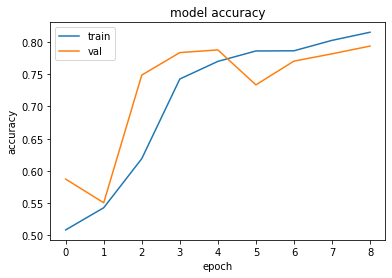

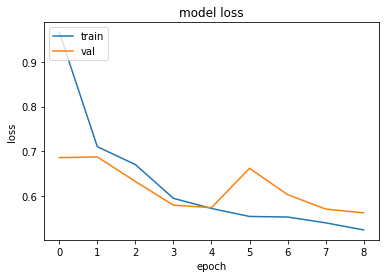

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5342891216278076 , AUC = 0.8222906589508057 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7939582496989162
test 0.82246875

-----------------------------------------------------------------


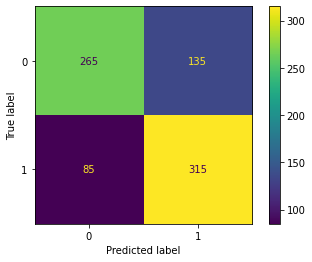

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.604073248327864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5857660210990395
118/118 - 16s - loss: 1.2545 - auc: 0.5147 - val_loss: 0.6882 - val_auc: 0.6032 - 16s/epoch - 135ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6043237556051004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6354274917335853
118/118 - 15s - loss: 0.7290 - auc: 0.5223 - val_loss: 0.6998 - val_auc: 0.6035 - 15s/epoch - 123ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7672850021293118


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.803369548102661
118/118 - 14s - loss: 0.6985 - auc: 0.5903 - val_loss: 0.6392 - val_auc: 0.7682 - 14s/epoch - 122ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7712304917457853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.803369548102661
118/118 - 14s - loss: 0.6081 - auc: 0.7264 - val_loss: 0.5732 - val_auc: 0.7713 - 14s/epoch - 121ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7730967709611964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8107573610455047
118/118 - 14s - loss: 0.5828 - auc: 0.7631 - val_loss: 0.5958 - val_auc: 0.7730 - 14s/epoch - 120ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7783198476915755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8063612029601639
118/118 - 14s - loss: 0.5664 - auc: 0.7742 - val_loss: 0.6232 - val_auc: 0.7783 - 14s/epoch - 121ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7755705303239059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7918060148008187
118/118 - 14s - loss: 0.5532 - auc: 0.7881 - val_loss: 0.6076 - val_auc: 0.7753 - 14s/epoch - 122ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7742992058919311


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8137742087860179
118/118 - 14s - loss: 0.5437 - auc: 0.7986 - val_loss: 0.6038 - val_auc: 0.7742 - 14s/epoch - 122ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7957551541872291


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8112612187057157
118/118 - 15s - loss: 0.5292 - auc: 0.8113 - val_loss: 0.5605 - val_auc: 0.7956 - 15s/epoch - 125ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


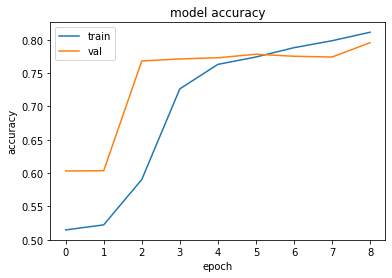

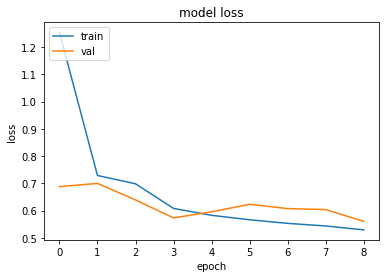

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.546408474445343 , AUC = 0.8114596009254456 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7957551541872291
test 0.8112612187057157

-----------------------------------------------------------------


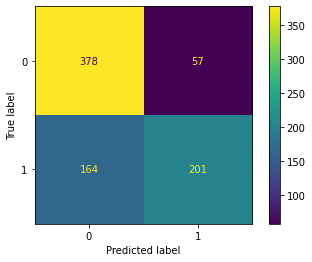

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5773361506338925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6117341777719136
118/118 - 16s - loss: 1.1422 - auc: 0.5038 - val_loss: 0.6920 - val_auc: 0.5734 - 16s/epoch - 135ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7633592558325624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7685773346150705
118/118 - 15s - loss: 0.7291 - auc: 0.5493 - val_loss: 0.6754 - val_auc: 0.7633 - 15s/epoch - 123ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7644720062013952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7813004605457436
118/118 - 14s - loss: 0.6472 - auc: 0.6757 - val_loss: 0.6496 - val_auc: 0.7645 - 14s/epoch - 123ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7808131829661673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7909574702027533
118/118 - 15s - loss: 0.5982 - auc: 0.7424 - val_loss: 0.5730 - val_auc: 0.7804 - 15s/epoch - 123ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.792028206346428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.805848239810504
118/118 - 14s - loss: 0.5776 - auc: 0.7648 - val_loss: 0.5594 - val_auc: 0.7923 - 14s/epoch - 123ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.792865894826336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.794105265803379
118/118 - 14s - loss: 0.5649 - auc: 0.7822 - val_loss: 0.5620 - val_auc: 0.7932 - 14s/epoch - 122ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7962103973394015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8047424273839369
118/118 - 14s - loss: 0.5432 - auc: 0.7980 - val_loss: 0.5577 - val_auc: 0.7962 - 14s/epoch - 122ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7928596434197694


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8097876965801494
118/118 - 14s - loss: 0.5397 - auc: 0.8047 - val_loss: 0.5624 - val_auc: 0.7927 - 14s/epoch - 121ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7884148933510039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8028700858889539
118/118 - 14s - loss: 0.5354 - auc: 0.8073 - val_loss: 0.5713 - val_auc: 0.7883 - 14s/epoch - 122ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


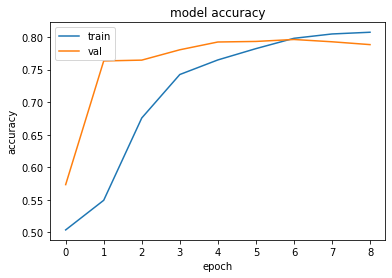

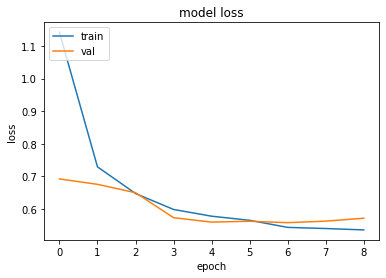

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5458196997642517 , AUC = 0.8026816248893738 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7884148933510039
test 0.8028700858889539

-----------------------------------------------------------------


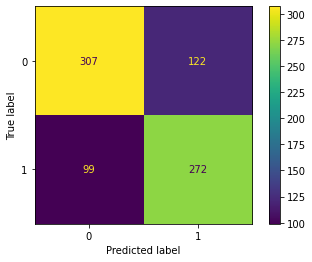

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.47875176068570413


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.4798302888486312
118/118 - 16s - loss: 1.1928 - auc: 0.5064 - val_loss: 0.7023 - val_auc: 0.4812 - 16s/epoch - 136ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5479253911406716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5446734098228664
118/118 - 14s - loss: 0.7203 - auc: 0.5541 - val_loss: 0.7286 - val_auc: 0.5506 - 14s/epoch - 120ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7410481369892432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7521575583735911
118/118 - 14s - loss: 0.6806 - auc: 0.6205 - val_loss: 0.5858 - val_auc: 0.7408 - 14s/epoch - 122ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7342201504557255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7551894625603865
118/118 - 14s - loss: 0.5957 - auc: 0.7454 - val_loss: 0.6212 - val_auc: 0.7360 - 14s/epoch - 122ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7732110485791346


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7827911131239935
118/118 - 14s - loss: 0.5805 - auc: 0.7642 - val_loss: 0.6204 - val_auc: 0.7728 - 14s/epoch - 121ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.773533183003935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.785294635668277
118/118 - 14s - loss: 0.5572 - auc: 0.7841 - val_loss: 0.5703 - val_auc: 0.7738 - 14s/epoch - 122ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7778346250292132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7925252868357489
118/118 - 14s - loss: 0.5472 - auc: 0.7951 - val_loss: 0.5834 - val_auc: 0.7779 - 14s/epoch - 122ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7899746713913048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7980449879227053
118/118 - 14s - loss: 0.5423 - auc: 0.8016 - val_loss: 0.5647 - val_auc: 0.7899 - 14s/epoch - 121ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7817065544880905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7886064563204509
118/118 - 14s - loss: 0.5333 - auc: 0.8081 - val_loss: 0.5650 - val_auc: 0.7815 - 14s/epoch - 121ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


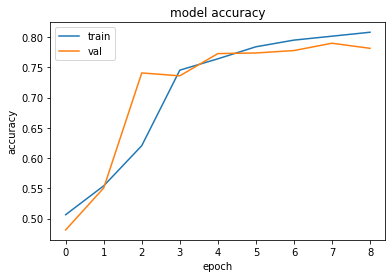

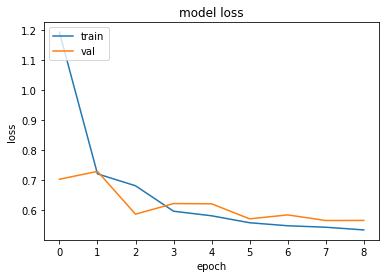

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5528347492218018 , AUC = 0.7885969281196594 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7817065544880905
test 0.7886064563204509

-----------------------------------------------------------------


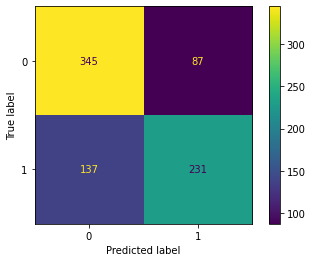

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5846301368145952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6237661303969064
118/118 - 16s - loss: 1.1600 - auc: 0.5131 - val_loss: 0.7793 - val_auc: 0.5848 - 16s/epoch - 135ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6873570278078954


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7180322012547082
118/118 - 15s - loss: 0.7059 - auc: 0.5706 - val_loss: 0.7223 - val_auc: 0.6874 - 15s/epoch - 123ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7779630105478225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7906041025576747
118/118 - 14s - loss: 0.6458 - auc: 0.6906 - val_loss: 0.5622 - val_auc: 0.7778 - 14s/epoch - 122ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7951792127050182


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.805470076899454
118/118 - 14s - loss: 0.5815 - auc: 0.7648 - val_loss: 0.5486 - val_auc: 0.7954 - 14s/epoch - 123ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7974291641336433


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8080521938593248
118/118 - 14s - loss: 0.5729 - auc: 0.7705 - val_loss: 0.5567 - val_auc: 0.7971 - 14s/epoch - 121ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.805764638785653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8078892447307893
118/118 - 14s - loss: 0.5503 - auc: 0.7913 - val_loss: 0.5623 - val_auc: 0.8058 - 14s/epoch - 121ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8065167116865862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.813655136971277
118/118 - 14s - loss: 0.5456 - auc: 0.7975 - val_loss: 0.5352 - val_auc: 0.8064 - 14s/epoch - 123ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8093933905326556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8226110717665565
118/118 - 14s - loss: 0.5357 - auc: 0.8070 - val_loss: 0.5430 - val_auc: 0.8095 - 14s/epoch - 121ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.806103071591073


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8090925613722824
118/118 - 14s - loss: 0.5190 - auc: 0.8203 - val_loss: 0.5438 - val_auc: 0.8061 - 14s/epoch - 119ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


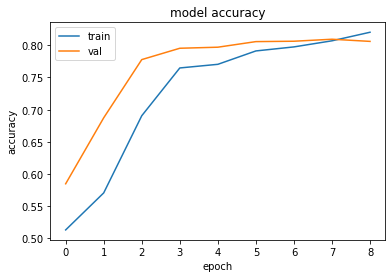

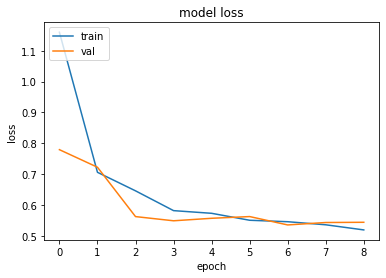

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5413865447044373 , AUC = 0.8090487122535706 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.806103071591073
test 0.8090925613722824

-----------------------------------------------------------------


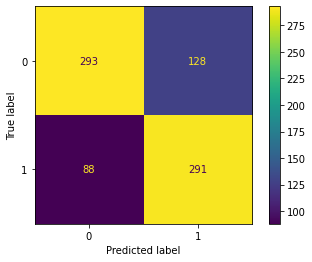

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
# Create directory to save models
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])


  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=9,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

**Model Visualization**

0
Num_samples: 512
acc:  0.7265625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5403621792793274 , AUC = 0.8022937774658203 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8723055976257132
test 0.8020474137931035

-----------------------------------------------------------------


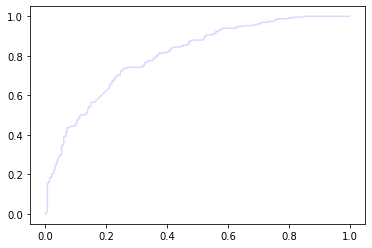

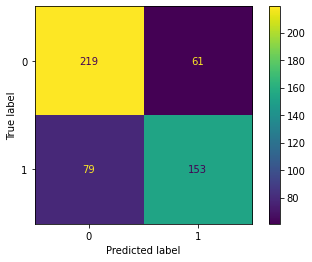

1
Num_samples: 512
acc:  0.73828125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.523969829082489 , AUC = 0.8170720934867859 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8654519864763566
test 0.8172259852216749

-----------------------------------------------------------------


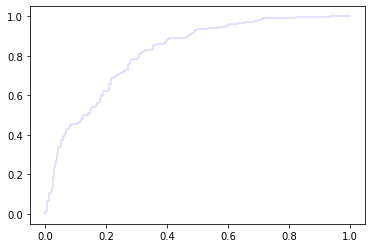

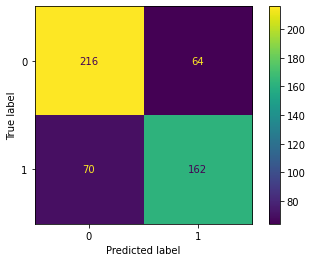

2
Num_samples: 512
acc:  0.744140625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5114324688911438 , AUC = 0.8338901400566101 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8872366790582404
test 0.8338208128078818

-----------------------------------------------------------------


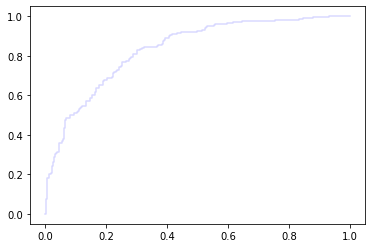

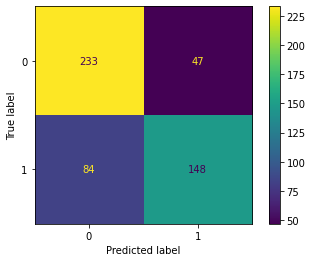

3
Num_samples: 512
acc:  0.73828125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5452549457550049 , AUC = 0.8164178133010864 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8846053819205411
test 0.8165024630541873

-----------------------------------------------------------------


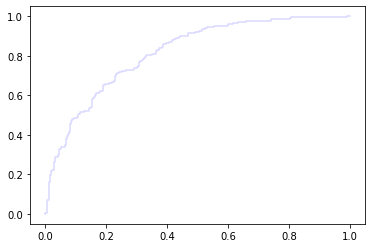

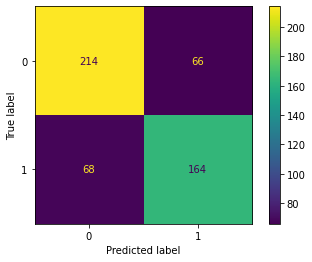

4
Num_samples: 512
acc:  0.71484375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5634026527404785 , AUC = 0.7850061058998108 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8565331130386893
test 0.7845751231527095

-----------------------------------------------------------------


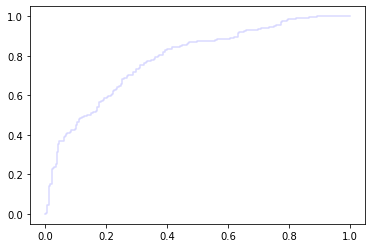

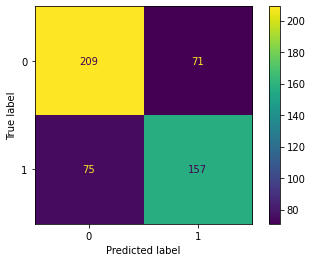

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


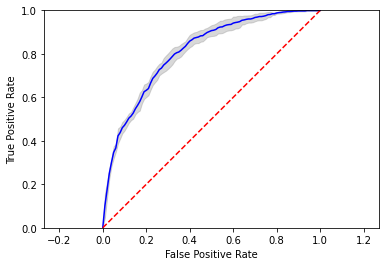

In [ ]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/009--0.516--0.541.hdf5',
          1: '/content/models/1/007--0.469--0.546.hdf5',
          2: '/content/models/2/007--0.556--0.526.hdf5',
          3: '/content/models/3/007--0.510--0.529.hdf5',
          4: '/content/models/4/008--0.480--0.524.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)



  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  
  MERGM_Record1 = model.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = model.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = model.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

  


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

**20 epoch**

rm: cannot remove '/content/models/20': No such file or directory
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6019231734243276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.61746875
118/118 - 16s - loss: 1.1316 - auc: 0.5264 - val_loss: 0.6833 - val_auc: 0.6019 - 16s/epoch - 135ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7283345042151746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.74581875
118/118 - 14s - loss: 0.6990 - auc: 0.6053 - val_loss: 0.6370 - val_auc: 0.7282 - 14s/epoch - 121ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7649099257326375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7763312499999999
118/118 - 14s - loss: 0.5974 - auc: 0.7402 - val_loss: 0.5788 - val_auc: 0.7647 - 14s/epoch - 121ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7860987053392212


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8057687499999999
118/118 - 14s - loss: 0.5653 - auc: 0.7772 - val_loss: 0.5652 - val_auc: 0.7864 - 14s/epoch - 120ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7940523384183059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8073750000000001
118/118 - 14s - loss: 0.5614 - auc: 0.7826 - val_loss: 0.5563 - val_auc: 0.7941 - 14s/epoch - 120ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8008329987956644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.81065
118/118 - 14s - loss: 0.5503 - auc: 0.7929 - val_loss: 0.5493 - val_auc: 0.8011 - 14s/epoch - 123ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7907843235648335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8033625
118/118 - 14s - loss: 0.5396 - auc: 0.8030 - val_loss: 0.5821 - val_auc: 0.7905 - 14s/epoch - 120ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7908345042151745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8198937500000001
118/118 - 14s - loss: 0.5324 - auc: 0.8068 - val_loss: 0.5676 - val_auc: 0.7909 - 14s/epoch - 119ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7873783119229225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82163125
118/118 - 14s - loss: 0.5195 - auc: 0.8205 - val_loss: 0.5788 - val_auc: 0.7874 - 14s/epoch - 119ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7973517161782416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8271
118/118 - 14s - loss: 0.5122 - auc: 0.8269 - val_loss: 0.5865 - val_auc: 0.7975 - 14s/epoch - 119ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7990954937775994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8249812500000001
118/118 - 14s - loss: 0.4911 - auc: 0.8435 - val_loss: 0.5512 - val_auc: 0.7990 - 14s/epoch - 120ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7939645222802089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82725625
118/118 - 14s - loss: 0.4712 - auc: 0.8551 - val_loss: 0.5857 - val_auc: 0.7936 - 14s/epoch - 120ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7749021477318347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8065687500000001
118/118 - 14s - loss: 0.4713 - auc: 0.8558 - val_loss: 0.6168 - val_auc: 0.7750 - 14s/epoch - 120ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7822975210758732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82439375
118/118 - 14s - loss: 0.4478 - auc: 0.8713 - val_loss: 0.5856 - val_auc: 0.7823 - 14s/epoch - 119ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7809928241670012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.813025
118/118 - 14s - loss: 0.4230 - auc: 0.8851 - val_loss: 0.6158 - val_auc: 0.7808 - 14s/epoch - 119ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8056440686471297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82944375
118/118 - 14s - loss: 0.4116 - auc: 0.8917 - val_loss: 0.5837 - val_auc: 0.8056 - 14s/epoch - 120ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7891534524287436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8021624999999999
118/118 - 14s - loss: 0.3807 - auc: 0.9081 - val_loss: 0.6593 - val_auc: 0.7893 - 14s/epoch - 120ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7948238659173023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8072937499999999
118/118 - 14s - loss: 0.3550 - auc: 0.9200 - val_loss: 0.6167 - val_auc: 0.7951 - 14s/epoch - 120ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7926472802087515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7993875
118/118 - 14s - loss: 0.3398 - auc: 0.9279 - val_loss: 0.6349 - val_auc: 0.7927 - 14s/epoch - 119ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8040320152549179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.81180625
118/118 - 14s - loss: 0.3174 - auc: 0.9364 - val_loss: 0.5913 - val_auc: 0.8033 - 14s/epoch - 120ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


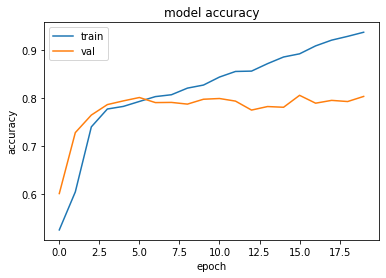

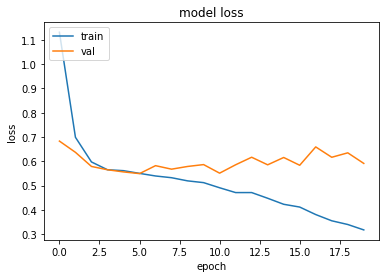

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5705673098564148 , AUC = 0.8112781047821045 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8040320152549179
test 0.81180625

-----------------------------------------------------------------


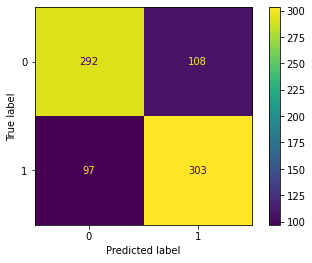

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6131979759012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.593736419461502
118/118 - 16s - loss: 1.0014 - auc: 0.5002 - val_loss: 0.6882 - val_auc: 0.6104 - 16s/epoch - 134ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7141774593551943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7340954180444024
118/118 - 14s - loss: 0.7124 - auc: 0.5559 - val_loss: 0.6615 - val_auc: 0.7146 - 14s/epoch - 122ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7491106991658109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7677090222012282
118/118 - 14s - loss: 0.6298 - auc: 0.6941 - val_loss: 0.5818 - val_auc: 0.7488 - 14s/epoch - 121ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7756456825070768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8116831994961424
118/118 - 14s - loss: 0.5838 - auc: 0.7512 - val_loss: 0.5742 - val_auc: 0.7753 - 14s/epoch - 121ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7865928505223077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8176413163281375
118/118 - 14s - loss: 0.5668 - auc: 0.7754 - val_loss: 0.5692 - val_auc: 0.7866 - 14s/epoch - 121ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7772395350584935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.810908518343568
118/118 - 14s - loss: 0.5515 - auc: 0.7900 - val_loss: 0.6411 - val_auc: 0.7773 - 14s/epoch - 121ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7880082166386934


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8019209573295543
118/118 - 14s - loss: 0.5483 - auc: 0.7937 - val_loss: 0.5606 - val_auc: 0.7883 - 14s/epoch - 122ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7973458753976802


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8117304361517871
118/118 - 14s - loss: 0.5337 - auc: 0.8074 - val_loss: 0.5522 - val_auc: 0.7971 - 14s/epoch - 121ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7944650417094618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.813893874980318
118/118 - 14s - loss: 0.5253 - auc: 0.8166 - val_loss: 0.5621 - val_auc: 0.7945 - 14s/epoch - 121ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7890352964753626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.799703983624626
118/118 - 14s - loss: 0.5136 - auc: 0.8237 - val_loss: 0.5849 - val_auc: 0.7890 - 14s/epoch - 119ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7971266815300984


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8128861596598961
118/118 - 14s - loss: 0.5025 - auc: 0.8330 - val_loss: 0.5858 - val_auc: 0.7970 - 14s/epoch - 120ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7761780104712043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.794041883168005
118/118 - 14s - loss: 0.4868 - auc: 0.8445 - val_loss: 0.5900 - val_auc: 0.7762 - 14s/epoch - 120ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8047045266664997


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8196693434104866
118/118 - 14s - loss: 0.4771 - auc: 0.8522 - val_loss: 0.5494 - val_auc: 0.8048 - 14s/epoch - 122ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.802036624163932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8140828216028971
118/118 - 14s - loss: 0.4545 - auc: 0.8639 - val_loss: 0.5470 - val_auc: 0.8021 - 14s/epoch - 121ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.796882436934793


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.822944418201858
118/118 - 14s - loss: 0.4413 - auc: 0.8731 - val_loss: 0.5443 - val_auc: 0.7970 - 14s/epoch - 121ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7856158721410856


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7868304204062352
118/118 - 14s - loss: 0.4198 - auc: 0.8842 - val_loss: 0.5789 - val_auc: 0.7856 - 14s/epoch - 119ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8089819384253113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8139379625255866
118/118 - 14s - loss: 0.4106 - auc: 0.8898 - val_loss: 0.5829 - val_auc: 0.8086 - 14s/epoch - 120ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7886156967859915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8137616123445126
118/118 - 14s - loss: 0.3895 - auc: 0.9015 - val_loss: 0.6491 - val_auc: 0.7889 - 14s/epoch - 119ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7860793106039731


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8187938907258699
118/118 - 14s - loss: 0.3698 - auc: 0.9111 - val_loss: 0.5979 - val_auc: 0.7861 - 14s/epoch - 120ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.816591096971367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8274287513777357
118/118 - 14s - loss: 0.3467 - auc: 0.9226 - val_loss: 0.6123 - val_auc: 0.8162 - 14s/epoch - 120ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


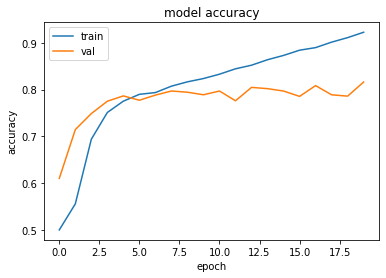

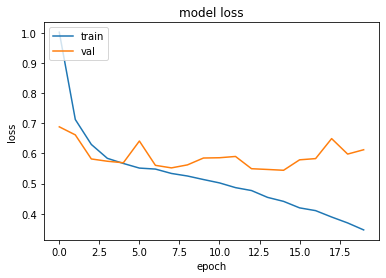

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5927903652191162 , AUC = 0.8277782797813416 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.816591096971367
test 0.8274287513777357

-----------------------------------------------------------------


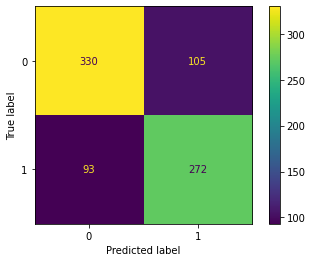

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6177639968993023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6229807927921135
118/118 - 16s - loss: 1.0344 - auc: 0.5246 - val_loss: 0.7023 - val_auc: 0.6155 - 16s/epoch - 132ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.746661748893501


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7738048115406607
118/118 - 14s - loss: 0.6943 - auc: 0.5997 - val_loss: 0.6546 - val_auc: 0.7462 - 14s/epoch - 120ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7699232327273637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7918747918747918
118/118 - 14s - loss: 0.6180 - auc: 0.7186 - val_loss: 0.5707 - val_auc: 0.7695 - 14s/epoch - 120ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7771311044985121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7878128161147029
118/118 - 14s - loss: 0.5739 - auc: 0.7698 - val_loss: 0.5756 - val_auc: 0.7773 - 14s/epoch - 120ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7882273511540097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8119364911817741
118/118 - 14s - loss: 0.5669 - auc: 0.7800 - val_loss: 0.5563 - val_auc: 0.7881 - 14s/epoch - 121ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7987172113725589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7912402063345458
118/118 - 14s - loss: 0.5526 - auc: 0.7914 - val_loss: 0.5545 - val_auc: 0.7985 - 14s/epoch - 119ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7997987047085594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8069289201364673
118/118 - 14s - loss: 0.5445 - auc: 0.7984 - val_loss: 0.5684 - val_auc: 0.7999 - 14s/epoch - 120ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7850453852116728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7959273430971544
118/118 - 14s - loss: 0.5326 - auc: 0.8096 - val_loss: 0.5764 - val_auc: 0.7852 - 14s/epoch - 120ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8022242504563526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8174027230631005
118/118 - 14s - loss: 0.5128 - auc: 0.8261 - val_loss: 0.6090 - val_auc: 0.8020 - 14s/epoch - 120ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8103948388387388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.818200667257271
118/118 - 14s - loss: 0.5077 - auc: 0.8308 - val_loss: 0.5366 - val_auc: 0.8105 - 14s/epoch - 121ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8045435222925158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8210091794997456
118/118 - 14s - loss: 0.4941 - auc: 0.8402 - val_loss: 0.5484 - val_auc: 0.8043 - 14s/epoch - 120ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.803955890075267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8197211593438007
118/118 - 14s - loss: 0.4781 - auc: 0.8513 - val_loss: 0.5573 - val_auc: 0.8039 - 14s/epoch - 119ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8016991323047686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8152476454363247
118/118 - 14s - loss: 0.4657 - auc: 0.8585 - val_loss: 0.5593 - val_auc: 0.8016 - 14s/epoch - 120ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7881085744292466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8227684265420114
118/118 - 14s - loss: 0.4492 - auc: 0.8680 - val_loss: 0.6120 - val_auc: 0.7881 - 14s/epoch - 122ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7711547598209596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7756583039601908
118/118 - 14s - loss: 0.4338 - auc: 0.8780 - val_loss: 0.9743 - val_auc: 0.7665 - 14s/epoch - 121ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8018054062163987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8339082301346452
118/118 - 14s - loss: 0.4100 - auc: 0.8912 - val_loss: 0.5773 - val_auc: 0.8017 - 14s/epoch - 122ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7838638693706084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8079279211354683
118/118 - 14s - loss: 0.3965 - auc: 0.8982 - val_loss: 0.7385 - val_auc: 0.7809 - 14s/epoch - 121ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7865957340401589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7959461921726073
118/118 - 14s - loss: 0.3729 - auc: 0.9103 - val_loss: 0.6056 - val_auc: 0.7865 - 14s/epoch - 121ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8132517316396188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8425725218178048
118/118 - 14s - loss: 0.3426 - auc: 0.9250 - val_loss: 0.5876 - val_auc: 0.8133 - 14s/epoch - 120ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8029869220574628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8350517407121182
118/118 - 14s - loss: 0.3303 - auc: 0.9287 - val_loss: 0.6669 - val_auc: 0.8035 - 14s/epoch - 120ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


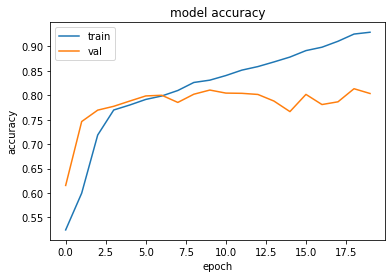

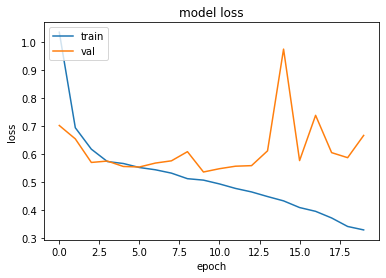

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5789524912834167 , AUC = 0.8345333337783813 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8029869220574628
test 0.8350517407121182

-----------------------------------------------------------------


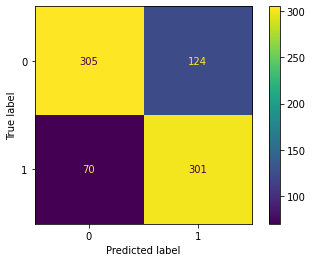

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6668624738660551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6779262278582929
118/118 - 16s - loss: 1.0871 - auc: 0.5257 - val_loss: 0.6880 - val_auc: 0.6686 - 16s/epoch - 134ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7668441564183706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7798787238325282
118/118 - 14s - loss: 0.7072 - auc: 0.5945 - val_loss: 0.6359 - val_auc: 0.7653 - 14s/epoch - 121ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7593276865063574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7569318639291465
118/118 - 14s - loss: 0.6003 - auc: 0.7416 - val_loss: 0.6409 - val_auc: 0.7593 - 14s/epoch - 121ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7720425217440737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.770889945652174
118/118 - 14s - loss: 0.5677 - auc: 0.7785 - val_loss: 0.5647 - val_auc: 0.7720 - 14s/epoch - 121ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7868986034525229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7878988023349436
118/118 - 14s - loss: 0.5435 - auc: 0.8028 - val_loss: 0.5580 - val_auc: 0.7868 - 14s/epoch - 121ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8017357360771606


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7965762127616748
118/118 - 14s - loss: 0.5447 - auc: 0.7979 - val_loss: 0.5495 - val_auc: 0.8018 - 14s/epoch - 121ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8024936994296324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7995263435990339
118/118 - 14s - loss: 0.5282 - auc: 0.8123 - val_loss: 0.5586 - val_auc: 0.8026 - 14s/epoch - 121ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7978448575344717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.791688682568438
118/118 - 14s - loss: 0.5137 - auc: 0.8259 - val_loss: 0.5460 - val_auc: 0.7979 - 14s/epoch - 121ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7820792198030558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7955100140901772
118/118 - 14s - loss: 0.5021 - auc: 0.8345 - val_loss: 0.5874 - val_auc: 0.7823 - 14s/epoch - 120ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7907263183825062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.792169887278583
118/118 - 14s - loss: 0.4863 - auc: 0.8461 - val_loss: 0.5804 - val_auc: 0.7909 - 14s/epoch - 120ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7943266443067478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7831559480676329
118/118 - 14s - loss: 0.4805 - auc: 0.8495 - val_loss: 0.5789 - val_auc: 0.7942 - 14s/epoch - 121ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8000366348953695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7999509359903383
118/118 - 14s - loss: 0.4576 - auc: 0.8653 - val_loss: 0.5751 - val_auc: 0.8001 - 14s/epoch - 121ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.799367100600686


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7893078200483092
118/118 - 14s - loss: 0.4493 - auc: 0.8700 - val_loss: 0.5516 - val_auc: 0.7993 - 14s/epoch - 121ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.804615996816554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8060713566827696
118/118 - 14s - loss: 0.4237 - auc: 0.8847 - val_loss: 0.5638 - val_auc: 0.8044 - 14s/epoch - 121ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.810404941921058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8205295138888887
118/118 - 14s - loss: 0.4100 - auc: 0.8915 - val_loss: 0.5670 - val_auc: 0.8104 - 14s/epoch - 121ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.819067831403685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8116728311191627
118/118 - 14s - loss: 0.3801 - auc: 0.9074 - val_loss: 0.6506 - val_auc: 0.8177 - 14s/epoch - 120ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7998155622508983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8017814009661836
118/118 - 14s - loss: 0.3630 - auc: 0.9157 - val_loss: 0.6223 - val_auc: 0.7997 - 14s/epoch - 122ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8146590112368067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8031652576489532
118/118 - 14s - loss: 0.3427 - auc: 0.9257 - val_loss: 0.5544 - val_auc: 0.8145 - 14s/epoch - 121ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7974785085807768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.819356380837359
118/118 - 14s - loss: 0.3036 - auc: 0.9409 - val_loss: 0.7476 - val_auc: 0.7971 - 14s/epoch - 121ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8101680783734106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8007309279388084
118/118 - 14s - loss: 0.2778 - auc: 0.9517 - val_loss: 0.6369 - val_auc: 0.8092 - 14s/epoch - 120ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


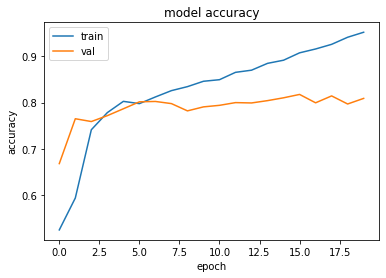

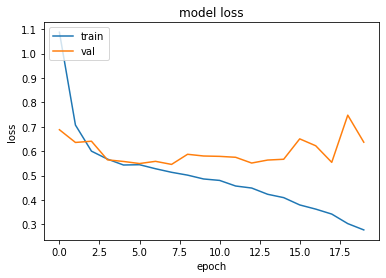

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.6938890218734741 , AUC = 0.7994633913040161 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8101680783734106
test 0.8007309279388084

-----------------------------------------------------------------


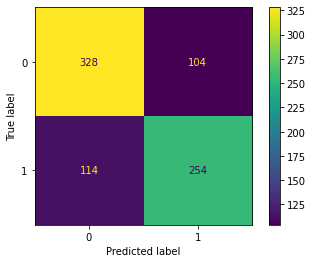

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5854574170056217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5584768016846433
118/118 - 16s - loss: 1.2315 - auc: 0.5042 - val_loss: 0.6872 - val_auc: 0.5855 - 16s/epoch - 134ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7371066502046265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7496600003760364
118/118 - 14s - loss: 0.7135 - auc: 0.5732 - val_loss: 0.6809 - val_auc: 0.7369 - 14s/epoch - 121ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7550999943594532


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7655976786016457
118/118 - 14s - loss: 0.6273 - auc: 0.7064 - val_loss: 0.5989 - val_auc: 0.7558 - 14s/epoch - 122ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7778501996126825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7793042072211533
118/118 - 14s - loss: 0.5825 - auc: 0.7606 - val_loss: 0.5918 - val_auc: 0.7780 - 14s/epoch - 122ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8033642727768412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7990711899673475
118/118 - 14s - loss: 0.5694 - auc: 0.7730 - val_loss: 0.5444 - val_auc: 0.8035 - 14s/epoch - 123ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8046804003534743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8155917246911801
118/118 - 14s - loss: 0.5538 - auc: 0.7879 - val_loss: 0.5421 - val_auc: 0.8047 - 14s/epoch - 122ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8012960722992749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8140719107038775
118/118 - 14s - loss: 0.5340 - auc: 0.8079 - val_loss: 0.6344 - val_auc: 0.8010 - 14s/epoch - 120ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8043983730156243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8136426024229283
118/118 - 14s - loss: 0.5250 - auc: 0.8161 - val_loss: 0.5801 - val_auc: 0.8043 - 14s/epoch - 120ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8023803107314535


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8227050808791732
118/118 - 14s - loss: 0.5169 - auc: 0.8215 - val_loss: 0.5811 - val_auc: 0.8022 - 14s/epoch - 122ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8098007633539943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8229745736686742
118/118 - 14s - loss: 0.5023 - auc: 0.8345 - val_loss: 0.5553 - val_auc: 0.8096 - 14s/epoch - 122ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7938818869509083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8212698750932255
118/118 - 14s - loss: 0.4887 - auc: 0.8437 - val_loss: 0.5530 - val_auc: 0.7936 - 14s/epoch - 121ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8078767101824404


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8151906191440157
118/118 - 14s - loss: 0.4724 - auc: 0.8541 - val_loss: 0.5469 - val_auc: 0.8078 - 14s/epoch - 122ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8003183775280618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8169767922837321
118/118 - 14s - loss: 0.4597 - auc: 0.8616 - val_loss: 0.5558 - val_auc: 0.8005 - 14s/epoch - 121ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8282140148785089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.827424338332529
118/118 - 14s - loss: 0.4483 - auc: 0.8704 - val_loss: 0.5248 - val_auc: 0.8281 - 14s/epoch - 121ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8127526494901572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8283330930878234
118/118 - 14s - loss: 0.4204 - auc: 0.8883 - val_loss: 0.5685 - val_auc: 0.8128 - 14s/epoch - 120ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8028127526494903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8031668536403462
118/118 - 14s - loss: 0.4051 - auc: 0.8955 - val_loss: 0.6448 - val_auc: 0.8028 - 14s/epoch - 120ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8221410262034732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8341052526024856
118/118 - 14s - loss: 0.3797 - auc: 0.9090 - val_loss: 0.5910 - val_auc: 0.8220 - 14s/epoch - 120ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8134295151009971


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8303636899203429
118/118 - 14s - loss: 0.3645 - auc: 0.9160 - val_loss: 0.5651 - val_auc: 0.8134 - 14s/epoch - 122ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7969465840222112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8350704128253499
118/118 - 14s - loss: 0.3342 - auc: 0.9305 - val_loss: 0.6235 - val_auc: 0.7964 - 14s/epoch - 120ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8029192963104558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8362486603701451
118/118 - 14s - loss: 0.3156 - auc: 0.9381 - val_loss: 0.6536 - val_auc: 0.8026 - 14s/epoch - 120ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


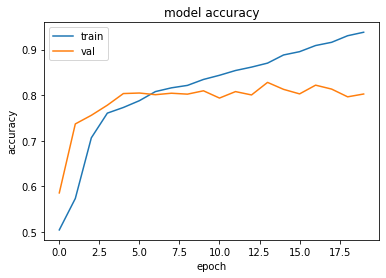

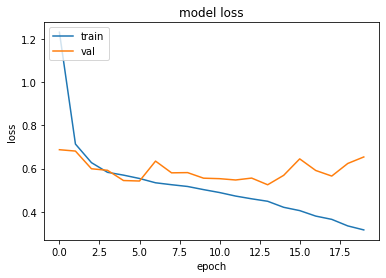

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5910770297050476 , AUC = 0.8371825218200684 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8029192963104558
test 0.8362486603701451

-----------------------------------------------------------------


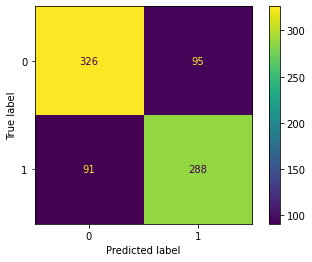

In [ ]:
# Create directory to save models
rt_sv_dir = '/content/models/20'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 512
acc:  0.79296875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.45180630683898926 , AUC = 0.8804725408554077 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9250233298147383
test 0.8807112068965517

-----------------------------------------------------------------


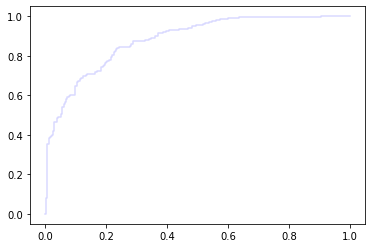

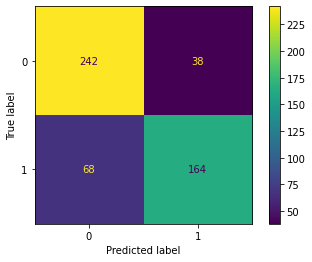

1
Num_samples: 512
acc:  0.7578125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.48676034808158875 , AUC = 0.8472830057144165 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.89702755212875
test 0.8472906403940886

-----------------------------------------------------------------


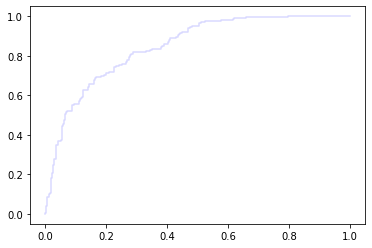

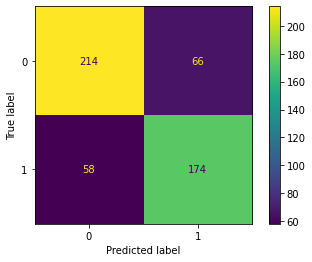

2
Num_samples: 512
acc:  0.80859375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.40919578075408936 , AUC = 0.9043488502502441 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9393118852020133
test 0.9044027093596059

-----------------------------------------------------------------


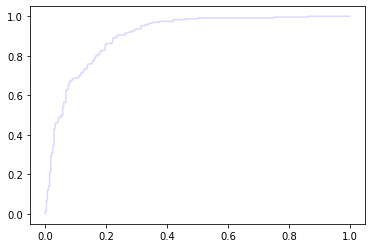

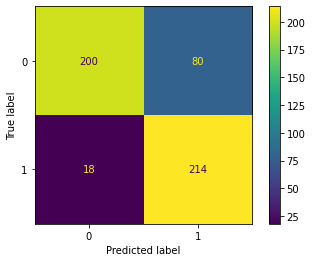

3
Num_samples: 512
acc:  0.791015625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.4582819938659668 , AUC = 0.8700739145278931 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9102452307739379
test 0.8701046798029557

-----------------------------------------------------------------


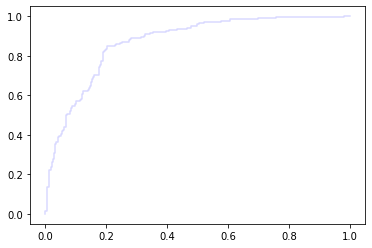

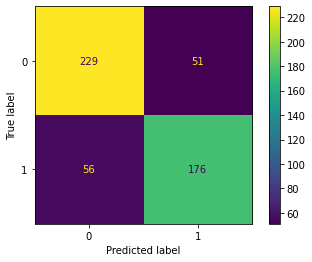

4
Num_samples: 512
acc:  0.72265625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5684860348701477 , AUC = 0.8134236335754395 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.885722153380146
test 0.813423645320197

-----------------------------------------------------------------


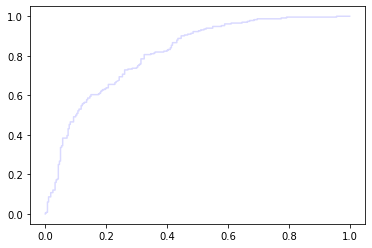

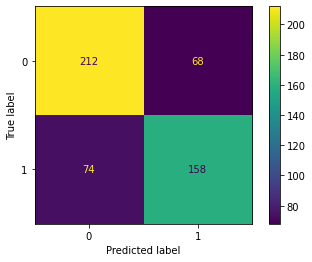

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


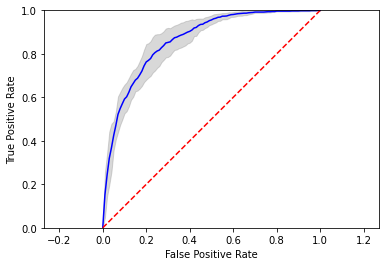

In [ ]:

# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/20/0/020--0.511--0.396.hdf5',
          1: '/content/models/20/1/013--0.466--0.482.hdf5',
          2: '/content/models/20/2/020--0.510--0.395.hdf5',
          3: '/content/models/20/3/016--0.479--0.464.hdf5',
          4: '/content/models/20/4/020--0.447--0.390.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  
  MERGM_Record1 = model.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = model.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = model.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

  


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

50 epoch 80 

rm: cannot remove '/content/models/500': No such file or directory
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5756724392041268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5612745098039216
134/134 - 16s - loss: 0.9943 - auc: 0.5110 - val_loss: 0.6887 - val_auc: 0.5743 - 16s/epoch - 120ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6642870302137067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6873314950980394
134/134 - 15s - loss: 0.7075 - auc: 0.5468 - val_loss: 0.6871 - val_auc: 0.6588 - 15s/epoch - 108ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8137281994595923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8149816176470588
134/134 - 14s - loss: 0.6498 - auc: 0.6667 - val_loss: 0.5411 - val_auc: 0.8133 - 14s/epoch - 108ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8180883075411447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8271599264705882
134/134 - 15s - loss: 0.5952 - auc: 0.7415 - val_loss: 0.5346 - val_auc: 0.8181 - 15s/epoch - 109ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8207442888725129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8355851715686274
134/134 - 15s - loss: 0.5704 - auc: 0.7692 - val_loss: 0.5161 - val_auc: 0.8210 - 15s/epoch - 109ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8282670105625153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8299019607843138
134/134 - 15s - loss: 0.5521 - auc: 0.7909 - val_loss: 0.5585 - val_auc: 0.8282 - 15s/epoch - 108ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.815509088676001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.837530637254902
134/134 - 14s - loss: 0.5517 - auc: 0.7912 - val_loss: 0.5270 - val_auc: 0.8159 - 14s/epoch - 108ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8205140014738393


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8473958333333333
134/134 - 14s - loss: 0.5392 - auc: 0.8033 - val_loss: 0.5354 - val_auc: 0.8205 - 14s/epoch - 108ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8313989191844755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8520373774509803
134/134 - 14s - loss: 0.5330 - auc: 0.8083 - val_loss: 0.5100 - val_auc: 0.8315 - 14s/epoch - 108ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8257184966838613


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8479319852941177
134/134 - 14s - loss: 0.5206 - auc: 0.8206 - val_loss: 0.5305 - val_auc: 0.8259 - 14s/epoch - 107ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8425141242937855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8707107843137254
134/134 - 15s - loss: 0.5027 - auc: 0.8322 - val_loss: 0.5084 - val_auc: 0.8425 - 15s/epoch - 110ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8424680668140505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8425704656862745
134/134 - 15s - loss: 0.4970 - auc: 0.8374 - val_loss: 0.5280 - val_auc: 0.8423 - 15s/epoch - 109ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8261944239744534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8409160539215685
134/134 - 15s - loss: 0.4826 - auc: 0.8476 - val_loss: 0.5289 - val_auc: 0.8260 - 15s/epoch - 109ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8338399656104152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8368412990196079
134/134 - 14s - loss: 0.4635 - auc: 0.8607 - val_loss: 0.5416 - val_auc: 0.8336 - 14s/epoch - 108ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8575135101940555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8627910539215686
134/134 - 15s - loss: 0.4449 - auc: 0.8736 - val_loss: 0.5110 - val_auc: 0.8578 - 15s/epoch - 109ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8442489560304595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8439797794117647
134/134 - 14s - loss: 0.4339 - auc: 0.8790 - val_loss: 0.5216 - val_auc: 0.8439 - 14s/epoch - 108ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8450472856791942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8511642156862745
134/134 - 15s - loss: 0.4012 - auc: 0.8968 - val_loss: 0.4952 - val_auc: 0.8452 - 15s/epoch - 110ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8345922377794153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8468137254901961
134/134 - 14s - loss: 0.3933 - auc: 0.9010 - val_loss: 0.5658 - val_auc: 0.8342 - 14s/epoch - 107ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.847626504544338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8342371323529413
134/134 - 14s - loss: 0.3487 - auc: 0.9222 - val_loss: 0.5480 - val_auc: 0.8474 - 14s/epoch - 108ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8407178825841317


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8417892156862745
134/134 - 14s - loss: 0.3239 - auc: 0.9342 - val_loss: 0.5302 - val_auc: 0.8403 - 14s/epoch - 107ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8471659297469909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8505667892156863
134/134 - 14s - loss: 0.3005 - auc: 0.9430 - val_loss: 0.5359 - val_auc: 0.8466 - 14s/epoch - 108ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8533683370179318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8692401960784313
134/134 - 14s - loss: 0.2839 - auc: 0.9496 - val_loss: 0.5457 - val_auc: 0.8525 - 14s/epoch - 107ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8475036845983788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8574754901960784
134/134 - 14s - loss: 0.2451 - auc: 0.9625 - val_loss: 0.6008 - val_auc: 0.8472 - 14s/epoch - 108ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.860430483910587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8672181372549019
134/134 - 14s - loss: 0.2249 - auc: 0.9683 - val_loss: 0.6534 - val_auc: 0.8606 - 14s/epoch - 108ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461066077130924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8474417892156862
134/134 - 14s - loss: 0.2046 - auc: 0.9737 - val_loss: 0.5992 - val_auc: 0.8459 - 14s/epoch - 108ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8485323016457872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8607077205882353
134/134 - 14s - loss: 0.1788 - auc: 0.9798 - val_loss: 0.6665 - val_auc: 0.8477 - 14s/epoch - 108ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.845599975436011


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8494638480392157
134/134 - 14s - loss: 0.1775 - auc: 0.9801 - val_loss: 0.6744 - val_auc: 0.8421 - 14s/epoch - 108ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8570989928764432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8748774509803923
134/134 - 14s - loss: 0.1441 - auc: 0.9866 - val_loss: 0.6578 - val_auc: 0.8563 - 14s/epoch - 107ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8492385163350528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8748008578431373
134/134 - 14s - loss: 0.1339 - auc: 0.9881 - val_loss: 0.7172 - val_auc: 0.8477 - 14s/epoch - 107ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8668938835666913


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8682444852941177
134/134 - 14s - loss: 0.1111 - auc: 0.9916 - val_loss: 0.8195 - val_auc: 0.8614 - 14s/epoch - 107ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8537060918693196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8726868872549018
134/134 - 14s - loss: 0.1152 - auc: 0.9913 - val_loss: 0.8027 - val_auc: 0.8502 - 14s/epoch - 107ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8706475681650699


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8800704656862745
134/134 - 15s - loss: 0.0944 - auc: 0.9936 - val_loss: 0.8719 - val_auc: 0.8666 - 15s/epoch - 108ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8327959960697617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8515471813725489
134/134 - 15s - loss: 0.0988 - auc: 0.9936 - val_loss: 0.9900 - val_auc: 0.8335 - 15s/epoch - 109ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8486858265782363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8649509803921568
134/134 - 15s - loss: 0.0855 - auc: 0.9949 - val_loss: 0.9571 - val_auc: 0.8433 - 15s/epoch - 109ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8581199336772292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8643995098039217
134/134 - 14s - loss: 0.0678 - auc: 0.9963 - val_loss: 1.0113 - val_auc: 0.8497 - 14s/epoch - 107ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8458763203144191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8590916053921567
134/134 - 14s - loss: 0.0675 - auc: 0.9965 - val_loss: 0.8837 - val_auc: 0.8420 - 14s/epoch - 107ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8435427413411938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8674479166666667
134/134 - 14s - loss: 0.0777 - auc: 0.9960 - val_loss: 1.0902 - val_auc: 0.8337 - 14s/epoch - 107ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8376320314419061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8473881740196079
134/134 - 14s - loss: 0.0752 - auc: 0.9960 - val_loss: 0.9092 - val_auc: 0.8316 - 14s/epoch - 106ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8628101203635471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8628370098039216
134/134 - 14s - loss: 0.0692 - auc: 0.9962 - val_loss: 0.9066 - val_auc: 0.8606 - 14s/epoch - 106ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8624109555391795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.873797487745098
134/134 - 14s - loss: 0.0611 - auc: 0.9970 - val_loss: 1.1301 - val_auc: 0.8526 - 14s/epoch - 107ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8695191599115696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8857766544117648
134/134 - 14s - loss: 0.0560 - auc: 0.9972 - val_loss: 0.9739 - val_auc: 0.8596 - 14s/epoch - 107ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8615051584377302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8689031862745098
134/134 - 14s - loss: 0.0501 - auc: 0.9980 - val_loss: 1.1862 - val_auc: 0.8410 - 14s/epoch - 107ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8726587447801522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8823529411764706
134/134 - 14s - loss: 0.0460 - auc: 0.9983 - val_loss: 1.0212 - val_auc: 0.8636 - 14s/epoch - 106ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.859662859248342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8734911151960785
134/134 - 14s - loss: 0.0384 - auc: 0.9991 - val_loss: 1.1415 - val_auc: 0.8454 - 14s/epoch - 106ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.852946143453697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8705346200980393
134/134 - 14s - loss: 0.0641 - auc: 0.9966 - val_loss: 1.0605 - val_auc: 0.8420 - 14s/epoch - 107ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8658575902726603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.870404411764706
134/134 - 14s - loss: 0.0457 - auc: 0.9985 - val_loss: 1.1031 - val_auc: 0.8615 - 14s/epoch - 107ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8631785802014247


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.876309742647059
134/134 - 14s - loss: 0.0599 - auc: 0.9974 - val_loss: 0.9918 - val_auc: 0.8544 - 14s/epoch - 107ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8446327683615821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8624693627450981
134/134 - 14s - loss: 0.0378 - auc: 0.9987 - val_loss: 1.2704 - val_auc: 0.8336 - 14s/epoch - 106ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8521631662982068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8814031862745099
134/134 - 14s - loss: 0.0454 - auc: 0.9976 - val_loss: 1.1144 - val_auc: 0.8423 - 14s/epoch - 107ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8631632277081799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8758578431372548
134/134 - 14s - loss: 0.0372 - auc: 0.9991 - val_loss: 1.2074 - val_auc: 0.8517 - 14s/epoch - 107ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


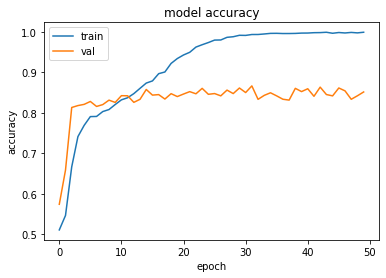

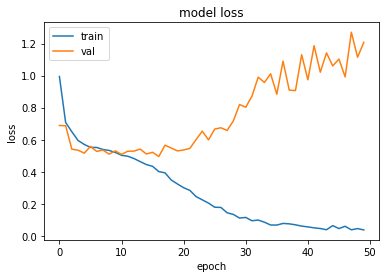

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.1310575008392334 , AUC = 0.8681907653808594 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8631632277081799
test 0.8758578431372548

-----------------------------------------------------------------


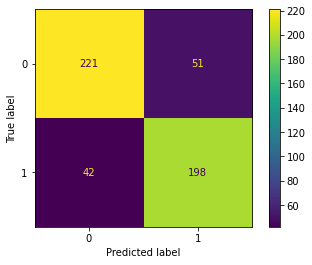

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5096470141700405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5446020163079229
134/134 - 16s - loss: 1.2757 - auc: 0.5201 - val_loss: 0.7383 - val_auc: 0.5098 - 16s/epoch - 119ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5250506072874493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5167133262961433
134/134 - 14s - loss: 0.7240 - auc: 0.5356 - val_loss: 0.7336 - val_auc: 0.5225 - 14s/epoch - 108ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8213088309716599


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7861000198877108
134/134 - 14s - loss: 0.6877 - auc: 0.6085 - val_loss: 0.5525 - val_auc: 0.8213 - 14s/epoch - 108ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8147456983805668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8038765738063548
134/134 - 15s - loss: 0.6198 - auc: 0.7158 - val_loss: 0.5419 - val_auc: 0.8144 - 15s/epoch - 109ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8334545799595143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8208270228096746
134/134 - 15s - loss: 0.5848 - auc: 0.7570 - val_loss: 0.5245 - val_auc: 0.8333 - 15s/epoch - 108ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8455054402834009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8437131886119908
134/134 - 14s - loss: 0.5721 - auc: 0.7732 - val_loss: 0.5187 - val_auc: 0.8455 - 14s/epoch - 107ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8317940283400811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8159774809919378
134/134 - 15s - loss: 0.5663 - auc: 0.7774 - val_loss: 0.4994 - val_auc: 0.8318 - 15s/epoch - 109ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.841773152834008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8455948720302293
134/134 - 15s - loss: 0.5570 - auc: 0.7881 - val_loss: 0.5204 - val_auc: 0.8415 - 15s/epoch - 109ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8116776315789473


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8208729175271927
134/134 - 14s - loss: 0.5450 - auc: 0.7980 - val_loss: 0.6025 - val_auc: 0.8116 - 14s/epoch - 107ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8056996457489878


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.818945339391436
134/134 - 14s - loss: 0.5403 - auc: 0.8049 - val_loss: 0.5881 - val_auc: 0.8058 - 14s/epoch - 107ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8506452429149798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8549573944039041
134/134 - 14s - loss: 0.5162 - auc: 0.8234 - val_loss: 0.5199 - val_auc: 0.8508 - 14s/epoch - 107ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8463436234817814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8451206266158765
134/134 - 14s - loss: 0.5155 - auc: 0.8226 - val_loss: 0.4766 - val_auc: 0.8461 - 14s/epoch - 108ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.833043395748988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8223415484877691
134/134 - 14s - loss: 0.5052 - auc: 0.8301 - val_loss: 0.5558 - val_auc: 0.8329 - 14s/epoch - 108ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8310823633603238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8423975400431409
134/134 - 14s - loss: 0.4987 - auc: 0.8351 - val_loss: 0.4994 - val_auc: 0.8311 - 14s/epoch - 107ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8492535425101215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.857802866890021
134/134 - 14s - loss: 0.4786 - auc: 0.8486 - val_loss: 0.4722 - val_auc: 0.8491 - 14s/epoch - 108ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8553264170040485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8497406948460232
134/134 - 14s - loss: 0.4645 - auc: 0.8576 - val_loss: 0.4803 - val_auc: 0.8552 - 14s/epoch - 108ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.835684463562753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8394449798828154
134/134 - 14s - loss: 0.4523 - auc: 0.8648 - val_loss: 0.5011 - val_auc: 0.8358 - 14s/epoch - 107ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8619686234817813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8559670781893004
134/134 - 14s - loss: 0.4275 - auc: 0.8805 - val_loss: 0.4622 - val_auc: 0.8619 - 14s/epoch - 107ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8512620192307692


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8685422307892362
134/134 - 14s - loss: 0.4088 - auc: 0.8885 - val_loss: 0.4786 - val_auc: 0.8511 - 14s/epoch - 107ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8488739878542512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8720761240381232
134/134 - 14s - loss: 0.3945 - auc: 0.8972 - val_loss: 0.4756 - val_auc: 0.8489 - 14s/epoch - 106ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8553738613360323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8694142304220784
134/134 - 14s - loss: 0.3784 - auc: 0.9063 - val_loss: 0.4735 - val_auc: 0.8555 - 14s/epoch - 106ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8530965334008097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.877201034160968
134/134 - 14s - loss: 0.3565 - auc: 0.9174 - val_loss: 0.4787 - val_auc: 0.8532 - 14s/epoch - 106ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8788271761133603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8782413144247098
134/134 - 14s - loss: 0.3388 - auc: 0.9270 - val_loss: 0.4538 - val_auc: 0.8785 - 14s/epoch - 106ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8348304655870445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8455030825951935
134/134 - 14s - loss: 0.3201 - auc: 0.9336 - val_loss: 0.5831 - val_auc: 0.8348 - 14s/epoch - 105ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8465017712550608


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8668441262410697
134/134 - 14s - loss: 0.2931 - auc: 0.9460 - val_loss: 0.5322 - val_auc: 0.8465 - 14s/epoch - 107ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.84129870951417


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8536417458350543
134/134 - 14s - loss: 0.2776 - auc: 0.9519 - val_loss: 0.5852 - val_auc: 0.8412 - 14s/epoch - 107ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8365226467611335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8492817476708431
134/134 - 14s - loss: 0.2428 - auc: 0.9626 - val_loss: 0.6100 - val_auc: 0.8367 - 14s/epoch - 106ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8604820344129555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8835498034176266
134/134 - 14s - loss: 0.2308 - auc: 0.9671 - val_loss: 0.5757 - val_auc: 0.8602 - 14s/epoch - 107ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8387050860323887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8258601434974834
134/134 - 14s - loss: 0.2117 - auc: 0.9722 - val_loss: 0.7444 - val_auc: 0.8376 - 14s/epoch - 106ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8485576923076923


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.864075144950816
134/134 - 14s - loss: 0.2011 - auc: 0.9748 - val_loss: 0.6588 - val_auc: 0.8474 - 14s/epoch - 108ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8539821609311741


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8535346581608456
134/134 - 14s - loss: 0.1665 - auc: 0.9827 - val_loss: 0.7218 - val_auc: 0.8536 - 14s/epoch - 106ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8681363866396761


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8796793489069408
134/134 - 14s - loss: 0.1658 - auc: 0.9827 - val_loss: 0.7077 - val_auc: 0.8644 - 14s/epoch - 107ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8557692307692307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8382058225098292
134/134 - 14s - loss: 0.1287 - auc: 0.9895 - val_loss: 0.6630 - val_auc: 0.8536 - 14s/epoch - 107ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.857651189271255


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.864228127342543
134/134 - 15s - loss: 0.1350 - auc: 0.9887 - val_loss: 0.6677 - val_auc: 0.8552 - 15s/epoch - 109ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8858489372469636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8900668533051845
134/134 - 14s - loss: 0.1244 - auc: 0.9900 - val_loss: 0.6781 - val_auc: 0.8786 - 14s/epoch - 105ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8771349949392713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8869919072314777
134/134 - 14s - loss: 0.1121 - auc: 0.9914 - val_loss: 0.7185 - val_auc: 0.8665 - 14s/epoch - 106ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8619369939271254


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.874646228219132
134/134 - 14s - loss: 0.0896 - auc: 0.9945 - val_loss: 0.8252 - val_auc: 0.8566 - 14s/epoch - 107ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8828125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8779200514020836
134/134 - 14s - loss: 0.0841 - auc: 0.9954 - val_loss: 0.7090 - val_auc: 0.8778 - 14s/epoch - 106ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8795388410931174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8852173114874478
134/134 - 14s - loss: 0.0996 - auc: 0.9933 - val_loss: 0.6911 - val_auc: 0.8743 - 14s/epoch - 106ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8495223937246963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8555387274924655
134/134 - 14s - loss: 0.0800 - auc: 0.9958 - val_loss: 0.8720 - val_auc: 0.8441 - 14s/epoch - 106ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8899607793522267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8904646075236741
134/134 - 14s - loss: 0.0817 - auc: 0.9955 - val_loss: 0.6399 - val_auc: 0.8882 - 14s/epoch - 106ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8633682312753037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8734070708461457
134/134 - 14s - loss: 0.0641 - auc: 0.9972 - val_loss: 0.8517 - val_auc: 0.8611 - 14s/epoch - 107ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8610750885627529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8748986491654811
134/134 - 14s - loss: 0.0670 - auc: 0.9966 - val_loss: 1.0684 - val_auc: 0.8513 - 14s/epoch - 107ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8659302252024292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.862269952728441
134/134 - 14s - loss: 0.0833 - auc: 0.9949 - val_loss: 0.9064 - val_auc: 0.8592 - 14s/epoch - 106ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8700657894736843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8529992197898022
134/134 - 14s - loss: 0.0600 - auc: 0.9970 - val_loss: 0.7541 - val_auc: 0.8649 - 14s/epoch - 108ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.877941548582996


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8757324032003917
134/134 - 14s - loss: 0.0583 - auc: 0.9966 - val_loss: 0.8239 - val_auc: 0.8693 - 14s/epoch - 107ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8671716852226722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8664463720225802
134/134 - 14s - loss: 0.0572 - auc: 0.9971 - val_loss: 0.9011 - val_auc: 0.8600 - 14s/epoch - 108ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8795546558704455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8948781495249898
134/134 - 14s - loss: 0.0419 - auc: 0.9983 - val_loss: 1.0571 - val_auc: 0.8740 - 14s/epoch - 107ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8802584134615385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8950234827971301
134/134 - 14s - loss: 0.0415 - auc: 0.9986 - val_loss: 0.9985 - val_auc: 0.8628 - 14s/epoch - 107ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9032451923076924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8986950601985711
134/134 - 14s - loss: 0.0659 - auc: 0.9966 - val_loss: 0.7803 - val_auc: 0.8934 - 14s/epoch - 105ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


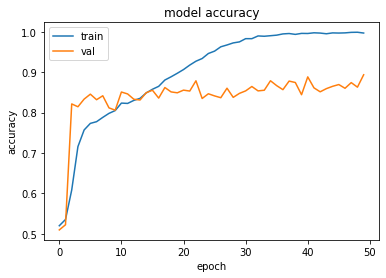

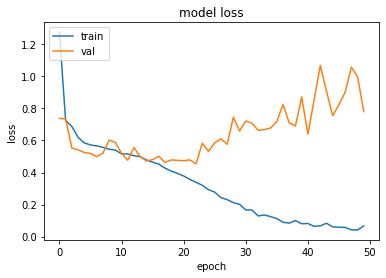

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.7731814384460449 , AUC = 0.8915354609489441 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9032451923076924
test 0.8986950601985711

-----------------------------------------------------------------


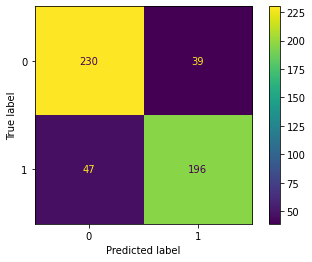

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6248239975512703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6469149476210254
134/134 - 16s - loss: 1.0917 - auc: 0.5303 - val_loss: 0.6869 - val_auc: 0.6212 - 16s/epoch - 119ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7488215488215487


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7402433584075562
134/134 - 14s - loss: 0.7139 - auc: 0.5652 - val_loss: 0.6577 - val_auc: 0.7485 - 14s/epoch - 108ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7710590756045302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7748703985724614
134/134 - 14s - loss: 0.6117 - auc: 0.7232 - val_loss: 0.5880 - val_auc: 0.7708 - 14s/epoch - 108ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7686715641261097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7736243789130403
134/134 - 14s - loss: 0.5823 - auc: 0.7565 - val_loss: 0.5793 - val_auc: 0.7681 - 14s/epoch - 108ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7961432506887052


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.799452366668205
134/134 - 14s - loss: 0.5598 - auc: 0.7831 - val_loss: 0.5606 - val_auc: 0.7961 - 14s/epoch - 107ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7970003060912152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8013444705954744
134/134 - 14s - loss: 0.5457 - auc: 0.7939 - val_loss: 0.5557 - val_auc: 0.7970 - 14s/epoch - 108ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7856290174471993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7848231728890734
134/134 - 14s - loss: 0.5342 - auc: 0.8056 - val_loss: 0.5838 - val_auc: 0.7856 - 14s/epoch - 107ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7945668809305172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7939298844739798
134/134 - 14s - loss: 0.5302 - auc: 0.8120 - val_loss: 0.5597 - val_auc: 0.7948 - 14s/epoch - 108ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7977961432506888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8010521943790668
134/134 - 14s - loss: 0.5162 - auc: 0.8238 - val_loss: 0.5559 - val_auc: 0.7981 - 14s/epoch - 107ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8027854300581572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8116664359222854
134/134 - 14s - loss: 0.5090 - auc: 0.8294 - val_loss: 0.5729 - val_auc: 0.8027 - 14s/epoch - 107ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8060759106213651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8102204377990063
134/134 - 14s - loss: 0.4983 - auc: 0.8360 - val_loss: 0.5484 - val_auc: 0.8061 - 14s/epoch - 107ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8074227119681665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8136354546433462
134/134 - 14s - loss: 0.4855 - auc: 0.8471 - val_loss: 0.5431 - val_auc: 0.8074 - 14s/epoch - 107ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8101010101010101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8256803113510851
134/134 - 14s - loss: 0.4783 - auc: 0.8498 - val_loss: 0.5393 - val_auc: 0.8105 - 14s/epoch - 108ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8062442607897155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8046902641254019
134/134 - 14s - loss: 0.4631 - auc: 0.8616 - val_loss: 0.5530 - val_auc: 0.8061 - 14s/epoch - 107ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8045607591062137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.793253034288615
134/134 - 14s - loss: 0.4556 - auc: 0.8644 - val_loss: 0.5667 - val_auc: 0.8048 - 14s/epoch - 106ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.814279155188246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8248957804544126
134/134 - 14s - loss: 0.4361 - auc: 0.8770 - val_loss: 0.5651 - val_auc: 0.8143 - 14s/epoch - 106ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8376798285889195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8233113357023091
134/134 - 14s - loss: 0.4078 - auc: 0.8921 - val_loss: 0.5161 - val_auc: 0.8376 - 14s/epoch - 107ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8101010101010102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8211269555586322
134/134 - 14s - loss: 0.3849 - auc: 0.9037 - val_loss: 0.6219 - val_auc: 0.8103 - 14s/epoch - 107ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.817003367003367


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8404633347177995
134/134 - 14s - loss: 0.3872 - auc: 0.9035 - val_loss: 0.5562 - val_auc: 0.8173 - 14s/epoch - 107ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8164370982552802


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8271570753918808
134/134 - 14s - loss: 0.3504 - auc: 0.9215 - val_loss: 0.5994 - val_auc: 0.8163 - 14s/epoch - 105ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8353535353535353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8336025351116033
134/134 - 14s - loss: 0.3285 - auc: 0.9316 - val_loss: 0.5976 - val_auc: 0.8348 - 14s/epoch - 106ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8224977043158861


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8162197917147385
134/134 - 14s - loss: 0.3088 - auc: 0.9393 - val_loss: 0.5981 - val_auc: 0.8225 - 14s/epoch - 106ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8392715029078666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8308951343701447
134/134 - 14s - loss: 0.2883 - auc: 0.9473 - val_loss: 0.5949 - val_auc: 0.8393 - 14s/epoch - 106ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8393021120293847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8397403356561601
134/134 - 14s - loss: 0.2700 - auc: 0.9542 - val_loss: 0.6336 - val_auc: 0.8397 - 14s/epoch - 106ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8375726966636057


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8364637654406447
134/134 - 14s - loss: 0.2481 - auc: 0.9612 - val_loss: 0.6875 - val_auc: 0.8373 - 14s/epoch - 106ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8258340985613714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8016367468118819
134/134 - 14s - loss: 0.2329 - auc: 0.9657 - val_loss: 0.7858 - val_auc: 0.8247 - 14s/epoch - 107ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8483471074380166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8376790191825496
134/134 - 14s - loss: 0.2065 - auc: 0.9735 - val_loss: 0.7160 - val_auc: 0.8460 - 14s/epoch - 106ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8215947352310987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8425246511914102
134/134 - 14s - loss: 0.1851 - auc: 0.9782 - val_loss: 0.7876 - val_auc: 0.8171 - 14s/epoch - 106ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8201561065197429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8278954574122785
134/134 - 14s - loss: 0.1688 - auc: 0.9823 - val_loss: 0.8623 - val_auc: 0.8171 - 14s/epoch - 106ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8329813284358739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.840478717676558
134/134 - 14s - loss: 0.1690 - auc: 0.9822 - val_loss: 0.7987 - val_auc: 0.8305 - 14s/epoch - 105ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8423936333027243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8491700893749904
134/134 - 14s - loss: 0.1512 - auc: 0.9857 - val_loss: 0.9558 - val_auc: 0.8400 - 14s/epoch - 107ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8230945821854913


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8401556755426338
134/134 - 14s - loss: 0.1338 - auc: 0.9884 - val_loss: 0.8817 - val_auc: 0.8219 - 14s/epoch - 107ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8489975512702786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8486009199009339
134/134 - 14s - loss: 0.1274 - auc: 0.9895 - val_loss: 0.8976 - val_auc: 0.8460 - 14s/epoch - 106ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8377104377104376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8516621286938328
134/134 - 15s - loss: 0.1077 - auc: 0.9925 - val_loss: 0.9496 - val_auc: 0.8306 - 15s/epoch - 112ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8538414447505357


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8378482317288907
134/134 - 14s - loss: 0.0982 - auc: 0.9931 - val_loss: 0.9920 - val_auc: 0.8483 - 14s/epoch - 107ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.860361187633915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8657221529989079
134/134 - 14s - loss: 0.0952 - auc: 0.9941 - val_loss: 1.0085 - val_auc: 0.8547 - 14s/epoch - 105ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8691919191919192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8430015229129171
134/134 - 14s - loss: 0.0788 - auc: 0.9958 - val_loss: 0.9564 - val_auc: 0.8643 - 14s/epoch - 105ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461126415671869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8667835771532296
134/134 - 14s - loss: 0.0733 - auc: 0.9962 - val_loss: 1.1393 - val_auc: 0.8433 - 14s/epoch - 106ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8522115090296908


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.84701647514883
134/134 - 14s - loss: 0.0683 - auc: 0.9970 - val_loss: 0.9885 - val_auc: 0.8448 - 14s/epoch - 107ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.850596877869605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8544156783115664
134/134 - 14s - loss: 0.0848 - auc: 0.9951 - val_loss: 1.0715 - val_auc: 0.8444 - 14s/epoch - 106ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8424242424242425


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8426169489439599
134/134 - 14s - loss: 0.0543 - auc: 0.9976 - val_loss: 1.0993 - val_auc: 0.8378 - 14s/epoch - 107ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8578971533516986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8483086436845263
134/134 - 14s - loss: 0.0651 - auc: 0.9971 - val_loss: 1.0541 - val_auc: 0.8545 - 14s/epoch - 106ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8431741659014386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8515082991062503
134/134 - 14s - loss: 0.0562 - auc: 0.9977 - val_loss: 1.2390 - val_auc: 0.8375 - 14s/epoch - 105ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.859175084175084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8521697663328565
134/134 - 14s - loss: 0.0377 - auc: 0.9989 - val_loss: 1.2873 - val_auc: 0.8474 - 14s/epoch - 105ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8661157024793389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8465857523035982
134/134 - 14s - loss: 0.0432 - auc: 0.9986 - val_loss: 1.1778 - val_auc: 0.8622 - 14s/epoch - 106ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8354224058769514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8312181765040688
134/134 - 14s - loss: 0.0670 - auc: 0.9966 - val_loss: 1.3445 - val_auc: 0.8269 - 14s/epoch - 105ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8534282216100397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8583306413155506
134/134 - 14s - loss: 0.0332 - auc: 0.9993 - val_loss: 1.2863 - val_auc: 0.8461 - 14s/epoch - 106ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8407560453014998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8510468103435014
134/134 - 14s - loss: 0.0540 - auc: 0.9975 - val_loss: 1.2745 - val_auc: 0.8383 - 14s/epoch - 107ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.856045301499847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8396095805067146
134/134 - 14s - loss: 0.0515 - auc: 0.9982 - val_loss: 1.1769 - val_auc: 0.8455 - 14s/epoch - 105ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8375420875420875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8147661021120803
134/134 - 14s - loss: 0.0445 - auc: 0.9987 - val_loss: 1.3975 - val_auc: 0.8283 - 14s/epoch - 106ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


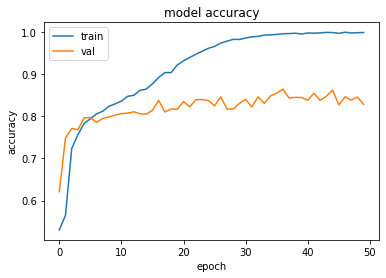

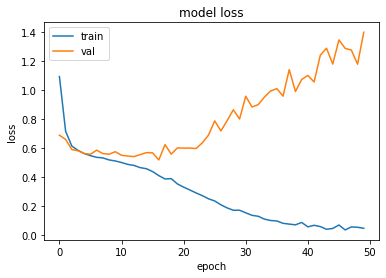

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.55679190158844 , AUC = 0.8035135269165039 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8375420875420875
test 0.8147661021120803

-----------------------------------------------------------------


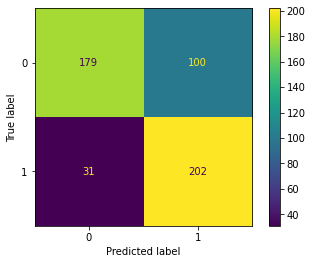

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5354291725973142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5436179140917068
134/134 - 16s - loss: 1.0467 - auc: 0.5086 - val_loss: 0.7702 - val_auc: 0.5356 - 16s/epoch - 119ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7044835695278173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6852063782711528
134/134 - 14s - loss: 0.7166 - auc: 0.5629 - val_loss: 0.6799 - val_auc: 0.7042 - 14s/epoch - 108ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7967077170616994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7637140459296559
134/134 - 14s - loss: 0.6199 - auc: 0.7109 - val_loss: 0.5420 - val_auc: 0.7965 - 14s/epoch - 107ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8207655176681724


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7844815747310596
134/134 - 14s - loss: 0.5803 - auc: 0.7593 - val_loss: 0.5580 - val_auc: 0.8210 - 14s/epoch - 106ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8259483878952905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7795071335927367
134/134 - 14s - loss: 0.5618 - auc: 0.7806 - val_loss: 0.5500 - val_auc: 0.8258 - 14s/epoch - 106ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8317655795531902


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7955748836499581
134/134 - 14s - loss: 0.5447 - auc: 0.7976 - val_loss: 0.5475 - val_auc: 0.8316 - 14s/epoch - 104ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8224673556531963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7931029221026933
134/134 - 14s - loss: 0.5396 - auc: 0.8015 - val_loss: 0.5217 - val_auc: 0.8225 - 14s/epoch - 106ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8248344575778204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7819943541618982
134/134 - 14s - loss: 0.5251 - auc: 0.8142 - val_loss: 0.5135 - val_auc: 0.8245 - 14s/epoch - 106ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8328949811250695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7909514000152591
134/134 - 14s - loss: 0.5207 - auc: 0.8201 - val_loss: 0.5092 - val_auc: 0.8329 - 14s/epoch - 108ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8367627947273963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7821316853589685
134/134 - 14s - loss: 0.5057 - auc: 0.8285 - val_loss: 0.5048 - val_auc: 0.8369 - 14s/epoch - 106ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8476390865771397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7937895780880445
134/134 - 14s - loss: 0.4908 - auc: 0.8417 - val_loss: 0.4888 - val_auc: 0.8478 - 14s/epoch - 106ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8489386719475215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8014648661020829
134/134 - 14s - loss: 0.4744 - auc: 0.8535 - val_loss: 0.4955 - val_auc: 0.8490 - 14s/epoch - 105ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8363450708583453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7951628900587472
134/134 - 14s - loss: 0.4631 - auc: 0.8614 - val_loss: 0.5039 - val_auc: 0.8365 - 14s/epoch - 105ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.831409740701776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7791561760891126
134/134 - 14s - loss: 0.4468 - auc: 0.8711 - val_loss: 0.5287 - val_auc: 0.8313 - 14s/epoch - 105ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8317501082987808


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8002441443503472
134/134 - 14s - loss: 0.4362 - auc: 0.8770 - val_loss: 0.5281 - val_auc: 0.8316 - 14s/epoch - 106ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.841218515997277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7972075989929046
134/134 - 14s - loss: 0.4169 - auc: 0.8884 - val_loss: 0.5053 - val_auc: 0.8410 - 14s/epoch - 107ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8484745343152422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7980621042191196
134/134 - 14s - loss: 0.4001 - auc: 0.8967 - val_loss: 0.4888 - val_auc: 0.8486 - 14s/epoch - 105ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8440806980629989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7976195925841154
134/134 - 14s - loss: 0.3762 - auc: 0.9090 - val_loss: 0.5548 - val_auc: 0.8436 - 14s/epoch - 106ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.844838789529055


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206301976043334
134/134 - 14s - loss: 0.3632 - auc: 0.9157 - val_loss: 0.4986 - val_auc: 0.8448 - 14s/epoch - 104ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8427346989293891


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8199130235751888
134/134 - 14s - loss: 0.3379 - auc: 0.9283 - val_loss: 0.5633 - val_auc: 0.8426 - 14s/epoch - 106ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8482115229902839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8292820630197605
134/134 - 14s - loss: 0.3163 - auc: 0.9364 - val_loss: 0.5331 - val_auc: 0.8476 - 14s/epoch - 106ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8002196918126122


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8146334019989319
134/134 - 14s - loss: 0.2886 - auc: 0.9479 - val_loss: 0.7045 - val_auc: 0.7996 - 14s/epoch - 105ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8478402128844607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8329594872968643
134/134 - 14s - loss: 0.2658 - auc: 0.9557 - val_loss: 0.5841 - val_auc: 0.8448 - 14s/epoch - 105ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8212760690636797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.840512703135729
134/134 - 14s - loss: 0.2430 - auc: 0.9629 - val_loss: 0.5398 - val_auc: 0.8210 - 14s/epoch - 106ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8223281143635126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.833722438391699
134/134 - 14s - loss: 0.2259 - auc: 0.9682 - val_loss: 0.7317 - val_auc: 0.8208 - 14s/epoch - 105ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.838093322606597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8236667429617761
134/134 - 14s - loss: 0.1939 - auc: 0.9770 - val_loss: 0.6005 - val_auc: 0.8369 - 14s/epoch - 105ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8261959279658395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8412909132524604
134/134 - 14s - loss: 0.1896 - auc: 0.9776 - val_loss: 0.7019 - val_auc: 0.8244 - 14s/epoch - 105ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8476700290859583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8396887159533073
134/134 - 14s - loss: 0.1724 - auc: 0.9817 - val_loss: 0.6998 - val_auc: 0.8458 - 14s/epoch - 104ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8414196423045981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8324788281071183
134/134 - 14s - loss: 0.1577 - auc: 0.9846 - val_loss: 0.7752 - val_auc: 0.8388 - 14s/epoch - 105ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8569527817315428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8425879301136797
134/134 - 14s - loss: 0.1247 - auc: 0.9901 - val_loss: 0.8530 - val_auc: 0.8550 - 14s/epoch - 105ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8400427006621696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.835690852216373
134/134 - 14s - loss: 0.1163 - auc: 0.9916 - val_loss: 0.8468 - val_auc: 0.8384 - 14s/epoch - 105ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8625688470821213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8545815213244831
134/134 - 14s - loss: 0.1155 - auc: 0.9915 - val_loss: 0.8619 - val_auc: 0.8607 - 14s/epoch - 104ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8457515935392041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8414435034714274
134/134 - 14s - loss: 0.1018 - auc: 0.9934 - val_loss: 0.9637 - val_auc: 0.8417 - 14s/epoch - 106ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.848234729871898


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8448004882887007
134/134 - 14s - loss: 0.0937 - auc: 0.9942 - val_loss: 0.8709 - val_auc: 0.8416 - 14s/epoch - 103ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8643635125936011


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8404211490043488
134/134 - 14s - loss: 0.0833 - auc: 0.9953 - val_loss: 0.8760 - val_auc: 0.8638 - 14s/epoch - 104ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.839454792994616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8239719233997101
134/134 - 14s - loss: 0.0697 - auc: 0.9966 - val_loss: 0.9842 - val_auc: 0.8333 - 14s/epoch - 104ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8561637477566681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8601815823605707
134/134 - 14s - loss: 0.0768 - auc: 0.9957 - val_loss: 0.8796 - val_auc: 0.8533 - 14s/epoch - 104ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8584070796460177


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8600442511635005
134/134 - 14s - loss: 0.0590 - auc: 0.9978 - val_loss: 0.9982 - val_auc: 0.8543 - 14s/epoch - 104ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8597066650163995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.847150377660792
134/134 - 14s - loss: 0.0667 - auc: 0.9967 - val_loss: 0.8406 - val_auc: 0.8564 - 14s/epoch - 105ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8536574045423604


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8586709391927978
134/134 - 14s - loss: 0.0519 - auc: 0.9984 - val_loss: 1.1685 - val_auc: 0.8409 - 14s/epoch - 104ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8443050312519339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8559090562294958
134/134 - 14s - loss: 0.0578 - auc: 0.9976 - val_loss: 1.1969 - val_auc: 0.8371 - 14s/epoch - 104ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8666687295005879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8526970321202412
134/134 - 14s - loss: 0.0464 - auc: 0.9985 - val_loss: 1.0329 - val_auc: 0.8536 - 14s/epoch - 105ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8659415805433505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8556801709010453
134/134 - 14s - loss: 0.0507 - auc: 0.9981 - val_loss: 0.9494 - val_auc: 0.8621 - 14s/epoch - 104ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8506946593229778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8471808957045854
134/134 - 14s - loss: 0.0530 - auc: 0.9979 - val_loss: 1.0563 - val_auc: 0.8447 - 14s/epoch - 105ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8676047403923509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8533684290836958
134/134 - 14s - loss: 0.0317 - auc: 0.9989 - val_loss: 1.2162 - val_auc: 0.8593 - 14s/epoch - 105ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8738628628009157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8593957427328909
134/134 - 14s - loss: 0.0531 - auc: 0.9976 - val_loss: 1.1573 - val_auc: 0.8635 - 14s/epoch - 105ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8414196423045981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8581368734264133
134/134 - 14s - loss: 0.0416 - auc: 0.9983 - val_loss: 1.4913 - val_auc: 0.8271 - 14s/epoch - 104ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8463240299523486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8475928892957961
134/134 - 14s - loss: 0.0389 - auc: 0.9989 - val_loss: 1.3850 - val_auc: 0.8316 - 14s/epoch - 105ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8602172164119066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8618677042801557
134/134 - 14s - loss: 0.0344 - auc: 0.9988 - val_loss: 1.2552 - val_auc: 0.8515 - 14s/epoch - 104ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8387585865461971


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8405737392233158
134/134 - 14s - loss: 0.0290 - auc: 0.9995 - val_loss: 1.3755 - val_auc: 0.8305 - 14s/epoch - 104ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


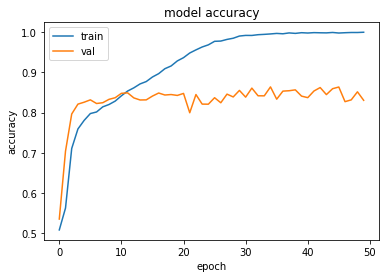

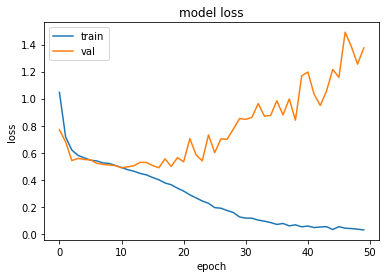

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.336251139640808 , AUC = 0.8198518753051758 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8387585865461971
test 0.8405737392233158

-----------------------------------------------------------------


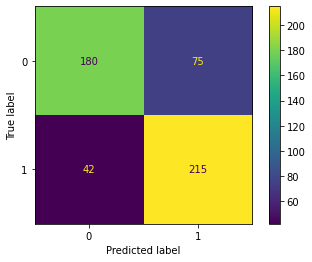

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6080744106353358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5849445812807882
134/134 - 16s - loss: 1.0478 - auc: 0.5290 - val_loss: 0.7686 - val_auc: 0.6077 - 16s/epoch - 117ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7963498401334006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.726262315270936
134/134 - 14s - loss: 0.6626 - auc: 0.6455 - val_loss: 0.5566 - val_auc: 0.7963 - 14s/epoch - 106ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8265944589777716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.771551724137931
134/134 - 14s - loss: 0.6045 - auc: 0.7394 - val_loss: 0.5307 - val_auc: 0.8272 - 14s/epoch - 105ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8375021035078862


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7812807881773399
134/134 - 14s - loss: 0.5749 - auc: 0.7666 - val_loss: 0.5513 - val_auc: 0.8373 - 14s/epoch - 105ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8234736181865466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7391317733990148
134/134 - 14s - loss: 0.5598 - auc: 0.7818 - val_loss: 0.5443 - val_auc: 0.8234 - 14s/epoch - 103ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8504597120871388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7859298029556651
134/134 - 14s - loss: 0.5587 - auc: 0.7861 - val_loss: 0.5204 - val_auc: 0.8505 - 14s/epoch - 104ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8444016093747609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7744304187192118
134/134 - 14s - loss: 0.5499 - auc: 0.7934 - val_loss: 0.5026 - val_auc: 0.8443 - 14s/epoch - 104ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8542842718803065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7853294334975368
134/134 - 14s - loss: 0.5345 - auc: 0.8060 - val_loss: 0.5257 - val_auc: 0.8542 - 14s/epoch - 103ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8471093977083237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7806650246305418
134/134 - 14s - loss: 0.5308 - auc: 0.8088 - val_loss: 0.5168 - val_auc: 0.8473 - 14s/epoch - 104ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8570991478880781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7932573891625615
134/134 - 14s - loss: 0.5057 - auc: 0.8322 - val_loss: 0.4727 - val_auc: 0.8570 - 14s/epoch - 105ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8638915660807441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7824199507389162
134/134 - 14s - loss: 0.5051 - auc: 0.8315 - val_loss: 0.4677 - val_auc: 0.8641 - 14s/epoch - 106ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.821132987593128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.77814039408867
134/134 - 14s - loss: 0.4878 - auc: 0.8440 - val_loss: 0.5393 - val_auc: 0.8213 - 14s/epoch - 104ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8808726115624093


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8003540640394089
134/134 - 14s - loss: 0.4785 - auc: 0.8507 - val_loss: 0.4421 - val_auc: 0.8808 - 14s/epoch - 106ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8409289090825646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.780603448275862
134/134 - 14s - loss: 0.4595 - auc: 0.8628 - val_loss: 0.5026 - val_auc: 0.8408 - 14s/epoch - 105ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8758241926354277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7967672413793103
134/134 - 14s - loss: 0.4429 - auc: 0.8722 - val_loss: 0.4543 - val_auc: 0.8759 - 14s/epoch - 105ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8682821607233008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7723522167487685
134/134 - 14s - loss: 0.4212 - auc: 0.8834 - val_loss: 0.4841 - val_auc: 0.8683 - 14s/epoch - 105ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8678997047439839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7876693349753694
134/134 - 14s - loss: 0.4118 - auc: 0.8897 - val_loss: 0.4733 - val_auc: 0.8683 - 14s/epoch - 105ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8773693147918674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8116379310344828
134/134 - 14s - loss: 0.3872 - auc: 0.9040 - val_loss: 0.4397 - val_auc: 0.8775 - 14s/epoch - 106ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8759159820704637


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8157173645320198
134/134 - 14s - loss: 0.3558 - auc: 0.9186 - val_loss: 0.4588 - val_auc: 0.8758 - 14s/epoch - 107ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8552786574265302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8307419950738917
134/134 - 14s - loss: 0.3378 - auc: 0.9270 - val_loss: 0.5218 - val_auc: 0.8544 - 14s/epoch - 106ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8671194945461778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7929033251231528
134/134 - 14s - loss: 0.3332 - auc: 0.9294 - val_loss: 0.4772 - val_auc: 0.8671 - 14s/epoch - 105ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8720914222772959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8110221674876846
134/134 - 14s - loss: 0.2958 - auc: 0.9446 - val_loss: 0.4969 - val_auc: 0.8718 - 14s/epoch - 106ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8397356464270963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7848214285714286
134/134 - 14s - loss: 0.2713 - auc: 0.9539 - val_loss: 0.5879 - val_auc: 0.8393 - 14s/epoch - 106ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8621169703367142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8265086206896552
134/134 - 14s - loss: 0.2626 - auc: 0.9573 - val_loss: 0.4912 - val_auc: 0.8620 - 14s/epoch - 105ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8751357718726575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8223060344827586
134/134 - 14s - loss: 0.2267 - auc: 0.9683 - val_loss: 0.5708 - val_auc: 0.8755 - 14s/epoch - 106ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8218214083558982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7465440270935961
134/134 - 14s - loss: 0.2034 - auc: 0.9745 - val_loss: 0.8022 - val_auc: 0.8213 - 14s/epoch - 107ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8652378111279392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8073429802955665
134/134 - 14s - loss: 0.2012 - auc: 0.9747 - val_loss: 0.6740 - val_auc: 0.8649 - 14s/epoch - 105ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8657273547814647


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8591286945812807
134/134 - 14s - loss: 0.1954 - auc: 0.9761 - val_loss: 0.6513 - val_auc: 0.8626 - 14s/epoch - 105ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8654519864763566


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8061730295566503
134/134 - 14s - loss: 0.1626 - auc: 0.9836 - val_loss: 0.5849 - val_auc: 0.8650 - 14s/epoch - 105ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8656355653464286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7963516009852217
134/134 - 14s - loss: 0.1467 - auc: 0.9865 - val_loss: 0.6650 - val_auc: 0.8658 - 14s/epoch - 107ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8677620205914299


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8207743226600984
134/134 - 14s - loss: 0.1286 - auc: 0.9894 - val_loss: 0.6372 - val_auc: 0.8649 - 14s/epoch - 106ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.854911499686386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8017318349753695
134/134 - 14s - loss: 0.1297 - auc: 0.9895 - val_loss: 0.7454 - val_auc: 0.8517 - 14s/epoch - 106ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8958342894732816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8299261083743842
134/134 - 14s - loss: 0.1138 - auc: 0.9917 - val_loss: 0.6845 - val_auc: 0.8919 - 14s/epoch - 105ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8683739501583368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8000923645320197
134/134 - 14s - loss: 0.1060 - auc: 0.9929 - val_loss: 0.7316 - val_auc: 0.8654 - 14s/epoch - 105ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8788685422307894


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8107912561576354
134/134 - 14s - loss: 0.0979 - auc: 0.9939 - val_loss: 0.7145 - val_auc: 0.8759 - 14s/epoch - 107ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8121835176771153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.774661330049261
134/134 - 14s - loss: 0.0845 - auc: 0.9953 - val_loss: 1.2832 - val_auc: 0.8110 - 14s/epoch - 106ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8897914850000765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8197660098522168
134/134 - 14s - loss: 0.0985 - auc: 0.9935 - val_loss: 0.6396 - val_auc: 0.8815 - 14s/epoch - 106ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8818975935869782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7955126231527094
134/134 - 14s - loss: 0.0626 - auc: 0.9969 - val_loss: 0.8029 - val_auc: 0.8731 - 14s/epoch - 105ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8521119219177873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7890625
134/134 - 14s - loss: 0.0720 - auc: 0.9961 - val_loss: 1.1059 - val_auc: 0.8423 - 14s/epoch - 105ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8695672128138051


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8193503694581281
134/134 - 14s - loss: 0.0640 - auc: 0.9973 - val_loss: 0.8530 - val_auc: 0.8636 - 14s/epoch - 106ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8948552021662306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8378232758620691
134/134 - 14s - loss: 0.0714 - auc: 0.9963 - val_loss: 0.7653 - val_auc: 0.8870 - 14s/epoch - 105ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8715330365474934


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8070966748768473
134/134 - 14s - loss: 0.0637 - auc: 0.9973 - val_loss: 0.8409 - val_auc: 0.8684 - 14s/epoch - 105ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.866668196490584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8229217980295567
134/134 - 14s - loss: 0.0587 - auc: 0.9974 - val_loss: 0.9395 - val_auc: 0.8599 - 14s/epoch - 104ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8930806064222008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8425800492610838
134/134 - 14s - loss: 0.0553 - auc: 0.9976 - val_loss: 1.0484 - val_auc: 0.8771 - 14s/epoch - 106ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8583841999785824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8150246305418718
134/134 - 14s - loss: 0.0570 - auc: 0.9975 - val_loss: 1.2899 - val_auc: 0.8376 - 14s/epoch - 104ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8874967491241759


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.841879618226601
134/134 - 14s - loss: 0.0455 - auc: 0.9985 - val_loss: 0.9824 - val_auc: 0.8815 - 14s/epoch - 106ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.858621322685759


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8108143472906404
134/134 - 14s - loss: 0.0453 - auc: 0.9980 - val_loss: 1.0424 - val_auc: 0.8480 - 14s/epoch - 105ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8637768292869492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8309575123152708
134/134 - 14s - loss: 0.0500 - auc: 0.9980 - val_loss: 1.0149 - val_auc: 0.8539 - 14s/epoch - 106ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8936083956736581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8334051724137931
134/134 - 14s - loss: 0.0444 - auc: 0.9984 - val_loss: 0.8268 - val_auc: 0.8891 - 14s/epoch - 105ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8727951412792389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.805295566502463
134/134 - 14s - loss: 0.0501 - auc: 0.9981 - val_loss: 0.9682 - val_auc: 0.8597 - 14s/epoch - 105ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


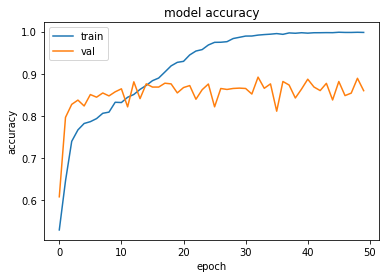

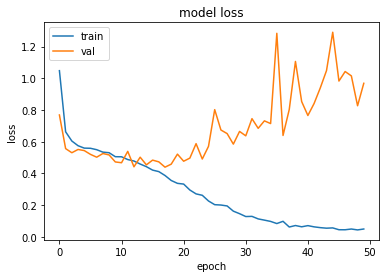

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.4007378816604614 , AUC = 0.7937345504760742 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8727951412792389
test 0.805295566502463

-----------------------------------------------------------------


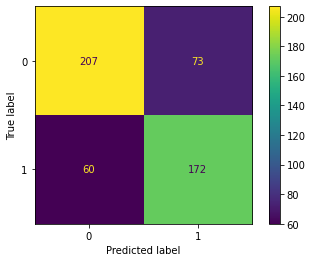

In [ ]:
# Create directory to save models
rt_sv_dir = '/content/models/500'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.8*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.8*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.8*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.8*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 512
acc:  0.8203125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.39628565311431885 , AUC = 0.9046182036399841 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9233099270273992
test 0.9047259852216749

-----------------------------------------------------------------


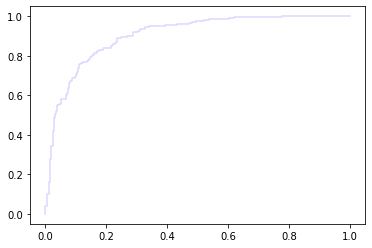

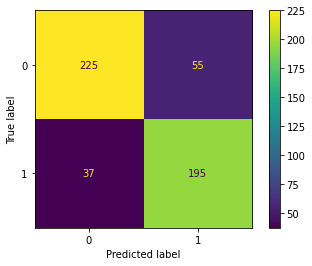

1
Num_samples: 512
acc:  0.845703125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.3282676339149475 , AUC = 0.9343289136886597 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9529426163048633
test 0.9341902709359606

-----------------------------------------------------------------


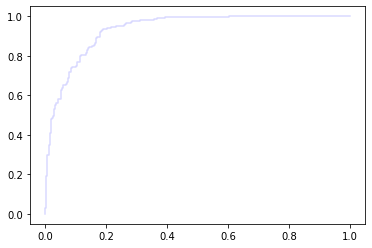

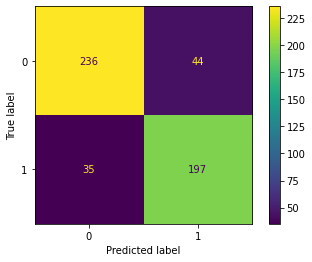

2
Num_samples: 512
acc:  0.8203125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.409772664308548 , AUC = 0.8977062702178955 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.918475683448835
test 0.8978756157635468

-----------------------------------------------------------------


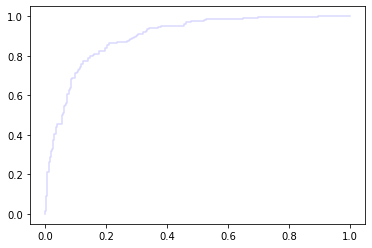

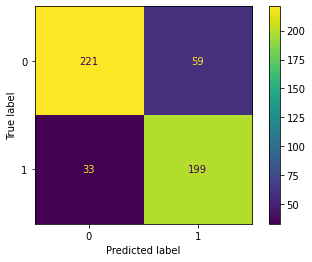

3
Num_samples: 512
acc:  0.73046875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.530534029006958 , AUC = 0.8276861906051636 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8973182186730307
test 0.8278017241379311

-----------------------------------------------------------------


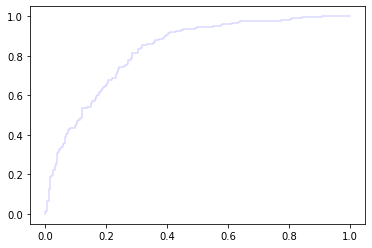

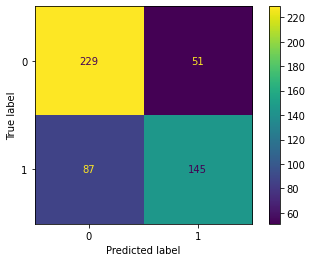

4
Num_samples: 512
acc:  0.744140625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5533314943313599 , AUC = 0.811568558216095 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8773693147918674
test 0.8116379310344828

-----------------------------------------------------------------


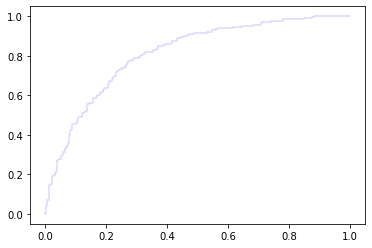

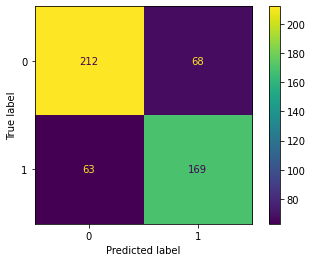

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


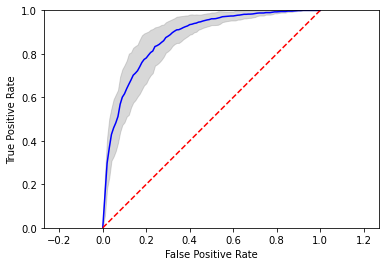

In [ ]:

# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/500/0/017--0.495--0.401.hdf5',
          1: '/content/models/500/1/023--0.454--0.339.hdf5',
          2: '/content/models/500/2/017--0.516--0.408.hdf5',
          3: '/content/models/500/3/011--0.489--0.491.hdf5',
          4: '/content/models/500/4/018--0.440--0.387.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  
  MERGM_Record1 = model.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = model.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = model.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

  


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

**50 epoch**

rm: cannot remove '/content/models/50': No such file or directory
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6072718848419958


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5855863269504669
134/134 - 18s - loss: 1.0769 - auc: 0.4939 - val_loss: 0.6950 - val_auc: 0.6053 - 18s/epoch - 133ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7664218494655972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7520873555942396
134/134 - 16s - loss: 0.7006 - auc: 0.5694 - val_loss: 0.6464 - val_auc: 0.7661 - 16s/epoch - 122ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.796081672520991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7827947460041146
134/134 - 16s - loss: 0.6059 - auc: 0.7247 - val_loss: 0.6347 - val_auc: 0.7959 - 16s/epoch - 120ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8227110217830957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8090140845070422
134/134 - 16s - loss: 0.5743 - auc: 0.7649 - val_loss: 0.6401 - val_auc: 0.8225 - 16s/epoch - 120ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8357783746892825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8261940180408293
134/134 - 16s - loss: 0.5704 - auc: 0.7721 - val_loss: 0.5121 - val_auc: 0.8360 - 16s/epoch - 122ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.831658433044687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8230985915492958
134/134 - 16s - loss: 0.5651 - auc: 0.7805 - val_loss: 0.6143 - val_auc: 0.8317 - 16s/epoch - 120ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8501386880052094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.827232156986865
134/134 - 17s - loss: 0.5464 - auc: 0.7958 - val_loss: 0.5067 - val_auc: 0.8499 - 17s/epoch - 123ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8366862645653713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8305174869441369
134/134 - 16s - loss: 0.5264 - auc: 0.8145 - val_loss: 0.5187 - val_auc: 0.8369 - 16s/epoch - 122ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8550506853003237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8485583161892706
134/134 - 16s - loss: 0.5243 - auc: 0.8162 - val_loss: 0.4801 - val_auc: 0.8550 - 16s/epoch - 122ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8606796025320737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8536920398797279
134/134 - 16s - loss: 0.5136 - auc: 0.8249 - val_loss: 0.4716 - val_auc: 0.8606 - 16s/epoch - 122ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8735090256776301


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8537616711504984
134/134 - 16s - loss: 0.5017 - auc: 0.8339 - val_loss: 0.5017 - val_auc: 0.8735 - 16s/epoch - 121ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8735841613915134


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8591865801550878
134/134 - 16s - loss: 0.4932 - auc: 0.8397 - val_loss: 0.4509 - val_auc: 0.8736 - 16s/epoch - 122ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8794384857649129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8664915334704858
134/134 - 16s - loss: 0.4738 - auc: 0.8539 - val_loss: 0.4452 - val_auc: 0.8794 - 16s/epoch - 122ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.880615611949083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8679094793479981
134/134 - 16s - loss: 0.4514 - auc: 0.8665 - val_loss: 0.4553 - val_auc: 0.8807 - 16s/epoch - 121ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8968198809098935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8825763570185157
134/134 - 17s - loss: 0.4424 - auc: 0.8719 - val_loss: 0.4163 - val_auc: 0.8968 - 17s/epoch - 124ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8985730475671682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8690489001424275
134/134 - 17s - loss: 0.4196 - auc: 0.8871 - val_loss: 0.4453 - val_auc: 0.8984 - 17s/epoch - 124ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9188283837681812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8887735401171072
134/134 - 17s - loss: 0.3986 - auc: 0.8984 - val_loss: 0.3739 - val_auc: 0.9188 - 17s/epoch - 125ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9236182855282354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8977306535844279
134/134 - 16s - loss: 0.3676 - auc: 0.9119 - val_loss: 0.3570 - val_auc: 0.9237 - 16s/epoch - 122ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9238624765983557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9090805507200507
134/134 - 16s - loss: 0.3467 - auc: 0.9230 - val_loss: 0.3552 - val_auc: 0.9238 - 16s/epoch - 120ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9392715592539024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9129355910745371
134/134 - 17s - loss: 0.3297 - auc: 0.9295 - val_loss: 0.3361 - val_auc: 0.9393 - 17s/epoch - 123ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9368233872432081


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9148726064250672
134/134 - 16s - loss: 0.3076 - auc: 0.9404 - val_loss: 0.3304 - val_auc: 0.9369 - 16s/epoch - 121ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9453199842215001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.924025953473651
134/134 - 17s - loss: 0.2973 - auc: 0.9449 - val_loss: 0.3061 - val_auc: 0.9452 - 17s/epoch - 124ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9436983050635209


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9225890172495648
134/134 - 16s - loss: 0.2509 - auc: 0.9607 - val_loss: 0.3013 - val_auc: 0.9438 - 16s/epoch - 123ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9558014163082067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.939895553093844
134/134 - 16s - loss: 0.2314 - auc: 0.9666 - val_loss: 0.2673 - val_auc: 0.9556 - 16s/epoch - 121ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9554257377387906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9306599145434404
134/134 - 16s - loss: 0.2344 - auc: 0.9654 - val_loss: 0.2844 - val_auc: 0.9555 - 16s/epoch - 121ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9659259537539681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9416743155562589
134/134 - 16s - loss: 0.1874 - auc: 0.9780 - val_loss: 0.2438 - val_auc: 0.9657 - 16s/epoch - 121ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.974347415018377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9510555467637285
134/134 - 16s - loss: 0.1730 - auc: 0.9815 - val_loss: 0.2144 - val_auc: 0.9748 - 16s/epoch - 121ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9655878430414936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9412501978161102
134/134 - 16s - loss: 0.1762 - auc: 0.9807 - val_loss: 0.2622 - val_auc: 0.9657 - 16s/epoch - 119ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9658382954211043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9455103655641717
134/134 - 16s - loss: 0.1536 - auc: 0.9853 - val_loss: 0.2484 - val_auc: 0.9650 - 16s/epoch - 118ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9568971454690035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9243677797119798
134/134 - 16s - loss: 0.1488 - auc: 0.9858 - val_loss: 0.3245 - val_auc: 0.9561 - 16s/epoch - 118ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9683584724909368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9448741889539486
134/134 - 16s - loss: 0.1244 - auc: 0.9901 - val_loss: 0.3063 - val_auc: 0.9674 - 16s/epoch - 119ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9638158924557482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.950593448330432
134/134 - 16s - loss: 0.1101 - auc: 0.9922 - val_loss: 0.2895 - val_auc: 0.9629 - 16s/epoch - 118ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9817670667643431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.96420319670834
134/134 - 16s - loss: 0.1028 - auc: 0.9933 - val_loss: 0.1775 - val_auc: 0.9818 - 16s/epoch - 122ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9681737638609739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.948792530463681
134/134 - 16s - loss: 0.0764 - auc: 0.9963 - val_loss: 0.3071 - val_auc: 0.9661 - 16s/epoch - 121ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9721277808040774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9546447222661814
134/134 - 16s - loss: 0.0875 - auc: 0.9947 - val_loss: 0.2900 - val_auc: 0.9693 - 16s/epoch - 122ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9733800427021306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.962310492166482
134/134 - 16s - loss: 0.0686 - auc: 0.9964 - val_loss: 0.2709 - val_auc: 0.9693 - 16s/epoch - 121ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9804208852239358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9619021997151447
134/134 - 16s - loss: 0.0726 - auc: 0.9960 - val_loss: 0.2411 - val_auc: 0.9777 - 16s/epoch - 120ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9682175930274057


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9522392783668303
134/134 - 16s - loss: 0.0747 - auc: 0.9961 - val_loss: 0.2855 - val_auc: 0.9666 - 16s/epoch - 119ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9601592877134324


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9432188637442633
134/134 - 16s - loss: 0.0725 - auc: 0.9963 - val_loss: 0.4114 - val_auc: 0.9537 - 16s/epoch - 119ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9662765870854231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9561956005697104
134/134 - 16s - loss: 0.0736 - auc: 0.9959 - val_loss: 0.3531 - val_auc: 0.9612 - 16s/epoch - 120ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9771712655984872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9598828928627947
134/134 - 16s - loss: 0.0776 - auc: 0.9956 - val_loss: 0.2524 - val_auc: 0.9771 - 16s/epoch - 120ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9828252280681982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9628548821015984
134/134 - 16s - loss: 0.0599 - auc: 0.9977 - val_loss: 0.2045 - val_auc: 0.9819 - 16s/epoch - 121ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9835202334216178


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9678081974996043
134/134 - 16s - loss: 0.0377 - auc: 0.9989 - val_loss: 0.2095 - val_auc: 0.9812 - 16s/epoch - 121ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9805993325444083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9577939547396739
134/134 - 16s - loss: 0.0369 - auc: 0.9989 - val_loss: 0.2340 - val_auc: 0.9794 - 16s/epoch - 120ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9797321411800064


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9549169172337394
134/134 - 16s - loss: 0.0477 - auc: 0.9984 - val_loss: 0.2384 - val_auc: 0.9773 - 16s/epoch - 120ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9784610953534821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9613736350688401
134/134 - 16s - loss: 0.0456 - auc: 0.9984 - val_loss: 0.2270 - val_auc: 0.9763 - 16s/epoch - 121ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9801735634990703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9561101440101282
134/134 - 16s - loss: 0.0367 - auc: 0.9987 - val_loss: 0.2678 - val_auc: 0.9763 - 16s/epoch - 119ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9799794629048719


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.956743155562589
134/134 - 16s - loss: 0.0460 - auc: 0.9979 - val_loss: 0.2472 - val_auc: 0.9764 - 16s/epoch - 119ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9785550149958362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9581705966133882
134/134 - 16s - loss: 0.0508 - auc: 0.9975 - val_loss: 0.2312 - val_auc: 0.9773 - 16s/epoch - 118ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9829974140791805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9648077227409401
134/134 - 16s - loss: 0.0469 - auc: 0.9981 - val_loss: 0.1978 - val_auc: 0.9831 - 16s/epoch - 119ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


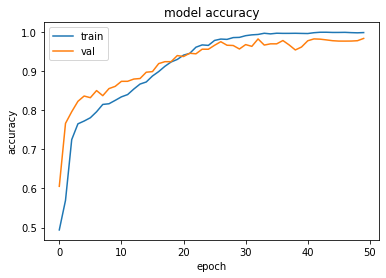

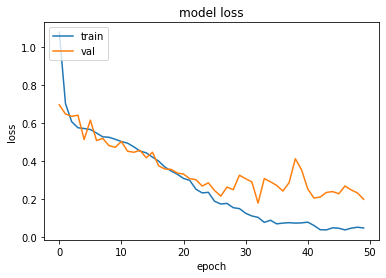

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.34136635065078735 , AUC = 0.9627599716186523 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9829974140791805
test 0.9648077227409401

-----------------------------------------------------------------


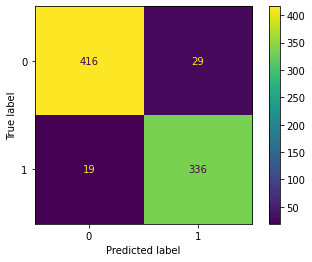

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.4090311294976889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.44789479988148595
134/134 - 18s - loss: 1.1839 - auc: 0.5128 - val_loss: 0.7927 - val_auc: 0.4073 - 18s/epoch - 132ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6611443090988023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6194249547692443
134/134 - 16s - loss: 0.7215 - auc: 0.5482 - val_loss: 0.6887 - val_auc: 0.6617 - 16s/epoch - 122ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8198370744911769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7758508740410133
134/134 - 16s - loss: 0.6731 - auc: 0.6224 - val_loss: 0.5339 - val_auc: 0.8205 - 16s/epoch - 121ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8374894660231363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7971770965322036
134/134 - 16s - loss: 0.5973 - auc: 0.7413 - val_loss: 0.5307 - val_auc: 0.8376 - 16s/epoch - 121ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8612771010495672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8085683126248968
134/134 - 16s - loss: 0.5889 - auc: 0.7533 - val_loss: 0.4757 - val_auc: 0.8615 - 16s/epoch - 119ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8551929313823131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8097345411678676
134/134 - 16s - loss: 0.5589 - auc: 0.7831 - val_loss: 0.5321 - val_auc: 0.8553 - 16s/epoch - 119ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8713961030669835


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8321450410071172
134/134 - 16s - loss: 0.5481 - auc: 0.7958 - val_loss: 0.4771 - val_auc: 0.8715 - 16s/epoch - 119ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8705661533747031


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8338155845956968
134/134 - 16s - loss: 0.5422 - auc: 0.8004 - val_loss: 0.4868 - val_auc: 0.8705 - 16s/epoch - 118ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8746712122372889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8237734112500078
134/134 - 16s - loss: 0.5299 - auc: 0.8117 - val_loss: 0.5048 - val_auc: 0.8746 - 16s/epoch - 119ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8804872443116525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8406490534636988
134/134 - 16s - loss: 0.5296 - auc: 0.8110 - val_loss: 0.4366 - val_auc: 0.8803 - 16s/epoch - 119ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8925215148497152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8378374970844287
134/134 - 16s - loss: 0.5016 - auc: 0.8344 - val_loss: 0.4933 - val_auc: 0.8922 - 16s/epoch - 119ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8805191654536633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.833544515258682
134/134 - 16s - loss: 0.4983 - auc: 0.8367 - val_loss: 0.6650 - val_auc: 0.8806 - 16s/epoch - 120ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8915128067621747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8611620679438445
134/134 - 16s - loss: 0.4842 - auc: 0.8470 - val_loss: 0.4829 - val_auc: 0.8917 - 16s/epoch - 120ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9030044178860543


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8808933941032964
134/134 - 16s - loss: 0.4691 - auc: 0.8576 - val_loss: 0.4183 - val_auc: 0.9031 - 16s/epoch - 120ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9092290405781558


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8904564681556569
134/134 - 16s - loss: 0.4519 - auc: 0.8679 - val_loss: 0.3897 - val_auc: 0.9092 - 16s/epoch - 120ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.921697438647565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9015703109732651
134/134 - 16s - loss: 0.4311 - auc: 0.8793 - val_loss: 0.3684 - val_auc: 0.9216 - 16s/epoch - 120ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9186713143849434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.892706974046687
134/134 - 16s - loss: 0.4134 - auc: 0.8899 - val_loss: 0.3851 - val_auc: 0.9185 - 16s/epoch - 118ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9337317091856279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9170716946876714
134/134 - 16s - loss: 0.3879 - auc: 0.9029 - val_loss: 0.3303 - val_auc: 0.9337 - 16s/epoch - 119ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9401414745013917


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9156028771173352
134/134 - 16s - loss: 0.3661 - auc: 0.9140 - val_loss: 0.3170 - val_auc: 0.9402 - 16s/epoch - 118ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9333103501110855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9253424614356589
134/134 - 16s - loss: 0.3441 - auc: 0.9243 - val_loss: 0.3335 - val_auc: 0.9329 - 16s/epoch - 119ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9457851324088971


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9425017808625048
134/134 - 16s - loss: 0.3188 - auc: 0.9351 - val_loss: 0.3076 - val_auc: 0.9458 - 16s/epoch - 120ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9428866927143186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9248759700184706
134/134 - 16s - loss: 0.2943 - auc: 0.9455 - val_loss: 0.3439 - val_auc: 0.9429 - 16s/epoch - 117ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9566830102913763


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9438319117952986
134/134 - 16s - loss: 0.2815 - auc: 0.9499 - val_loss: 0.2600 - val_auc: 0.9567 - 16s/epoch - 119ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9588217268060982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9480429424261336
134/134 - 16s - loss: 0.2516 - auc: 0.9599 - val_loss: 0.2516 - val_auc: 0.9582 - 16s/epoch - 118ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.952316198064302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9422433194016302
134/134 - 16s - loss: 0.2456 - auc: 0.9625 - val_loss: 0.2815 - val_auc: 0.9518 - 16s/epoch - 118ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9666615592839449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9687955065529436
134/134 - 16s - loss: 0.2040 - auc: 0.9734 - val_loss: 0.2422 - val_auc: 0.9661 - 16s/epoch - 119ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9660103679869251


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.971903348021509
134/134 - 16s - loss: 0.1954 - auc: 0.9760 - val_loss: 0.2291 - val_auc: 0.9662 - 16s/epoch - 119ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9588153425776961


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9649816240205257
134/134 - 16s - loss: 0.1898 - auc: 0.9777 - val_loss: 0.2609 - val_auc: 0.9588 - 16s/epoch - 119ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9551188743328481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9493289457924367
134/134 - 16s - loss: 0.1624 - auc: 0.9834 - val_loss: 0.3738 - val_auc: 0.9546 - 16s/epoch - 118ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.977763732475293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9743429720546425
134/134 - 16s - loss: 0.1500 - auc: 0.9855 - val_loss: 0.1884 - val_auc: 0.9766 - 16s/epoch - 120ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9683725324957225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9726030851472914
134/134 - 16s - loss: 0.1264 - auc: 0.9898 - val_loss: 0.2465 - val_auc: 0.9678 - 16s/epoch - 119ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9721519957097986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9752948667032295
134/134 - 16s - loss: 0.1204 - auc: 0.9906 - val_loss: 0.2141 - val_auc: 0.9702 - 16s/epoch - 119ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9793661738042341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.982557003359999
134/134 - 16s - loss: 0.0995 - auc: 0.9933 - val_loss: 0.2294 - val_auc: 0.9763 - 16s/epoch - 120ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9718583212032994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.971670102312915
134/134 - 16s - loss: 0.1040 - auc: 0.9926 - val_loss: 0.2831 - val_auc: 0.9710 - 16s/epoch - 119ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9513202584335658


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9645214365414074
134/134 - 16s - loss: 0.0930 - auc: 0.9942 - val_loss: 0.3932 - val_auc: 0.9480 - 16s/epoch - 119ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9758963456676626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9825948269884197
134/134 - 16s - loss: 0.0779 - auc: 0.9961 - val_loss: 0.2506 - val_auc: 0.9722 - 16s/epoch - 119ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.961975535636763


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9616216250291558
134/134 - 16s - loss: 0.0633 - auc: 0.9968 - val_loss: 0.3429 - val_auc: 0.9590 - 16s/epoch - 118ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9864079777318113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.982109423757021
134/134 - 16s - loss: 0.0741 - auc: 0.9959 - val_loss: 0.1477 - val_auc: 0.9854 - 16s/epoch - 119ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9858142444904109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9818635701722866
134/134 - 16s - loss: 0.0586 - auc: 0.9972 - val_loss: 0.1649 - val_auc: 0.9831 - 16s/epoch - 117ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9785234556551495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.976108074714274
134/134 - 16s - loss: 0.0725 - auc: 0.9959 - val_loss: 0.2052 - val_auc: 0.9768 - 16s/epoch - 122ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9801450496692969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9765682621933922
134/134 - 16s - loss: 0.0467 - auc: 0.9979 - val_loss: 0.2519 - val_auc: 0.9748 - 16s/epoch - 119ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.971430577900355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.973129463976146
134/134 - 16s - loss: 0.0524 - auc: 0.9982 - val_loss: 0.3550 - val_auc: 0.9655 - 16s/epoch - 120ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9827083173727624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9813939267860633
134/134 - 16s - loss: 0.0496 - auc: 0.9977 - val_loss: 0.2191 - val_auc: 0.9787 - 16s/epoch - 120ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9763081283996017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.977791226178994
134/134 - 16s - loss: 0.0599 - auc: 0.9964 - val_loss: 0.2812 - val_auc: 0.9707 - 16s/epoch - 119ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9752291937996375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.971342297533269
134/134 - 16s - loss: 0.0604 - auc: 0.9969 - val_loss: 0.2516 - val_auc: 0.9735 - 16s/epoch - 119ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.979774764421972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9805113754562477
134/134 - 16s - loss: 0.0549 - auc: 0.9978 - val_loss: 0.2960 - val_auc: 0.9717 - 16s/epoch - 118ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.981954978421308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9863834937685572
134/134 - 16s - loss: 0.0378 - auc: 0.9984 - val_loss: 0.2240 - val_auc: 0.9799 - 16s/epoch - 119ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9848534181158866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9845427438520844
134/134 - 16s - loss: 0.0387 - auc: 0.9985 - val_loss: 0.1798 - val_auc: 0.9824 - 16s/epoch - 118ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9774668658545929


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9816366284017626
134/134 - 16s - loss: 0.0467 - auc: 0.9987 - val_loss: 0.2494 - val_auc: 0.9757 - 16s/epoch - 118ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9760208381215046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9808927637094893
134/134 - 16s - loss: 0.0262 - auc: 0.9993 - val_loss: 0.2796 - val_auc: 0.9756 - 16s/epoch - 119ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


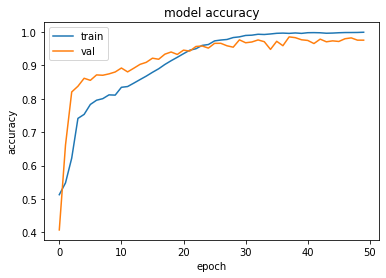

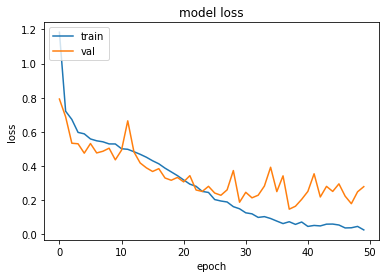

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.2373199313879013 , AUC = 0.9776179194450378 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9760208381215046
test 0.9808927637094893

-----------------------------------------------------------------


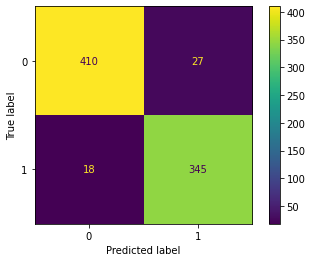

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6210107301391967


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6463197945639821
134/134 - 17s - loss: 1.0889 - auc: 0.5088 - val_loss: 0.6912 - val_auc: 0.6205 - 17s/epoch - 129ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7183605301655669


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7292601917486549
134/134 - 16s - loss: 0.7287 - auc: 0.5512 - val_loss: 0.6722 - val_auc: 0.7186 - 16s/epoch - 119ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.767465514751587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7856483603418073
134/134 - 16s - loss: 0.6690 - auc: 0.6503 - val_loss: 0.6067 - val_auc: 0.7674 - 16s/epoch - 120ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8045783601534491


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8099779620897714
134/134 - 16s - loss: 0.5857 - auc: 0.7583 - val_loss: 0.5698 - val_auc: 0.8045 - 16s/epoch - 119ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7757156042217352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7852998976587076
134/134 - 16s - loss: 0.5707 - auc: 0.7713 - val_loss: 0.6281 - val_auc: 0.7755 - 16s/epoch - 118ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7984567184233161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8064744994380646
134/134 - 16s - loss: 0.5630 - auc: 0.7798 - val_loss: 0.5501 - val_auc: 0.7984 - 16s/epoch - 121ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.817405554055666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8250026684079337
134/134 - 16s - loss: 0.5488 - auc: 0.7930 - val_loss: 0.5348 - val_auc: 0.8175 - 16s/epoch - 121ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.822164738087913


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.847109643312342
134/134 - 16s - loss: 0.5480 - auc: 0.7966 - val_loss: 0.5324 - val_auc: 0.8222 - 16s/epoch - 120ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8240483201587232


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8378738125584695
134/134 - 16s - loss: 0.5226 - auc: 0.8178 - val_loss: 0.5695 - val_auc: 0.8240 - 16s/epoch - 119ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8307852653653206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8387590961317503
134/134 - 16s - loss: 0.5159 - auc: 0.8231 - val_loss: 0.5404 - val_auc: 0.8311 - 16s/epoch - 119ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8471473149537581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8536205586704422
134/134 - 16s - loss: 0.5075 - auc: 0.8293 - val_loss: 0.5138 - val_auc: 0.8471 - 16s/epoch - 119ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8436124592675378


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8637479516044979
134/134 - 16s - loss: 0.4857 - auc: 0.8451 - val_loss: 0.5041 - val_auc: 0.8435 - 16s/epoch - 119ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8516804691375077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8637040013561791
134/134 - 16s - loss: 0.4756 - auc: 0.8535 - val_loss: 0.4814 - val_auc: 0.8517 - 16s/epoch - 119ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8720231555022572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8810957424766592
134/134 - 16s - loss: 0.4574 - auc: 0.8639 - val_loss: 0.4647 - val_auc: 0.8721 - 16s/epoch - 119ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8559562004382467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8559373646175386
134/134 - 16s - loss: 0.4461 - auc: 0.8693 - val_loss: 0.5025 - val_auc: 0.8557 - 16s/epoch - 120ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8518876631652968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8530115338008801
134/134 - 16s - loss: 0.4163 - auc: 0.8881 - val_loss: 0.5909 - val_auc: 0.8518 - 16s/epoch - 119ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9043203094097482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9004589661645874
134/134 - 16s - loss: 0.4075 - auc: 0.8929 - val_loss: 0.3981 - val_auc: 0.9043 - 16s/epoch - 120ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8795763196062059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8946324189588813
134/134 - 16s - loss: 0.3877 - auc: 0.9004 - val_loss: 0.4389 - val_auc: 0.8796 - 16s/epoch - 121ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8895027971193751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9076416924612767
134/134 - 16s - loss: 0.3706 - auc: 0.9122 - val_loss: 0.4407 - val_auc: 0.8897 - 16s/epoch - 118ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.916312448593906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9140521501089338
134/134 - 16s - loss: 0.3525 - auc: 0.9205 - val_loss: 0.3786 - val_auc: 0.9161 - 16s/epoch - 119ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9282543589228422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9351671051227155
134/134 - 16s - loss: 0.3208 - auc: 0.9341 - val_loss: 0.3590 - val_auc: 0.9279 - 16s/epoch - 119ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9212851052608447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9281476226054962
134/134 - 16s - loss: 0.3065 - auc: 0.9403 - val_loss: 0.4100 - val_auc: 0.9217 - 16s/epoch - 119ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.925661294272027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9363977120756446
134/134 - 16s - loss: 0.2705 - auc: 0.9540 - val_loss: 0.3825 - val_auc: 0.9260 - 16s/epoch - 118ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9438566970760529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9561753238191509
134/134 - 16s - loss: 0.2599 - auc: 0.9575 - val_loss: 0.3068 - val_auc: 0.9438 - 16s/epoch - 119ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9510017517313258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9450559109944685
134/134 - 16s - loss: 0.2327 - auc: 0.9658 - val_loss: 0.3068 - val_auc: 0.9509 - 16s/epoch - 118ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9299370255727659


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9439132045381772
134/134 - 16s - loss: 0.2148 - auc: 0.9713 - val_loss: 0.3745 - val_auc: 0.9297 - 16s/epoch - 119ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9398572244790325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9371762593315794
134/134 - 16s - loss: 0.1967 - auc: 0.9763 - val_loss: 0.3970 - val_auc: 0.9397 - 16s/epoch - 121ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9450747468151766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9599299307469659
134/134 - 16s - loss: 0.1928 - auc: 0.9772 - val_loss: 0.3465 - val_auc: 0.9455 - 16s/epoch - 119ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9618700202799003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9627427466393755
134/134 - 16s - loss: 0.1704 - auc: 0.9819 - val_loss: 0.2628 - val_auc: 0.9617 - 16s/epoch - 119ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9448047667183604


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9438284433449906
134/134 - 16s - loss: 0.1385 - auc: 0.9882 - val_loss: 0.4271 - val_auc: 0.9430 - 16s/epoch - 120ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9432539508133935


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.957788925793145
134/134 - 16s - loss: 0.1643 - auc: 0.9829 - val_loss: 0.3312 - val_auc: 0.9435 - 16s/epoch - 118ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9456147070088088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9609910153135223
134/134 - 16s - loss: 0.1241 - auc: 0.9902 - val_loss: 0.3883 - val_auc: 0.9431 - 16s/epoch - 119ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9623032441561866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9717337117240428
134/134 - 16s - loss: 0.1032 - auc: 0.9933 - val_loss: 0.2825 - val_auc: 0.9640 - 16s/epoch - 119ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9481952144458187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9716772042619183
134/134 - 16s - loss: 0.1031 - auc: 0.9928 - val_loss: 0.3849 - val_auc: 0.9424 - 16s/epoch - 118ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9703084679571297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9781441693716998
134/134 - 16s - loss: 0.0898 - auc: 0.9948 - val_loss: 0.2790 - val_auc: 0.9686 - 16s/epoch - 119ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9709551644681079


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9803856320359638
134/134 - 16s - loss: 0.0849 - auc: 0.9951 - val_loss: 0.2627 - val_auc: 0.9719 - 16s/epoch - 118ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9656999704905476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9771458708741704
134/134 - 16s - loss: 0.0893 - auc: 0.9939 - val_loss: 0.2995 - val_auc: 0.9650 - 16s/epoch - 118ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9696868858737623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9738935524985716
134/134 - 16s - loss: 0.0602 - auc: 0.9976 - val_loss: 0.3328 - val_auc: 0.9650 - 16s/epoch - 119ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.965721945614707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9791613036899371
134/134 - 16s - loss: 0.0762 - auc: 0.9958 - val_loss: 0.3275 - val_auc: 0.9630 - 16s/epoch - 119ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9724180798764369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9748604579615875
134/134 - 16s - loss: 0.0669 - auc: 0.9969 - val_loss: 0.2853 - val_auc: 0.9728 - 16s/epoch - 119ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9660452938701962


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9711686371027995
134/134 - 16s - loss: 0.0564 - auc: 0.9974 - val_loss: 0.3425 - val_auc: 0.9611 - 16s/epoch - 119ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9614587715277734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9689836819006599
134/134 - 16s - loss: 0.0562 - auc: 0.9974 - val_loss: 0.4117 - val_auc: 0.9596 - 16s/epoch - 119ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9711466619786401


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9832110051421791
134/134 - 16s - loss: 0.0729 - auc: 0.9960 - val_loss: 0.2981 - val_auc: 0.9715 - 16s/epoch - 118ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9738935524985716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9766875325702733
134/134 - 16s - loss: 0.0427 - auc: 0.9985 - val_loss: 0.3382 - val_auc: 0.9734 - 16s/epoch - 118ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9677279605201197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9762605873008897
134/134 - 16s - loss: 0.0479 - auc: 0.9978 - val_loss: 0.3240 - val_auc: 0.9657 - 16s/epoch - 121ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9685316222036655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9789038808069266
134/134 - 16s - loss: 0.0454 - auc: 0.9985 - val_loss: 0.3911 - val_auc: 0.9674 - 16s/epoch - 117ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9684876719553465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9742639903058309
134/134 - 16s - loss: 0.0332 - auc: 0.9991 - val_loss: 0.3590 - val_auc: 0.9622 - 16s/epoch - 119ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9699443087567732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9785303036962159
134/134 - 16s - loss: 0.0457 - auc: 0.9984 - val_loss: 0.3407 - val_auc: 0.9648 - 16s/epoch - 121ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9716520898343075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9795505773179046
134/134 - 16s - loss: 0.0376 - auc: 0.9989 - val_loss: 0.3525 - val_auc: 0.9695 - 16s/epoch - 118ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9714072241651022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9766027713770868
134/134 - 16s - loss: 0.0237 - auc: 0.9996 - val_loss: 0.3847 - val_auc: 0.9679 - 16s/epoch - 118ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


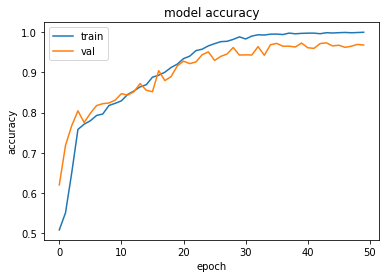

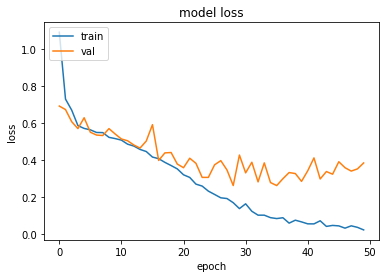

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.2933471202850342 , AUC = 0.9658538103103638 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9714072241651022
test 0.9766027713770868

-----------------------------------------------------------------


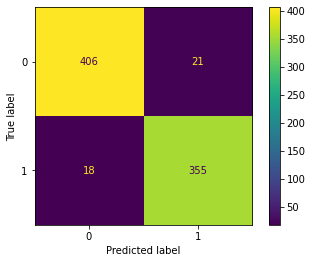

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5898294476607729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.58838871896872
134/134 - 18s - loss: 1.0602 - auc: 0.5292 - val_loss: 0.7606 - val_auc: 0.5900 - 18s/epoch - 131ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7636363636363636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7357188874086027
134/134 - 16s - loss: 0.6559 - auc: 0.6656 - val_loss: 0.5795 - val_auc: 0.7636 - 16s/epoch - 120ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8104834924112032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.76649215969577
134/134 - 16s - loss: 0.5889 - auc: 0.7505 - val_loss: 0.5831 - val_auc: 0.8100 - 16s/epoch - 119ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.82302613049601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7806653781922577
134/134 - 16s - loss: 0.5652 - auc: 0.7747 - val_loss: 0.5230 - val_auc: 0.8229 - 16s/epoch - 118ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8120419339696449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7852751143051933
134/134 - 16s - loss: 0.5541 - auc: 0.7880 - val_loss: 0.5682 - val_auc: 0.8118 - 16s/epoch - 118ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8190142387732748


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.796608685318272
134/134 - 16s - loss: 0.5558 - auc: 0.7875 - val_loss: 0.5507 - val_auc: 0.8189 - 16s/epoch - 117ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8374714442184321


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8022316877138336
134/134 - 16s - loss: 0.5418 - auc: 0.8013 - val_loss: 0.5099 - val_auc: 0.8374 - 16s/epoch - 120ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8384478172429981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7997172861976871
134/134 - 16s - loss: 0.5338 - auc: 0.8111 - val_loss: 0.5604 - val_auc: 0.8388 - 16s/epoch - 119ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8237959630730716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7989542091206474
134/134 - 16s - loss: 0.5182 - auc: 0.8202 - val_loss: 0.5292 - val_auc: 0.8236 - 16s/epoch - 117ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8505273040212799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8111321687025814
134/134 - 16s - loss: 0.5124 - auc: 0.8264 - val_loss: 0.5287 - val_auc: 0.8507 - 16s/epoch - 118ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8520669691754028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8187441752825574
134/134 - 16s - loss: 0.5030 - auc: 0.8337 - val_loss: 0.4909 - val_auc: 0.8520 - 16s/epoch - 119ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8563667657643561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8238042519655489
134/134 - 16s - loss: 0.4836 - auc: 0.8465 - val_loss: 0.4838 - val_auc: 0.8566 - 16s/epoch - 118ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8715318416523236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8393410016324845
134/134 - 16s - loss: 0.4760 - auc: 0.8516 - val_loss: 0.4636 - val_auc: 0.8716 - 16s/epoch - 120ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8638522922860272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8473157825605614
134/134 - 16s - loss: 0.4568 - auc: 0.8641 - val_loss: 0.5004 - val_auc: 0.8639 - 16s/epoch - 120ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8939759036144578


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8659548783767724
134/134 - 16s - loss: 0.4464 - auc: 0.8705 - val_loss: 0.4371 - val_auc: 0.8942 - 16s/epoch - 118ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9065122828978252


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8855572026344922
134/134 - 16s - loss: 0.4207 - auc: 0.8852 - val_loss: 0.4014 - val_auc: 0.9066 - 16s/epoch - 120ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8933938350805821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8868394223131244
134/134 - 16s - loss: 0.3942 - auc: 0.9003 - val_loss: 0.4163 - val_auc: 0.8934 - 16s/epoch - 117ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9093725551556876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8904921847146905
134/134 - 16s - loss: 0.3658 - auc: 0.9135 - val_loss: 0.3843 - val_auc: 0.9092 - 16s/epoch - 119ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9340447504302926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9101508015436673
134/134 - 16s - loss: 0.3531 - auc: 0.9202 - val_loss: 0.3356 - val_auc: 0.9342 - 16s/epoch - 118ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9339946800187765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9114830590634166
134/134 - 16s - loss: 0.3221 - auc: 0.9338 - val_loss: 0.3475 - val_auc: 0.9337 - 16s/epoch - 117ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9314661242372086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8993113542116226
134/134 - 16s - loss: 0.3169 - auc: 0.9367 - val_loss: 0.3399 - val_auc: 0.9313 - 16s/epoch - 118ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9354780159599436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9178879027264368
134/134 - 16s - loss: 0.2849 - auc: 0.9482 - val_loss: 0.3656 - val_auc: 0.9353 - 16s/epoch - 117ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9500234705053981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9442203166144396
134/134 - 16s - loss: 0.2557 - auc: 0.9587 - val_loss: 0.2964 - val_auc: 0.9502 - 16s/epoch - 119ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.956513847598185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9484297499984362
134/134 - 16s - loss: 0.2320 - auc: 0.9663 - val_loss: 0.2810 - val_auc: 0.9568 - 16s/epoch - 118ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9550618056642152


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9440514389006686
134/134 - 17s - loss: 0.2158 - auc: 0.9709 - val_loss: 0.3704 - val_auc: 0.9551 - 17s/epoch - 123ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.97184165232358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9645669537587801
134/134 - 16s - loss: 0.1948 - auc: 0.9765 - val_loss: 0.2231 - val_auc: 0.9714 - 16s/epoch - 120ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9562009075262087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9512506332914266
134/134 - 16s - loss: 0.1642 - auc: 0.9832 - val_loss: 0.2831 - val_auc: 0.9560 - 16s/epoch - 119ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9670974808324205


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9667310903871053
134/134 - 16s - loss: 0.1592 - auc: 0.9839 - val_loss: 0.2571 - val_auc: 0.9669 - 16s/epoch - 119ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9626662494132374


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9593692730127159
134/134 - 16s - loss: 0.1255 - auc: 0.9900 - val_loss: 0.3121 - val_auc: 0.9614 - 16s/epoch - 117ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9744672195274604


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.972992075256913
134/134 - 16s - loss: 0.1297 - auc: 0.9892 - val_loss: 0.2137 - val_auc: 0.9751 - 16s/epoch - 119ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9723955562509778


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9697708892349839
134/134 - 16s - loss: 0.1031 - auc: 0.9934 - val_loss: 0.2968 - val_auc: 0.9713 - 16s/epoch - 118ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9689094038491628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9535148456019864
134/134 - 16s - loss: 0.0877 - auc: 0.9950 - val_loss: 0.3087 - val_auc: 0.9645 - 16s/epoch - 119ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9715537474573619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9675692242258208
134/134 - 16s - loss: 0.1157 - auc: 0.9909 - val_loss: 0.2746 - val_auc: 0.9710 - 16s/epoch - 119ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9776873728680957


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9778394911151558
134/134 - 16s - loss: 0.0745 - auc: 0.9964 - val_loss: 0.2810 - val_auc: 0.9766 - 16s/epoch - 118ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9687341574088562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9663432971184458
134/134 - 16s - loss: 0.0892 - auc: 0.9942 - val_loss: 0.2781 - val_auc: 0.9661 - 16s/epoch - 117ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9751056172742919


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9700023142501517
134/134 - 16s - loss: 0.0871 - auc: 0.9948 - val_loss: 0.2767 - val_auc: 0.9729 - 16s/epoch - 118ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9827069316225944


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9751280655996097
134/134 - 16s - loss: 0.0799 - auc: 0.9955 - val_loss: 0.2160 - val_auc: 0.9808 - 16s/epoch - 118ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9787325927084962


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9751499571550986
134/134 - 16s - loss: 0.0633 - auc: 0.9970 - val_loss: 0.2469 - val_auc: 0.9759 - 16s/epoch - 116ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9784572054451572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9770013572764403
134/134 - 16s - loss: 0.0573 - auc: 0.9978 - val_loss: 0.3502 - val_auc: 0.9692 - 16s/epoch - 118ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9804005632921295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.980513388249864
134/134 - 16s - loss: 0.0450 - auc: 0.9982 - val_loss: 0.2328 - val_auc: 0.9783 - 16s/epoch - 117ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9765889532154592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9699835500597326
134/134 - 16s - loss: 0.0699 - auc: 0.9965 - val_loss: 0.2466 - val_auc: 0.9754 - 16s/epoch - 119ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9786668752933814


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9799629719975731
134/134 - 16s - loss: 0.0637 - auc: 0.9974 - val_loss: 0.2711 - val_auc: 0.9758 - 16s/epoch - 116ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9858488499452354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9819300846264988
134/134 - 16s - loss: 0.0508 - auc: 0.9978 - val_loss: 0.2211 - val_auc: 0.9835 - 16s/epoch - 119ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9766108590204976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9697271061240063
134/134 - 15s - loss: 0.0460 - auc: 0.9980 - val_loss: 0.2602 - val_auc: 0.9733 - 15s/epoch - 116ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9821154748865591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9754877125826406
134/134 - 16s - loss: 0.0615 - auc: 0.9973 - val_loss: 0.2479 - val_auc: 0.9787 - 16s/epoch - 117ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9845376310436551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9788402479375027
134/134 - 16s - loss: 0.0307 - auc: 0.9990 - val_loss: 0.2152 - val_auc: 0.9816 - 16s/epoch - 119ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9782725708026913


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9783773979071673
134/134 - 16s - loss: 0.0367 - auc: 0.9987 - val_loss: 0.2489 - val_auc: 0.9777 - 16s/epoch - 118ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9805914567360351


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9747183807754615
134/134 - 16s - loss: 0.0398 - auc: 0.9989 - val_loss: 0.2827 - val_auc: 0.9789 - 16s/epoch - 117ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.981552182757002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9781209539714408
134/134 - 16s - loss: 0.0438 - auc: 0.9980 - val_loss: 0.2038 - val_auc: 0.9815 - 16s/epoch - 120ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9788984509466436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9756941186772496
134/134 - 16s - loss: 0.0381 - auc: 0.9984 - val_loss: 0.2841 - val_auc: 0.9799 - 16s/epoch - 119ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


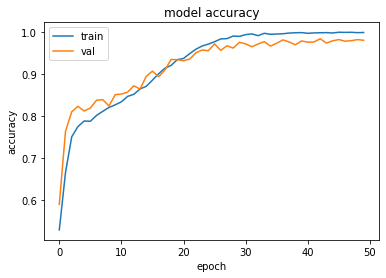

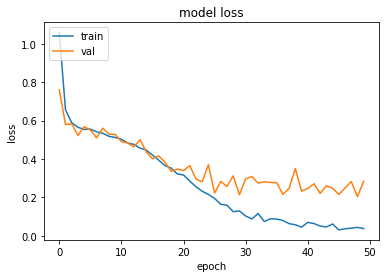

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.3107335865497589 , AUC = 0.9727919101715088 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9788984509466436
test 0.9756941186772496

-----------------------------------------------------------------


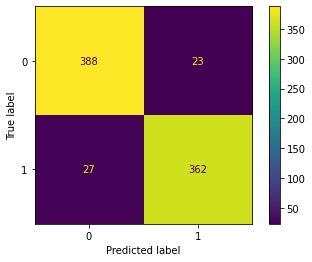

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5941659993994595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5451724050568771
134/134 - 18s - loss: 1.1378 - auc: 0.5199 - val_loss: 0.6904 - val_auc: 0.5941 - 18s/epoch - 133ms/step
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7652574817335602


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7361290567758607
134/134 - 16s - loss: 0.6721 - auc: 0.6288 - val_loss: 0.6045 - val_auc: 0.7644 - 16s/epoch - 119ms/step
Epoch 3/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8220085577019317


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7922968761875808
134/134 - 16s - loss: 0.6020 - auc: 0.7355 - val_loss: 0.5397 - val_auc: 0.8216 - 16s/epoch - 118ms/step
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8074767290561504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7758290897114336
134/134 - 16s - loss: 0.5735 - auc: 0.7662 - val_loss: 0.6728 - val_auc: 0.8076 - 16s/epoch - 119ms/step
Epoch 5/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8407754479031129


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8052810924476197
134/134 - 16s - loss: 0.5750 - auc: 0.7691 - val_loss: 0.5104 - val_auc: 0.8407 - 16s/epoch - 119ms/step
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8345698628765889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8012211497048466
134/134 - 16s - loss: 0.5452 - auc: 0.7975 - val_loss: 0.5089 - val_auc: 0.8344 - 16s/epoch - 119ms/step
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.842333099789811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8132521344784779
134/134 - 16s - loss: 0.5487 - auc: 0.7953 - val_loss: 0.5236 - val_auc: 0.8421 - 16s/epoch - 117ms/step
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8487013311980782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8211218362848675
134/134 - 16s - loss: 0.5348 - auc: 0.8068 - val_loss: 0.4812 - val_auc: 0.8488 - 16s/epoch - 119ms/step
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8566647482734461


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8176636011248765
134/134 - 16s - loss: 0.5212 - auc: 0.8168 - val_loss: 0.4845 - val_auc: 0.8567 - 16s/epoch - 119ms/step
Epoch 10/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8288209388449604


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8176002634845838
134/134 - 16s - loss: 0.5104 - auc: 0.8264 - val_loss: 0.5193 - val_auc: 0.8289 - 16s/epoch - 119ms/step
Epoch 11/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.850108847963167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8311798535633755
134/134 - 16s - loss: 0.5022 - auc: 0.8348 - val_loss: 0.4992 - val_auc: 0.8500 - 16s/epoch - 119ms/step
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8624074166750075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8499594639102126
134/134 - 16s - loss: 0.4915 - auc: 0.8404 - val_loss: 0.4706 - val_auc: 0.8624 - 16s/epoch - 119ms/step
Epoch 13/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.862970423381043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8540637430011906
134/134 - 16s - loss: 0.4716 - auc: 0.8544 - val_loss: 0.4866 - val_auc: 0.8630 - 16s/epoch - 120ms/step
Epoch 14/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8705084576118507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8564452382762028
134/134 - 16s - loss: 0.4536 - auc: 0.8675 - val_loss: 0.4616 - val_auc: 0.8706 - 16s/epoch - 118ms/step
Epoch 15/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8611437794014614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8457221757746192
134/134 - 16s - loss: 0.4333 - auc: 0.8774 - val_loss: 0.4825 - val_auc: 0.8613 - 16s/epoch - 119ms/step
Epoch 16/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8523608747873086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8598971396721644
134/134 - 16s - loss: 0.4113 - auc: 0.8907 - val_loss: 0.5386 - val_auc: 0.8525 - 16s/epoch - 118ms/step
Epoch 17/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8504466519867881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8615439183197792
134/134 - 16s - loss: 0.3929 - auc: 0.9012 - val_loss: 0.4965 - val_auc: 0.8505 - 16s/epoch - 118ms/step
Epoch 18/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8639337904113703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8918446454358897
134/134 - 16s - loss: 0.3717 - auc: 0.9116 - val_loss: 0.5029 - val_auc: 0.8638 - 16s/epoch - 118ms/step
Epoch 19/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8795666099489541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9150262217830812
134/134 - 16s - loss: 0.3477 - auc: 0.9229 - val_loss: 0.4518 - val_auc: 0.8795 - 16s/epoch - 119ms/step
Epoch 20/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8700017515764188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9012629525474398
134/134 - 16s - loss: 0.3157 - auc: 0.9361 - val_loss: 0.4831 - val_auc: 0.8701 - 16s/epoch - 118ms/step
Epoch 21/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8784906415774196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9082490942717439
134/134 - 16s - loss: 0.2952 - auc: 0.9451 - val_loss: 0.4704 - val_auc: 0.8784 - 16s/epoch - 117ms/step
Epoch 22/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8632706936242619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9117263307238225
134/134 - 16s - loss: 0.2741 - auc: 0.9525 - val_loss: 0.4940 - val_auc: 0.8630 - 16s/epoch - 118ms/step
Epoch 23/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8711089980982886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9371120569532062
134/134 - 16s - loss: 0.2455 - auc: 0.9621 - val_loss: 0.5094 - val_auc: 0.8707 - 16s/epoch - 117ms/step
Epoch 24/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8778588229406467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9352752653847128
134/134 - 16s - loss: 0.2030 - auc: 0.9747 - val_loss: 0.5504 - val_auc: 0.8768 - 16s/epoch - 118ms/step
Epoch 25/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8803735862276049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9383344734108586
134/134 - 16s - loss: 0.2011 - auc: 0.9749 - val_loss: 0.5805 - val_auc: 0.8795 - 16s/epoch - 118ms/step
Epoch 26/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8588323240916825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9303539307339566
134/134 - 16s - loss: 0.1790 - auc: 0.9797 - val_loss: 0.6703 - val_auc: 0.8596 - 16s/epoch - 117ms/step
Epoch 27/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8803860974877389


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9331724557269895
134/134 - 16s - loss: 0.1663 - auc: 0.9828 - val_loss: 0.5961 - val_auc: 0.8807 - 16s/epoch - 119ms/step
Epoch 28/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8754629166249626


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9387525018367917
134/134 - 16s - loss: 0.1456 - auc: 0.9867 - val_loss: 0.6305 - val_auc: 0.8742 - 16s/epoch - 117ms/step
Epoch 29/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8957749474527075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9425970966025691
134/134 - 16s - loss: 0.1355 - auc: 0.9882 - val_loss: 0.6919 - val_auc: 0.8915 - 16s/epoch - 118ms/step
Epoch 30/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8750031278150335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9414000152010338
134/134 - 16s - loss: 0.1061 - auc: 0.9930 - val_loss: 0.7991 - val_auc: 0.8714 - 16s/epoch - 118ms/step
Epoch 31/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8651974276849165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.934774898026399
134/134 - 16s - loss: 0.1110 - auc: 0.9924 - val_loss: 0.8537 - val_auc: 0.8580 - 16s/epoch - 118ms/step
Epoch 32/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.875206435792213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.942267740873046
134/134 - 16s - loss: 0.0861 - auc: 0.9953 - val_loss: 0.7351 - val_auc: 0.8692 - 16s/epoch - 116ms/step
Epoch 33/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8853780902812531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.946543031592815
134/134 - 16s - loss: 0.1025 - auc: 0.9931 - val_loss: 0.7349 - val_auc: 0.8820 - 16s/epoch - 116ms/step
Epoch 34/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8717220498448603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9466602062273568
134/134 - 16s - loss: 0.0793 - auc: 0.9958 - val_loss: 0.7657 - val_auc: 0.8685 - 16s/epoch - 118ms/step
Epoch 35/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8876989290361326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9504572977629147
134/134 - 16s - loss: 0.0795 - auc: 0.9958 - val_loss: 0.7538 - val_auc: 0.8840 - 16s/epoch - 118ms/step
Epoch 36/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8869388699829848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9520122368321046
134/134 - 16s - loss: 0.0588 - auc: 0.9977 - val_loss: 0.8089 - val_auc: 0.8832 - 16s/epoch - 117ms/step
Epoch 37/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8721005154639174


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9436199994932987
134/134 - 16s - loss: 0.0511 - auc: 0.9979 - val_loss: 1.0679 - val_auc: 0.8608 - 16s/epoch - 117ms/step
Epoch 38/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8845961365228705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9491145397887056
134/134 - 16s - loss: 0.0916 - auc: 0.9944 - val_loss: 0.7923 - val_auc: 0.8797 - 16s/epoch - 120ms/step
Epoch 39/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8829446501851665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9465271971827418
134/134 - 16s - loss: 0.0749 - auc: 0.9961 - val_loss: 0.7860 - val_auc: 0.8812 - 16s/epoch - 121ms/step
Epoch 40/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.888740491442298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9501121076233185
134/134 - 16s - loss: 0.0389 - auc: 0.9991 - val_loss: 0.9025 - val_auc: 0.8767 - 16s/epoch - 118ms/step
Epoch 41/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8687256030427384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9427111043550962
134/134 - 16s - loss: 0.0606 - auc: 0.9970 - val_loss: 0.8861 - val_auc: 0.8599 - 16s/epoch - 117ms/step
Epoch 42/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8828664548093283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9493583897038331
134/134 - 16s - loss: 0.0366 - auc: 0.9989 - val_loss: 1.0411 - val_auc: 0.8687 - 16s/epoch - 118ms/step
Epoch 43/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9072477729956961


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9538141926984368
134/134 - 16s - loss: 0.0605 - auc: 0.9970 - val_loss: 0.7224 - val_auc: 0.8998 - 16s/epoch - 117ms/step
Epoch 44/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8912740216194575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9557713257834867
134/134 - 16s - loss: 0.0403 - auc: 0.9984 - val_loss: 0.8536 - val_auc: 0.8791 - 16s/epoch - 120ms/step
Epoch 45/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8838047993193875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9514802006536445
134/134 - 15s - loss: 0.0356 - auc: 0.9992 - val_loss: 1.0454 - val_auc: 0.8694 - 15s/epoch - 115ms/step
Epoch 46/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8858629016114503


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9460965012287503
134/134 - 16s - loss: 0.0428 - auc: 0.9985 - val_loss: 0.9263 - val_auc: 0.8799 - 16s/epoch - 119ms/step
Epoch 47/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8850527975177659


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9559043348281017
134/134 - 16s - loss: 0.0471 - auc: 0.9982 - val_loss: 0.9167 - val_auc: 0.8779 - 16s/epoch - 118ms/step
Epoch 48/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8784187018316485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9530794760710395
134/134 - 16s - loss: 0.0343 - auc: 0.9992 - val_loss: 1.1670 - val_auc: 0.8605 - 16s/epoch - 119ms/step
Epoch 49/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8855563757381643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9436168326112842
134/134 - 16s - loss: 0.0420 - auc: 0.9985 - val_loss: 1.0267 - val_auc: 0.8750 - 16s/epoch - 119ms/step
Epoch 50/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8882807026323691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9533549948063134
134/134 - 16s - loss: 0.0380 - auc: 0.9989 - val_loss: 0.9743 - val_auc: 0.8757 - 16s/epoch - 117ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


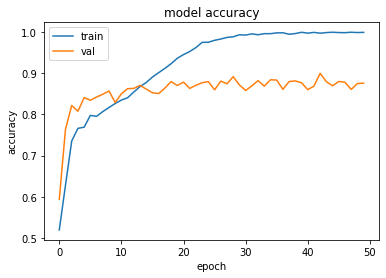

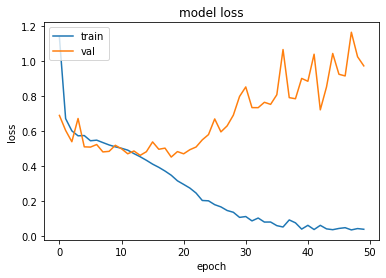

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5170009732246399 , AUC = 0.9465241432189941 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8882807026323691
test 0.9533549948063134

-----------------------------------------------------------------


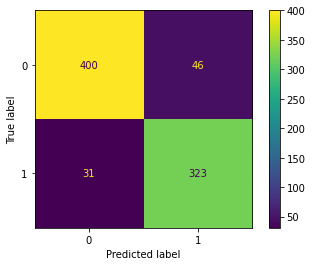

In [ ]:
# Create directory to save models
rt_sv_dir = '/content/models/50'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  
  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 800
acc:  0.91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.41340529918670654 , AUC = 0.946137547492981 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8679686718046241
test 0.9486521750145677

-----------------------------------------------------------------


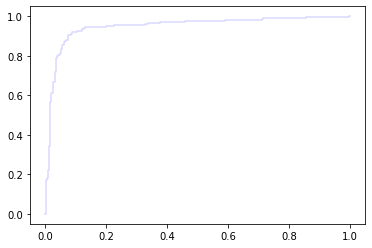

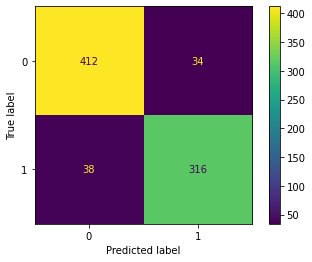

1
Num_samples: 800
acc:  0.91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.41688552498817444 , AUC = 0.9494248628616333 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.877996446802122
test 0.9495959058549314

-----------------------------------------------------------------


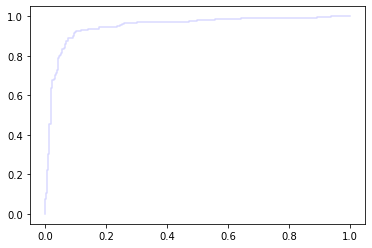

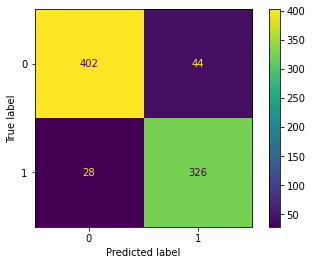

2
Num_samples: 800
acc:  0.9025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.34551364183425903 , AUC = 0.960160493850708 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8783342508257431
test 0.960486813103291

-----------------------------------------------------------------


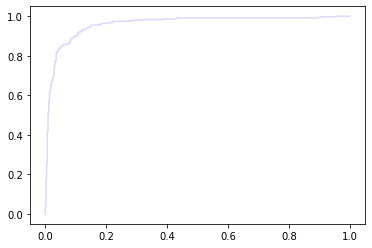

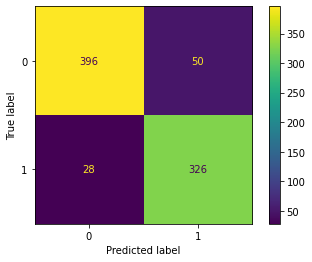

3
Num_samples: 800
acc:  0.9125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.37756964564323425 , AUC = 0.9537318348884583 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8763762386147532
test 0.957456107015277

-----------------------------------------------------------------


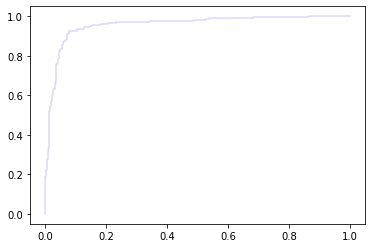

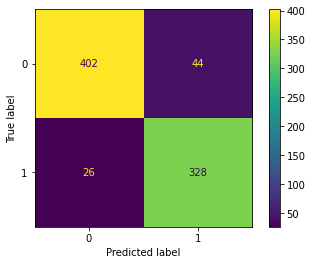

4
Num_samples: 800
acc:  0.82875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.3817949593067169 , AUC = 0.915377676486969 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8795666099489541
test 0.9150262217830812

-----------------------------------------------------------------


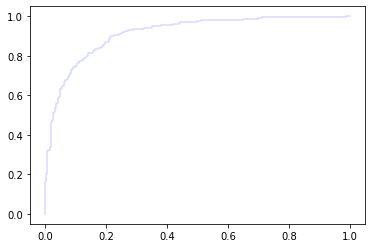

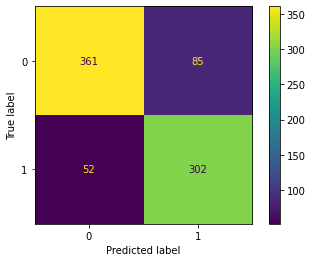

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


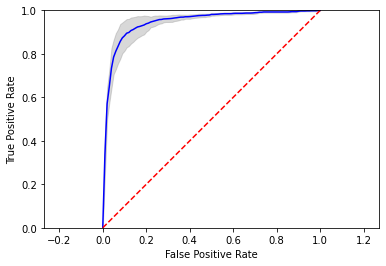

In [ ]:

# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/50/0/033--0.178--0.103.hdf5',
          1: '/content/models/50/1/038--0.148--0.074.hdf5',
          2: '/content/models/50/2/036--0.263--0.085.hdf5',
          3: '/content/models/50/3/049--0.204--0.044.hdf5',
          4: '/content/models/50/4/019--0.452--0.348.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]


  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  
  MERGM_Record1 = model.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = model.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = model.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

  


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [ ]:
# Create directory to save models
rt_sv_dir = '/content/models/50'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  
  test_features= DATA[RUN]['MFCCS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.8*len(data_x)): int(0.9*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.9*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.9*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.9*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.9*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

**80 epoch**

rm: cannot remove '/content/models/80': No such file or directory
Epoch 1/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5597412266706709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5379363823389777
117/117 - 24s - loss: 1.0148 - auc: 0.5332 - val_loss: 0.7155 - val_auc: 0.5601 - 24s/epoch - 202ms/step
Epoch 2/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6571847764200938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6351131508150023
117/117 - 20s - loss: 0.7246 - auc: 0.5348 - val_loss: 0.7041 - val_auc: 0.6561 - 20s/epoch - 170ms/step
Epoch 3/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7637316915992517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7762683968982435
117/117 - 20s - loss: 0.6646 - auc: 0.6214 - val_loss: 0.6064 - val_auc: 0.7644 - 20s/epoch - 173ms/step
Epoch 4/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7897842095713598


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7985282481405286
117/117 - 20s - loss: 0.5874 - auc: 0.7486 - val_loss: 0.5742 - val_auc: 0.7903 - 20s/epoch - 173ms/step
Epoch 5/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7914171844010236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8012217122962494
117/117 - 20s - loss: 0.5744 - auc: 0.7687 - val_loss: 0.5755 - val_auc: 0.7913 - 20s/epoch - 169ms/step
Epoch 6/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7927123023693777


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8192878620034816
117/117 - 20s - loss: 0.5448 - auc: 0.7956 - val_loss: 0.5683 - val_auc: 0.7928 - 20s/epoch - 169ms/step
Epoch 7/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8227690498088607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8317138787782876
117/117 - 20s - loss: 0.5392 - auc: 0.8017 - val_loss: 0.5287 - val_auc: 0.8229 - 20s/epoch - 169ms/step
Epoch 8/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7863305616557489


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8076467795537269
117/117 - 20s - loss: 0.5239 - auc: 0.8168 - val_loss: 0.5822 - val_auc: 0.7860 - 20s/epoch - 168ms/step
Epoch 9/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8265668111943241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8432536793796487
117/117 - 20s - loss: 0.5280 - auc: 0.8136 - val_loss: 0.5298 - val_auc: 0.8266 - 20s/epoch - 172ms/step
Epoch 10/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.838297952212024


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8489317930052223
117/117 - 20s - loss: 0.5073 - auc: 0.8304 - val_loss: 0.5058 - val_auc: 0.8384 - 20s/epoch - 169ms/step
Epoch 11/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8428277367969917


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8468301946510525
117/117 - 20s - loss: 0.4979 - auc: 0.8366 - val_loss: 0.5172 - val_auc: 0.8429 - 20s/epoch - 170ms/step
Epoch 12/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8462626148869744


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8543820224719101
117/117 - 20s - loss: 0.4795 - auc: 0.8493 - val_loss: 0.4915 - val_auc: 0.8460 - 20s/epoch - 170ms/step
Epoch 13/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8583003297232703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8723025795220762
117/117 - 20s - loss: 0.4755 - auc: 0.8535 - val_loss: 0.4671 - val_auc: 0.8585 - 20s/epoch - 169ms/step
Epoch 14/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8603587539338428


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8833423009969932
117/117 - 20s - loss: 0.4551 - auc: 0.8666 - val_loss: 0.4891 - val_auc: 0.8601 - 20s/epoch - 168ms/step
Epoch 15/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8562419055126977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8801012818483936
117/117 - 20s - loss: 0.4393 - auc: 0.8747 - val_loss: 0.4737 - val_auc: 0.8563 - 20s/epoch - 168ms/step
Epoch 16/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8711514036701266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8739420794429499
117/117 - 20s - loss: 0.4110 - auc: 0.8919 - val_loss: 0.4726 - val_auc: 0.8711 - 20s/epoch - 169ms/step
Epoch 17/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8640313831484505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8700553885108404
117/117 - 20s - loss: 0.3949 - auc: 0.9001 - val_loss: 0.4693 - val_auc: 0.8641 - 20s/epoch - 167ms/step
Epoch 18/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8899274859069893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9025352112676055
117/117 - 20s - loss: 0.3772 - auc: 0.9093 - val_loss: 0.4534 - val_auc: 0.8898 - 20s/epoch - 168ms/step
Epoch 19/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9003885353905062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9224624149390727
117/117 - 20s - loss: 0.3513 - auc: 0.9217 - val_loss: 0.4077 - val_auc: 0.9003 - 20s/epoch - 168ms/step
Epoch 20/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9176880580112743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.926026269979427
117/117 - 20s - loss: 0.3281 - auc: 0.9319 - val_loss: 0.3679 - val_auc: 0.9173 - 20s/epoch - 168ms/step
Epoch 21/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9127140542197697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9247159360658332
117/117 - 20s - loss: 0.3018 - auc: 0.9427 - val_loss: 0.3885 - val_auc: 0.9125 - 20s/epoch - 169ms/step
Epoch 22/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8975355218950016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9032441842063619
117/117 - 20s - loss: 0.2960 - auc: 0.9454 - val_loss: 0.4831 - val_auc: 0.8960 - 20s/epoch - 168ms/step
Epoch 23/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9207225131545194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9190441525557842
117/117 - 20s - loss: 0.2670 - auc: 0.9555 - val_loss: 0.3692 - val_auc: 0.9208 - 20s/epoch - 170ms/step
Epoch 24/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9354755960983789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.940705807880994
117/117 - 21s - loss: 0.2498 - auc: 0.9601 - val_loss: 0.3685 - val_auc: 0.9337 - 21s/epoch - 181ms/step
Epoch 25/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9301074259686795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.93317297040671
117/117 - 20s - loss: 0.2372 - auc: 0.9651 - val_loss: 0.3697 - val_auc: 0.9288 - 20s/epoch - 167ms/step
Epoch 26/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9345590029468627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9380978002848552
117/117 - 20s - loss: 0.1927 - auc: 0.9770 - val_loss: 0.3847 - val_auc: 0.9338 - 20s/epoch - 168ms/step
Epoch 27/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.938040805600916


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9544105079917709
117/117 - 20s - loss: 0.2072 - auc: 0.9731 - val_loss: 0.4032 - val_auc: 0.9359 - 20s/epoch - 169ms/step
Epoch 28/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9404464715856123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9341224877354012
117/117 - 20s - loss: 0.1721 - auc: 0.9813 - val_loss: 0.4020 - val_auc: 0.9392 - 20s/epoch - 167ms/step
Epoch 29/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9466436423472292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.941060294350372
117/117 - 20s - loss: 0.1600 - auc: 0.9842 - val_loss: 0.3545 - val_auc: 0.9463 - 20s/epoch - 171ms/step
Epoch 30/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9416696385557246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.951061876879253
117/117 - 20s - loss: 0.1614 - auc: 0.9841 - val_loss: 0.4056 - val_auc: 0.9413 - 20s/epoch - 167ms/step
Epoch 31/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9501410865226395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9426048425383763
117/117 - 20s - loss: 0.1316 - auc: 0.9891 - val_loss: 0.3539 - val_auc: 0.9480 - 20s/epoch - 168ms/step
Epoch 32/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9480701490949817


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9394809305269821
117/117 - 20s - loss: 0.1337 - auc: 0.9889 - val_loss: 0.3892 - val_auc: 0.9458 - 20s/epoch - 168ms/step
Epoch 33/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.937515250483323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9358252888115208
117/117 - 20s - loss: 0.1151 - auc: 0.9918 - val_loss: 0.3774 - val_auc: 0.9362 - 20s/epoch - 167ms/step
Epoch 34/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9535822212211649


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9458838423801235
117/117 - 20s - loss: 0.0976 - auc: 0.9937 - val_loss: 0.3877 - val_auc: 0.9520 - 20s/epoch - 168ms/step
Epoch 35/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.949884565572386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9500807089729388
117/117 - 20s - loss: 0.1003 - auc: 0.9938 - val_loss: 0.4168 - val_auc: 0.9508 - 20s/epoch - 168ms/step
Epoch 36/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9615844235473718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9489159677164107
117/117 - 20s - loss: 0.0930 - auc: 0.9945 - val_loss: 0.3175 - val_auc: 0.9588 - 20s/epoch - 168ms/step
Epoch 37/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9437593458090109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9434847285962968
117/117 - 20s - loss: 0.0806 - auc: 0.9960 - val_loss: 0.4396 - val_auc: 0.9411 - 20s/epoch - 169ms/step
Epoch 38/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9615093442448587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.955701851558791
117/117 - 20s - loss: 0.0734 - auc: 0.9965 - val_loss: 0.3583 - val_auc: 0.9599 - 20s/epoch - 167ms/step
Epoch 39/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9545269691111237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9469694571925937
117/117 - 20s - loss: 0.0484 - auc: 0.9985 - val_loss: 0.4048 - val_auc: 0.9534 - 20s/epoch - 167ms/step
Epoch 40/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9602142262765047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9496312707706916
117/117 - 20s - loss: 0.0743 - auc: 0.9965 - val_loss: 0.3149 - val_auc: 0.9597 - 20s/epoch - 168ms/step
Epoch 41/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9519774011299434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9417439468270296
117/117 - 20s - loss: 0.0563 - auc: 0.9976 - val_loss: 0.4378 - val_auc: 0.9503 - 20s/epoch - 172ms/step
Epoch 42/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9498657957467576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9378509257793956
117/117 - 20s - loss: 0.0612 - auc: 0.9973 - val_loss: 0.4923 - val_auc: 0.9447 - 20s/epoch - 168ms/step
Epoch 43/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9598263165468526


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9564203196708341
117/117 - 20s - loss: 0.0839 - auc: 0.9952 - val_loss: 0.3655 - val_auc: 0.9571 - 20s/epoch - 169ms/step
Epoch 44/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9589910593063924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9521316664029119
117/117 - 20s - loss: 0.0533 - auc: 0.9977 - val_loss: 0.3648 - val_auc: 0.9582 - 20s/epoch - 168ms/step
Epoch 45/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9459522871032529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.943297990188321
117/117 - 19s - loss: 0.0411 - auc: 0.9990 - val_loss: 0.5439 - val_auc: 0.9405 - 19s/epoch - 167ms/step
Epoch 46/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.954642716369165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9516917233739516
117/117 - 20s - loss: 0.0511 - auc: 0.9979 - val_loss: 0.4606 - val_auc: 0.9491 - 20s/epoch - 168ms/step
Epoch 47/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9561599439407874


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9546827029593289
117/117 - 20s - loss: 0.0648 - auc: 0.9966 - val_loss: 0.3873 - val_auc: 0.9555 - 20s/epoch - 168ms/step
Epoch 48/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9576959413380383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9529545814211109
117/117 - 20s - loss: 0.0388 - auc: 0.9988 - val_loss: 0.4139 - val_auc: 0.9595 - 20s/epoch - 168ms/step
Epoch 49/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.955897166381991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9596993195125811
117/117 - 20s - loss: 0.0520 - auc: 0.9978 - val_loss: 0.4867 - val_auc: 0.9519 - 20s/epoch - 167ms/step
Epoch 50/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9638805988825697


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9570311758189588
117/117 - 20s - loss: 0.0421 - auc: 0.9987 - val_loss: 0.4361 - val_auc: 0.9592 - 20s/epoch - 169ms/step
Epoch 51/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9591599877370471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.957971197974363
117/117 - 20s - loss: 0.0368 - auc: 0.9989 - val_loss: 0.4372 - val_auc: 0.9529 - 20s/epoch - 167ms/step
Epoch 52/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9581495454573894


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9528469694571926
117/117 - 20s - loss: 0.0422 - auc: 0.9988 - val_loss: 0.4120 - val_auc: 0.9549 - 20s/epoch - 167ms/step
Epoch 53/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9634614061102038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9549675581579364
117/117 - 20s - loss: 0.0392 - auc: 0.9988 - val_loss: 0.3906 - val_auc: 0.9655 - 20s/epoch - 173ms/step
Epoch 54/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9637554667117143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9560183573350213
117/117 - 21s - loss: 0.0391 - auc: 0.9990 - val_loss: 0.4431 - val_auc: 0.9597 - 21s/epoch - 179ms/step
Epoch 55/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9598419580682096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9578540908371579
117/117 - 20s - loss: 0.0225 - auc: 0.9994 - val_loss: 0.4641 - val_auc: 0.9550 - 20s/epoch - 168ms/step
Epoch 56/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9584936589272419


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9492039879727806
117/117 - 20s - loss: 0.0347 - auc: 0.9986 - val_loss: 0.4338 - val_auc: 0.9578 - 20s/epoch - 169ms/step
Epoch 57/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9477510620593002


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.949124861528723
117/117 - 20s - loss: 0.0328 - auc: 0.9989 - val_loss: 0.5564 - val_auc: 0.9481 - 20s/epoch - 168ms/step
Epoch 58/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9661454911750538


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9591865801550878
117/117 - 20s - loss: 0.0377 - auc: 0.9987 - val_loss: 0.4189 - val_auc: 0.9626 - 20s/epoch - 167ms/step
Epoch 59/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9609149664332951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9686944136730495
117/117 - 20s - loss: 0.0383 - auc: 0.9987 - val_loss: 0.4432 - val_auc: 0.9586 - 20s/epoch - 169ms/step
Epoch 60/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.960345615055903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.959490425700269
117/117 - 19s - loss: 0.0292 - auc: 0.9992 - val_loss: 0.4123 - val_auc: 0.9597 - 19s/epoch - 166ms/step
Epoch 61/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9602048413636904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9454755499287862
117/117 - 20s - loss: 0.0235 - auc: 0.9996 - val_loss: 0.5493 - val_auc: 0.9476 - 20s/epoch - 168ms/step
Epoch 62/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9591193197815192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9585472384871024
117/117 - 20s - loss: 0.0417 - auc: 0.9982 - val_loss: 0.4448 - val_auc: 0.9602 - 20s/epoch - 167ms/step
Epoch 63/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9556813133872654


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9598290868808356
117/117 - 19s - loss: 0.0234 - auc: 0.9991 - val_loss: 0.5637 - val_auc: 0.9505 - 19s/epoch - 167ms/step
Epoch 64/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9614530347679737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9627092894445324
117/117 - 20s - loss: 0.0369 - auc: 0.9982 - val_loss: 0.4427 - val_auc: 0.9574 - 20s/epoch - 167ms/step
Epoch 65/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9583028323666873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9578256053172971
117/117 - 20s - loss: 0.0336 - auc: 0.9992 - val_loss: 0.4407 - val_auc: 0.9550 - 20s/epoch - 167ms/step
Epoch 66/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9614092385081743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9603608165849027
117/117 - 19s - loss: 0.0442 - auc: 0.9984 - val_loss: 0.5147 - val_auc: 0.9570 - 19s/epoch - 167ms/step
Epoch 67/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9627919489961272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.954391517645197
117/117 - 20s - loss: 0.0254 - auc: 0.9993 - val_loss: 0.4175 - val_auc: 0.9626 - 20s/epoch - 168ms/step
Epoch 68/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9605020302694721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9583668301946511
117/117 - 20s - loss: 0.0230 - auc: 0.9992 - val_loss: 0.4908 - val_auc: 0.9518 - 20s/epoch - 168ms/step
Epoch 69/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9590630103046345


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9510903623991138
117/117 - 20s - loss: 0.0285 - auc: 0.9988 - val_loss: 0.4528 - val_auc: 0.9566 - 20s/epoch - 167ms/step
Epoch 70/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9532944172281973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9525019781611015
117/117 - 20s - loss: 0.0287 - auc: 0.9995 - val_loss: 0.5387 - val_auc: 0.9470 - 20s/epoch - 167ms/step
Epoch 71/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9661110798280684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9622535211267605
117/117 - 20s - loss: 0.0153 - auc: 0.9999 - val_loss: 0.4758 - val_auc: 0.9624 - 20s/epoch - 167ms/step
Epoch 72/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9617752501079265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9632663396106979
117/117 - 20s - loss: 0.0302 - auc: 0.9990 - val_loss: 0.4676 - val_auc: 0.9591 - 20s/epoch - 167ms/step
Epoch 73/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9567167821010942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9461053964234847
117/117 - 20s - loss: 0.0301 - auc: 0.9992 - val_loss: 0.5784 - val_auc: 0.9453 - 20s/epoch - 169ms/step
Epoch 74/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9620505408838085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9574173128659599
117/117 - 20s - loss: 0.0196 - auc: 0.9995 - val_loss: 0.5320 - val_auc: 0.9539 - 20s/epoch - 167ms/step
Epoch 75/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9578742546815073


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9629498338344675
117/117 - 20s - loss: 0.0360 - auc: 0.9985 - val_loss: 0.4719 - val_auc: 0.9590 - 20s/epoch - 168ms/step
Epoch 76/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9616688877626994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9581326159202406
117/117 - 20s - loss: 0.0190 - auc: 0.9997 - val_loss: 0.4935 - val_auc: 0.9609 - 20s/epoch - 169ms/step
Epoch 77/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9603612565772597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9585883842380123
117/117 - 20s - loss: 0.0223 - auc: 0.9992 - val_loss: 0.4716 - val_auc: 0.9613 - 20s/epoch - 169ms/step
Epoch 78/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.959829444851124


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9539547396739991
117/117 - 20s - loss: 0.0197 - auc: 0.9998 - val_loss: 0.5474 - val_auc: 0.9565 - 20s/epoch - 168ms/step
Epoch 79/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9469627293829107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9348251305586327
117/117 - 19s - loss: 0.0407 - auc: 0.9984 - val_loss: 0.5046 - val_auc: 0.9458 - 19s/epoch - 164ms/step
Epoch 80/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9573424429553716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9497958537743315
117/117 - 19s - loss: 0.0357 - auc: 0.9988 - val_loss: 0.4748 - val_auc: 0.9513 - 19s/epoch - 166ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


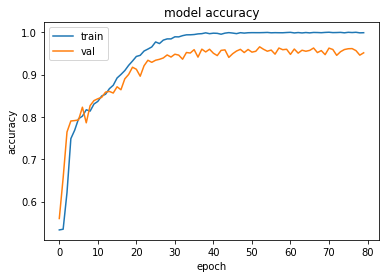

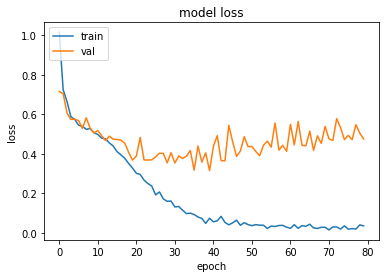

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5290387868881226 , AUC = 0.9436303377151489 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9573424429553716
test 0.9497958537743315

-----------------------------------------------------------------


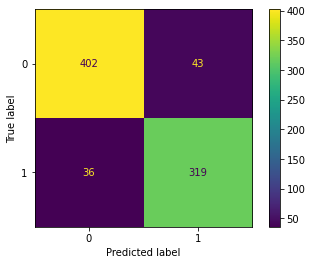

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7697860611628822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7408126464730239
117/117 - 22s - loss: 1.0393 - auc: 0.5317 - val_loss: 0.6673 - val_auc: 0.7683 - 22s/epoch - 188ms/step
Epoch 2/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.793561209757561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7722277722277723
117/117 - 20s - loss: 0.6564 - auc: 0.6676 - val_loss: 0.5627 - val_auc: 0.7936 - 20s/epoch - 169ms/step
Epoch 3/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7759048494053088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.747774238340276
117/117 - 20s - loss: 0.5844 - auc: 0.7586 - val_loss: 0.5682 - val_auc: 0.7761 - 20s/epoch - 168ms/step
Epoch 4/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8162801017506358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7950665686514744
117/117 - 20s - loss: 0.5690 - auc: 0.7717 - val_loss: 0.5521 - val_auc: 0.8163 - 20s/epoch - 170ms/step
Epoch 5/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8273864211651322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8086159123894971
117/117 - 20s - loss: 0.5353 - auc: 0.8059 - val_loss: 0.5254 - val_auc: 0.8276 - 20s/epoch - 167ms/step
Epoch 6/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8255176594853719


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8085813557511671
117/117 - 20s - loss: 0.5328 - auc: 0.8099 - val_loss: 0.5269 - val_auc: 0.8256 - 20s/epoch - 168ms/step
Epoch 7/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8314614466340414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82719167624828
117/117 - 20s - loss: 0.5279 - auc: 0.8132 - val_loss: 0.5165 - val_auc: 0.8314 - 20s/epoch - 168ms/step
Epoch 8/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8427865174157338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8291205649696216
117/117 - 20s - loss: 0.5170 - auc: 0.8213 - val_loss: 0.5251 - val_auc: 0.8427 - 20s/epoch - 168ms/step
Epoch 9/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8626616416352603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8384194421930271
117/117 - 20s - loss: 0.4979 - auc: 0.8367 - val_loss: 0.4703 - val_auc: 0.8626 - 20s/epoch - 168ms/step
Epoch 10/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8597866236663979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8626656362505419
117/117 - 20s - loss: 0.4856 - auc: 0.8476 - val_loss: 0.4892 - val_auc: 0.8598 - 20s/epoch - 169ms/step
Epoch 11/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8663179144869655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8320673037654169
117/117 - 20s - loss: 0.4685 - auc: 0.8571 - val_loss: 0.4577 - val_auc: 0.8663 - 20s/epoch - 169ms/step
Epoch 12/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8766992293701835


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8594550103984067
117/117 - 20s - loss: 0.4587 - auc: 0.8634 - val_loss: 0.4444 - val_auc: 0.8766 - 20s/epoch - 170ms/step
Epoch 13/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.882036762729767


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8778894061912931
117/117 - 19s - loss: 0.4383 - auc: 0.8770 - val_loss: 0.4390 - val_auc: 0.8819 - 19s/epoch - 165ms/step
Epoch 14/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8772867330420815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8923529300887791
117/117 - 20s - loss: 0.4197 - auc: 0.8860 - val_loss: 0.4829 - val_auc: 0.8770 - 20s/epoch - 167ms/step
Epoch 15/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8985993662460391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8947027814952343
117/117 - 20s - loss: 0.3947 - auc: 0.9009 - val_loss: 0.4078 - val_auc: 0.8986 - 20s/epoch - 169ms/step
Epoch 16/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8901993137457109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8897894558271918
117/117 - 20s - loss: 0.3723 - auc: 0.9119 - val_loss: 0.4337 - val_auc: 0.8900 - 20s/epoch - 167ms/step
Epoch 17/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9075556722229514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9141173292116689
117/117 - 20s - loss: 0.3515 - auc: 0.9220 - val_loss: 0.4161 - val_auc: 0.9072 - 20s/epoch - 167ms/step
Epoch 18/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.867236670229189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8628855421308252
117/117 - 20s - loss: 0.3227 - auc: 0.9336 - val_loss: 0.4661 - val_auc: 0.8673 - 20s/epoch - 168ms/step
Epoch 19/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9106744417152607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9206956565447132
117/117 - 20s - loss: 0.3051 - auc: 0.9402 - val_loss: 0.3985 - val_auc: 0.9103 - 20s/epoch - 169ms/step
Epoch 20/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8951118444490277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8946776493946305
117/117 - 20s - loss: 0.2760 - auc: 0.9521 - val_loss: 0.4370 - val_auc: 0.8948 - 20s/epoch - 169ms/step
Epoch 21/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9287933049581562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.93231925307397
117/117 - 20s - loss: 0.2524 - auc: 0.9596 - val_loss: 0.4971 - val_auc: 0.9292 - 20s/epoch - 171ms/step
Epoch 22/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9013056331602072


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9002318436280701
117/117 - 20s - loss: 0.2330 - auc: 0.9658 - val_loss: 0.4732 - val_auc: 0.9018 - 20s/epoch - 168ms/step
Epoch 23/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9326370789817435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9309621196413649
117/117 - 20s - loss: 0.2043 - auc: 0.9733 - val_loss: 0.3811 - val_auc: 0.9311 - 20s/epoch - 170ms/step
Epoch 24/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9322995768723555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9242392827298487
117/117 - 20s - loss: 0.1858 - auc: 0.9780 - val_loss: 0.3921 - val_auc: 0.9331 - 20s/epoch - 169ms/step
Epoch 25/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9324808280051748


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9392305807400146
117/117 - 20s - loss: 0.1779 - auc: 0.9801 - val_loss: 0.3848 - val_auc: 0.9315 - 20s/epoch - 167ms/step
Epoch 26/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9454809092556828


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9446339823698313
117/117 - 20s - loss: 0.1662 - auc: 0.9828 - val_loss: 0.3617 - val_auc: 0.9450 - 20s/epoch - 170ms/step
Epoch 27/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9444809030056436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9493525342581947
117/117 - 20s - loss: 0.1429 - auc: 0.9872 - val_loss: 0.3715 - val_auc: 0.9440 - 20s/epoch - 171ms/step
Epoch 28/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9404121275757973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9567727869614662
117/117 - 20s - loss: 0.1178 - auc: 0.9911 - val_loss: 0.4432 - val_auc: 0.9406 - 20s/epoch - 172ms/step
Epoch 29/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9340995881224257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9458654552994175
117/117 - 20s - loss: 0.1351 - auc: 0.9882 - val_loss: 0.4610 - val_auc: 0.9326 - 20s/epoch - 171ms/step
Epoch 30/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9560434752717203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9636338504263033
117/117 - 20s - loss: 0.0853 - auc: 0.9953 - val_loss: 0.3649 - val_auc: 0.9569 - 20s/epoch - 169ms/step
Epoch 31/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9465371658572864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9439491326283778
117/117 - 20s - loss: 0.0989 - auc: 0.9931 - val_loss: 0.4131 - val_auc: 0.9431 - 20s/epoch - 169ms/step
Epoch 32/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9376433602710017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9364220684975403
117/117 - 20s - loss: 0.0851 - auc: 0.9952 - val_loss: 0.5024 - val_auc: 0.9349 - 20s/epoch - 170ms/step
Epoch 33/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9493934337089607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9617552259061694
117/117 - 20s - loss: 0.0956 - auc: 0.9938 - val_loss: 0.3721 - val_auc: 0.9478 - 20s/epoch - 171ms/step
Epoch 34/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9465309158182238


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9488373261958166
117/117 - 20s - loss: 0.0746 - auc: 0.9962 - val_loss: 0.4106 - val_auc: 0.9461 - 20s/epoch - 168ms/step
Epoch 35/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9440059000368751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9381373343637496
117/117 - 20s - loss: 0.0561 - auc: 0.9976 - val_loss: 0.6652 - val_auc: 0.9371 - 20s/epoch - 167ms/step
Epoch 36/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9548028425177657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9549004454664832
117/117 - 20s - loss: 0.0623 - auc: 0.9968 - val_loss: 0.4643 - val_auc: 0.9500 - 20s/epoch - 169ms/step
Epoch 37/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9374246089038056


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9386839575518823
117/117 - 20s - loss: 0.0797 - auc: 0.9948 - val_loss: 0.4375 - val_auc: 0.9338 - 20s/epoch - 167ms/step
Epoch 38/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.957259107869424


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9652894275535786
117/117 - 20s - loss: 0.0582 - auc: 0.9971 - val_loss: 0.3767 - val_auc: 0.9534 - 20s/epoch - 167ms/step
Epoch 39/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9583059894124338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.964862181843314
117/117 - 20s - loss: 0.0450 - auc: 0.9988 - val_loss: 0.3978 - val_auc: 0.9518 - 20s/epoch - 168ms/step
Epoch 40/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9593247457796612


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.967290571064156
117/117 - 20s - loss: 0.0619 - auc: 0.9969 - val_loss: 0.3558 - val_auc: 0.9600 - 20s/epoch - 168ms/step
Epoch 41/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9590184938655867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9633196991687559
117/117 - 20s - loss: 0.0420 - auc: 0.9987 - val_loss: 0.4211 - val_auc: 0.9554 - 20s/epoch - 167ms/step
Epoch 42/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9574309839436497


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9680759492080248
117/117 - 20s - loss: 0.0428 - auc: 0.9987 - val_loss: 0.4165 - val_auc: 0.9536 - 20s/epoch - 168ms/step
Epoch 43/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9460059125369533


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9592074592074592
117/117 - 20s - loss: 0.0524 - auc: 0.9977 - val_loss: 0.4889 - val_auc: 0.9417 - 20s/epoch - 168ms/step
Epoch 44/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9596122475765473


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9666182873730043
117/117 - 20s - loss: 0.0373 - auc: 0.9992 - val_loss: 0.4643 - val_auc: 0.9578 - 20s/epoch - 168ms/step
Epoch 45/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9527028293926837


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9589624212265722
117/117 - 20s - loss: 0.0307 - auc: 0.9989 - val_loss: 0.5146 - val_auc: 0.9452 - 20s/epoch - 169ms/step
Epoch 46/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9538653366583542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9594273650877424
117/117 - 20s - loss: 0.0332 - auc: 0.9989 - val_loss: 0.4836 - val_auc: 0.9450 - 20s/epoch - 167ms/step
Epoch 47/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9506934418340114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.966015116958513
117/117 - 19s - loss: 0.0410 - auc: 0.9985 - val_loss: 0.5365 - val_auc: 0.9501 - 19s/epoch - 166ms/step
Epoch 48/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9598997493734336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9699797058287625
117/117 - 20s - loss: 0.0353 - auc: 0.9991 - val_loss: 0.4625 - val_auc: 0.9545 - 20s/epoch - 168ms/step
Epoch 49/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9555340970881068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9658831734303432
117/117 - 20s - loss: 0.0254 - auc: 0.9995 - val_loss: 0.4930 - val_auc: 0.9454 - 20s/epoch - 167ms/step
Epoch 50/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9577028606428789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9652014652014651
117/117 - 20s - loss: 0.0229 - auc: 0.9993 - val_loss: 0.5255 - val_auc: 0.9496 - 20s/epoch - 167ms/step
Epoch 51/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9573841086506789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9649847008337574
117/117 - 20s - loss: 0.0386 - auc: 0.9989 - val_loss: 0.5102 - val_auc: 0.9501 - 20s/epoch - 169ms/step
Epoch 52/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9595809973812335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9621133583397734
117/117 - 20s - loss: 0.0501 - auc: 0.9982 - val_loss: 0.4442 - val_auc: 0.9514 - 20s/epoch - 168ms/step
Epoch 53/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9602810017562611


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9590252514780817
117/117 - 20s - loss: 0.0366 - auc: 0.9985 - val_loss: 0.4891 - val_auc: 0.9567 - 20s/epoch - 168ms/step
Epoch 54/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9528997056231601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9694770638166865
117/117 - 20s - loss: 0.0312 - auc: 0.9992 - val_loss: 0.6497 - val_auc: 0.9461 - 20s/epoch - 167ms/step
Epoch 55/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9529590809942562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9616578390163296
117/117 - 20s - loss: 0.0555 - auc: 0.9973 - val_loss: 0.4526 - val_auc: 0.9473 - 20s/epoch - 169ms/step
Epoch 56/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9604435027718924


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9675638826582224
117/117 - 20s - loss: 0.0229 - auc: 0.9992 - val_loss: 0.5515 - val_auc: 0.9548 - 20s/epoch - 168ms/step
Epoch 57/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.954890343064644


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9613813859096879
117/117 - 20s - loss: 0.0364 - auc: 0.9986 - val_loss: 0.6275 - val_auc: 0.9454 - 20s/epoch - 168ms/step
Epoch 58/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.957055981599885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.965041248060116
117/117 - 20s - loss: 0.0293 - auc: 0.9989 - val_loss: 0.5262 - val_auc: 0.9539 - 20s/epoch - 170ms/step
Epoch 59/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9554153463459146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9655815882230976
117/117 - 20s - loss: 0.0204 - auc: 0.9993 - val_loss: 0.6008 - val_auc: 0.9435 - 20s/epoch - 169ms/step
Epoch 60/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9398433740210878


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9395887131736189
117/117 - 20s - loss: 0.0340 - auc: 0.9984 - val_loss: 0.7057 - val_auc: 0.9158 - 20s/epoch - 168ms/step
Epoch 61/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9516215726348289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.961792924057075
117/117 - 20s - loss: 0.0408 - auc: 0.9985 - val_loss: 0.4794 - val_auc: 0.9474 - 20s/epoch - 167ms/step
Epoch 62/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9642529015806349


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9698917434766491
117/117 - 20s - loss: 0.0324 - auc: 0.9991 - val_loss: 0.3935 - val_auc: 0.9585 - 20s/epoch - 168ms/step
Epoch 63/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9462496640604005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9590975062673176
117/117 - 20s - loss: 0.0268 - auc: 0.9990 - val_loss: 0.6127 - val_auc: 0.9421 - 20s/epoch - 169ms/step
Epoch 64/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9632153950962192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.969904309526951
117/117 - 20s - loss: 0.0279 - auc: 0.9991 - val_loss: 0.4472 - val_auc: 0.9558 - 20s/epoch - 168ms/step
Epoch 65/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9571559822248888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9665051929202872
117/117 - 20s - loss: 0.0154 - auc: 0.9998 - val_loss: 0.5539 - val_auc: 0.9456 - 20s/epoch - 169ms/step
Epoch 66/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9559122244514029


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9690623841567237
117/117 - 20s - loss: 0.0227 - auc: 0.9995 - val_loss: 0.6352 - val_auc: 0.9460 - 20s/epoch - 167ms/step
Epoch 67/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9499559372246077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9536564064865952
117/117 - 20s - loss: 0.0640 - auc: 0.9966 - val_loss: 0.5017 - val_auc: 0.9440 - 20s/epoch - 169ms/step
Epoch 68/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9623185144907156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9680728076954492
117/117 - 20s - loss: 0.0351 - auc: 0.9990 - val_loss: 0.4355 - val_auc: 0.9503 - 20s/epoch - 170ms/step
Epoch 69/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9613247582797393


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9720468211034249
117/117 - 20s - loss: 0.0218 - auc: 0.9994 - val_loss: 0.4539 - val_auc: 0.9593 - 20s/epoch - 168ms/step
Epoch 70/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9597341233382708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.967654986522911
117/117 - 20s - loss: 0.0155 - auc: 0.9998 - val_loss: 0.5138 - val_auc: 0.9527 - 20s/epoch - 173ms/step
Epoch 71/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9571059819123868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9657732204902015
117/117 - 20s - loss: 0.0102 - auc: 0.9999 - val_loss: 0.6308 - val_auc: 0.9471 - 20s/epoch - 170ms/step
Epoch 72/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9609466309164431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9678905999660717
117/117 - 20s - loss: 0.0120 - auc: 0.9997 - val_loss: 0.6039 - val_auc: 0.9519 - 20s/epoch - 170ms/step
Epoch 73/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9576153600960007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.965543890072192
117/117 - 20s - loss: 0.0106 - auc: 0.9997 - val_loss: 0.6378 - val_auc: 0.9517 - 20s/epoch - 169ms/step
Epoch 74/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.954646591541197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.963797209080228
117/117 - 20s - loss: 0.0336 - auc: 0.9994 - val_loss: 0.5240 - val_auc: 0.9471 - 20s/epoch - 169ms/step
Epoch 75/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9537028356427227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9665428910711928
117/117 - 20s - loss: 0.0280 - auc: 0.9987 - val_loss: 0.6261 - val_auc: 0.9455 - 20s/epoch - 171ms/step
Epoch 76/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9588497428108925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.962779359005774
117/117 - 20s - loss: 0.0289 - auc: 0.9987 - val_loss: 0.4515 - val_auc: 0.9565 - 20s/epoch - 167ms/step
Epoch 77/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9532247076544229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9581236373689204
117/117 - 20s - loss: 0.0174 - auc: 0.9993 - val_loss: 0.5537 - val_auc: 0.9447 - 20s/epoch - 167ms/step
Epoch 78/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9545778411115071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9666245703981553
117/117 - 20s - loss: 0.0326 - auc: 0.9989 - val_loss: 0.5497 - val_auc: 0.9484 - 20s/epoch - 167ms/step
Epoch 79/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9584122400765005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9584817698025246
117/117 - 20s - loss: 0.0394 - auc: 0.9988 - val_loss: 0.5415 - val_auc: 0.9545 - 20s/epoch - 168ms/step
Epoch 80/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9588184926155789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9707996406109614
117/117 - 20s - loss: 0.0227 - auc: 0.9994 - val_loss: 0.5838 - val_auc: 0.9505 - 20s/epoch - 167ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


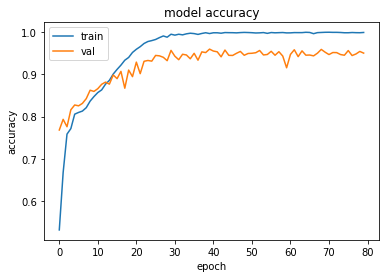

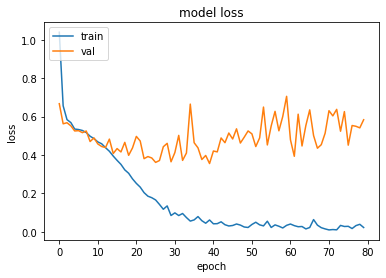

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.4141123592853546 , AUC = 0.9650381207466125 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9588184926155789
test 0.9707996406109614

-----------------------------------------------------------------


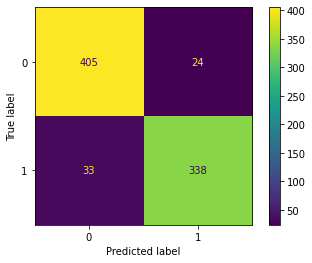

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5324960576706466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5493074739948777
117/117 - 23s - loss: 1.1169 - auc: 0.5035 - val_loss: 0.6973 - val_auc: 0.5319 - 23s/epoch - 200ms/step
Epoch 2/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.49276613851968665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.48519611606496715
117/117 - 20s - loss: 0.7271 - auc: 0.5170 - val_loss: 0.7271 - val_auc: 0.4905 - 20s/epoch - 169ms/step
Epoch 3/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5912617956997321


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6004241367809655
117/117 - 20s - loss: 0.7123 - auc: 0.5450 - val_loss: 0.7187 - val_auc: 0.5909 - 20s/epoch - 167ms/step
Epoch 4/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7932342119095891


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7904990843931509
117/117 - 20s - loss: 0.6684 - auc: 0.6297 - val_loss: 0.6099 - val_auc: 0.7939 - 20s/epoch - 169ms/step
Epoch 5/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8099546945007634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8118317800529855
117/117 - 20s - loss: 0.5937 - auc: 0.7431 - val_loss: 0.5394 - val_auc: 0.8103 - 20s/epoch - 169ms/step
Epoch 6/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7969512652999925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.805010351706301
117/117 - 20s - loss: 0.5684 - auc: 0.7710 - val_loss: 0.5648 - val_auc: 0.7971 - 20s/epoch - 168ms/step
Epoch 7/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8280456058671873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8324219217046019
117/117 - 20s - loss: 0.5461 - auc: 0.7966 - val_loss: 0.5241 - val_auc: 0.8280 - 20s/epoch - 168ms/step
Epoch 8/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8294911266301218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8322394296178365
117/117 - 20s - loss: 0.5308 - auc: 0.8111 - val_loss: 0.5741 - val_auc: 0.8294 - 20s/epoch - 167ms/step
Epoch 9/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8455357813321318


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8524708799264997
117/117 - 20s - loss: 0.5182 - auc: 0.8223 - val_loss: 0.4949 - val_auc: 0.8454 - 20s/epoch - 168ms/step
Epoch 10/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8526257165027158


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8471093882739396
117/117 - 20s - loss: 0.5221 - auc: 0.8180 - val_loss: 0.4817 - val_auc: 0.8526 - 20s/epoch - 168ms/step
Epoch 11/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8546406848389276


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.858763710504622
117/117 - 19s - loss: 0.5057 - auc: 0.8312 - val_loss: 0.5276 - val_auc: 0.8546 - 19s/epoch - 166ms/step
Epoch 12/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8613113564116044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8624387235622456
117/117 - 20s - loss: 0.4950 - auc: 0.8396 - val_loss: 0.4760 - val_auc: 0.8612 - 20s/epoch - 168ms/step
Epoch 13/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.857350254061225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8588895671161845
117/117 - 20s - loss: 0.4964 - auc: 0.8377 - val_loss: 0.4838 - val_auc: 0.8573 - 20s/epoch - 170ms/step
Epoch 14/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8670746664664213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8674918665164778
117/117 - 20s - loss: 0.4786 - auc: 0.8509 - val_loss: 0.4573 - val_auc: 0.8670 - 20s/epoch - 168ms/step
Epoch 15/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8727628845335537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8685742333759149
117/117 - 20s - loss: 0.4624 - auc: 0.8619 - val_loss: 0.4533 - val_auc: 0.8725 - 20s/epoch - 167ms/step
Epoch 16/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8510863307551751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8656795313099785
117/117 - 20s - loss: 0.4487 - auc: 0.8710 - val_loss: 0.5120 - val_auc: 0.8511 - 20s/epoch - 168ms/step
Epoch 17/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8851092588420815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8881071794904066
117/117 - 20s - loss: 0.4253 - auc: 0.8836 - val_loss: 0.4285 - val_auc: 0.8851 - 20s/epoch - 170ms/step
Epoch 18/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9022677780280844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.902020627898635
117/117 - 20s - loss: 0.4160 - auc: 0.8896 - val_loss: 0.4302 - val_auc: 0.9021 - 20s/epoch - 168ms/step
Epoch 19/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8918487647368025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8872639401929382
117/117 - 20s - loss: 0.3885 - auc: 0.9045 - val_loss: 0.4312 - val_auc: 0.8920 - 20s/epoch - 167ms/step
Epoch 20/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.902918575254687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9119633002120684
117/117 - 20s - loss: 0.3731 - auc: 0.9119 - val_loss: 0.4095 - val_auc: 0.9029 - 20s/epoch - 168ms/step
Epoch 21/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8863357613076018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9077219324024138
117/117 - 20s - loss: 0.3537 - auc: 0.9204 - val_loss: 0.4644 - val_auc: 0.8860 - 20s/epoch - 168ms/step
Epoch 22/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9049022552626969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9264493962029059
117/117 - 20s - loss: 0.3225 - auc: 0.9333 - val_loss: 0.4031 - val_auc: 0.9047 - 20s/epoch - 167ms/step
Epoch 23/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.910696853645716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9230764390130325
117/117 - 20s - loss: 0.3116 - auc: 0.9377 - val_loss: 0.5017 - val_auc: 0.9105 - 20s/epoch - 167ms/step
Epoch 24/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9277427348501915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9377764912435261
117/117 - 20s - loss: 0.2976 - auc: 0.9447 - val_loss: 0.3960 - val_auc: 0.9281 - 20s/epoch - 169ms/step
Epoch 25/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9206402843483267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9355614148800272
117/117 - 20s - loss: 0.2682 - auc: 0.9545 - val_loss: 0.4100 - val_auc: 0.9209 - 20s/epoch - 171ms/step
Epoch 26/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9313534079247078


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9357376141362146
117/117 - 20s - loss: 0.2499 - auc: 0.9600 - val_loss: 0.4035 - val_auc: 0.9307 - 20s/epoch - 168ms/step
Epoch 27/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.917649120172211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9399852747764471
117/117 - 20s - loss: 0.2241 - auc: 0.9686 - val_loss: 0.3885 - val_auc: 0.9174 - 20s/epoch - 168ms/step
Epoch 28/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9264098520687842


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9409858348383686
117/117 - 20s - loss: 0.2105 - auc: 0.9725 - val_loss: 0.3986 - val_auc: 0.9260 - 20s/epoch - 168ms/step
Epoch 29/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9263973367375032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9407718785987125
117/117 - 20s - loss: 0.1879 - auc: 0.9780 - val_loss: 0.4203 - val_auc: 0.9264 - 20s/epoch - 167ms/step
Epoch 30/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.935251933618683


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.948669380974256
117/117 - 20s - loss: 0.1821 - auc: 0.9790 - val_loss: 0.3643 - val_auc: 0.9354 - 20s/epoch - 167ms/step
Epoch 31/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9367256138769993


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9435029670696176
117/117 - 20s - loss: 0.1570 - auc: 0.9845 - val_loss: 0.3869 - val_auc: 0.9347 - 20s/epoch - 167ms/step
Epoch 32/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9287001576931739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9423576719043993
117/117 - 20s - loss: 0.1419 - auc: 0.9873 - val_loss: 0.4804 - val_auc: 0.9283 - 20s/epoch - 168ms/step
Epoch 33/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9380178218317438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9504439591972865
117/117 - 20s - loss: 0.1334 - auc: 0.9891 - val_loss: 0.3851 - val_auc: 0.9366 - 20s/epoch - 169ms/step
Epoch 34/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9455708242597181


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9612927991139695
117/117 - 21s - loss: 0.1109 - auc: 0.9918 - val_loss: 0.3751 - val_auc: 0.9447 - 21s/epoch - 176ms/step
Epoch 35/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9392630972941854


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9509473856435364
117/117 - 20s - loss: 0.1028 - auc: 0.9931 - val_loss: 0.4799 - val_auc: 0.9359 - 20s/epoch - 174ms/step
Epoch 36/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9440971440014018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9600468186595011
117/117 - 20s - loss: 0.1007 - auc: 0.9936 - val_loss: 0.4831 - val_auc: 0.9368 - 20s/epoch - 175ms/step
Epoch 37/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.942923831693825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9589141091554392
117/117 - 21s - loss: 0.0923 - auc: 0.9948 - val_loss: 0.4173 - val_auc: 0.9429 - 21s/epoch - 178ms/step
Epoch 38/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9452141373182147


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9570703097960493
117/117 - 21s - loss: 0.0828 - auc: 0.9950 - val_loss: 0.4543 - val_auc: 0.9429 - 21s/epoch - 177ms/step
Epoch 39/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9325454932292058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9447709724311093
117/117 - 21s - loss: 0.0809 - auc: 0.9950 - val_loss: 0.5407 - val_auc: 0.9291 - 21s/epoch - 176ms/step
Epoch 40/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9468192285549799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9602261643309777
117/117 - 20s - loss: 0.0718 - auc: 0.9967 - val_loss: 0.5050 - val_auc: 0.9417 - 20s/epoch - 172ms/step
Epoch 41/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9434119296137768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9583855113868769
117/117 - 20s - loss: 0.0749 - auc: 0.9956 - val_loss: 0.4921 - val_auc: 0.9431 - 20s/epoch - 171ms/step
Epoch 42/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.93811168681635


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9626961003328908
117/117 - 20s - loss: 0.0646 - auc: 0.9969 - val_loss: 0.4914 - val_auc: 0.9315 - 20s/epoch - 171ms/step
Epoch 43/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.935452178919176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9597951054363763
117/117 - 20s - loss: 0.0554 - auc: 0.9973 - val_loss: 0.6025 - val_auc: 0.9301 - 20s/epoch - 173ms/step
Epoch 44/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9480801481815223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9630264739382423
117/117 - 20s - loss: 0.0713 - auc: 0.9964 - val_loss: 0.4561 - val_auc: 0.9414 - 20s/epoch - 170ms/step
Epoch 45/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9513779379740182


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9617395900850163
117/117 - 20s - loss: 0.0655 - auc: 0.9967 - val_loss: 0.4364 - val_auc: 0.9479 - 20s/epoch - 170ms/step
Epoch 46/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9496195339290631


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9699454411588877
117/117 - 20s - loss: 0.0465 - auc: 0.9981 - val_loss: 0.4771 - val_auc: 0.9440 - 20s/epoch - 171ms/step
Epoch 47/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9379051838502166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9549747972135345
117/117 - 20s - loss: 0.0458 - auc: 0.9983 - val_loss: 0.6492 - val_auc: 0.9303 - 20s/epoch - 168ms/step
Epoch 48/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9403644464468975


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9610788428743134
117/117 - 20s - loss: 0.0570 - auc: 0.9975 - val_loss: 0.5375 - val_auc: 0.9335 - 20s/epoch - 169ms/step
Epoch 49/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9412280043052739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9628534210973437
117/117 - 20s - loss: 0.0461 - auc: 0.9985 - val_loss: 0.5818 - val_auc: 0.9390 - 20s/epoch - 171ms/step
Epoch 50/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9506864659207528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9652006469029834
117/117 - 20s - loss: 0.0441 - auc: 0.9984 - val_loss: 0.5618 - val_auc: 0.9421 - 20s/epoch - 171ms/step
Epoch 51/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9544379364721784


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9631900875332735
117/117 - 20s - loss: 0.0579 - auc: 0.9966 - val_loss: 0.4334 - val_auc: 0.9516 - 20s/epoch - 174ms/step
Epoch 52/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.943856223874246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9594301212628453
117/117 - 20s - loss: 0.0322 - auc: 0.9993 - val_loss: 0.6340 - val_auc: 0.9349 - 20s/epoch - 170ms/step
Epoch 53/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9390190483342095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9557173512217532
117/117 - 20s - loss: 0.0500 - auc: 0.9980 - val_loss: 0.6279 - val_auc: 0.9318 - 20s/epoch - 170ms/step
Epoch 54/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9492597181547395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9642378438245307
117/117 - 20s - loss: 0.0305 - auc: 0.9995 - val_loss: 0.5526 - val_auc: 0.9459 - 20s/epoch - 172ms/step
Epoch 55/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9481395960051064


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9643511147749371
117/117 - 20s - loss: 0.0509 - auc: 0.9977 - val_loss: 0.4960 - val_auc: 0.9404 - 20s/epoch - 173ms/step
Epoch 56/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9509117418838077


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9651503042583583
117/117 - 20s - loss: 0.0443 - auc: 0.9983 - val_loss: 0.4905 - val_auc: 0.9474 - 20s/epoch - 171ms/step
Epoch 57/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.951453029961703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9695930426465128
117/117 - 20s - loss: 0.0214 - auc: 0.9992 - val_loss: 0.5994 - val_auc: 0.9475 - 20s/epoch - 170ms/step
Epoch 58/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9490281845260444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9585994676265331
117/117 - 20s - loss: 0.0284 - auc: 0.9994 - val_loss: 0.5217 - val_auc: 0.9457 - 20s/epoch - 171ms/step
Epoch 59/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9528797777277165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9662421103636627
117/117 - 20s - loss: 0.0398 - auc: 0.9983 - val_loss: 0.5340 - val_auc: 0.9469 - 20s/epoch - 171ms/step
Epoch 60/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9415753047483167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9682086199193259
117/117 - 20s - loss: 0.0403 - auc: 0.9975 - val_loss: 0.5737 - val_auc: 0.9432 - 20s/epoch - 172ms/step
Epoch 61/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9510462816950764


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9696842886898955
117/117 - 20s - loss: 0.0278 - auc: 0.9992 - val_loss: 0.5710 - val_auc: 0.9491 - 20s/epoch - 171ms/step
Epoch 62/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9565749292883782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9655750703223818
117/117 - 20s - loss: 0.0288 - auc: 0.9991 - val_loss: 0.5503 - val_auc: 0.9483 - 20s/epoch - 171ms/step
Epoch 63/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9561994693499537


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9668525149297406
117/117 - 20s - loss: 0.0295 - auc: 0.9993 - val_loss: 0.5126 - val_auc: 0.9471 - 20s/epoch - 170ms/step
Epoch 64/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9448637080423518


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9641182800435463
117/117 - 20s - loss: 0.0465 - auc: 0.9976 - val_loss: 0.5702 - val_auc: 0.9363 - 20s/epoch - 171ms/step
Epoch 65/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9539498385522264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9701593973985438
117/117 - 20s - loss: 0.0269 - auc: 0.9994 - val_loss: 0.5250 - val_auc: 0.9512 - 20s/epoch - 171ms/step
Epoch 66/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9517440114139822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9686333859833491
117/117 - 20s - loss: 0.0263 - auc: 0.9991 - val_loss: 0.5367 - val_auc: 0.9489 - 20s/epoch - 173ms/step
Epoch 67/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9430239543440715


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.946709164249171
117/117 - 20s - loss: 0.0431 - auc: 0.9980 - val_loss: 0.6027 - val_auc: 0.9293 - 20s/epoch - 170ms/step
Epoch 68/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9457929713899528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9641937940104839
117/117 - 20s - loss: 0.0326 - auc: 0.9991 - val_loss: 0.5911 - val_auc: 0.9377 - 20s/epoch - 168ms/step
Epoch 69/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9482084303271509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9641056943823901
117/117 - 20s - loss: 0.0276 - auc: 0.9995 - val_loss: 0.5783 - val_auc: 0.9459 - 20s/epoch - 168ms/step
Epoch 70/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9502171409977223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9683753799296462
117/117 - 20s - loss: 0.0239 - auc: 0.9994 - val_loss: 0.6132 - val_auc: 0.9466 - 20s/epoch - 167ms/step
Epoch 71/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9486621110860805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9672269383491389
117/117 - 20s - loss: 0.0139 - auc: 0.9999 - val_loss: 0.6014 - val_auc: 0.9489 - 20s/epoch - 168ms/step
Epoch 72/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9431741383194414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9646909276261554
117/117 - 20s - loss: 0.0417 - auc: 0.9985 - val_loss: 0.7428 - val_auc: 0.9359 - 20s/epoch - 167ms/step
Epoch 73/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9518535205626893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.96403961966132
117/117 - 20s - loss: 0.0372 - auc: 0.9987 - val_loss: 0.5902 - val_auc: 0.9475 - 20s/epoch - 167ms/step
Epoch 74/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9473949337938976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9612550421305007
117/117 - 20s - loss: 0.0210 - auc: 0.9997 - val_loss: 0.5435 - val_auc: 0.9480 - 20s/epoch - 167ms/step
Epoch 75/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.951956772045756


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9674283089276388
117/117 - 20s - loss: 0.0143 - auc: 0.9994 - val_loss: 0.6292 - val_auc: 0.9486 - 20s/epoch - 168ms/step
Epoch 76/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9512465269955696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.967239524010295
117/117 - 20s - loss: 0.0222 - auc: 0.9994 - val_loss: 0.6233 - val_auc: 0.9422 - 20s/epoch - 170ms/step
Epoch 77/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9493942579660084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9613840451573521
117/117 - 20s - loss: 0.0346 - auc: 0.9986 - val_loss: 0.5361 - val_auc: 0.9433 - 20s/epoch - 167ms/step
Epoch 78/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9554954819654076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9701468117373875
117/117 - 19s - loss: 0.0190 - auc: 0.9998 - val_loss: 0.6116 - val_auc: 0.9508 - 19s/epoch - 166ms/step
Epoch 79/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9521226001852269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9660533254463191
117/117 - 20s - loss: 0.0402 - auc: 0.9977 - val_loss: 0.5073 - val_auc: 0.9519 - 20s/epoch - 167ms/step
Epoch 80/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9510900853545594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9656694627810536
117/117 - 20s - loss: 0.0244 - auc: 0.9996 - val_loss: 0.6461 - val_auc: 0.9440 - 20s/epoch - 167ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


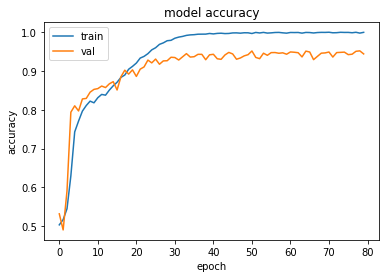

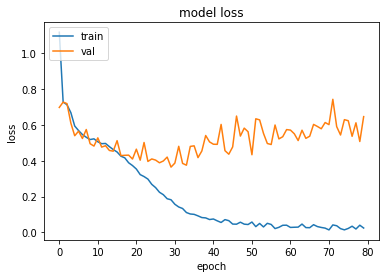

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.43824100494384766 , AUC = 0.959313690662384 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9510900853545594
test 0.9656694627810536

-----------------------------------------------------------------


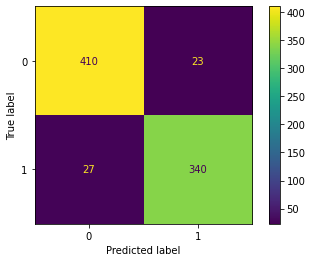

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5202907518171989


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.529547064095413
117/117 - 22s - loss: 1.0682 - auc: 0.5153 - val_loss: 0.7070 - val_auc: 0.5236 - 22s/epoch - 186ms/step
Epoch 2/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6243539022118888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5904681027080891
117/117 - 20s - loss: 0.7136 - auc: 0.5186 - val_loss: 0.6911 - val_auc: 0.6247 - 20s/epoch - 168ms/step
Epoch 3/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7361983512396953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7016589474739752
117/117 - 20s - loss: 0.6989 - auc: 0.5468 - val_loss: 0.6856 - val_auc: 0.7273 - 20s/epoch - 169ms/step
Epoch 4/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7770611066319164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.74849428737959
117/117 - 20s - loss: 0.6619 - auc: 0.6447 - val_loss: 0.6041 - val_auc: 0.7769 - 20s/epoch - 170ms/step
Epoch 5/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7967487296795605


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7758133355059883
117/117 - 20s - loss: 0.5899 - auc: 0.7453 - val_loss: 0.5985 - val_auc: 0.7969 - 20s/epoch - 168ms/step
Epoch 6/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.800667504171901


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7681171228197718
117/117 - 20s - loss: 0.5629 - auc: 0.7784 - val_loss: 0.5432 - val_auc: 0.8006 - 20s/epoch - 168ms/step
Epoch 7/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8233551459696624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7766155466003171
117/117 - 20s - loss: 0.5562 - auc: 0.7853 - val_loss: 0.5279 - val_auc: 0.8240 - 20s/epoch - 167ms/step
Epoch 8/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8235613972587328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7945587525617483
117/117 - 20s - loss: 0.5365 - auc: 0.8045 - val_loss: 0.5263 - val_auc: 0.8237 - 20s/epoch - 168ms/step
Epoch 9/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8312926955793474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8091615013882013
117/117 - 20s - loss: 0.5219 - auc: 0.8169 - val_loss: 0.5083 - val_auc: 0.8313 - 20s/epoch - 167ms/step
Epoch 10/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.847449046556541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8156543974329246
117/117 - 20s - loss: 0.5213 - auc: 0.8167 - val_loss: 0.5097 - val_auc: 0.8474 - 20s/epoch - 168ms/step
Epoch 11/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.842149013431334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8231249882488609
117/117 - 19s - loss: 0.5116 - auc: 0.8250 - val_loss: 0.5092 - val_auc: 0.8421 - 19s/epoch - 165ms/step
Epoch 12/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8358489740560879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8207496913367469
117/117 - 20s - loss: 0.4960 - auc: 0.8375 - val_loss: 0.5060 - val_auc: 0.8360 - 20s/epoch - 168ms/step
Epoch 13/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8452677829236432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8292512487543793
117/117 - 20s - loss: 0.4840 - auc: 0.8463 - val_loss: 0.4844 - val_auc: 0.8454 - 20s/epoch - 167ms/step
Epoch 14/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461240382752392


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8343841463032483
117/117 - 20s - loss: 0.4732 - auc: 0.8546 - val_loss: 0.5115 - val_auc: 0.8460 - 20s/epoch - 167ms/step
Epoch 15/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8779867374171089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8549000683132886
117/117 - 20s - loss: 0.4523 - auc: 0.8672 - val_loss: 0.4390 - val_auc: 0.8782 - 20s/epoch - 168ms/step
Epoch 16/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8754242214013838


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8530167524238682
117/117 - 20s - loss: 0.4438 - auc: 0.8742 - val_loss: 0.4535 - val_auc: 0.8754 - 20s/epoch - 170ms/step
Epoch 17/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8863742898393113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8724735050984277
117/117 - 20s - loss: 0.4196 - auc: 0.8849 - val_loss: 0.4310 - val_auc: 0.8863 - 20s/epoch - 169ms/step
Epoch 18/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8797492484328027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8647929605976473
117/117 - 20s - loss: 0.4033 - auc: 0.8955 - val_loss: 0.4483 - val_auc: 0.8797 - 20s/epoch - 169ms/step
Epoch 19/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8910618191363696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8873676821739921
117/117 - 20s - loss: 0.3842 - auc: 0.9058 - val_loss: 0.4225 - val_auc: 0.8913 - 20s/epoch - 168ms/step
Epoch 20/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9100994381214882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8984388220031461
117/117 - 20s - loss: 0.3682 - auc: 0.9138 - val_loss: 0.3806 - val_auc: 0.9102 - 20s/epoch - 168ms/step
Epoch 21/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8982306139413371


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.891551087685433
117/117 - 20s - loss: 0.3325 - auc: 0.9296 - val_loss: 0.4354 - val_auc: 0.8978 - 20s/epoch - 169ms/step
Epoch 22/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.912911955699723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9124869170651607
117/117 - 20s - loss: 0.3133 - auc: 0.9368 - val_loss: 0.4054 - val_auc: 0.9120 - 20s/epoch - 168ms/step
Epoch 23/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.919118244489028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9021835183223761
117/117 - 20s - loss: 0.2938 - auc: 0.9455 - val_loss: 0.3800 - val_auc: 0.9186 - 20s/epoch - 169ms/step
Epoch 24/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8955555972224826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8908146829699358
117/117 - 20s - loss: 0.2782 - auc: 0.9511 - val_loss: 0.4188 - val_auc: 0.8955 - 20s/epoch - 168ms/step
Epoch 25/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9228745179657373


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9014377126956172
117/117 - 20s - loss: 0.2380 - auc: 0.9647 - val_loss: 0.4476 - val_auc: 0.9210 - 20s/epoch - 170ms/step
Epoch 26/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9043806523790774


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9127031380241791
117/117 - 19s - loss: 0.2340 - auc: 0.9658 - val_loss: 0.4712 - val_auc: 0.9028 - 19s/epoch - 166ms/step
Epoch 27/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9329620810130063


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9361333425253354
117/117 - 20s - loss: 0.2196 - auc: 0.9702 - val_loss: 0.4071 - val_auc: 0.9307 - 20s/epoch - 167ms/step
Epoch 28/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9349683435521472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9422690039421154
117/117 - 21s - loss: 0.2017 - auc: 0.9747 - val_loss: 0.3532 - val_auc: 0.9344 - 21s/epoch - 176ms/step
Epoch 29/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9297058106613165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9341560175232986
117/117 - 19s - loss: 0.1846 - auc: 0.9787 - val_loss: 0.3950 - val_auc: 0.9292 - 19s/epoch - 167ms/step
Epoch 30/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9420558878492991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.94812890529522
117/117 - 20s - loss: 0.1608 - auc: 0.9840 - val_loss: 0.3992 - val_auc: 0.9402 - 20s/epoch - 167ms/step
Epoch 31/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9483059269120432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9506420822391718
117/117 - 20s - loss: 0.1393 - auc: 0.9879 - val_loss: 0.3440 - val_auc: 0.9460 - 20s/epoch - 168ms/step
Epoch 32/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9417121357008481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9483200571575404
117/117 - 20s - loss: 0.1220 - auc: 0.9906 - val_loss: 0.3894 - val_auc: 0.9407 - 20s/epoch - 169ms/step
Epoch 33/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9449184057400358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9458695529553331
117/117 - 20s - loss: 0.1182 - auc: 0.9910 - val_loss: 0.4436 - val_auc: 0.9424 - 20s/epoch - 167ms/step
Epoch 34/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9570934818342614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9536597747541661
117/117 - 20s - loss: 0.1129 - auc: 0.9922 - val_loss: 0.4859 - val_auc: 0.9520 - 20s/epoch - 167ms/step
Epoch 35/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9398496240601504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.943760615195633
117/117 - 19s - loss: 0.1038 - auc: 0.9933 - val_loss: 0.4441 - val_auc: 0.9375 - 19s/epoch - 166ms/step
Epoch 36/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9486934293339333


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9518579334290137
117/117 - 20s - loss: 0.0868 - auc: 0.9952 - val_loss: 0.4209 - val_auc: 0.9453 - 20s/epoch - 167ms/step
Epoch 37/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9508496928105801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9595040079218345
117/117 - 19s - loss: 0.0992 - auc: 0.9939 - val_loss: 0.3655 - val_auc: 0.9477 - 19s/epoch - 166ms/step
Epoch 38/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9423558897243107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.958238018538597
117/117 - 19s - loss: 0.0696 - auc: 0.9970 - val_loss: 0.4328 - val_auc: 0.9391 - 19s/epoch - 166ms/step
Epoch 39/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9456965356033474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9469005195570291
117/117 - 20s - loss: 0.0791 - auc: 0.9953 - val_loss: 0.4268 - val_auc: 0.9430 - 20s/epoch - 168ms/step
Epoch 40/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9561184757404734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9548004186539149
117/117 - 20s - loss: 0.0576 - auc: 0.9975 - val_loss: 0.4317 - val_auc: 0.9530 - 20s/epoch - 168ms/step
Epoch 41/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9574372339827123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9602999517419889
117/117 - 19s - loss: 0.0628 - auc: 0.9972 - val_loss: 0.3999 - val_auc: 0.9534 - 19s/epoch - 167ms/step
Epoch 42/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9489840561503509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9654265820166835
117/117 - 20s - loss: 0.0591 - auc: 0.9971 - val_loss: 0.4636 - val_auc: 0.9425 - 20s/epoch - 167ms/step
Epoch 43/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9509684435527722


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.958761335932163
117/117 - 20s - loss: 0.0612 - auc: 0.9970 - val_loss: 0.4753 - val_auc: 0.9485 - 20s/epoch - 167ms/step
Epoch 44/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9450059062869144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9483043889721043
117/117 - 19s - loss: 0.0546 - auc: 0.9980 - val_loss: 0.4956 - val_auc: 0.9364 - 19s/epoch - 166ms/step
Epoch 45/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9527403296270601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9562230898915134
117/117 - 20s - loss: 0.0485 - auc: 0.9983 - val_loss: 0.4942 - val_auc: 0.9430 - 20s/epoch - 168ms/step
Epoch 46/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.931112069450434


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9516291779216467
117/117 - 20s - loss: 0.0360 - auc: 0.9982 - val_loss: 0.6229 - val_auc: 0.9277 - 20s/epoch - 167ms/step
Epoch 47/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9556840980256127


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9507799622710095
117/117 - 19s - loss: 0.0466 - auc: 0.9980 - val_loss: 0.4354 - val_auc: 0.9497 - 19s/epoch - 167ms/step
Epoch 48/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9584247401546259


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9620046503174374
117/117 - 20s - loss: 0.0429 - auc: 0.9988 - val_loss: 0.4504 - val_auc: 0.9512 - 20s/epoch - 167ms/step
Epoch 49/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9537434608966305


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.965179024686793
117/117 - 20s - loss: 0.0413 - auc: 0.9987 - val_loss: 0.4600 - val_auc: 0.9443 - 20s/epoch - 167ms/step
Epoch 50/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9439715248220302


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.957429540170094
117/117 - 19s - loss: 0.0553 - auc: 0.9975 - val_loss: 0.5738 - val_auc: 0.9396 - 19s/epoch - 166ms/step
Epoch 51/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9483465521659511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9554146115230102
117/117 - 19s - loss: 0.0420 - auc: 0.9979 - val_loss: 0.5132 - val_auc: 0.9471 - 19s/epoch - 166ms/step
Epoch 52/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.95456221601385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9611209646588409
117/117 - 20s - loss: 0.0504 - auc: 0.9978 - val_loss: 0.4190 - val_auc: 0.9537 - 20s/epoch - 168ms/step
Epoch 53/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9517621985137407


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9600993989684066
117/117 - 20s - loss: 0.0395 - auc: 0.9991 - val_loss: 0.4746 - val_auc: 0.9481 - 20s/epoch - 167ms/step
Epoch 54/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9500215626347664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9657274111770568
117/117 - 20s - loss: 0.0363 - auc: 0.9987 - val_loss: 0.5155 - val_auc: 0.9461 - 20s/epoch - 168ms/step
Epoch 55/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.946346539665873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9561259471418095
117/117 - 20s - loss: 0.0298 - auc: 0.9987 - val_loss: 0.5559 - val_auc: 0.9396 - 20s/epoch - 167ms/step
Epoch 56/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9545247157794736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9615189365689181
117/117 - 19s - loss: 0.0324 - auc: 0.9989 - val_loss: 0.4878 - val_auc: 0.9498 - 19s/epoch - 166ms/step
Epoch 57/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9520528253301583


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9558094497960001
117/117 - 20s - loss: 0.0603 - auc: 0.9965 - val_loss: 0.4296 - val_auc: 0.9443 - 20s/epoch - 167ms/step
Epoch 58/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9538872117950737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9533244755858336
117/117 - 19s - loss: 0.0337 - auc: 0.9991 - val_loss: 0.4787 - val_auc: 0.9472 - 19s/epoch - 167ms/step
Epoch 59/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9565278532990831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9638158925538516
117/117 - 20s - loss: 0.0314 - auc: 0.9993 - val_loss: 0.4602 - val_auc: 0.9470 - 20s/epoch - 168ms/step
Epoch 60/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9608247551547198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9634743261113445
117/117 - 19s - loss: 0.0387 - auc: 0.9984 - val_loss: 0.3868 - val_auc: 0.9534 - 19s/epoch - 167ms/step
Epoch 61/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.951765323533272


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9608671400547759
117/117 - 20s - loss: 0.0366 - auc: 0.9990 - val_loss: 0.5164 - val_auc: 0.9460 - 20s/epoch - 168ms/step
Epoch 62/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9586684916780728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9638002243684155
117/117 - 19s - loss: 0.0362 - auc: 0.9988 - val_loss: 0.4156 - val_auc: 0.9504 - 19s/epoch - 166ms/step
Epoch 63/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9614278839242746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9690710019491222
117/117 - 20s - loss: 0.0151 - auc: 0.9996 - val_loss: 0.4556 - val_auc: 0.9494 - 20s/epoch - 168ms/step
Epoch 64/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9595466221663885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9697039966407411
117/117 - 20s - loss: 0.0145 - auc: 0.9999 - val_loss: 0.5654 - val_auc: 0.9518 - 20s/epoch - 171ms/step
Epoch 65/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9427558922243263


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.958733133198378
117/117 - 20s - loss: 0.0283 - auc: 0.9991 - val_loss: 0.7541 - val_auc: 0.9274 - 20s/epoch - 167ms/step
Epoch 66/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9521903261895388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9581064057809335
117/117 - 19s - loss: 0.0315 - auc: 0.9994 - val_loss: 0.6167 - val_auc: 0.9373 - 19s/epoch - 166ms/step
Epoch 67/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.952302826892668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9535250283594157
117/117 - 20s - loss: 0.0459 - auc: 0.9976 - val_loss: 0.4802 - val_auc: 0.9446 - 20s/epoch - 167ms/step
Epoch 68/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.959927874549216


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9573668674283494
117/117 - 20s - loss: 0.0339 - auc: 0.9993 - val_loss: 0.4071 - val_auc: 0.9554 - 20s/epoch - 168ms/step
Epoch 69/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9582028637678985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9622302721877175
117/117 - 19s - loss: 0.0245 - auc: 0.9994 - val_loss: 0.4757 - val_auc: 0.9519 - 19s/epoch - 167ms/step
Epoch 70/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9622841392758705


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9651696237755313
117/117 - 19s - loss: 0.0215 - auc: 0.9995 - val_loss: 0.4403 - val_auc: 0.9595 - 19s/epoch - 166ms/step
Epoch 71/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9520184501153132


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9585137786022726
117/117 - 20s - loss: 0.0470 - auc: 0.9978 - val_loss: 0.4297 - val_auc: 0.9505 - 20s/epoch - 167ms/step
Epoch 72/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9459965374783592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9594288006317413
117/117 - 19s - loss: 0.0337 - auc: 0.9991 - val_loss: 0.5889 - val_auc: 0.9427 - 19s/epoch - 166ms/step
Epoch 73/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.95519971999825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9658652912088945
117/117 - 20s - loss: 0.0317 - auc: 0.9989 - val_loss: 0.5481 - val_auc: 0.9446 - 20s/epoch - 167ms/step
Epoch 74/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9552465952912206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9650192091953447
117/117 - 19s - loss: 0.0362 - auc: 0.9984 - val_loss: 0.4747 - val_auc: 0.9504 - 19s/epoch - 167ms/step
Epoch 75/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9613591334945844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9718411371342262
117/117 - 20s - loss: 0.0216 - auc: 0.9996 - val_loss: 0.4797 - val_auc: 0.9525 - 20s/epoch - 168ms/step
Epoch 76/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9504340652129075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9590935014634084
117/117 - 19s - loss: 0.0236 - auc: 0.9994 - val_loss: 0.5513 - val_auc: 0.9447 - 19s/epoch - 167ms/step
Epoch 77/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9578778617366359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.967513584316773
117/117 - 20s - loss: 0.0224 - auc: 0.9989 - val_loss: 0.5117 - val_auc: 0.9460 - 20s/epoch - 167ms/step
Epoch 78/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9499465621660135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9553644733296147
117/117 - 20s - loss: 0.0259 - auc: 0.9993 - val_loss: 0.5390 - val_auc: 0.9462 - 20s/epoch - 168ms/step
Epoch 79/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9578903618147614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9642420671977137
117/117 - 20s - loss: 0.0146 - auc: 0.9998 - val_loss: 0.5713 - val_auc: 0.9536 - 20s/epoch - 168ms/step
Epoch 80/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.9571591072444201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.9611397664813643
117/117 - 20s - loss: 0.0361 - auc: 0.9982 - val_loss: 0.4684 - val_auc: 0.9517 - 20s/epoch - 168ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


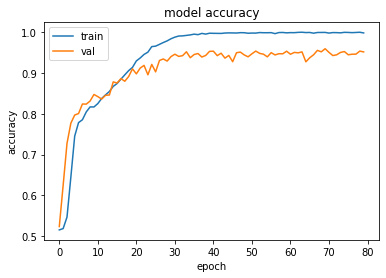

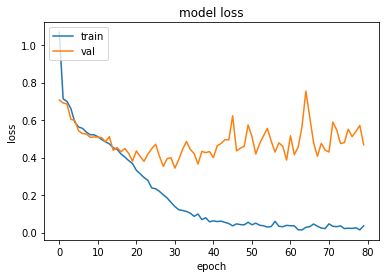

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.43459632992744446 , AUC = 0.9520052075386047 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.9571591072444201
test 0.9611397664813643

-----------------------------------------------------------------


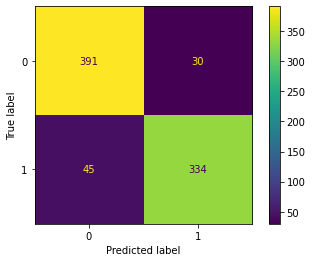

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5578204478480395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5698759997248608
117/117 - 22s - loss: 1.1056 - auc: 0.5243 - val_loss: 0.6878 - val_auc: 0.5578 - 22s/epoch - 186ms/step
Epoch 2/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7216184594978446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7651436039494994
117/117 - 20s - loss: 0.7087 - auc: 0.5748 - val_loss: 0.6558 - val_auc: 0.7209 - 20s/epoch - 168ms/step
Epoch 3/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7749435341079015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8196211832240071
117/117 - 20s - loss: 0.6245 - auc: 0.7107 - val_loss: 0.6006 - val_auc: 0.7750 - 20s/epoch - 168ms/step
Epoch 4/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7701947682239365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.806145611215678
117/117 - 20s - loss: 0.5914 - auc: 0.7463 - val_loss: 0.5805 - val_auc: 0.7696 - 20s/epoch - 167ms/step
Epoch 5/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7842971638793474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8252427791569482
117/117 - 20s - loss: 0.5665 - auc: 0.7747 - val_loss: 0.5650 - val_auc: 0.7841 - 20s/epoch - 167ms/step
Epoch 6/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7787600653189932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8152127014300989
117/117 - 20s - loss: 0.5535 - auc: 0.7890 - val_loss: 0.5627 - val_auc: 0.7788 - 20s/epoch - 168ms/step
Epoch 7/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8014778109378031


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8420700479617808
117/117 - 20s - loss: 0.5390 - auc: 0.8018 - val_loss: 0.5588 - val_auc: 0.8016 - 20s/epoch - 168ms/step
Epoch 8/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8044934962554198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8365485026794814
117/117 - 20s - loss: 0.5286 - auc: 0.8124 - val_loss: 0.5405 - val_auc: 0.8045 - 20s/epoch - 172ms/step
Epoch 9/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8102558327233139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8419950099737992
117/117 - 20s - loss: 0.5195 - auc: 0.8199 - val_loss: 0.5387 - val_auc: 0.8103 - 20s/epoch - 169ms/step
Epoch 10/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8010711313825228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8397688829970172
117/117 - 20s - loss: 0.5122 - auc: 0.8244 - val_loss: 0.5451 - val_auc: 0.8011 - 20s/epoch - 168ms/step
Epoch 11/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7978176949402807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8290009317216841
117/117 - 20s - loss: 0.4948 - auc: 0.8406 - val_loss: 0.5473 - val_auc: 0.7977 - 20s/epoch - 167ms/step
Epoch 12/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8160244257997511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8536696702705744
117/117 - 20s - loss: 0.4850 - auc: 0.8460 - val_loss: 0.5352 - val_auc: 0.8159 - 20s/epoch - 169ms/step
Epoch 13/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8199222929218988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8471038463222005
117/117 - 20s - loss: 0.4745 - auc: 0.8540 - val_loss: 0.5525 - val_auc: 0.8201 - 20s/epoch - 168ms/step
Epoch 14/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8092485187479275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8377240978245237
117/117 - 20s - loss: 0.4589 - auc: 0.8627 - val_loss: 0.5509 - val_auc: 0.8094 - 20s/epoch - 168ms/step
Epoch 15/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8175260118500166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8545513666293562
117/117 - 20s - loss: 0.4430 - auc: 0.8736 - val_loss: 0.5299 - val_auc: 0.8175 - 20s/epoch - 169ms/step
Epoch 16/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8133153143007301


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8492299226483407
117/117 - 20s - loss: 0.4327 - auc: 0.8794 - val_loss: 0.5480 - val_auc: 0.8133 - 20s/epoch - 167ms/step
Epoch 17/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8083663369433964


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8461158461471119
117/117 - 20s - loss: 0.4002 - auc: 0.8980 - val_loss: 0.6014 - val_auc: 0.8082 - 20s/epoch - 167ms/step
Epoch 18/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7975486607729414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8478667325333451
117/117 - 20s - loss: 0.3872 - auc: 0.9040 - val_loss: 0.6192 - val_auc: 0.7967 - 20s/epoch - 167ms/step
Epoch 19/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8010398483398089


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8306642737886055
117/117 - 20s - loss: 0.3599 - auc: 0.9182 - val_loss: 0.6009 - val_auc: 0.8009 - 20s/epoch - 168ms/step
Epoch 20/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8119764000725768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8448276940200978
117/117 - 20s - loss: 0.3518 - auc: 0.9218 - val_loss: 0.6235 - val_auc: 0.8118 - 20s/epoch - 167ms/step
Epoch 21/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8033547935006351


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8426828581969621
117/117 - 19s - loss: 0.3225 - auc: 0.9346 - val_loss: 0.6944 - val_auc: 0.8031 - 19s/epoch - 167ms/step
Epoch 22/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8212486939329667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8529630625504162
117/117 - 20s - loss: 0.3029 - auc: 0.9418 - val_loss: 0.6935 - val_auc: 0.8204 - 20s/epoch - 170ms/step
Epoch 23/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8161495579706065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8294261469869122
117/117 - 21s - loss: 0.2712 - auc: 0.9531 - val_loss: 0.6250 - val_auc: 0.8160 - 21s/epoch - 181ms/step
Epoch 24/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8014277580694609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8365610090108118
117/117 - 19s - loss: 0.2600 - auc: 0.9579 - val_loss: 0.7674 - val_auc: 0.8005 - 19s/epoch - 166ms/step
Epoch 25/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8144978133153142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8475415679187589
117/117 - 19s - loss: 0.2465 - auc: 0.9618 - val_loss: 0.7231 - val_auc: 0.8128 - 19s/epoch - 166ms/step
Epoch 26/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8010773879910655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8277190327603351
117/117 - 20s - loss: 0.2120 - auc: 0.9721 - val_loss: 0.7605 - val_auc: 0.8011 - 20s/epoch - 167ms/step
Epoch 27/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8276867441234805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8571089113863893
117/117 - 20s - loss: 0.1949 - auc: 0.9766 - val_loss: 0.9438 - val_auc: 0.8250 - 20s/epoch - 168ms/step
Epoch 28/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8065519204659921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.834247337714718
117/117 - 20s - loss: 0.1838 - auc: 0.9787 - val_loss: 0.8476 - val_auc: 0.8055 - 20s/epoch - 167ms/step
Epoch 29/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8059700558715143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8370612622640212
117/117 - 20s - loss: 0.1678 - auc: 0.9826 - val_loss: 0.8454 - val_auc: 0.8057 - 20s/epoch - 168ms/step
Epoch 30/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8068365961546883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8311082485508288
117/117 - 20s - loss: 0.1417 - auc: 0.9877 - val_loss: 1.2953 - val_auc: 0.7848 - 20s/epoch - 169ms/step
Epoch 31/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7897560548329172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8326996792126014
117/117 - 20s - loss: 0.1370 - auc: 0.9880 - val_loss: 1.3382 - val_auc: 0.7835 - 20s/epoch - 167ms/step
Epoch 32/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8133465973434439


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8430080228115483
117/117 - 20s - loss: 0.1366 - auc: 0.9885 - val_loss: 0.9027 - val_auc: 0.8123 - 20s/epoch - 167ms/step
Epoch 33/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8012525730302633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.835197818895816
117/117 - 19s - loss: 0.1200 - auc: 0.9910 - val_loss: 1.2218 - val_auc: 0.7927 - 19s/epoch - 167ms/step
Epoch 34/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8288692431380646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8496238720852429
117/117 - 20s - loss: 0.1238 - auc: 0.9900 - val_loss: 0.7942 - val_auc: 0.8290 - 20s/epoch - 167ms/step
Epoch 35/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8117198791223229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8503492393023969
117/117 - 20s - loss: 0.0954 - auc: 0.9942 - val_loss: 1.0625 - val_auc: 0.8055 - 20s/epoch - 167ms/step
Epoch 36/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8333364616376047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8495457075144291
117/117 - 20s - loss: 0.0899 - auc: 0.9946 - val_loss: 0.9496 - val_auc: 0.8302 - 20s/epoch - 167ms/step
Epoch 37/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8193247868060639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8446275927188138
117/117 - 19s - loss: 0.0682 - auc: 0.9971 - val_loss: 1.2228 - val_auc: 0.8125 - 19s/epoch - 166ms/step
Epoch 38/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8159493464972377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.837105034423677
117/117 - 20s - loss: 0.0836 - auc: 0.9951 - val_loss: 1.0405 - val_auc: 0.8125 - 20s/epoch - 167ms/step
Epoch 39/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8314845055089438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8605106335082134
117/117 - 20s - loss: 0.0782 - auc: 0.9954 - val_loss: 1.3014 - val_auc: 0.8198 - 20s/epoch - 167ms/step
Epoch 40/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.823491688095551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8559489491555099
117/117 - 20s - loss: 0.0596 - auc: 0.9976 - val_loss: 1.3581 - val_auc: 0.8120 - 20s/epoch - 167ms/step
Epoch 41/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8255657538274803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8460533144904608
117/117 - 19s - loss: 0.0692 - auc: 0.9960 - val_loss: 1.2258 - val_auc: 0.8208 - 19s/epoch - 166ms/step
Epoch 42/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8171912832929783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8358481481249882
117/117 - 19s - loss: 0.0709 - auc: 0.9967 - val_loss: 1.2750 - val_auc: 0.8110 - 19s/epoch - 166ms/step
Epoch 43/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8388923300235874


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8544794552242072
117/117 - 20s - loss: 0.0459 - auc: 0.9980 - val_loss: 1.3466 - val_auc: 0.8268 - 20s/epoch - 169ms/step
Epoch 44/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8249682477116455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8617800261382325
117/117 - 20s - loss: 0.0402 - auc: 0.9990 - val_loss: 1.4963 - val_auc: 0.8117 - 20s/epoch - 167ms/step
Epoch 45/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8402687839029975


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8569088100851056
117/117 - 20s - loss: 0.0644 - auc: 0.9965 - val_loss: 1.1655 - val_auc: 0.8340 - 20s/epoch - 167ms/step
Epoch 46/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8218180453103592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8508401128071086
117/117 - 20s - loss: 0.0455 - auc: 0.9987 - val_loss: 1.4385 - val_auc: 0.8131 - 20s/epoch - 168ms/step
Epoch 47/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8492908134216768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8615893045854464
117/117 - 19s - loss: 0.0521 - auc: 0.9978 - val_loss: 1.3422 - val_auc: 0.8386 - 19s/epoch - 167ms/step
Epoch 48/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834916255294655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.855820759259375
117/117 - 19s - loss: 0.0391 - auc: 0.9988 - val_loss: 1.4515 - val_auc: 0.8200 - 19s/epoch - 166ms/step
Epoch 49/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.815320557338689


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8560052276464961
117/117 - 20s - loss: 0.0330 - auc: 0.9991 - val_loss: 1.7206 - val_auc: 0.7950 - 20s/epoch - 169ms/step
Epoch 50/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8195312548879754


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8404598578030129
117/117 - 20s - loss: 0.0485 - auc: 0.9972 - val_loss: 1.6331 - val_auc: 0.8118 - 20s/epoch - 168ms/step
Epoch 51/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8453272519098297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8649628874617775
117/117 - 20s - loss: 0.0476 - auc: 0.9984 - val_loss: 1.1984 - val_auc: 0.8335 - 20s/epoch - 167ms/step
Epoch 52/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.840490893506266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8717569519569281
117/117 - 20s - loss: 0.0228 - auc: 0.9996 - val_loss: 1.4121 - val_auc: 0.8274 - 20s/epoch - 167ms/step
Epoch 53/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8308963843059232


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.860407456274739
117/117 - 20s - loss: 0.0314 - auc: 0.9986 - val_loss: 1.4887 - val_auc: 0.8220 - 20s/epoch - 168ms/step
Epoch 54/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8275991516038816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8515498471100995
117/117 - 19s - loss: 0.0415 - auc: 0.9987 - val_loss: 1.4320 - val_auc: 0.8118 - 19s/epoch - 166ms/step
Epoch 55/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8336524203690145


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.862896216209456
117/117 - 20s - loss: 0.0229 - auc: 0.9995 - val_loss: 1.6491 - val_auc: 0.8199 - 20s/epoch - 167ms/step
Epoch 56/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.840847520193204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8587034686309944
117/117 - 20s - loss: 0.0426 - auc: 0.9987 - val_loss: 1.4859 - val_auc: 0.8174 - 20s/epoch - 169ms/step
Epoch 57/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8192215527651081


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8443336939325534
117/117 - 20s - loss: 0.0494 - auc: 0.9978 - val_loss: 1.2773 - val_auc: 0.8086 - 20s/epoch - 168ms/step
Epoch 58/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8477297895902547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8643438240609309
117/117 - 20s - loss: 0.0429 - auc: 0.9980 - val_loss: 1.2069 - val_auc: 0.8412 - 20s/epoch - 167ms/step
Epoch 59/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.831534558377286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8507619482362947
117/117 - 20s - loss: 0.0316 - auc: 0.9987 - val_loss: 1.3720 - val_auc: 0.8142 - 20s/epoch - 167ms/step
Epoch 60/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8428183518841776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8645470519450471
117/117 - 20s - loss: 0.0249 - auc: 0.9996 - val_loss: 1.5517 - val_auc: 0.8322 - 20s/epoch - 167ms/step
Epoch 61/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8438944885535347


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8634464947879863
117/117 - 20s - loss: 0.0157 - auc: 0.9999 - val_loss: 1.5193 - val_auc: 0.8304 - 20s/epoch - 168ms/step
Epoch 62/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8287879072270086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8634058492111631
117/117 - 20s - loss: 0.0521 - auc: 0.9971 - val_loss: 1.4268 - val_auc: 0.8155 - 20s/epoch - 167ms/step
Epoch 63/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8320945248418642


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8641749885879727
117/117 - 20s - loss: 0.0263 - auc: 0.9996 - val_loss: 1.5350 - val_auc: 0.8235 - 20s/epoch - 167ms/step
Epoch 64/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8237794920885185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8586940888824968
117/117 - 20s - loss: 0.0284 - auc: 0.9995 - val_loss: 1.4529 - val_auc: 0.8174 - 20s/epoch - 169ms/step
Epoch 65/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8348724590348555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8643406974780983
117/117 - 20s - loss: 0.0225 - auc: 0.9997 - val_loss: 1.6243 - val_auc: 0.8152 - 20s/epoch - 168ms/step
Epoch 66/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.826485475283268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8552267085211889
117/117 - 20s - loss: 0.0250 - auc: 0.9991 - val_loss: 1.5261 - val_auc: 0.8138 - 20s/epoch - 167ms/step
Epoch 67/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.830255081930289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8436177064638974
117/117 - 20s - loss: 0.0382 - auc: 0.9988 - val_loss: 1.4607 - val_auc: 0.8118 - 20s/epoch - 167ms/step
Epoch 68/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8254562631779818


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8565898986361845
117/117 - 20s - loss: 0.0255 - auc: 0.9991 - val_loss: 1.4901 - val_auc: 0.8059 - 20s/epoch - 167ms/step
Epoch 69/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8304865764463714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8583001394455945
117/117 - 19s - loss: 0.0212 - auc: 0.9995 - val_loss: 1.5605 - val_auc: 0.8139 - 19s/epoch - 166ms/step
Epoch 70/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.800351621400104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8229478673578497
117/117 - 20s - loss: 0.0409 - auc: 0.9983 - val_loss: 1.4086 - val_auc: 0.7943 - 20s/epoch - 167ms/step
Epoch 71/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.839180134016555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8703781289277696
117/117 - 20s - loss: 0.0271 - auc: 0.9996 - val_loss: 1.4852 - val_auc: 0.8288 - 20s/epoch - 168ms/step
Epoch 72/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8274020684347841


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8493330998818153
117/117 - 19s - loss: 0.0193 - auc: 0.9995 - val_loss: 1.5879 - val_auc: 0.8162 - 19s/epoch - 167ms/step
Epoch 73/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8385357033366494


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8561240377941333
117/117 - 20s - loss: 0.0340 - auc: 0.9988 - val_loss: 1.3715 - val_auc: 0.8268 - 20s/epoch - 169ms/step
Epoch 74/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.82612884859633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8403473008210406
117/117 - 20s - loss: 0.0339 - auc: 0.9985 - val_loss: 1.4448 - val_auc: 0.8142 - 20s/epoch - 168ms/step
Epoch 75/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8336962166288141


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8468943652724191
117/117 - 20s - loss: 0.0330 - auc: 0.9993 - val_loss: 1.5856 - val_auc: 0.8268 - 20s/epoch - 167ms/step
Epoch 76/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.80298252529234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8386964650854495
117/117 - 19s - loss: 0.0241 - auc: 0.9991 - val_loss: 1.8035 - val_auc: 0.7910 - 19s/epoch - 166ms/step
Epoch 77/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8294260812983714


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8509995685315691
117/117 - 20s - loss: 0.0268 - auc: 0.9996 - val_loss: 1.6740 - val_auc: 0.8147 - 20s/epoch - 167ms/step
Epoch 78/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834737941951186


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8553392655031611
117/117 - 20s - loss: 0.0346 - auc: 0.9993 - val_loss: 1.4318 - val_auc: 0.8242 - 20s/epoch - 167ms/step
Epoch 79/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8460780449349625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8603918233605763
117/117 - 20s - loss: 0.0290 - auc: 0.9993 - val_loss: 1.5748 - val_auc: 0.8317 - 20s/epoch - 168ms/step
Epoch 80/80


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8495817457189155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8696590148762811
117/117 - 20s - loss: 0.0076 - auc: 1.0000 - val_loss: 1.7394 - val_auc: 0.8369 - 20s/epoch - 170ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


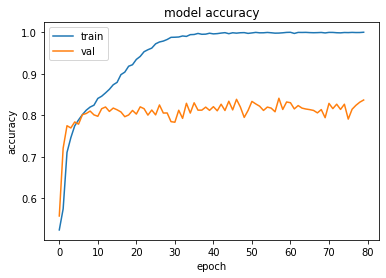

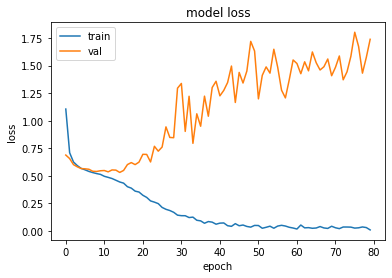

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.5504040718078613 , AUC = 0.860135555267334 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8495817457189155
test 0.8696590148762811

-----------------------------------------------------------------


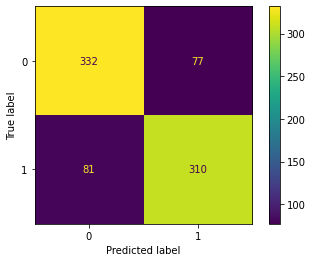

In [ ]:
# Create directory to save models
rt_sv_dir = '/content/models/80'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])
  
  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=80,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 800
acc:  0.75375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.9857426285743713 , AUC = 0.8363203406333923 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8237012844817339
test 0.8386683258399564

-----------------------------------------------------------------


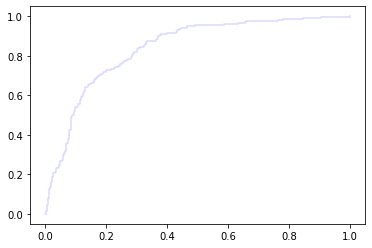

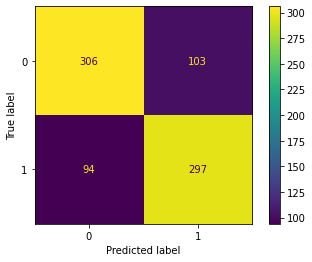

1
Num_samples: 800
acc:  0.785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.902667224407196 , AUC = 0.8524346351623535 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.830968335304165
test 0.8547452147649748

-----------------------------------------------------------------


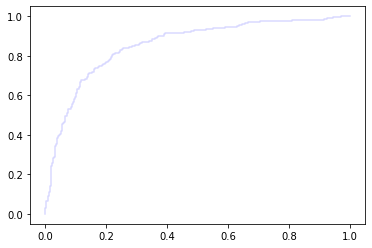

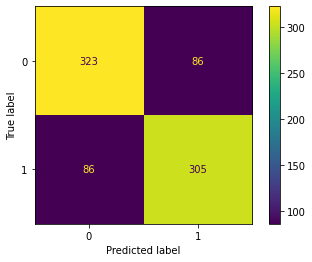

2
Num_samples: 800
acc:  0.76375


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.7204487323760986 , AUC = 0.824117124080658 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8030419630734964
test 0.8247925512290597

-----------------------------------------------------------------


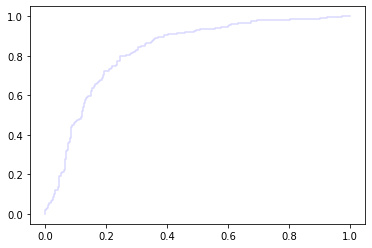

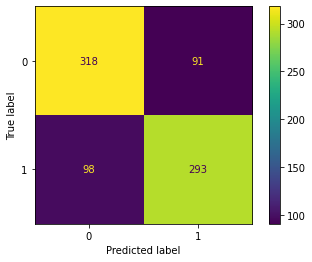

3
Num_samples: 800
acc:  0.79625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.7509820461273193 , AUC = 0.8484076261520386 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8260850523365304
test 0.8539385563941746

-----------------------------------------------------------------


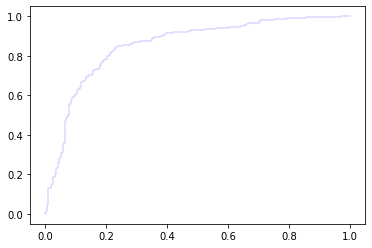

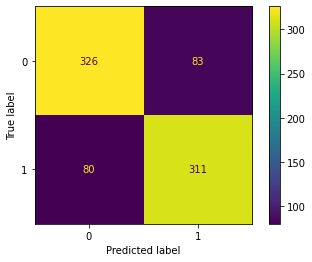

4
Num_samples: 800
acc:  0.785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.4787102937698364 , AUC = 0.8545450568199158 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8175260118500166
test 0.8545513666293562

-----------------------------------------------------------------


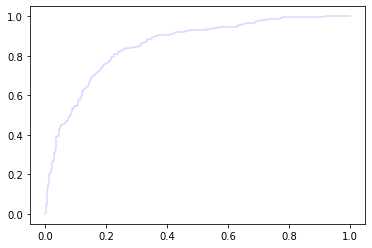

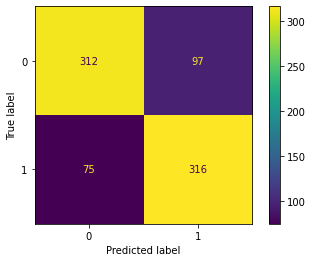

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


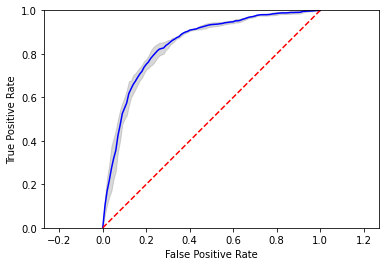

In [ ]:

# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/80/0/040--0.315--0.074.hdf5',
          1: '/content/models/80/1/040--0.356--0.062.hdf5',
          2: '/content/models/80/2/030--0.364--0.182.hdf5',
          3: '/content/models/80/3/031--0.344--0.139.hdf5',
          4: '/content/models/80/4/015--0.530--0.443.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]


  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  
  MERGM_Record1 = model.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = model.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = model.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

  


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [ ]:
'''from google.colab import drive
drive.mount('/content/gdrive')'''

Mounted at /content/gdrive


**150 epoch**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5650121764454821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5527159544747156
118/118 - 26s - loss: 0.9963 - auc: 0.5237 - val_loss: 0.7535 - val_auc: 0.5647 - 26s/epoch - 220ms/step
Epoch 2/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.63181316060355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6371039818998868
118/118 - 17s - loss: 0.7222 - auc: 0.5394 - val_loss: 0.6801 - val_auc: 0.6301 - 17s/epoch - 146ms/step
Epoch 3/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7699593281614823


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.81613010081313
118/118 - 17s - loss: 0.6412 - auc: 0.6816 - val_loss: 0.6106 - val_auc: 0.7697 - 17s/epoch - 145ms/step
Epoch 4/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7785142225904444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8281676760479753
118/118 - 17s - loss: 0.5763 - auc: 0.7631 - val_loss: 0.5537 - val_auc: 0.7785 - 17s/epoch - 146ms/step
Epoch 5/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7872762421229695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8198863742898393
118/118 - 17s - loss: 0.5541 - auc: 0.7867 - val_loss: 0.5509 - val_auc: 0.7873 - 17s/epoch - 145ms/step
Epoch 6/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7909480053224875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8316926980793629
118/118 - 17s - loss: 0.5537 - auc: 0.7889 - val_loss: 0.5541 - val_auc: 0.7908 - 17s/epoch - 144ms/step
Epoch 7/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7974881373804322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8283426771417322
118/118 - 17s - loss: 0.5379 - auc: 0.8008 - val_loss: 0.5362 - val_auc: 0.7971 - 17s/epoch - 148ms/step
Epoch 8/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.801197559689689


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8320114500715629
118/118 - 18s - loss: 0.5199 - auc: 0.8178 - val_loss: 0.5421 - val_auc: 0.8013 - 18s/epoch - 149ms/step
Epoch 9/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7913873616027718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8160426002662515
118/118 - 17s - loss: 0.5053 - auc: 0.8309 - val_loss: 0.6247 - val_auc: 0.7911 - 17s/epoch - 146ms/step
Epoch 10/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8053526147975194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8346114663216644
118/118 - 18s - loss: 0.4972 - auc: 0.8365 - val_loss: 0.5589 - val_auc: 0.8054 - 18s/epoch - 149ms/step
Epoch 11/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7836546910697699


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.819723873274208
118/118 - 17s - loss: 0.4913 - auc: 0.8400 - val_loss: 0.6521 - val_auc: 0.7839 - 17s/epoch - 145ms/step
Epoch 12/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8067648314127188


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8219676372977333
118/118 - 17s - loss: 0.4753 - auc: 0.8524 - val_loss: 0.5375 - val_auc: 0.8070 - 17s/epoch - 147ms/step
Epoch 13/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8181127764806307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8419802623766398
118/118 - 17s - loss: 0.4590 - auc: 0.8647 - val_loss: 0.5532 - val_auc: 0.8181 - 17s/epoch - 147ms/step
Epoch 14/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8185646857974944


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8257114106963168
118/118 - 17s - loss: 0.4431 - auc: 0.8727 - val_loss: 0.5369 - val_auc: 0.8187 - 17s/epoch - 147ms/step
Epoch 15/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8134367703547488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8249489059306621
118/118 - 18s - loss: 0.4200 - auc: 0.8864 - val_loss: 0.5598 - val_auc: 0.8132 - 18s/epoch - 151ms/step
Epoch 16/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8121061484773167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8131238320239501
118/118 - 18s - loss: 0.4068 - auc: 0.8960 - val_loss: 0.6383 - val_auc: 0.8121 - 18s/epoch - 150ms/step
Epoch 17/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8156147222013004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8164988531178319
118/118 - 18s - loss: 0.3856 - auc: 0.9056 - val_loss: 0.5366 - val_auc: 0.8158 - 18s/epoch - 151ms/step
Epoch 18/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8280798875247921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8276864230401442
118/118 - 17s - loss: 0.3813 - auc: 0.9078 - val_loss: 0.5638 - val_auc: 0.8280 - 17s/epoch - 146ms/step
Epoch 19/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8043860309808943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8135363346020914
118/118 - 17s - loss: 0.3615 - auc: 0.9178 - val_loss: 0.6695 - val_auc: 0.8041 - 17s/epoch - 146ms/step
Epoch 20/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.821577414576586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8291176819855124
118/118 - 17s - loss: 0.3254 - auc: 0.9332 - val_loss: 0.5954 - val_auc: 0.8211 - 17s/epoch - 147ms/step
Epoch 21/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8087544877105771


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8138050862817892
118/118 - 17s - loss: 0.3105 - auc: 0.9401 - val_loss: 0.6478 - val_auc: 0.8088 - 17s/epoch - 146ms/step
Epoch 22/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7886570761467199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7884486778042364
118/118 - 17s - loss: 0.2815 - auc: 0.9507 - val_loss: 0.7239 - val_auc: 0.7885 - 17s/epoch - 146ms/step
Epoch 23/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7894071200823479


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7844799029993937
118/118 - 17s - loss: 0.2742 - auc: 0.9528 - val_loss: 0.8186 - val_auc: 0.7889 - 17s/epoch - 147ms/step
Epoch 24/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8113278602093847


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8159550997193732
118/118 - 17s - loss: 0.2659 - auc: 0.9561 - val_loss: 0.7632 - val_auc: 0.8101 - 17s/epoch - 147ms/step
Epoch 25/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7975571790816199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.810258189113682
118/118 - 17s - loss: 0.2181 - auc: 0.9706 - val_loss: 0.8243 - val_auc: 0.7958 - 17s/epoch - 145ms/step
Epoch 26/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8135874067937034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.825386408665054
118/118 - 17s - loss: 0.2084 - auc: 0.9736 - val_loss: 0.9277 - val_auc: 0.8121 - 17s/epoch - 145ms/step
Epoch 27/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8060053726996561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.797836236476478
118/118 - 17s - loss: 0.1930 - auc: 0.9770 - val_loss: 0.8542 - val_auc: 0.8052 - 17s/epoch - 146ms/step
Epoch 28/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8292535964449801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8134394589966187
118/118 - 17s - loss: 0.1757 - auc: 0.9810 - val_loss: 0.8034 - val_auc: 0.8287 - 17s/epoch - 146ms/step
Epoch 29/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8151314302929878


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8069300433127706
118/118 - 17s - loss: 0.1669 - auc: 0.9825 - val_loss: 0.7104 - val_auc: 0.8142 - 17s/epoch - 148ms/step
Epoch 30/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8219853882654213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8162738517115733
118/118 - 17s - loss: 0.1487 - auc: 0.9862 - val_loss: 0.8666 - val_auc: 0.8205 - 17s/epoch - 146ms/step
Epoch 31/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834287364113379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8375364846030288
118/118 - 17s - loss: 0.1136 - auc: 0.9918 - val_loss: 0.8989 - val_auc: 0.8314 - 17s/epoch - 146ms/step
Epoch 32/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8307160252064973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8428552678454239
118/118 - 17s - loss: 0.1203 - auc: 0.9911 - val_loss: 0.9916 - val_auc: 0.8261 - 17s/epoch - 148ms/step
Epoch 33/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8360824483442545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8125269532934581
118/118 - 18s - loss: 0.1163 - auc: 0.9917 - val_loss: 1.0522 - val_auc: 0.8305 - 18s/epoch - 149ms/step
Epoch 34/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.808569330421029


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8286458040362752
118/118 - 17s - loss: 0.1055 - auc: 0.9928 - val_loss: 1.1561 - val_auc: 0.8038 - 17s/epoch - 146ms/step
Epoch 35/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8145539906103286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8273051706573166
118/118 - 17s - loss: 0.0940 - auc: 0.9943 - val_loss: 1.1443 - val_auc: 0.8104 - 17s/epoch - 148ms/step
Epoch 36/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8276311164670733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8493490584316152
118/118 - 17s - loss: 0.0940 - auc: 0.9939 - val_loss: 1.1433 - val_auc: 0.8203 - 17s/epoch - 147ms/step
Epoch 37/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8265421405437976


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8228020175126094
118/118 - 18s - loss: 0.0713 - auc: 0.9964 - val_loss: 1.1381 - val_auc: 0.8212 - 18s/epoch - 151ms/step
Epoch 38/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7703045366674199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7887799298745616
118/118 - 17s - loss: 0.0793 - auc: 0.9956 - val_loss: 1.5778 - val_auc: 0.7623 - 17s/epoch - 146ms/step
Epoch 39/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8064666967939544


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8345958412240075
118/118 - 17s - loss: 0.0704 - auc: 0.9964 - val_loss: 1.3459 - val_auc: 0.7938 - 17s/epoch - 146ms/step
Epoch 40/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8140016570008284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8304051900324376
118/118 - 17s - loss: 0.0734 - auc: 0.9961 - val_loss: 1.3169 - val_auc: 0.8060 - 17s/epoch - 146ms/step
Epoch 41/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8212259295523587


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8301020631378946
118/118 - 17s - loss: 0.0619 - auc: 0.9972 - val_loss: 1.3533 - val_auc: 0.8114 - 17s/epoch - 145ms/step
Epoch 42/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.844800532248751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8440115250720317
118/118 - 17s - loss: 0.0605 - auc: 0.9970 - val_loss: 1.0895 - val_auc: 0.8424 - 17s/epoch - 146ms/step
Epoch 43/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.84329730611835


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8501646885293032
118/118 - 17s - loss: 0.0509 - auc: 0.9978 - val_loss: 1.2311 - val_auc: 0.8288 - 17s/epoch - 147ms/step
Epoch 44/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8331795586352339


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8472709204432529
118/118 - 17s - loss: 0.0452 - auc: 0.9974 - val_loss: 1.3123 - val_auc: 0.8229 - 17s/epoch - 146ms/step
Epoch 45/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8436958650297506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8682991768698554
118/118 - 17s - loss: 0.0350 - auc: 0.9987 - val_loss: 1.3490 - val_auc: 0.8256 - 17s/epoch - 147ms/step
Epoch 46/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8347832090582713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8581866136663354
118/118 - 17s - loss: 0.0707 - auc: 0.9961 - val_loss: 1.3071 - val_auc: 0.8251 - 17s/epoch - 146ms/step
Epoch 47/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8236423890939218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434333964587278
118/118 - 17s - loss: 0.0414 - auc: 0.9987 - val_loss: 1.3163 - val_auc: 0.8118 - 17s/epoch - 146ms/step
Epoch 48/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8007990007782883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8134300839380246
118/118 - 17s - loss: 0.0478 - auc: 0.9986 - val_loss: 2.0225 - val_auc: 0.7864 - 17s/epoch - 145ms/step
Epoch 49/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8213043860309809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8368552303451896
118/118 - 17s - loss: 0.0480 - auc: 0.9984 - val_loss: 1.5986 - val_auc: 0.8156 - 17s/epoch - 147ms/step
Epoch 50/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8181378825537897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8200113750710941
118/118 - 17s - loss: 0.0434 - auc: 0.9982 - val_loss: 1.8024 - val_auc: 0.8018 - 17s/epoch - 148ms/step
Epoch 51/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8356368155456805


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8433365208532553
118/118 - 17s - loss: 0.0464 - auc: 0.9978 - val_loss: 1.3892 - val_auc: 0.8270 - 17s/epoch - 147ms/step
Epoch 52/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8241570635936833


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8376989856186601
118/118 - 17s - loss: 0.0673 - auc: 0.9965 - val_loss: 1.3401 - val_auc: 0.8171 - 17s/epoch - 146ms/step
Epoch 53/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8268747960131555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8417615110094439
118/118 - 17s - loss: 0.0349 - auc: 0.9993 - val_loss: 1.4872 - val_auc: 0.8225 - 17s/epoch - 146ms/step
Epoch 54/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8306438452461651


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8490553065956662
118/118 - 17s - loss: 0.0364 - auc: 0.9987 - val_loss: 1.4978 - val_auc: 0.8249 - 17s/epoch - 145ms/step
Epoch 55/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.829005673972534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8458646616541352
118/118 - 17s - loss: 0.0381 - auc: 0.9986 - val_loss: 1.6160 - val_auc: 0.8087 - 17s/epoch - 146ms/step
Epoch 56/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8424625291858101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8361114756967232
118/118 - 17s - loss: 0.0377 - auc: 0.9992 - val_loss: 1.1855 - val_auc: 0.8344 - 17s/epoch - 146ms/step
Epoch 57/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8323730260349979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8310489440559002
118/118 - 17s - loss: 0.0391 - auc: 0.9986 - val_loss: 1.2753 - val_auc: 0.8217 - 17s/epoch - 147ms/step
Epoch 58/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8301699681152872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8395239970249814
118/118 - 17s - loss: 0.0266 - auc: 0.9991 - val_loss: 1.6225 - val_auc: 0.8153 - 17s/epoch - 145ms/step
Epoch 59/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8298278978684944


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.832055200345002
118/118 - 17s - loss: 0.0346 - auc: 0.9988 - val_loss: 1.6094 - val_auc: 0.8070 - 17s/epoch - 144ms/step
Epoch 60/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8284721699179032


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8437052731579573
118/118 - 17s - loss: 0.0452 - auc: 0.9981 - val_loss: 1.3732 - val_auc: 0.8168 - 17s/epoch - 147ms/step
Epoch 61/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8328531796841657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8314208213801336
118/118 - 17s - loss: 0.0326 - auc: 0.9993 - val_loss: 1.7642 - val_auc: 0.8106 - 17s/epoch - 146ms/step
Epoch 62/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8344944892169416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8494896843105271
118/118 - 17s - loss: 0.0406 - auc: 0.9989 - val_loss: 1.4103 - val_auc: 0.8255 - 17s/epoch - 146ms/step
Epoch 63/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8406705832140795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8551272195451222
118/118 - 17s - loss: 0.0165 - auc: 0.9995 - val_loss: 1.5936 - val_auc: 0.8302 - 17s/epoch - 147ms/step
Epoch 64/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8371557329718059


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8389239932749579
118/118 - 17s - loss: 0.0220 - auc: 0.9994 - val_loss: 1.6165 - val_auc: 0.8215 - 17s/epoch - 145ms/step
Epoch 65/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.805587984233386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8209238807742548
118/118 - 17s - loss: 0.0478 - auc: 0.9980 - val_loss: 1.7807 - val_auc: 0.7805 - 17s/epoch - 147ms/step
Epoch 66/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8344411388114785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.832742704641904
118/118 - 18s - loss: 0.0300 - auc: 0.9989 - val_loss: 1.6064 - val_auc: 0.8142 - 18s/epoch - 151ms/step
Epoch 67/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8396883081017298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8473302958143488
118/118 - 18s - loss: 0.0292 - auc: 0.9992 - val_loss: 1.4527 - val_auc: 0.8303 - 18s/epoch - 149ms/step
Epoch 68/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8267712334613744


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8362177263607898
118/118 - 17s - loss: 0.0408 - auc: 0.9983 - val_loss: 1.2736 - val_auc: 0.8228 - 17s/epoch - 148ms/step
Epoch 69/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8285663176922498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434865217907612
118/118 - 17s - loss: 0.0329 - auc: 0.9987 - val_loss: 1.3518 - val_auc: 0.8210 - 17s/epoch - 147ms/step
Epoch 70/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8118801938188848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8286458040362752
118/118 - 17s - loss: 0.0348 - auc: 0.9983 - val_loss: 1.5820 - val_auc: 0.8010 - 17s/epoch - 148ms/step
Epoch 71/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8311679345233611


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8520709504434402
118/118 - 17s - loss: 0.0212 - auc: 0.9997 - val_loss: 1.5186 - val_auc: 0.8102 - 17s/epoch - 147ms/step
Epoch 72/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8247062589440386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8440146500915632
118/118 - 17s - loss: 0.0484 - auc: 0.9984 - val_loss: 1.2415 - val_auc: 0.8173 - 17s/epoch - 148ms/step
Epoch 73/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8489022369511184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8367489796811229
118/118 - 17s - loss: 0.0214 - auc: 0.9997 - val_loss: 1.3425 - val_auc: 0.8373 - 17s/epoch - 148ms/step
Epoch 74/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8405356380708493


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434208963806024
118/118 - 17s - loss: 0.0186 - auc: 0.9998 - val_loss: 1.8748 - val_auc: 0.8203 - 17s/epoch - 148ms/step
Epoch 75/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8369674374231125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.848424052650329
118/118 - 17s - loss: 0.0319 - auc: 0.9989 - val_loss: 1.4590 - val_auc: 0.8239 - 17s/epoch - 148ms/step
Epoch 76/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8332360472998419


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8452365327283295
118/118 - 17s - loss: 0.0235 - auc: 0.9991 - val_loss: 1.7630 - val_auc: 0.8179 - 17s/epoch - 148ms/step
Epoch 77/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8285286585825111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8510959443496522
118/118 - 17s - loss: 0.0224 - auc: 0.9992 - val_loss: 1.9688 - val_auc: 0.8103 - 17s/epoch - 147ms/step
Epoch 78/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834513318771811


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8557928487053044
118/118 - 17s - loss: 0.0334 - auc: 0.9986 - val_loss: 1.5726 - val_auc: 0.8219 - 17s/epoch - 148ms/step
Epoch 79/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8167947076397781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8338427115169469
118/118 - 17s - loss: 0.0257 - auc: 0.9994 - val_loss: 1.5764 - val_auc: 0.8051 - 17s/epoch - 147ms/step
Epoch 80/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461688132359217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8545522159513497
118/118 - 17s - loss: 0.0371 - auc: 0.9989 - val_loss: 1.3180 - val_auc: 0.8328 - 17s/epoch - 148ms/step
Epoch 81/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8186745248675654


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8368708554428466
118/118 - 18s - loss: 0.0184 - auc: 0.9998 - val_loss: 1.7606 - val_auc: 0.8001 - 18s/epoch - 150ms/step
Epoch 82/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.818071979111747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8124457027856424
118/118 - 18s - loss: 0.0160 - auc: 0.9993 - val_loss: 2.0826 - val_auc: 0.7974 - 18s/epoch - 152ms/step
Epoch 83/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8356054329542316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8461490384314901
118/118 - 18s - loss: 0.0343 - auc: 0.9982 - val_loss: 1.4003 - val_auc: 0.8215 - 18s/epoch - 150ms/step
Epoch 84/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8275526599884511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8414302589391185
118/118 - 18s - loss: 0.0242 - auc: 0.9994 - val_loss: 1.8193 - val_auc: 0.8094 - 18s/epoch - 148ms/step
Epoch 85/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8379308829805929


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8635241470259188
118/118 - 18s - loss: 0.0147 - auc: 0.9996 - val_loss: 1.7542 - val_auc: 0.8154 - 18s/epoch - 151ms/step
Epoch 86/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8408118048755994


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8405771286070538
118/118 - 18s - loss: 0.0227 - auc: 0.9995 - val_loss: 1.4661 - val_auc: 0.8282 - 18s/epoch - 149ms/step
Epoch 87/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8350876201953253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8455021593884962
118/118 - 18s - loss: 0.0171 - auc: 0.9996 - val_loss: 1.7279 - val_auc: 0.8154 - 18s/epoch - 151ms/step
Epoch 88/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8326680223946172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8383989899936874
118/118 - 18s - loss: 0.0150 - auc: 0.9998 - val_loss: 1.7635 - val_auc: 0.8083 - 18s/epoch - 151ms/step
Epoch 89/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8182351685872813


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8471927949549684
118/118 - 18s - loss: 0.0346 - auc: 0.9984 - val_loss: 1.5725 - val_auc: 0.8000 - 18s/epoch - 149ms/step
Epoch 90/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.831337400517185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8445021531384571
118/118 - 18s - loss: 0.0167 - auc: 0.9996 - val_loss: 1.8105 - val_auc: 0.8167 - 18s/epoch - 150ms/step
Epoch 91/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8369391930908086


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8511615697598109
118/118 - 17s - loss: 0.0464 - auc: 0.9977 - val_loss: 1.5482 - val_auc: 0.8194 - 17s/epoch - 148ms/step
Epoch 92/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8139043709673369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8354114713216956
118/118 - 18s - loss: 0.0310 - auc: 0.9989 - val_loss: 1.7185 - val_auc: 0.7973 - 18s/epoch - 149ms/step
Epoch 93/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8227856443473676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8420490128063299
118/118 - 18s - loss: 0.0167 - auc: 0.9998 - val_loss: 1.5897 - val_auc: 0.8114 - 18s/epoch - 149ms/step
Epoch 94/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8231245763350153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8301770636066476
118/118 - 18s - loss: 0.0157 - auc: 0.9999 - val_loss: 2.2262 - val_auc: 0.8015 - 18s/epoch - 150ms/step
Epoch 95/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8435420903316512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8534897093106832
118/118 - 18s - loss: 0.0301 - auc: 0.9985 - val_loss: 1.6400 - val_auc: 0.8202 - 18s/epoch - 150ms/step
Epoch 96/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8427543872862844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8478427990174938
118/118 - 18s - loss: 0.0158 - auc: 0.9996 - val_loss: 1.6852 - val_auc: 0.8242 - 18s/epoch - 148ms/step
Epoch 97/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8114031784288619


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8167394796217476
118/118 - 18s - loss: 0.0222 - auc: 0.9994 - val_loss: 1.9238 - val_auc: 0.7884 - 18s/epoch - 149ms/step
Epoch 98/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8260996460043685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8343802148763431
118/118 - 18s - loss: 0.0245 - auc: 0.9994 - val_loss: 1.7827 - val_auc: 0.8110 - 18s/epoch - 156ms/step
Epoch 99/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8255410358765786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8459552872205451
118/118 - 18s - loss: 0.0161 - auc: 0.9998 - val_loss: 1.8517 - val_auc: 0.8087 - 18s/epoch - 154ms/step
Epoch 100/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8339703999397453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.839580247376546
118/118 - 18s - loss: 0.0057 - auc: 1.0000 - val_loss: 2.0358 - val_auc: 0.8049 - 18s/epoch - 150ms/step
Epoch 101/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8326899902086314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8445834036462728
118/118 - 18s - loss: 0.0202 - auc: 0.9991 - val_loss: 1.5638 - val_auc: 0.8156 - 18s/epoch - 151ms/step
Epoch 102/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8300569907860712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.839714623216395
118/118 - 18s - loss: 0.0214 - auc: 0.9997 - val_loss: 1.8197 - val_auc: 0.8116 - 18s/epoch - 151ms/step
Epoch 103/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8359255353870101


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8513959462246639
118/118 - 18s - loss: 0.0155 - auc: 0.9996 - val_loss: 1.7600 - val_auc: 0.8134 - 18s/epoch - 150ms/step
Epoch 104/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8178962365996334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8288645554034713
118/118 - 18s - loss: 0.0367 - auc: 0.9988 - val_loss: 1.6493 - val_auc: 0.8075 - 18s/epoch - 149ms/step
Epoch 105/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8285443498782354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8430583941149633
118/118 - 18s - loss: 0.0141 - auc: 0.9996 - val_loss: 1.8781 - val_auc: 0.8162 - 18s/epoch - 150ms/step
Epoch 106/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8306815043559037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8254707841924012
118/118 - 18s - loss: 0.0185 - auc: 0.9993 - val_loss: 1.8431 - val_auc: 0.8038 - 18s/epoch - 150ms/step
Epoch 107/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8374099319625418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8334739592122451
118/118 - 18s - loss: 0.0275 - auc: 0.9988 - val_loss: 1.5060 - val_auc: 0.8266 - 18s/epoch - 149ms/step
Epoch 108/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8378838090934196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8411927574547341
118/118 - 17s - loss: 0.0185 - auc: 0.9998 - val_loss: 1.4724 - val_auc: 0.8249 - 17s/epoch - 148ms/step
Epoch 109/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8303268810725315


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8428833930212063
118/118 - 17s - loss: 0.0097 - auc: 0.9999 - val_loss: 1.5938 - val_auc: 0.8117 - 17s/epoch - 147ms/step
Epoch 110/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.828641635911727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8543615897599359
118/118 - 17s - loss: 0.0089 - auc: 1.0000 - val_loss: 2.1127 - val_auc: 0.8058 - 17s/epoch - 147ms/step
Epoch 111/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8271948984459341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8339083369271059
118/118 - 17s - loss: 0.0229 - auc: 0.9995 - val_loss: 1.6889 - val_auc: 0.8130 - 17s/epoch - 147ms/step
Epoch 112/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8149274434485703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8348239676497977
118/118 - 17s - loss: 0.0192 - auc: 0.9993 - val_loss: 1.7459 - val_auc: 0.7960 - 17s/epoch - 146ms/step
Epoch 113/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8454062162637143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8436802730017062
118/118 - 17s - loss: 0.0242 - auc: 0.9994 - val_loss: 1.7607 - val_auc: 0.8127 - 17s/epoch - 146ms/step
Epoch 114/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8419384399086138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.849549059681623
118/118 - 17s - loss: 0.0103 - auc: 0.9997 - val_loss: 1.8308 - val_auc: 0.8172 - 17s/epoch - 148ms/step
Epoch 115/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8382227410810674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8546334664591653
118/118 - 18s - loss: 0.0084 - auc: 1.0000 - val_loss: 2.0275 - val_auc: 0.8118 - 18s/epoch - 149ms/step
Epoch 116/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8129628932238708


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8269332933330834
118/118 - 17s - loss: 0.0261 - auc: 0.9989 - val_loss: 1.7874 - val_auc: 0.7923 - 17s/epoch - 148ms/step
Epoch 117/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8368042479475786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8470427940174625
118/118 - 17s - loss: 0.0241 - auc: 0.9990 - val_loss: 1.7893 - val_auc: 0.8100 - 17s/epoch - 146ms/step
Epoch 118/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.821803369235018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8392927455796599
118/118 - 18s - loss: 0.0374 - auc: 0.9981 - val_loss: 1.3813 - val_auc: 0.8109 - 18s/epoch - 148ms/step
Epoch 119/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8383357184102834


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8560303501896886
118/118 - 17s - loss: 0.0187 - auc: 0.9991 - val_loss: 1.6080 - val_auc: 0.8184 - 17s/epoch - 148ms/step
Epoch 120/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8397196906931786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8552115950724692
118/118 - 17s - loss: 0.0225 - auc: 0.9992 - val_loss: 1.6830 - val_auc: 0.8196 - 17s/epoch - 146ms/step
Epoch 121/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8403724485953153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8544303401896263
118/118 - 17s - loss: 0.0088 - auc: 0.9999 - val_loss: 1.9061 - val_auc: 0.8191 - 17s/epoch - 147ms/step
Epoch 122/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8361357987497176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.848145925912037
118/118 - 17s - loss: 0.0035 - auc: 1.0000 - val_loss: 2.2305 - val_auc: 0.8109 - 17s/epoch - 147ms/step
Epoch 123/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8299440134568551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8419177619860123
118/118 - 17s - loss: 0.0091 - auc: 0.9994 - val_loss: 1.9435 - val_auc: 0.8096 - 17s/epoch - 146ms/step
Epoch 124/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8431717757525545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8501959387246171
118/118 - 17s - loss: 0.0111 - auc: 0.9997 - val_loss: 1.8702 - val_auc: 0.8181 - 17s/epoch - 147ms/step
Epoch 125/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8433192739323643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8530272064200402
118/118 - 17s - loss: 0.0314 - auc: 0.9980 - val_loss: 1.5159 - val_auc: 0.8204 - 17s/epoch - 146ms/step
Epoch 126/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.844270166453265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8505209407558797
118/118 - 17s - loss: 0.0264 - auc: 0.9991 - val_loss: 1.5124 - val_auc: 0.8284 - 17s/epoch - 146ms/step
Epoch 127/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8434699103713189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8556865980412378
118/118 - 17s - loss: 0.0141 - auc: 0.9996 - val_loss: 1.5453 - val_auc: 0.8283 - 17s/epoch - 145ms/step
Epoch 128/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8391516657879541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8398989993687461
118/118 - 17s - loss: 0.0142 - auc: 0.9996 - val_loss: 1.7556 - val_auc: 0.8245 - 17s/epoch - 147ms/step
Epoch 129/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8301323090055485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.839914624466403
118/118 - 17s - loss: 0.0361 - auc: 0.9986 - val_loss: 1.3591 - val_auc: 0.8157 - 17s/epoch - 146ms/step
Epoch 130/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8444647385202482


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8486709291933074
118/118 - 17s - loss: 0.0207 - auc: 0.9995 - val_loss: 1.3933 - val_auc: 0.8239 - 17s/epoch - 145ms/step
Epoch 131/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8415430192563582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8460959130994568
118/118 - 18s - loss: 0.0180 - auc: 0.9993 - val_loss: 1.4106 - val_auc: 0.8272 - 18s/epoch - 151ms/step
Epoch 132/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8196222791293214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8362427265170407
118/118 - 18s - loss: 0.0183 - auc: 0.9996 - val_loss: 1.6259 - val_auc: 0.8023 - 18s/epoch - 149ms/step
Epoch 133/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8506596620722553


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8557365983537397
118/118 - 18s - loss: 0.0167 - auc: 0.9998 - val_loss: 1.7997 - val_auc: 0.8195 - 18s/epoch - 150ms/step
Epoch 134/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.848971278652306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8511271945449659
118/118 - 18s - loss: 0.0158 - auc: 0.9993 - val_loss: 1.5451 - val_auc: 0.8275 - 18s/epoch - 150ms/step
Epoch 135/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8427575255454295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.852539703373146
118/118 - 18s - loss: 0.0145 - auc: 0.9996 - val_loss: 1.5336 - val_auc: 0.8188 - 18s/epoch - 149ms/step
Epoch 136/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8294136476613693


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8488490553065957
118/118 - 18s - loss: 0.0108 - auc: 0.9997 - val_loss: 1.7774 - val_auc: 0.8110 - 18s/epoch - 148ms/step
Epoch 137/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8338605608696745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8449646560291001
118/118 - 17s - loss: 0.0147 - auc: 0.9994 - val_loss: 2.0254 - val_auc: 0.8062 - 17s/epoch - 148ms/step
Epoch 138/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8341178981195552


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8487271795448721
118/118 - 18s - loss: 0.0084 - auc: 1.0000 - val_loss: 1.8628 - val_auc: 0.8116 - 18s/epoch - 150ms/step
Epoch 139/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8462880670834275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.861105381908637
118/118 - 19s - loss: 0.0114 - auc: 0.9997 - val_loss: 1.7088 - val_auc: 0.8271 - 19s/epoch - 160ms/step
Epoch 140/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.833201526449248


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8445084031775199
118/118 - 18s - loss: 0.0175 - auc: 0.9998 - val_loss: 1.9552 - val_auc: 0.8119 - 18s/epoch - 151ms/step
Epoch 141/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8139985187416836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8306083163019768
118/118 - 18s - loss: 0.0254 - auc: 0.9991 - val_loss: 1.7863 - val_auc: 0.7988 - 18s/epoch - 149ms/step
Epoch 142/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8283591925886872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8323989524934531
118/118 - 18s - loss: 0.0174 - auc: 0.9998 - val_loss: 1.8026 - val_auc: 0.8144 - 18s/epoch - 150ms/step
Epoch 143/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8288079636464062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8528084550528441
118/118 - 18s - loss: 0.0235 - auc: 0.9990 - val_loss: 1.6582 - val_auc: 0.8202 - 18s/epoch - 150ms/step
Epoch 144/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8263256006628004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8426802667516671
118/118 - 19s - loss: 0.0081 - auc: 1.0000 - val_loss: 1.8678 - val_auc: 0.8128 - 19s/epoch - 157ms/step
Epoch 145/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.833954708644021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8512334452090327
118/118 - 18s - loss: 0.0069 - auc: 1.0000 - val_loss: 2.2282 - val_auc: 0.8135 - 18s/epoch - 153ms/step
Epoch 146/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8110014812583164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8452896580603629
118/118 - 18s - loss: 0.0354 - auc: 0.9982 - val_loss: 1.4345 - val_auc: 0.7995 - 18s/epoch - 152ms/step
Epoch 147/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8161168436644824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8355708473177957
118/118 - 18s - loss: 0.0263 - auc: 0.9990 - val_loss: 1.5105 - val_auc: 0.8074 - 18s/epoch - 156ms/step
Epoch 148/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8390983153824911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8505928162051012
118/118 - 19s - loss: 0.0114 - auc: 0.9997 - val_loss: 1.7577 - val_auc: 0.8286 - 19s/epoch - 159ms/step
Epoch 149/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.825776405312445


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8433521459509122
118/118 - 19s - loss: 0.0078 - auc: 1.0000 - val_loss: 1.9142 - val_auc: 0.8086 - 19s/epoch - 157ms/step
Epoch 150/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8360228214205017


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8505303158144738
118/118 - 18s - loss: 0.0041 - auc: 1.0000 - val_loss: 2.0264 - val_auc: 0.8166 - 18s/epoch - 153ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


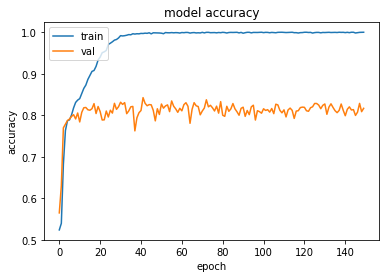

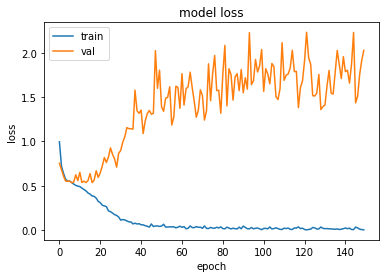

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.7729490995407104 , AUC = 0.8233926296234131 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8360228214205017
test 0.8505303158144738

-----------------------------------------------------------------


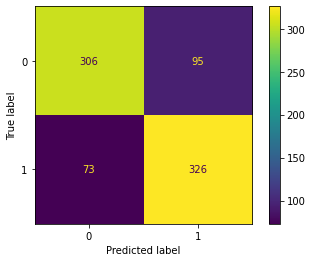

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5196741854636592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5268880159149858
118/118 - 20s - loss: 1.0939 - auc: 0.5118 - val_loss: 0.7260 - val_auc: 0.5190 - 20s/epoch - 168ms/step
Epoch 2/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6005451127819549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.578498400946841
118/118 - 18s - loss: 0.7317 - auc: 0.5516 - val_loss: 0.7044 - val_auc: 0.6003 - 18s/epoch - 153ms/step
Epoch 3/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7528822055137845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7471292588955202
118/118 - 18s - loss: 0.7069 - auc: 0.5697 - val_loss: 0.6575 - val_auc: 0.7535 - 18s/epoch - 156ms/step
Epoch 4/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7701065162907269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7515298028254135
118/118 - 18s - loss: 0.6357 - auc: 0.6952 - val_loss: 0.5839 - val_auc: 0.7699 - 18s/epoch - 152ms/step
Epoch 5/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7811027568922306


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7732366346856034
118/118 - 18s - loss: 0.5793 - auc: 0.7597 - val_loss: 0.5853 - val_auc: 0.7808 - 18s/epoch - 151ms/step
Epoch 6/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8129010025062656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8028254136133564
118/118 - 18s - loss: 0.5541 - auc: 0.7862 - val_loss: 0.5390 - val_auc: 0.8126 - 18s/epoch - 151ms/step
Epoch 7/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8096992481203008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7983367328951676
118/118 - 18s - loss: 0.5332 - auc: 0.8040 - val_loss: 0.5412 - val_auc: 0.8097 - 18s/epoch - 149ms/step
Epoch 8/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8145300751879699


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8056457908388105
118/118 - 18s - loss: 0.5379 - auc: 0.8026 - val_loss: 0.5411 - val_auc: 0.8144 - 18s/epoch - 148ms/step
Epoch 9/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8073308270676691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7964103145224245
118/118 - 18s - loss: 0.5169 - auc: 0.8210 - val_loss: 0.5451 - val_auc: 0.8072 - 18s/epoch - 149ms/step
Epoch 10/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8121867167919801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8064453174183475
118/118 - 18s - loss: 0.5180 - auc: 0.8190 - val_loss: 0.5644 - val_auc: 0.8122 - 18s/epoch - 150ms/step
Epoch 11/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8062593984962405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7995832389010602
118/118 - 18s - loss: 0.5058 - auc: 0.8308 - val_loss: 0.5349 - val_auc: 0.8063 - 18s/epoch - 149ms/step
Epoch 12/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8132706766917294


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7993754879000781
118/118 - 18s - loss: 0.4888 - auc: 0.8420 - val_loss: 0.5320 - val_auc: 0.8135 - 18s/epoch - 150ms/step
Epoch 13/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8184210526315788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.81020372189066
118/118 - 18s - loss: 0.4871 - auc: 0.8434 - val_loss: 0.5486 - val_auc: 0.8185 - 18s/epoch - 153ms/step
Epoch 14/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8298182957393485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.826370527057994
118/118 - 18s - loss: 0.4722 - auc: 0.8540 - val_loss: 0.5187 - val_auc: 0.8299 - 18s/epoch - 152ms/step
Epoch 15/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8337092731829574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8225743496764122
118/118 - 17s - loss: 0.4670 - auc: 0.8585 - val_loss: 0.5081 - val_auc: 0.8339 - 17s/epoch - 148ms/step
Epoch 16/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8099874686716793


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7991047820503135
118/118 - 18s - loss: 0.4474 - auc: 0.8714 - val_loss: 0.5760 - val_auc: 0.8100 - 18s/epoch - 149ms/step
Epoch 17/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8379135338345864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8194454936919242
118/118 - 18s - loss: 0.4396 - auc: 0.8760 - val_loss: 0.5059 - val_auc: 0.8379 - 18s/epoch - 149ms/step
Epoch 18/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.830031328320802


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8266160509682455
118/118 - 17s - loss: 0.4105 - auc: 0.8929 - val_loss: 0.5568 - val_auc: 0.8300 - 17s/epoch - 148ms/step
Epoch 19/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8393170426065163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8289264939185615
118/118 - 17s - loss: 0.3959 - auc: 0.9017 - val_loss: 0.5416 - val_auc: 0.8394 - 17s/epoch - 146ms/step
Epoch 20/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8026127819548872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7975560927702653
118/118 - 17s - loss: 0.3829 - auc: 0.9085 - val_loss: 0.7118 - val_auc: 0.8011 - 17s/epoch - 147ms/step
Epoch 21/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8373558897243107


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8413160081589485
118/118 - 17s - loss: 0.3589 - auc: 0.9202 - val_loss: 0.5484 - val_auc: 0.8379 - 17s/epoch - 146ms/step
Epoch 22/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834561403508772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8423547631638588
118/118 - 17s - loss: 0.3429 - auc: 0.9276 - val_loss: 0.5538 - val_auc: 0.8346 - 17s/epoch - 145ms/step
Epoch 23/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8289598997493735


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8446211377200272
118/118 - 17s - loss: 0.3097 - auc: 0.9412 - val_loss: 0.5993 - val_auc: 0.8292 - 17s/epoch - 146ms/step
Epoch 24/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8262844611528821


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8275981466092518
118/118 - 17s - loss: 0.2977 - auc: 0.9449 - val_loss: 0.5850 - val_auc: 0.8262 - 17s/epoch - 145ms/step
Epoch 25/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8425187969924812


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.836688826773438
118/118 - 17s - loss: 0.2672 - auc: 0.9558 - val_loss: 0.6661 - val_auc: 0.8417 - 17s/epoch - 146ms/step
Epoch 26/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8081453634085214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8162788647981668
118/118 - 17s - loss: 0.2608 - auc: 0.9580 - val_loss: 0.9023 - val_auc: 0.8084 - 17s/epoch - 146ms/step
Epoch 27/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8219235588972431


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8361914834680567
118/118 - 17s - loss: 0.2358 - auc: 0.9660 - val_loss: 0.6534 - val_auc: 0.8218 - 17s/epoch - 145ms/step
Epoch 28/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8226691729323308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8366825312885598
118/118 - 17s - loss: 0.1979 - auc: 0.9757 - val_loss: 0.6465 - val_auc: 0.8215 - 17s/epoch - 146ms/step
Epoch 29/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8504887218045113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8515524665709755
118/118 - 17s - loss: 0.1867 - auc: 0.9782 - val_loss: 0.6988 - val_auc: 0.8497 - 17s/epoch - 148ms/step
Epoch 30/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8471616541353383


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8534851804285967
118/118 - 18s - loss: 0.1630 - auc: 0.9834 - val_loss: 0.8600 - val_auc: 0.8399 - 18s/epoch - 151ms/step
Epoch 31/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8359273182957393


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8445455919014884
118/118 - 18s - loss: 0.1460 - auc: 0.9865 - val_loss: 0.7876 - val_auc: 0.8329 - 18s/epoch - 149ms/step
Epoch 32/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8517042606516291


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8535292488227443
118/118 - 17s - loss: 0.1575 - auc: 0.9843 - val_loss: 0.6582 - val_auc: 0.8484 - 17s/epoch - 148ms/step
Epoch 33/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8513220551378446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8389740877842411
118/118 - 17s - loss: 0.1111 - auc: 0.9921 - val_loss: 0.9426 - val_auc: 0.8441 - 17s/epoch - 148ms/step
Epoch 34/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8149060150375939


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.822549167736899
118/118 - 18s - loss: 0.1314 - auc: 0.9894 - val_loss: 1.1050 - val_auc: 0.8104 - 18s/epoch - 150ms/step
Epoch 35/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8371741854636592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434501775326735
118/118 - 18s - loss: 0.1128 - auc: 0.9913 - val_loss: 0.8842 - val_auc: 0.8342 - 18s/epoch - 151ms/step
Epoch 36/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8500438596491229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8587513535292488
118/118 - 18s - loss: 0.0952 - auc: 0.9939 - val_loss: 0.8994 - val_auc: 0.8466 - 18s/epoch - 151ms/step
Epoch 37/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.837531328320802


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8440671350507415
118/118 - 17s - loss: 0.0798 - auc: 0.9957 - val_loss: 1.0367 - val_auc: 0.8295 - 17s/epoch - 147ms/step
Epoch 38/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8220394736842106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8241356299262169
118/118 - 17s - loss: 0.0807 - auc: 0.9953 - val_loss: 1.1894 - val_auc: 0.8162 - 17s/epoch - 146ms/step
Epoch 39/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8477067669172933


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8516217169046361
118/118 - 17s - loss: 0.0748 - auc: 0.9964 - val_loss: 1.0530 - val_auc: 0.8419 - 17s/epoch - 147ms/step
Epoch 40/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8523684210526316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8464090554254489
118/118 - 17s - loss: 0.0830 - auc: 0.9952 - val_loss: 0.9969 - val_auc: 0.8452 - 17s/epoch - 147ms/step
Epoch 41/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8400031328320803


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8393455213920576
118/118 - 17s - loss: 0.0727 - auc: 0.9966 - val_loss: 1.0374 - val_auc: 0.8336 - 17s/epoch - 146ms/step
Epoch 42/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.833048245614035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8173239152879554
118/118 - 17s - loss: 0.0683 - auc: 0.9969 - val_loss: 1.3698 - val_auc: 0.8166 - 17s/epoch - 147ms/step
Epoch 43/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8433051378446116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8471959910352296
118/118 - 17s - loss: 0.0654 - auc: 0.9964 - val_loss: 1.2328 - val_auc: 0.8321 - 17s/epoch - 147ms/step
Epoch 44/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8317261904761905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8469756490644911
118/118 - 17s - loss: 0.0591 - auc: 0.9974 - val_loss: 1.3522 - val_auc: 0.8205 - 17s/epoch - 146ms/step
Epoch 45/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8456641604010025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8514926594646319
118/118 - 17s - loss: 0.0722 - auc: 0.9959 - val_loss: 1.0446 - val_auc: 0.8393 - 17s/epoch - 147ms/step
Epoch 46/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8497431077694235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8430441187580268
118/118 - 18s - loss: 0.0512 - auc: 0.9981 - val_loss: 1.1116 - val_auc: 0.8447 - 18s/epoch - 148ms/step
Epoch 47/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8278320802005014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8435634962604819
118/118 - 18s - loss: 0.0496 - auc: 0.9983 - val_loss: 1.4715 - val_auc: 0.8055 - 18s/epoch - 151ms/step
Epoch 48/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8368107769423561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8428111858175316
118/118 - 18s - loss: 0.0362 - auc: 0.9992 - val_loss: 1.3943 - val_auc: 0.8130 - 18s/epoch - 149ms/step
Epoch 49/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8406140350877191


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8481749389337967
118/118 - 17s - loss: 0.0381 - auc: 0.9991 - val_loss: 1.4083 - val_auc: 0.8234 - 17s/epoch - 146ms/step
Epoch 50/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.848452380952381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8586600689985142
118/118 - 17s - loss: 0.0349 - auc: 0.9990 - val_loss: 1.3345 - val_auc: 0.8345 - 17s/epoch - 146ms/step
Epoch 51/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8352130325814536


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8462894412127622
118/118 - 17s - loss: 0.0377 - auc: 0.9989 - val_loss: 1.4213 - val_auc: 0.8204 - 17s/epoch - 148ms/step
Epoch 52/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8615444862155388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8525912215758857
118/118 - 18s - loss: 0.0543 - auc: 0.9975 - val_loss: 1.2050 - val_auc: 0.8460 - 18s/epoch - 149ms/step
Epoch 53/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8333458646616542


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8366825312885598
118/118 - 18s - loss: 0.0443 - auc: 0.9981 - val_loss: 1.3389 - val_auc: 0.8168 - 18s/epoch - 153ms/step
Epoch 54/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8365726817042607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8343657928533655
118/118 - 18s - loss: 0.0577 - auc: 0.9975 - val_loss: 1.1679 - val_auc: 0.8301 - 18s/epoch - 150ms/step
Epoch 55/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8539411027568922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8597019717458638
118/118 - 17s - loss: 0.0392 - auc: 0.9986 - val_loss: 1.3931 - val_auc: 0.8348 - 17s/epoch - 147ms/step
Epoch 56/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8479636591478698


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8507623832187556
118/118 - 18s - loss: 0.0493 - auc: 0.9976 - val_loss: 1.1920 - val_auc: 0.8394 - 18s/epoch - 149ms/step
Epoch 57/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8521741854636591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8633533529752462
118/118 - 18s - loss: 0.0381 - auc: 0.9983 - val_loss: 1.1043 - val_auc: 0.8479 - 18s/epoch - 150ms/step
Epoch 58/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8547462406015038


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.865298657802624
118/118 - 17s - loss: 0.0259 - auc: 0.9993 - val_loss: 1.2532 - val_auc: 0.8457 - 17s/epoch - 148ms/step
Epoch 59/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8084931077694235


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8275351917604693
118/118 - 18s - loss: 0.0499 - auc: 0.9980 - val_loss: 1.4355 - val_auc: 0.7913 - 18s/epoch - 149ms/step
Epoch 60/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8555106516290727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8599569388834327
118/118 - 17s - loss: 0.0299 - auc: 0.9992 - val_loss: 1.3684 - val_auc: 0.8367 - 17s/epoch - 148ms/step
Epoch 61/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8284492481203007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8335914482133413
118/118 - 17s - loss: 0.0215 - auc: 0.9995 - val_loss: 1.7589 - val_auc: 0.8097 - 17s/epoch - 147ms/step
Epoch 62/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8442418546365915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8477027775679282
118/118 - 18s - loss: 0.0391 - auc: 0.9979 - val_loss: 1.3864 - val_auc: 0.8219 - 18s/epoch - 150ms/step
Epoch 63/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8538533834586466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8475485381884112
118/118 - 18s - loss: 0.0536 - auc: 0.9977 - val_loss: 1.1632 - val_auc: 0.8413 - 18s/epoch - 152ms/step
Epoch 64/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.837390350877193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8352660471909547
118/118 - 18s - loss: 0.0213 - auc: 0.9997 - val_loss: 1.6116 - val_auc: 0.8155 - 18s/epoch - 149ms/step
Epoch 65/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8608646616541356


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.858140691496059
118/118 - 18s - loss: 0.0316 - auc: 0.9986 - val_loss: 1.2642 - val_auc: 0.8449 - 18s/epoch - 150ms/step
Epoch 66/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.850419799498747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8518892750119614
118/118 - 18s - loss: 0.0349 - auc: 0.9988 - val_loss: 1.2503 - val_auc: 0.8439 - 18s/epoch - 152ms/step
Epoch 67/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8674248120300752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8581155095565461
118/118 - 18s - loss: 0.0232 - auc: 0.9996 - val_loss: 1.3975 - val_auc: 0.8518 - 18s/epoch - 149ms/step
Epoch 68/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8275845864661654


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.824522802246229
118/118 - 17s - loss: 0.0231 - auc: 0.9995 - val_loss: 1.5723 - val_auc: 0.8104 - 17s/epoch - 148ms/step
Epoch 69/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8442182266878195
118/118 - 17s - loss: 0.0424 - auc: 0.9979 - val_loss: 1.1970 - val_auc: 0.8405 - 17s/epoch - 148ms/step
Epoch 70/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8526002506265664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8586254438316839
118/118 - 17s - loss: 0.0180 - auc: 0.9998 - val_loss: 1.3936 - val_auc: 0.8353 - 17s/epoch - 147ms/step
Epoch 71/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8544016290726818


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8454993578605424
118/118 - 17s - loss: 0.0189 - auc: 0.9998 - val_loss: 1.5077 - val_auc: 0.8345 - 17s/epoch - 148ms/step
Epoch 72/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8519862155388471


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8470984110196166
118/118 - 17s - loss: 0.0370 - auc: 0.9990 - val_loss: 1.2558 - val_auc: 0.8285 - 17s/epoch - 147ms/step
Epoch 73/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8661215538847119


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.857111379718466
118/118 - 17s - loss: 0.0425 - auc: 0.9982 - val_loss: 1.0344 - val_auc: 0.8564 - 17s/epoch - 147ms/step
Epoch 74/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8569392230576441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8461383495756842
118/118 - 17s - loss: 0.0166 - auc: 0.9998 - val_loss: 1.3674 - val_auc: 0.8370 - 17s/epoch - 146ms/step
Epoch 75/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8522775689223058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8474163330059681
118/118 - 17s - loss: 0.0403 - auc: 0.9983 - val_loss: 1.4629 - val_auc: 0.8324 - 17s/epoch - 146ms/step
Epoch 76/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8626065162907266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8594910730024425
118/118 - 17s - loss: 0.0273 - auc: 0.9995 - val_loss: 1.4776 - val_auc: 0.8441 - 17s/epoch - 148ms/step
Epoch 77/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8553822055137844


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8533152023368841
118/118 - 17s - loss: 0.0271 - auc: 0.9991 - val_loss: 1.4399 - val_auc: 0.8273 - 17s/epoch - 148ms/step
Epoch 78/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8596303258145364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8510079071290072
118/118 - 18s - loss: 0.0346 - auc: 0.9985 - val_loss: 1.1428 - val_auc: 0.8506 - 18s/epoch - 150ms/step
Epoch 79/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8612875939849625


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8561418750472162
118/118 - 17s - loss: 0.0209 - auc: 0.9990 - val_loss: 1.3446 - val_auc: 0.8430 - 17s/epoch - 148ms/step
Epoch 80/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8647117794486215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8560978066530682
118/118 - 17s - loss: 0.0115 - auc: 0.9996 - val_loss: 1.3897 - val_auc: 0.8473 - 17s/epoch - 146ms/step
Epoch 81/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8316666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8287439248570927
118/118 - 17s - loss: 0.0310 - auc: 0.9990 - val_loss: 1.6638 - val_auc: 0.8040 - 17s/epoch - 146ms/step
Epoch 82/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8637092731829574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8523362544383168
118/118 - 17s - loss: 0.0207 - auc: 0.9995 - val_loss: 1.3896 - val_auc: 0.8433 - 17s/epoch - 146ms/step
Epoch 83/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8582769423558897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8580053385711768
118/118 - 17s - loss: 0.0312 - auc: 0.9992 - val_loss: 1.3532 - val_auc: 0.8451 - 17s/epoch - 146ms/step
Epoch 84/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8591228070175438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8489713177708947
118/118 - 17s - loss: 0.0370 - auc: 0.9986 - val_loss: 1.1546 - val_auc: 0.8426 - 17s/epoch - 145ms/step
Epoch 85/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8687437343358396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8638979124172145
118/118 - 17s - loss: 0.0337 - auc: 0.9986 - val_loss: 1.0441 - val_auc: 0.8576 - 17s/epoch - 146ms/step
Epoch 86/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8419298245614035


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8435509052907254
118/118 - 17s - loss: 0.0184 - auc: 0.9995 - val_loss: 1.3765 - val_auc: 0.8278 - 17s/epoch - 146ms/step
Epoch 87/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8601159147869676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8563212963662462
118/118 - 17s - loss: 0.0164 - auc: 0.9993 - val_loss: 1.2874 - val_auc: 0.8476 - 17s/epoch - 145ms/step
Epoch 88/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8614223057644109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8601520989146583
118/118 - 17s - loss: 0.0162 - auc: 0.9998 - val_loss: 1.3216 - val_auc: 0.8410 - 17s/epoch - 147ms/step
Epoch 89/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8592449874686716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8565101609125935
118/118 - 17s - loss: 0.0219 - auc: 0.9994 - val_loss: 1.4428 - val_auc: 0.8430 - 17s/epoch - 147ms/step
Epoch 90/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8484774436090227


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8491035229533378
118/118 - 17s - loss: 0.0251 - auc: 0.9991 - val_loss: 1.3925 - val_auc: 0.8307 - 17s/epoch - 145ms/step
Epoch 91/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8526535087719298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8538125456422654
118/118 - 17s - loss: 0.0092 - auc: 0.9999 - val_loss: 1.4372 - val_auc: 0.8286 - 17s/epoch - 145ms/step
Epoch 92/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8576911027568922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8553832691193876
118/118 - 17s - loss: 0.0123 - auc: 0.9999 - val_loss: 1.4663 - val_auc: 0.8374 - 17s/epoch - 145ms/step
Epoch 93/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8578947368421053


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8576905643272645
118/118 - 17s - loss: 0.0293 - auc: 0.9990 - val_loss: 1.4446 - val_auc: 0.8330 - 17s/epoch - 145ms/step
Epoch 94/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8377255639097745


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8283661957643977
118/118 - 17s - loss: 0.0317 - auc: 0.9985 - val_loss: 1.3585 - val_auc: 0.8172 - 17s/epoch - 146ms/step
Epoch 95/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.861203007518797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8590724232580393
118/118 - 18s - loss: 0.0260 - auc: 0.9994 - val_loss: 1.2773 - val_auc: 0.8476 - 18s/epoch - 148ms/step
Epoch 96/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8581829573934836


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8468056709727784
118/118 - 17s - loss: 0.0215 - auc: 0.9995 - val_loss: 1.4213 - val_auc: 0.8360 - 17s/epoch - 148ms/step
Epoch 97/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8617825814536342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8536457152929918
118/118 - 17s - loss: 0.0291 - auc: 0.9993 - val_loss: 1.3156 - val_auc: 0.8402 - 17s/epoch - 147ms/step
Epoch 98/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8634241854636592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8510488277807157
118/118 - 17s - loss: 0.0164 - auc: 0.9996 - val_loss: 1.5373 - val_auc: 0.8391 - 17s/epoch - 146ms/step
Epoch 99/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8612625313283206


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.847976631160132
118/118 - 17s - loss: 0.0090 - auc: 1.0000 - val_loss: 1.5700 - val_auc: 0.8401 - 17s/epoch - 146ms/step
Epoch 100/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8588565162907267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8455811991639596
118/118 - 17s - loss: 0.0131 - auc: 0.9996 - val_loss: 1.6687 - val_auc: 0.8338 - 17s/epoch - 146ms/step
Epoch 101/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8498590225563911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8433872226838912
118/118 - 18s - loss: 0.0280 - auc: 0.9991 - val_loss: 1.3567 - val_auc: 0.8331 - 18s/epoch - 150ms/step
Epoch 102/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8620238095238096


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8602811563546624
118/118 - 18s - loss: 0.0135 - auc: 0.9994 - val_loss: 1.3672 - val_auc: 0.8429 - 18s/epoch - 151ms/step
Epoch 103/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.857609649122807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8573726423409131
118/118 - 18s - loss: 0.0159 - auc: 0.9993 - val_loss: 1.4293 - val_auc: 0.8383 - 18s/epoch - 149ms/step
Epoch 104/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8534899749373435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8635894336581804
118/118 - 18s - loss: 0.0138 - auc: 0.9996 - val_loss: 1.7392 - val_auc: 0.8345 - 18s/epoch - 149ms/step
Epoch 105/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8647117794486214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8601363602024628
118/118 - 18s - loss: 0.0208 - auc: 0.9994 - val_loss: 1.4034 - val_auc: 0.8444 - 18s/epoch - 150ms/step
Epoch 106/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.850654761904762


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8529689506685805
118/118 - 18s - loss: 0.0199 - auc: 0.9993 - val_loss: 1.5689 - val_auc: 0.8244 - 18s/epoch - 149ms/step
Epoch 107/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8382393483709274


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8433714839716956
118/118 - 17s - loss: 0.0488 - auc: 0.9974 - val_loss: 1.3553 - val_auc: 0.8212 - 17s/epoch - 147ms/step
Epoch 108/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.861390977443609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.862940998715721
118/118 - 17s - loss: 0.0240 - auc: 0.9989 - val_loss: 1.1962 - val_auc: 0.8482 - 17s/epoch - 146ms/step
Epoch 109/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8528226817042607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8451090377980912
118/118 - 17s - loss: 0.0109 - auc: 0.9999 - val_loss: 1.5824 - val_auc: 0.8292 - 17s/epoch - 146ms/step
Epoch 110/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8499749373433584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8412341668555313
118/118 - 18s - loss: 0.0259 - auc: 0.9991 - val_loss: 1.3250 - val_auc: 0.8341 - 18s/epoch - 149ms/step
Epoch 111/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8659555137844611


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.866737176097303
118/118 - 18s - loss: 0.0150 - auc: 0.9999 - val_loss: 1.3985 - val_auc: 0.8503 - 18s/epoch - 152ms/step
Epoch 112/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.844580200501253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8476461182040241
118/118 - 18s - loss: 0.0079 - auc: 0.9999 - val_loss: 1.6266 - val_auc: 0.8210 - 18s/epoch - 151ms/step
Epoch 113/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8469830827067668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8599380524287981
118/118 - 18s - loss: 0.0241 - auc: 0.9992 - val_loss: 1.3794 - val_auc: 0.8336 - 18s/epoch - 152ms/step
Epoch 114/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8460526315789473


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8533876004129839
118/118 - 18s - loss: 0.0174 - auc: 0.9996 - val_loss: 1.4042 - val_auc: 0.8286 - 18s/epoch - 150ms/step
Epoch 115/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8566854636591478


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.857035833899927
118/118 - 18s - loss: 0.0265 - auc: 0.9994 - val_loss: 1.3135 - val_auc: 0.8450 - 18s/epoch - 150ms/step
Epoch 116/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8440068922305765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8373530004280931
118/118 - 18s - loss: 0.0198 - auc: 0.9998 - val_loss: 1.2692 - val_auc: 0.8353 - 18s/epoch - 150ms/step
Epoch 117/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8517105263157895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8592864697438997
118/118 - 18s - loss: 0.0181 - auc: 0.9993 - val_loss: 1.4025 - val_auc: 0.8360 - 18s/epoch - 151ms/step
Epoch 118/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8474530075187969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8569760267935838
118/118 - 18s - loss: 0.0095 - auc: 0.9999 - val_loss: 1.5455 - val_auc: 0.8218 - 18s/epoch - 150ms/step
Epoch 119/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8512719298245615


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8492168416811463
118/118 - 18s - loss: 0.0085 - auc: 1.0000 - val_loss: 1.5972 - val_auc: 0.8244 - 18s/epoch - 152ms/step
Epoch 120/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8593515037593986


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.84895243131626
118/118 - 18s - loss: 0.0152 - auc: 0.9998 - val_loss: 1.5040 - val_auc: 0.8342 - 18s/epoch - 151ms/step
Epoch 121/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8567951127819549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8461068721512931
118/118 - 18s - loss: 0.0215 - auc: 0.9992 - val_loss: 1.4607 - val_auc: 0.8453 - 18s/epoch - 149ms/step
Epoch 122/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8536152882205514


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8549268464657148
118/118 - 18s - loss: 0.0079 - auc: 0.9997 - val_loss: 1.5857 - val_auc: 0.8369 - 18s/epoch - 151ms/step
Epoch 123/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8581077694235589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8604700209010098
118/118 - 18s - loss: 0.0300 - auc: 0.9987 - val_loss: 1.3844 - val_auc: 0.8423 - 18s/epoch - 150ms/step
Epoch 124/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8429135338345864


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8495630933494497
118/118 - 18s - loss: 0.0186 - auc: 0.9995 - val_loss: 1.5212 - val_auc: 0.8255 - 18s/epoch - 151ms/step
Epoch 125/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8529636591478696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8535481352773789
118/118 - 18s - loss: 0.0211 - auc: 0.9995 - val_loss: 1.3169 - val_auc: 0.8412 - 18s/epoch - 149ms/step
Epoch 126/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8517982456140352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8507057238548513
118/118 - 18s - loss: 0.0096 - auc: 1.0000 - val_loss: 1.5909 - val_auc: 0.8307 - 18s/epoch - 153ms/step
Epoch 127/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8517543859649123


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.848590440935761
118/118 - 19s - loss: 0.0073 - auc: 1.0000 - val_loss: 1.6704 - val_auc: 0.8270 - 19s/epoch - 164ms/step
Epoch 128/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8503383458646617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8484362015562439
118/118 - 18s - loss: 0.0107 - auc: 0.9994 - val_loss: 1.7715 - val_auc: 0.8205 - 18s/epoch - 155ms/step
Epoch 129/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.845438596491228


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8492294326509028
118/118 - 18s - loss: 0.0177 - auc: 0.9993 - val_loss: 1.3784 - val_auc: 0.8254 - 18s/epoch - 151ms/step
Epoch 130/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.841685463659148


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8547474251466847
118/118 - 18s - loss: 0.0098 - auc: 0.9999 - val_loss: 1.9477 - val_auc: 0.8181 - 18s/epoch - 152ms/step
Epoch 131/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8573339598997495


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8520907305280654
118/118 - 18s - loss: 0.0242 - auc: 0.9986 - val_loss: 1.3441 - val_auc: 0.8450 - 18s/epoch - 152ms/step
Epoch 132/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8629573934837093


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8573600513711566
118/118 - 18s - loss: 0.0148 - auc: 0.9996 - val_loss: 1.2511 - val_auc: 0.8519 - 18s/epoch - 150ms/step
Epoch 133/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8630827067669172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8653993855606759
118/118 - 18s - loss: 0.0032 - auc: 1.0000 - val_loss: 1.4731 - val_auc: 0.8377 - 18s/epoch - 149ms/step
Epoch 134/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8611184210526316


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8559781924403818
118/118 - 18s - loss: 0.0022 - auc: 1.0000 - val_loss: 1.6789 - val_auc: 0.8330 - 18s/epoch - 149ms/step
Epoch 135/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8619642857142857


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.85645035380625
118/118 - 18s - loss: 0.0035 - auc: 0.9997 - val_loss: 1.7504 - val_auc: 0.8256 - 18s/epoch - 153ms/step
Epoch 136/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8145269423558897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.806892296844703
118/118 - 20s - loss: 0.0446 - auc: 0.9975 - val_loss: 1.1694 - val_auc: 0.8093 - 20s/epoch - 174ms/step
Epoch 137/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8545112781954887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8572687668404221
118/118 - 18s - loss: 0.0386 - auc: 0.9991 - val_loss: 1.3069 - val_auc: 0.8371 - 18s/epoch - 155ms/step
Epoch 138/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8508615288220551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8550684948754753
118/118 - 17s - loss: 0.0204 - auc: 0.9995 - val_loss: 1.3425 - val_auc: 0.8321 - 17s/epoch - 147ms/step
Epoch 139/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8418577694235589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8612349223137167
118/118 - 17s - loss: 0.0309 - auc: 0.9985 - val_loss: 1.5510 - val_auc: 0.8174 - 17s/epoch - 148ms/step
Epoch 140/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8431453634085214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8563464783057592
118/118 - 17s - loss: 0.0098 - auc: 0.9997 - val_loss: 1.6619 - val_auc: 0.8231 - 17s/epoch - 148ms/step
Epoch 141/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8430200501253133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8631267155196294
118/118 - 17s - loss: 0.0112 - auc: 0.9999 - val_loss: 1.7137 - val_auc: 0.8220 - 17s/epoch - 147ms/step
Epoch 142/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8428477443609023


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8588363425751051
118/118 - 18s - loss: 0.0068 - auc: 1.0000 - val_loss: 2.0103 - val_auc: 0.8200 - 18s/epoch - 149ms/step
Epoch 143/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8212907268170426


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8391220316788799
118/118 - 18s - loss: 0.0213 - auc: 0.9993 - val_loss: 1.8725 - val_auc: 0.7917 - 18s/epoch - 150ms/step
Epoch 144/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8526159147869674


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8585247160736319
118/118 - 18s - loss: 0.0205 - auc: 0.9995 - val_loss: 1.3993 - val_auc: 0.8331 - 18s/epoch - 149ms/step
Epoch 145/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8433364661654136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8573002442648133
118/118 - 18s - loss: 0.0180 - auc: 0.9998 - val_loss: 1.5468 - val_auc: 0.8264 - 18s/epoch - 152ms/step
Epoch 146/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8610338345864663


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8586317393165622
118/118 - 17s - loss: 0.0212 - auc: 0.9990 - val_loss: 1.3541 - val_auc: 0.8459 - 17s/epoch - 147ms/step
Epoch 147/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8607268170426065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8545302309183853
118/118 - 17s - loss: 0.0131 - auc: 0.9999 - val_loss: 1.4650 - val_auc: 0.8430 - 17s/epoch - 148ms/step
Epoch 148/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8605639097744362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8490311248772381
118/118 - 17s - loss: 0.0198 - auc: 0.9995 - val_loss: 1.4253 - val_auc: 0.8434 - 17s/epoch - 147ms/step
Epoch 149/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8616259398496241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8527769383797941
118/118 - 17s - loss: 0.0135 - auc: 0.9994 - val_loss: 1.5623 - val_auc: 0.8394 - 17s/epoch - 148ms/step
Epoch 150/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8543577694235589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8472557981415729
118/118 - 18s - loss: 0.0099 - auc: 0.9999 - val_loss: 1.6544 - val_auc: 0.8315 - 18s/epoch - 149ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


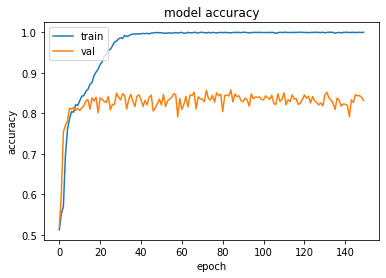

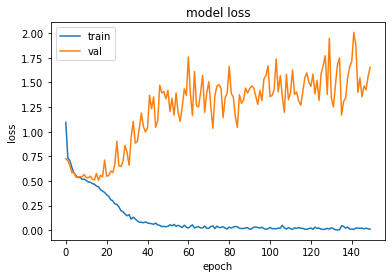

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.8132498264312744 , AUC = 0.8216331005096436 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8543577694235589
test 0.8472557981415729

-----------------------------------------------------------------


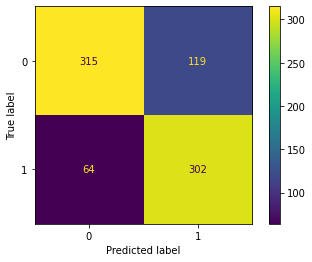

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6436530779891015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6379699248120301
118/118 - 19s - loss: 1.1350 - auc: 0.5176 - val_loss: 0.6964 - val_auc: 0.6430 - 19s/epoch - 163ms/step
Epoch 2/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7578117651485223


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7756453634085214
118/118 - 18s - loss: 0.7084 - auc: 0.5824 - val_loss: 0.6502 - val_auc: 0.7576 - 18s/epoch - 150ms/step
Epoch 3/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7851521593267742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7789285714285714
118/118 - 18s - loss: 0.6062 - auc: 0.7306 - val_loss: 0.5963 - val_auc: 0.7847 - 18s/epoch - 151ms/step
Epoch 4/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8050052987690552


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.813734335839599
118/118 - 18s - loss: 0.5856 - auc: 0.7545 - val_loss: 0.5601 - val_auc: 0.8051 - 18s/epoch - 150ms/step
Epoch 5/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7869518595857554


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8018421052631579
118/118 - 18s - loss: 0.5586 - auc: 0.7861 - val_loss: 0.6059 - val_auc: 0.7869 - 18s/epoch - 150ms/step
Epoch 6/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8044346621015733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8117731829573934
118/118 - 18s - loss: 0.5488 - auc: 0.7911 - val_loss: 0.5805 - val_auc: 0.8042 - 18s/epoch - 150ms/step
Epoch 7/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8048673426516421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8112280701754386
118/118 - 17s - loss: 0.5342 - auc: 0.8077 - val_loss: 0.5540 - val_auc: 0.8049 - 17s/epoch - 147ms/step
Epoch 8/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8159289149751365


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8194486215538845
118/118 - 18s - loss: 0.5284 - auc: 0.8092 - val_loss: 0.5246 - val_auc: 0.8160 - 18s/epoch - 151ms/step
Epoch 9/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8033560960927065


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8124310776942355
118/118 - 18s - loss: 0.5135 - auc: 0.8237 - val_loss: 0.5380 - val_auc: 0.8035 - 18s/epoch - 150ms/step
Epoch 10/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7960318804045876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8067293233082707
118/118 - 17s - loss: 0.5119 - auc: 0.8261 - val_loss: 0.6315 - val_auc: 0.7960 - 17s/epoch - 148ms/step
Epoch 11/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8086862188109437


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8300814536340851
118/118 - 18s - loss: 0.4851 - auc: 0.8468 - val_loss: 0.5329 - val_auc: 0.8086 - 18s/epoch - 148ms/step
Epoch 12/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8065855233866973


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8246303258145362
118/118 - 17s - loss: 0.4701 - auc: 0.8560 - val_loss: 0.5467 - val_auc: 0.8066 - 17s/epoch - 148ms/step
Epoch 13/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8055132281104402


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8324624060150375
118/118 - 18s - loss: 0.4494 - auc: 0.8709 - val_loss: 0.5487 - val_auc: 0.8055 - 18s/epoch - 149ms/step
Epoch 14/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8082786211913138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8321052631578947
118/118 - 18s - loss: 0.4401 - auc: 0.8763 - val_loss: 0.5463 - val_auc: 0.8082 - 18s/epoch - 151ms/step
Epoch 15/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8075512162085897


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8068546365914787
118/118 - 17s - loss: 0.4081 - auc: 0.8948 - val_loss: 0.6266 - val_auc: 0.8072 - 17s/epoch - 148ms/step
Epoch 16/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8049864865712262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8122619047619047
118/118 - 17s - loss: 0.3914 - auc: 0.9035 - val_loss: 0.5865 - val_auc: 0.8051 - 17s/epoch - 147ms/step
Epoch 17/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8069492258780593


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8264849624060151
118/118 - 17s - loss: 0.3606 - auc: 0.9199 - val_loss: 0.5886 - val_auc: 0.8069 - 17s/epoch - 146ms/step
Epoch 18/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7995434906660144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8079072681704262
118/118 - 17s - loss: 0.3417 - auc: 0.9276 - val_loss: 0.6465 - val_auc: 0.8003 - 17s/epoch - 147ms/step
Epoch 19/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7851396178615547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.822687969924812
118/118 - 18s - loss: 0.3190 - auc: 0.9381 - val_loss: 0.6357 - val_auc: 0.7852 - 18s/epoch - 149ms/step
Epoch 20/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7973361927874033


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8342606516290727
118/118 - 17s - loss: 0.2974 - auc: 0.9453 - val_loss: 0.7409 - val_auc: 0.7970 - 17s/epoch - 147ms/step
Epoch 21/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8148001831053922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8330827067669173
118/118 - 18s - loss: 0.2662 - auc: 0.9564 - val_loss: 0.6868 - val_auc: 0.8139 - 18s/epoch - 149ms/step
Epoch 22/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7959284133165279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7921115288220553
118/118 - 18s - loss: 0.2533 - auc: 0.9606 - val_loss: 1.0562 - val_auc: 0.7943 - 18s/epoch - 149ms/step
Epoch 23/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8149883050836829


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8235964912280702
118/118 - 18s - loss: 0.2431 - auc: 0.9641 - val_loss: 0.7425 - val_auc: 0.8143 - 18s/epoch - 149ms/step
Epoch 24/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.817766239629776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8318922305764411
118/118 - 18s - loss: 0.2158 - auc: 0.9712 - val_loss: 0.6862 - val_auc: 0.8178 - 18s/epoch - 155ms/step
Epoch 25/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8099591775307109


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8409147869674185
118/118 - 18s - loss: 0.2058 - auc: 0.9741 - val_loss: 0.6841 - val_auc: 0.8100 - 18s/epoch - 154ms/step
Epoch 26/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8198230399257546


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8463095238095237
118/118 - 18s - loss: 0.1770 - auc: 0.9805 - val_loss: 0.7693 - val_auc: 0.8179 - 18s/epoch - 153ms/step
Epoch 27/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7838227640135198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8331077694235589
118/118 - 18s - loss: 0.1555 - auc: 0.9849 - val_loss: 1.0269 - val_auc: 0.7800 - 18s/epoch - 151ms/step
Epoch 28/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7885132720055684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8280200501253133
118/118 - 18s - loss: 0.1462 - auc: 0.9866 - val_loss: 0.8492 - val_auc: 0.7868 - 18s/epoch - 150ms/step
Epoch 29/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8117149826614243


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8292982456140352
118/118 - 18s - loss: 0.1450 - auc: 0.9869 - val_loss: 0.8526 - val_auc: 0.8099 - 18s/epoch - 154ms/step
Epoch 30/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8127778718387668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8292261904761904
118/118 - 17s - loss: 0.1262 - auc: 0.9902 - val_loss: 1.0178 - val_auc: 0.8098 - 17s/epoch - 148ms/step
Epoch 31/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8199139655485951


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8321115288220552
118/118 - 18s - loss: 0.1124 - auc: 0.9918 - val_loss: 0.9708 - val_auc: 0.8163 - 18s/epoch - 150ms/step
Epoch 32/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8211430291400943


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8367606516290728
118/118 - 18s - loss: 0.1142 - auc: 0.9914 - val_loss: 0.9296 - val_auc: 0.8178 - 18s/epoch - 150ms/step
Epoch 33/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8200519216660082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8372932330827068
118/118 - 18s - loss: 0.1056 - auc: 0.9926 - val_loss: 0.9544 - val_auc: 0.8206 - 18s/epoch - 150ms/step
Epoch 34/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8304644731643998


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8469016290726818
118/118 - 18s - loss: 0.0753 - auc: 0.9965 - val_loss: 0.9409 - val_auc: 0.8291 - 18s/epoch - 150ms/step
Epoch 35/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7966809012296906


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8157926065162908
118/118 - 17s - loss: 0.0696 - auc: 0.9963 - val_loss: 1.1913 - val_auc: 0.7906 - 17s/epoch - 148ms/step
Epoch 36/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8284609740956036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8410087719298245
118/118 - 18s - loss: 0.0770 - auc: 0.9956 - val_loss: 1.0712 - val_auc: 0.8268 - 18s/epoch - 150ms/step
Epoch 37/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8489255099673295


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8524248120300754
118/118 - 18s - loss: 0.0662 - auc: 0.9964 - val_loss: 1.0659 - val_auc: 0.8427 - 18s/epoch - 149ms/step
Epoch 38/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8487373879890387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.86296679197995
118/118 - 18s - loss: 0.0879 - auc: 0.9945 - val_loss: 1.1282 - val_auc: 0.8424 - 18s/epoch - 149ms/step
Epoch 39/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8243003430090737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8375093984962406
118/118 - 18s - loss: 0.0513 - auc: 0.9981 - val_loss: 1.2018 - val_auc: 0.8143 - 18s/epoch - 148ms/step
Epoch 40/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8294266669174959


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.840670426065163
118/118 - 18s - loss: 0.0532 - auc: 0.9979 - val_loss: 1.2512 - val_auc: 0.8271 - 18s/epoch - 149ms/step
Epoch 41/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8337377955866584


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8448245614035087
118/118 - 19s - loss: 0.0549 - auc: 0.9976 - val_loss: 1.2685 - val_auc: 0.8272 - 19s/epoch - 160ms/step
Epoch 42/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8411811551943614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8461152882205514
118/118 - 18s - loss: 0.0418 - auc: 0.9984 - val_loss: 1.1659 - val_auc: 0.8410 - 18s/epoch - 156ms/step
Epoch 43/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8253663675527211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.827954260651629
118/118 - 18s - loss: 0.0359 - auc: 0.9989 - val_loss: 1.1005 - val_auc: 0.8199 - 18s/epoch - 151ms/step
Epoch 44/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8234443880078509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.842875939849624
118/118 - 18s - loss: 0.0529 - auc: 0.9976 - val_loss: 1.3308 - val_auc: 0.8227 - 18s/epoch - 149ms/step
Epoch 45/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8241811990894896


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8359899749373433
118/118 - 17s - loss: 0.0646 - auc: 0.9966 - val_loss: 1.4457 - val_auc: 0.8164 - 17s/epoch - 148ms/step
Epoch 46/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8053909488245512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8322838345864662
118/118 - 17s - loss: 0.0485 - auc: 0.9981 - val_loss: 1.4847 - val_auc: 0.7947 - 17s/epoch - 146ms/step
Epoch 47/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7978190391983496


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8389317042606517
118/118 - 17s - loss: 0.0505 - auc: 0.9973 - val_loss: 1.4215 - val_auc: 0.7902 - 17s/epoch - 145ms/step
Epoch 48/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8144835111086027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8321898496240603
118/118 - 17s - loss: 0.0482 - auc: 0.9981 - val_loss: 1.4478 - val_auc: 0.8012 - 17s/epoch - 148ms/step
Epoch 49/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8273040239291156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8347775689223058
118/118 - 17s - loss: 0.0293 - auc: 0.9988 - val_loss: 1.3736 - val_auc: 0.8231 - 17s/epoch - 146ms/step
Epoch 50/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8130443779746788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8270081453634085
118/118 - 17s - loss: 0.0568 - auc: 0.9971 - val_loss: 1.3588 - val_auc: 0.8030 - 17s/epoch - 146ms/step
Epoch 51/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8175498993547416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.831610275689223
118/118 - 17s - loss: 0.0396 - auc: 0.9988 - val_loss: 1.5765 - val_auc: 0.8117 - 17s/epoch - 146ms/step
Epoch 52/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8145336769694804


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434617794486216
118/118 - 17s - loss: 0.0335 - auc: 0.9990 - val_loss: 1.9554 - val_auc: 0.7924 - 17s/epoch - 146ms/step
Epoch 53/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8191991020310904


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.838828320802005
118/118 - 17s - loss: 0.0285 - auc: 0.9995 - val_loss: 1.5810 - val_auc: 0.8087 - 17s/epoch - 145ms/step
Epoch 54/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8374751522220341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8464880952380951
118/118 - 17s - loss: 0.0394 - auc: 0.9986 - val_loss: 1.4284 - val_auc: 0.8309 - 17s/epoch - 145ms/step
Epoch 55/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8293984486207523


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8458740601503758
118/118 - 17s - loss: 0.0377 - auc: 0.9989 - val_loss: 1.4251 - val_auc: 0.8231 - 17s/epoch - 146ms/step
Epoch 56/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8362805776598881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8488533834586465
118/118 - 17s - loss: 0.0277 - auc: 0.9993 - val_loss: 1.5448 - val_auc: 0.8272 - 17s/epoch - 145ms/step
Epoch 57/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8325024612625492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8411528822055139
118/118 - 17s - loss: 0.0393 - auc: 0.9984 - val_loss: 1.4865 - val_auc: 0.8255 - 17s/epoch - 146ms/step
Epoch 58/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8411153125019597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8542293233082707
118/118 - 18s - loss: 0.0268 - auc: 0.9995 - val_loss: 1.4837 - val_auc: 0.8304 - 18s/epoch - 149ms/step
Epoch 59/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8265076408876849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8320206766917293
118/118 - 18s - loss: 0.0261 - auc: 0.9994 - val_loss: 1.4319 - val_auc: 0.8233 - 18s/epoch - 151ms/step
Epoch 60/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8309755378720896


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.851015037593985
118/118 - 17s - loss: 0.0275 - auc: 0.9990 - val_loss: 1.6666 - val_auc: 0.8189 - 17s/epoch - 147ms/step
Epoch 61/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8387857353374594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8444768170426065
118/118 - 17s - loss: 0.0180 - auc: 0.9998 - val_loss: 1.4196 - val_auc: 0.8227 - 17s/epoch - 147ms/step
Epoch 62/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8340544675834477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8500187969924812
118/118 - 17s - loss: 0.0361 - auc: 0.9989 - val_loss: 1.5566 - val_auc: 0.8196 - 17s/epoch - 148ms/step
Epoch 63/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8346345103498441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.852280701754386
118/118 - 18s - loss: 0.0501 - auc: 0.9979 - val_loss: 1.3233 - val_auc: 0.8225 - 18s/epoch - 150ms/step
Epoch 64/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8324178063723184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8366196741854637
118/118 - 17s - loss: 0.0329 - auc: 0.9988 - val_loss: 1.4557 - val_auc: 0.8281 - 17s/epoch - 145ms/step
Epoch 65/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8147092574825516


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8290914786967418
118/118 - 17s - loss: 0.0185 - auc: 0.9995 - val_loss: 2.0052 - val_auc: 0.7916 - 17s/epoch - 146ms/step
Epoch 66/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8387042158135335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8470895989974938
118/118 - 17s - loss: 0.0255 - auc: 0.9986 - val_loss: 1.4800 - val_auc: 0.8282 - 17s/epoch - 146ms/step
Epoch 67/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8186033824331695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8466510025062657
118/118 - 17s - loss: 0.0423 - auc: 0.9985 - val_loss: 1.3736 - val_auc: 0.8087 - 17s/epoch - 147ms/step
Epoch 68/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8452978911526234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8586591478696741
118/118 - 17s - loss: 0.0252 - auc: 0.9996 - val_loss: 1.3545 - val_auc: 0.8386 - 17s/epoch - 146ms/step
Epoch 69/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8379799461971142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.847562656641604
118/118 - 17s - loss: 0.0230 - auc: 0.9997 - val_loss: 1.5857 - val_auc: 0.8353 - 17s/epoch - 146ms/step
Epoch 70/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8365314069642757


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8565726817042606
118/118 - 17s - loss: 0.0115 - auc: 0.9999 - val_loss: 1.7266 - val_auc: 0.8155 - 17s/epoch - 145ms/step
Epoch 71/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7783421437126499


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8253007518796993
118/118 - 17s - loss: 0.0270 - auc: 0.9990 - val_loss: 2.1790 - val_auc: 0.7605 - 17s/epoch - 144ms/step
Epoch 72/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8326341466473529


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8592042606516289
118/118 - 17s - loss: 0.0433 - auc: 0.9979 - val_loss: 1.5166 - val_auc: 0.8176 - 17s/epoch - 145ms/step
Epoch 73/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8328222686256435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8544172932330828
118/118 - 17s - loss: 0.0273 - auc: 0.9993 - val_loss: 1.5142 - val_auc: 0.8220 - 17s/epoch - 144ms/step
Epoch 74/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8265797543126963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8377224310776943
118/118 - 17s - loss: 0.0266 - auc: 0.9991 - val_loss: 1.4430 - val_auc: 0.8198 - 17s/epoch - 147ms/step
Epoch 75/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8250402894570172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8388345864661655
118/118 - 17s - loss: 0.0128 - auc: 0.9999 - val_loss: 1.8245 - val_auc: 0.8081 - 17s/epoch - 147ms/step
Epoch 76/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8427425676141744


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8516259398496241
118/118 - 17s - loss: 0.0154 - auc: 0.9998 - val_loss: 1.4080 - val_auc: 0.8332 - 17s/epoch - 146ms/step
Epoch 77/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8264982347887704


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8533395989974938
118/118 - 17s - loss: 0.0227 - auc: 0.9997 - val_loss: 1.6777 - val_auc: 0.8094 - 17s/epoch - 147ms/step
Epoch 78/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8086611358805049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8308239348370927
118/118 - 17s - loss: 0.0208 - auc: 0.9995 - val_loss: 1.7019 - val_auc: 0.7921 - 17s/epoch - 145ms/step
Epoch 79/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8248615735776411


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8497775689223058
118/118 - 17s - loss: 0.0339 - auc: 0.9988 - val_loss: 1.2876 - val_auc: 0.8169 - 17s/epoch - 145ms/step
Epoch 80/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.832750155200632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8521522556390977
118/118 - 17s - loss: 0.0201 - auc: 0.9998 - val_loss: 1.5309 - val_auc: 0.8204 - 17s/epoch - 146ms/step
Epoch 81/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8141793805770328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.82109335839599
118/118 - 17s - loss: 0.0298 - auc: 0.9990 - val_loss: 1.7042 - val_auc: 0.7966 - 17s/epoch - 145ms/step
Epoch 82/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8498598491261733


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8618264411027569
118/118 - 17s - loss: 0.0354 - auc: 0.9984 - val_loss: 1.3034 - val_auc: 0.8346 - 17s/epoch - 146ms/step
Epoch 83/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8468593035724362


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8528916040100251
118/118 - 17s - loss: 0.0106 - auc: 0.9999 - val_loss: 1.6147 - val_auc: 0.8237 - 17s/epoch - 146ms/step
Epoch 84/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8325494917571219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8488001253132832
118/118 - 17s - loss: 0.0233 - auc: 0.9994 - val_loss: 1.7279 - val_auc: 0.8244 - 17s/epoch - 144ms/step
Epoch 85/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8236168331546175


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.840328947368421
118/118 - 17s - loss: 0.0201 - auc: 0.9998 - val_loss: 1.8357 - val_auc: 0.7917 - 17s/epoch - 145ms/step
Epoch 86/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8226041098381522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8369392230576441
118/118 - 17s - loss: 0.0290 - auc: 0.9987 - val_loss: 1.6728 - val_auc: 0.8049 - 17s/epoch - 144ms/step
Epoch 87/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8305240451241918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8441322055137847
118/118 - 17s - loss: 0.0266 - auc: 0.9989 - val_loss: 1.4887 - val_auc: 0.8180 - 17s/epoch - 144ms/step
Epoch 88/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8277774642411473


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8349342105263158
118/118 - 17s - loss: 0.0223 - auc: 0.9994 - val_loss: 1.6283 - val_auc: 0.8151 - 17s/epoch - 145ms/step
Epoch 89/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8235196367991672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8411873433583961
118/118 - 17s - loss: 0.0341 - auc: 0.9986 - val_loss: 1.4334 - val_auc: 0.8130 - 17s/epoch - 145ms/step
Epoch 90/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8354622470543234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8475344611528822
118/118 - 17s - loss: 0.0232 - auc: 0.9994 - val_loss: 1.6065 - val_auc: 0.8255 - 17s/epoch - 145ms/step
Epoch 91/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8386603206852656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8505701754385965
118/118 - 18s - loss: 0.0230 - auc: 0.9991 - val_loss: 1.3950 - val_auc: 0.8218 - 18s/epoch - 153ms/step
Epoch 92/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8346407810824539


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8425344611528822
118/118 - 21s - loss: 0.0149 - auc: 0.9996 - val_loss: 1.7808 - val_auc: 0.8110 - 21s/epoch - 174ms/step
Epoch 93/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.827968721585743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8408552631578947
118/118 - 18s - loss: 0.0120 - auc: 0.9996 - val_loss: 2.0520 - val_auc: 0.8111 - 18s/epoch - 149ms/step
Epoch 94/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.827012434862765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8480451127819549
118/118 - 17s - loss: 0.0272 - auc: 0.9995 - val_loss: 1.7621 - val_auc: 0.8093 - 17s/epoch - 148ms/step
Epoch 95/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8345059603313456


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8486309523809524
118/118 - 17s - loss: 0.0111 - auc: 0.9997 - val_loss: 1.7273 - val_auc: 0.8153 - 17s/epoch - 147ms/step
Epoch 96/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8358949276043921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8404949874686717
118/118 - 17s - loss: 0.0141 - auc: 0.9996 - val_loss: 1.9903 - val_auc: 0.8145 - 17s/epoch - 147ms/step
Epoch 97/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.82498385286353


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8308740601503759
118/118 - 18s - loss: 0.0471 - auc: 0.9977 - val_loss: 1.4733 - val_auc: 0.8133 - 18s/epoch - 152ms/step
Epoch 98/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8165779358002395


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8245457393483709
118/118 - 18s - loss: 0.0155 - auc: 0.9996 - val_loss: 1.8052 - val_auc: 0.8082 - 18s/epoch - 149ms/step
Epoch 99/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8284766509271279


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.856951754385965
118/118 - 17s - loss: 0.0212 - auc: 0.9990 - val_loss: 1.6082 - val_auc: 0.8162 - 17s/epoch - 147ms/step
Epoch 100/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8409930332160706


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8548057644110277
118/118 - 18s - loss: 0.0165 - auc: 0.9993 - val_loss: 1.7139 - val_auc: 0.8280 - 18s/epoch - 152ms/step
Epoch 101/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8357757836848079


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.840999373433584
118/118 - 17s - loss: 0.0271 - auc: 0.9990 - val_loss: 1.5625 - val_auc: 0.8241 - 17s/epoch - 148ms/step
Epoch 102/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.833035473534373


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8406203007518797
118/118 - 17s - loss: 0.0109 - auc: 0.9999 - val_loss: 1.5879 - val_auc: 0.8166 - 17s/epoch - 147ms/step
Epoch 103/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8131948755573114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8332988721804512
118/118 - 17s - loss: 0.0130 - auc: 0.9996 - val_loss: 1.9729 - val_auc: 0.7952 - 17s/epoch - 147ms/step
Epoch 104/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8108684337591161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8546961152882205
118/118 - 17s - loss: 0.0200 - auc: 0.9997 - val_loss: 1.8078 - val_auc: 0.7966 - 17s/epoch - 146ms/step
Epoch 105/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8332486784431026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8502788220551378
118/118 - 17s - loss: 0.0113 - auc: 0.9997 - val_loss: 2.1253 - val_auc: 0.8065 - 17s/epoch - 148ms/step
Epoch 106/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8430184798490007


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.855422932330827
118/118 - 18s - loss: 0.0110 - auc: 0.9997 - val_loss: 1.8745 - val_auc: 0.8257 - 18s/epoch - 155ms/step
Epoch 107/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8333270626007236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8635996240601505
118/118 - 18s - loss: 0.0112 - auc: 0.9997 - val_loss: 1.9068 - val_auc: 0.8234 - 18s/epoch - 149ms/step
Epoch 108/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8319913965548595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8479730576441102
118/118 - 18s - loss: 0.0152 - auc: 0.9994 - val_loss: 1.7981 - val_auc: 0.8186 - 18s/epoch - 155ms/step
Epoch 109/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8487844184836115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8503508771929824
118/118 - 17s - loss: 0.0373 - auc: 0.9982 - val_loss: 1.1119 - val_auc: 0.8415 - 17s/epoch - 146ms/step
Epoch 110/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8298091816066872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8482080200501253
118/118 - 17s - loss: 0.0139 - auc: 0.9996 - val_loss: 1.7010 - val_auc: 0.8112 - 17s/epoch - 148ms/step
Epoch 111/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8414790149933217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8432675438596492
118/118 - 18s - loss: 0.0165 - auc: 0.9993 - val_loss: 1.4017 - val_auc: 0.8376 - 18s/epoch - 149ms/step
Epoch 112/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8243630503351707


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8415570175438597
118/118 - 17s - loss: 0.0203 - auc: 0.9998 - val_loss: 1.7250 - val_auc: 0.8118 - 17s/epoch - 146ms/step
Epoch 113/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7962200023828785


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8212719298245614
118/118 - 18s - loss: 0.0229 - auc: 0.9992 - val_loss: 1.8382 - val_auc: 0.7795 - 18s/epoch - 150ms/step
Epoch 114/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8372901656100483


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8441228070175438
118/118 - 17s - loss: 0.0136 - auc: 0.9999 - val_loss: 1.7479 - val_auc: 0.8146 - 17s/epoch - 146ms/step
Epoch 115/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8166876736209091


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8295332080200502
118/118 - 17s - loss: 0.0129 - auc: 0.9997 - val_loss: 1.7942 - val_auc: 0.8033 - 17s/epoch - 147ms/step
Epoch 116/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8337158480225244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8551378446115289
118/118 - 17s - loss: 0.0118 - auc: 0.9999 - val_loss: 1.6331 - val_auc: 0.8217 - 17s/epoch - 147ms/step
Epoch 117/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8275987483617712


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8490977443609024
118/118 - 17s - loss: 0.0138 - auc: 0.9996 - val_loss: 1.9631 - val_auc: 0.8058 - 17s/epoch - 147ms/step
Epoch 118/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8280345642781446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8420958646616541
118/118 - 17s - loss: 0.0280 - auc: 0.9983 - val_loss: 1.7224 - val_auc: 0.8111 - 17s/epoch - 148ms/step
Epoch 119/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8305083682926677


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.863029448621554
118/118 - 18s - loss: 0.0160 - auc: 0.9996 - val_loss: 1.6841 - val_auc: 0.8130 - 18s/epoch - 149ms/step
Epoch 120/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8429150127609409


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8667825814536342
118/118 - 17s - loss: 0.0047 - auc: 1.0000 - val_loss: 1.8921 - val_auc: 0.8255 - 17s/epoch - 147ms/step
Epoch 121/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8251657041092112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8406171679197996
118/118 - 17s - loss: 0.0199 - auc: 0.9992 - val_loss: 1.6223 - val_auc: 0.8144 - 17s/epoch - 146ms/step
Epoch 122/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8412344564215438


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.849094611528822
118/118 - 17s - loss: 0.0296 - auc: 0.9993 - val_loss: 1.5132 - val_auc: 0.8243 - 17s/epoch - 148ms/step
Epoch 123/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8413724125389569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8611591478696742
118/118 - 17s - loss: 0.0119 - auc: 0.9999 - val_loss: 1.6527 - val_auc: 0.8293 - 17s/epoch - 148ms/step
Epoch 124/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8400242050278734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8511998746867168
118/118 - 17s - loss: 0.0217 - auc: 0.9995 - val_loss: 1.7575 - val_auc: 0.8137 - 17s/epoch - 146ms/step
Epoch 125/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8474330756062229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8513032581453633
118/118 - 17s - loss: 0.0109 - auc: 0.9999 - val_loss: 1.6371 - val_auc: 0.8272 - 17s/epoch - 146ms/step
Epoch 126/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8357444300217596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8515601503759399
118/118 - 17s - loss: 0.0221 - auc: 0.9987 - val_loss: 1.5400 - val_auc: 0.8231 - 17s/epoch - 145ms/step
Epoch 127/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8452696728558797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8537844611528822
118/118 - 17s - loss: 0.0144 - auc: 0.9996 - val_loss: 1.6269 - val_auc: 0.8280 - 17s/epoch - 147ms/step
Epoch 128/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8415793467150766


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8577662907268171
118/118 - 18s - loss: 0.0107 - auc: 0.9994 - val_loss: 1.8028 - val_auc: 0.8212 - 18s/epoch - 149ms/step
Epoch 129/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8424008126869463


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8490162907268171
118/118 - 18s - loss: 0.0134 - auc: 0.9997 - val_loss: 1.7536 - val_auc: 0.8164 - 18s/epoch - 153ms/step
Epoch 130/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8514306676449009


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.86406015037594
118/118 - 17s - loss: 0.0237 - auc: 0.9995 - val_loss: 1.3853 - val_auc: 0.8419 - 17s/epoch - 147ms/step
Epoch 131/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8388045475352885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8439160401002506
118/118 - 17s - loss: 0.0188 - auc: 0.9998 - val_loss: 1.4917 - val_auc: 0.8299 - 17s/epoch - 147ms/step
Epoch 132/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461601168864559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8571397243107771
118/118 - 17s - loss: 0.0078 - auc: 0.9997 - val_loss: 1.8644 - val_auc: 0.8367 - 17s/epoch - 148ms/step
Epoch 133/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.819794821629011


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.851469298245614
118/118 - 17s - loss: 0.0139 - auc: 0.9996 - val_loss: 1.8693 - val_auc: 0.8034 - 17s/epoch - 147ms/step
Epoch 134/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8459970778386039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8450971177944864
118/118 - 17s - loss: 0.0208 - auc: 0.9990 - val_loss: 1.3892 - val_auc: 0.8335 - 17s/epoch - 147ms/step
Epoch 135/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8366411447849451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8573872180451128
118/118 - 17s - loss: 0.0126 - auc: 0.9996 - val_loss: 1.6907 - val_auc: 0.8239 - 17s/epoch - 145ms/step
Epoch 136/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.847455023170357


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8614661654135339
118/118 - 17s - loss: 0.0106 - auc: 0.9999 - val_loss: 1.7923 - val_auc: 0.8400 - 17s/epoch - 145ms/step
Epoch 137/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8441566178176596


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8607863408521303
118/118 - 17s - loss: 0.0074 - auc: 0.9997 - val_loss: 1.9256 - val_auc: 0.8274 - 17s/epoch - 146ms/step
Epoch 138/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8370895021665381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8394141604010026
118/118 - 17s - loss: 0.0226 - auc: 0.9990 - val_loss: 1.6615 - val_auc: 0.8155 - 17s/epoch - 144ms/step
Epoch 139/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8480664195998018


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8632142857142857
118/118 - 17s - loss: 0.0192 - auc: 0.9993 - val_loss: 1.4996 - val_auc: 0.8301 - 17s/epoch - 147ms/step
Epoch 140/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8431846542631577


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8602005012531327
118/118 - 17s - loss: 0.0108 - auc: 0.9997 - val_loss: 1.5504 - val_auc: 0.8305 - 17s/epoch - 148ms/step
Epoch 141/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8503364248045099


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8596052631578948
118/118 - 17s - loss: 0.0112 - auc: 0.9999 - val_loss: 1.5674 - val_auc: 0.8382 - 17s/epoch - 145ms/step
Epoch 142/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8375253180829116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8552819548872181
118/118 - 17s - loss: 0.0094 - auc: 0.9999 - val_loss: 1.8453 - val_auc: 0.8163 - 17s/epoch - 146ms/step
Epoch 143/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8309849439710042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8481171679197996
118/118 - 17s - loss: 0.0137 - auc: 0.9997 - val_loss: 1.4922 - val_auc: 0.8183 - 17s/epoch - 144ms/step
Epoch 144/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461507107875412


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8581829573934838
118/118 - 17s - loss: 0.0166 - auc: 0.9993 - val_loss: 1.4388 - val_auc: 0.8345 - 17s/epoch - 144ms/step
Epoch 145/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8421687955803878


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8635682957393483
118/118 - 17s - loss: 0.0092 - auc: 0.9997 - val_loss: 1.5371 - val_auc: 0.8249 - 17s/epoch - 147ms/step
Epoch 146/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8386571853189607


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8496365914786969
118/118 - 17s - loss: 0.0128 - auc: 0.9997 - val_loss: 1.6230 - val_auc: 0.8295 - 17s/epoch - 148ms/step
Epoch 147/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8290974534554872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8535307017543861
118/118 - 17s - loss: 0.0044 - auc: 1.0000 - val_loss: 2.0395 - val_auc: 0.8097 - 17s/epoch - 146ms/step
Epoch 148/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.832609063716914


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8525438596491227
118/118 - 17s - loss: 0.0048 - auc: 1.0000 - val_loss: 1.9678 - val_auc: 0.8199 - 17s/epoch - 146ms/step
Epoch 149/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461381693223219


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8571365914786968
118/118 - 18s - loss: 0.0030 - auc: 1.0000 - val_loss: 2.0317 - val_auc: 0.8270 - 18s/epoch - 149ms/step
Epoch 150/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8245887967091196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8438753132832081
118/118 - 17s - loss: 0.0306 - auc: 0.9983 - val_loss: 1.4918 - val_auc: 0.8145 - 17s/epoch - 147ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


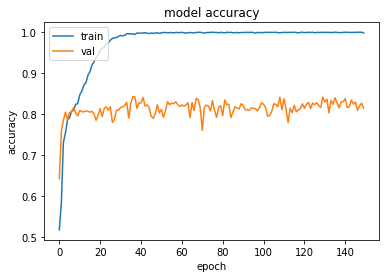

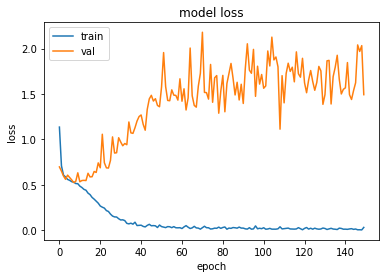

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.3663530349731445 , AUC = 0.8362091779708862 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8245887967091196
test 0.8438753132832081

-----------------------------------------------------------------


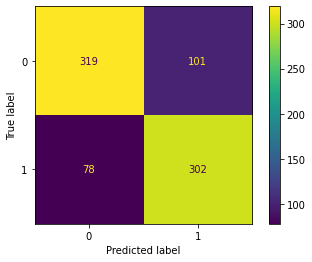

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5950980577566807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5854813586574212
118/118 - 19s - loss: 1.1984 - auc: 0.5069 - val_loss: 0.7050 - val_auc: 0.5961 - 19s/epoch - 160ms/step
Epoch 2/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7322087107816253


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7433423776504875
118/118 - 18s - loss: 0.7066 - auc: 0.5570 - val_loss: 0.6662 - val_auc: 0.7335 - 18s/epoch - 149ms/step
Epoch 3/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7861767245998575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7799844236760125
118/118 - 17s - loss: 0.6396 - auc: 0.6828 - val_loss: 0.6027 - val_auc: 0.7857 - 17s/epoch - 148ms/step
Epoch 4/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8017474516330352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8082541955582353
118/118 - 18s - loss: 0.5861 - auc: 0.7525 - val_loss: 0.5466 - val_auc: 0.8017 - 18s/epoch - 150ms/step
Epoch 5/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8080009581985867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8188121796804343
118/118 - 18s - loss: 0.5685 - auc: 0.7724 - val_loss: 0.5386 - val_auc: 0.8079 - 18s/epoch - 152ms/step
Epoch 6/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8076353297905201


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8068598633303186
118/118 - 18s - loss: 0.5553 - auc: 0.7836 - val_loss: 0.5310 - val_auc: 0.8074 - 18s/epoch - 150ms/step
Epoch 7/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8110016327199601


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8026329012159583
118/118 - 17s - loss: 0.5404 - auc: 0.8027 - val_loss: 0.5643 - val_auc: 0.8110 - 17s/epoch - 146ms/step
Epoch 8/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8155215563162308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8215380363782535
118/118 - 17s - loss: 0.5249 - auc: 0.8128 - val_loss: 0.5365 - val_auc: 0.8154 - 17s/epoch - 148ms/step
Epoch 9/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8122939400243332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8210292935383379
118/118 - 18s - loss: 0.5268 - auc: 0.8158 - val_loss: 0.5300 - val_auc: 0.8123 - 18s/epoch - 149ms/step
Epoch 10/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7957461025902883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8153765953170536
118/118 - 17s - loss: 0.5182 - auc: 0.8205 - val_loss: 0.5759 - val_auc: 0.7958 - 17s/epoch - 147ms/step
Epoch 11/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7846196518965398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8086184805547182
118/118 - 18s - loss: 0.5113 - auc: 0.8264 - val_loss: 0.6981 - val_auc: 0.7845 - 18s/epoch - 149ms/step
Epoch 12/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8082720275356015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8244083509195057
118/118 - 18s - loss: 0.4924 - auc: 0.8425 - val_loss: 0.5509 - val_auc: 0.8084 - 18s/epoch - 149ms/step
Epoch 13/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8182984410361154


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8141455632599739
118/118 - 17s - loss: 0.4826 - auc: 0.8495 - val_loss: 0.5417 - val_auc: 0.8182 - 17s/epoch - 148ms/step
Epoch 14/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8313066172437922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.845744146316953
118/118 - 17s - loss: 0.4734 - auc: 0.8542 - val_loss: 0.5034 - val_auc: 0.8312 - 17s/epoch - 148ms/step
Epoch 15/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8340677421185014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8348595618530801
118/118 - 17s - loss: 0.4398 - auc: 0.8762 - val_loss: 0.5067 - val_auc: 0.8342 - 17s/epoch - 147ms/step
Epoch 16/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8127163038750307


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8368694101095367
118/118 - 17s - loss: 0.4283 - auc: 0.8829 - val_loss: 0.5467 - val_auc: 0.8128 - 17s/epoch - 147ms/step
Epoch 17/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8237166758073768


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8409519143804643
118/118 - 17s - loss: 0.4019 - auc: 0.8985 - val_loss: 0.5166 - val_auc: 0.8237 - 17s/epoch - 147ms/step
Epoch 18/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8146137892341345


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8553474525173349
118/118 - 17s - loss: 0.3838 - auc: 0.9070 - val_loss: 0.5411 - val_auc: 0.8145 - 17s/epoch - 148ms/step
Epoch 19/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8132773543632709


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8462466083810672
118/118 - 17s - loss: 0.3500 - auc: 0.9240 - val_loss: 0.6133 - val_auc: 0.8126 - 17s/epoch - 148ms/step
Epoch 20/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8399997478424772


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8589965832579641
118/118 - 18s - loss: 0.3307 - auc: 0.9319 - val_loss: 0.5472 - val_auc: 0.8397 - 18s/epoch - 154ms/step
Epoch 21/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8261121722740196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8489096573208723
118/118 - 17s - loss: 0.2981 - auc: 0.9452 - val_loss: 0.5890 - val_auc: 0.8262 - 17s/epoch - 148ms/step
Epoch 22/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8210122863752988


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8389357853482061
118/118 - 18s - loss: 0.2791 - auc: 0.9519 - val_loss: 0.6453 - val_auc: 0.8204 - 18s/epoch - 151ms/step
Epoch 23/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8166751769830614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8435584363380564
118/118 - 17s - loss: 0.2422 - auc: 0.9639 - val_loss: 0.7255 - val_auc: 0.8171 - 17s/epoch - 146ms/step
Epoch 24/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8329960726465824


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8485139684453824
118/118 - 17s - loss: 0.2363 - auc: 0.9656 - val_loss: 0.6326 - val_auc: 0.8324 - 17s/epoch - 146ms/step
Epoch 25/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8099173553719008


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8364423173550397
118/118 - 17s - loss: 0.2051 - auc: 0.9743 - val_loss: 0.7782 - val_auc: 0.8094 - 17s/epoch - 147ms/step
Epoch 26/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8278394513052304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8531366194352327
118/118 - 17s - loss: 0.1792 - auc: 0.9804 - val_loss: 0.7268 - val_auc: 0.8257 - 17s/epoch - 146ms/step
Epoch 27/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.821535513235118


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8344921364686966
118/118 - 17s - loss: 0.1620 - auc: 0.9838 - val_loss: 0.8687 - val_auc: 0.8201 - 17s/epoch - 147ms/step
Epoch 28/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8165175785313085


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8196726459652297
118/118 - 17s - loss: 0.1596 - auc: 0.9842 - val_loss: 0.8109 - val_auc: 0.8125 - 17s/epoch - 147ms/step
Epoch 29/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8053470002710694


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8102891669178977
118/118 - 17s - loss: 0.1259 - auc: 0.9901 - val_loss: 1.0369 - val_auc: 0.7955 - 17s/epoch - 147ms/step
Epoch 30/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8464203087668867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.843137624359361
118/118 - 18s - loss: 0.1183 - auc: 0.9911 - val_loss: 0.9142 - val_auc: 0.8421 - 18s/epoch - 149ms/step
Epoch 31/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8072192698778926


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8144156366194353
118/118 - 17s - loss: 0.1308 - auc: 0.9892 - val_loss: 0.9477 - val_auc: 0.8062 - 17s/epoch - 146ms/step
Epoch 32/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8326651158979014


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8440357752989649
118/118 - 17s - loss: 0.0971 - auc: 0.9940 - val_loss: 0.9401 - val_auc: 0.8247 - 17s/epoch - 145ms/step
Epoch 33/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8409106668936084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8517234448799116
118/118 - 17s - loss: 0.0849 - auc: 0.9952 - val_loss: 1.0208 - val_auc: 0.8303 - 17s/epoch - 144ms/step
Epoch 34/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8393126185928349


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8339205858707667
118/118 - 17s - loss: 0.0750 - auc: 0.9965 - val_loss: 0.9922 - val_auc: 0.8325 - 17s/epoch - 144ms/step
Epoch 35/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8338849279144682


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8528351421967642
118/118 - 17s - loss: 0.0630 - auc: 0.9971 - val_loss: 1.0708 - val_auc: 0.8212 - 17s/epoch - 144ms/step
Epoch 36/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8260964124288444


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8362978595116068
118/118 - 17s - loss: 0.0657 - auc: 0.9972 - val_loss: 1.2509 - val_auc: 0.8152 - 17s/epoch - 145ms/step
Epoch 37/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8406679652779091


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8477916792282183
118/118 - 17s - loss: 0.0716 - auc: 0.9962 - val_loss: 0.9830 - val_auc: 0.8344 - 17s/epoch - 146ms/step
Epoch 38/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8450523542056723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8469312129434228
118/118 - 17s - loss: 0.0525 - auc: 0.9968 - val_loss: 1.0328 - val_auc: 0.8364 - 17s/epoch - 146ms/step
Epoch 39/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8354325447106808


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8487746206411415
118/118 - 17s - loss: 0.0579 - auc: 0.9980 - val_loss: 1.2206 - val_auc: 0.8268 - 17s/epoch - 144ms/step
Epoch 40/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8203692846921472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8446355893880013
118/118 - 17s - loss: 0.0624 - auc: 0.9974 - val_loss: 1.2342 - val_auc: 0.8107 - 17s/epoch - 144ms/step
Epoch 41/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8291506704238139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8342785900914481
118/118 - 17s - loss: 0.0606 - auc: 0.9976 - val_loss: 1.5669 - val_auc: 0.8089 - 17s/epoch - 144ms/step
Epoch 42/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8454936298705801


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8575928298663451
118/118 - 17s - loss: 0.0695 - auc: 0.9962 - val_loss: 1.0461 - val_auc: 0.8383 - 17s/epoch - 144ms/step
Epoch 43/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8347485674300735


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8464507335946136
118/118 - 17s - loss: 0.0336 - auc: 0.9990 - val_loss: 1.3635 - val_auc: 0.8234 - 17s/epoch - 144ms/step
Epoch 44/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8501711519186036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8570966485780322
118/118 - 17s - loss: 0.0172 - auc: 0.9999 - val_loss: 1.4799 - val_auc: 0.8330 - 17s/epoch - 144ms/step
Epoch 45/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8446268383859398


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.843718596120993
118/118 - 17s - loss: 0.0743 - auc: 0.9954 - val_loss: 1.1285 - val_auc: 0.8363 - 17s/epoch - 144ms/step
Epoch 46/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8257181761446376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8512963521254144
118/118 - 17s - loss: 0.0381 - auc: 0.9988 - val_loss: 1.3277 - val_auc: 0.8119 - 17s/epoch - 144ms/step
Epoch 47/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8607270962170068


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8726666917897699
118/118 - 17s - loss: 0.0284 - auc: 0.9991 - val_loss: 1.2707 - val_auc: 0.8466 - 17s/epoch - 145ms/step
Epoch 48/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8573324255662511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8643383830770777
118/118 - 17s - loss: 0.0340 - auc: 0.9986 - val_loss: 1.1824 - val_auc: 0.8417 - 17s/epoch - 145ms/step
Epoch 49/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8463446615100452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8510514018691588
118/118 - 17s - loss: 0.0392 - auc: 0.9983 - val_loss: 1.2888 - val_auc: 0.8302 - 17s/epoch - 145ms/step
Epoch 50/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8545240211560161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8627148025324088
118/118 - 17s - loss: 0.0323 - auc: 0.9991 - val_loss: 1.2621 - val_auc: 0.8453 - 17s/epoch - 144ms/step
Epoch 51/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8233888710277311


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8366527233443875
118/118 - 17s - loss: 0.0414 - auc: 0.9985 - val_loss: 1.2698 - val_auc: 0.8115 - 17s/epoch - 145ms/step
Epoch 52/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8337714570292061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8593200432117375
118/118 - 17s - loss: 0.0451 - auc: 0.9979 - val_loss: 1.3357 - val_auc: 0.8221 - 17s/epoch - 143ms/step
Epoch 53/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8447403092712019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8598664707064618
118/118 - 17s - loss: 0.0241 - auc: 0.9992 - val_loss: 1.4998 - val_auc: 0.8258 - 17s/epoch - 146ms/step
Epoch 54/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8556461221324961


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.853494623655914
118/118 - 17s - loss: 0.0377 - auc: 0.9988 - val_loss: 1.2093 - val_auc: 0.8357 - 17s/epoch - 145ms/step
Epoch 55/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8551764787462729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8575896894784444
118/118 - 17s - loss: 0.0446 - auc: 0.9983 - val_loss: 1.0483 - val_auc: 0.8458 - 17s/epoch - 145ms/step
Epoch 56/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8348116068107747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8481748065521053
118/118 - 17s - loss: 0.0468 - auc: 0.9986 - val_loss: 1.3559 - val_auc: 0.8237 - 17s/epoch - 145ms/step
Epoch 57/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8570046207866054


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8653370264295046
118/118 - 17s - loss: 0.0173 - auc: 0.9996 - val_loss: 1.3568 - val_auc: 0.8404 - 17s/epoch - 145ms/step
Epoch 58/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8419129930467563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8378868957893678
118/118 - 17s - loss: 0.0275 - auc: 0.9993 - val_loss: 1.2782 - val_auc: 0.8340 - 17s/epoch - 145ms/step
Epoch 59/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8613259703336675


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8627085217566075
118/118 - 17s - loss: 0.0374 - auc: 0.9989 - val_loss: 1.1857 - val_auc: 0.8462 - 17s/epoch - 145ms/step
Epoch 60/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8617672459985755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.869432092252035
118/118 - 17s - loss: 0.0326 - auc: 0.9993 - val_loss: 1.0981 - val_auc: 0.8510 - 17s/epoch - 145ms/step
Epoch 61/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8417774583782489


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8363292633906141
118/118 - 17s - loss: 0.0256 - auc: 0.9996 - val_loss: 1.8934 - val_auc: 0.7873 - 17s/epoch - 145ms/step
Epoch 62/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8616663829894535


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8672401014973369
118/118 - 17s - loss: 0.0301 - auc: 0.9987 - val_loss: 1.1899 - val_auc: 0.8437 - 17s/epoch - 146ms/step
Epoch 63/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8458056748050506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8590593910159783
118/118 - 17s - loss: 0.0258 - auc: 0.9993 - val_loss: 1.4486 - val_auc: 0.8238 - 17s/epoch - 146ms/step
Epoch 64/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8622936248274297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8619611094362376
118/118 - 17s - loss: 0.0373 - auc: 0.9981 - val_loss: 1.1932 - val_auc: 0.8535 - 17s/epoch - 145ms/step
Epoch 65/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8575656712748455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8674505074866847
118/118 - 17s - loss: 0.0211 - auc: 0.9992 - val_loss: 1.2463 - val_auc: 0.8425 - 17s/epoch - 146ms/step
Epoch 66/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8436654878302474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8565784845744147
118/118 - 17s - loss: 0.0230 - auc: 0.9994 - val_loss: 1.6804 - val_auc: 0.8272 - 17s/epoch - 146ms/step
Epoch 67/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8470254868216176


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.826038212239976
118/118 - 17s - loss: 0.0383 - auc: 0.9985 - val_loss: 1.5953 - val_auc: 0.8065 - 17s/epoch - 145ms/step
Epoch 68/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8499883377145703


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8693033363481059
118/118 - 17s - loss: 0.0283 - auc: 0.9988 - val_loss: 1.3821 - val_auc: 0.8314 - 17s/epoch - 144ms/step
Epoch 69/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8542119762215455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8580042206813386
118/118 - 17s - loss: 0.0296 - auc: 0.9995 - val_loss: 1.1957 - val_auc: 0.8465 - 17s/epoch - 147ms/step
Epoch 70/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8496983565633451


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8617632649984927
118/118 - 18s - loss: 0.0160 - auc: 0.9996 - val_loss: 1.4018 - val_auc: 0.8289 - 18s/epoch - 149ms/step
Epoch 71/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8358958841588341


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8580513264998493
118/118 - 18s - loss: 0.0247 - auc: 0.9992 - val_loss: 1.4299 - val_auc: 0.8207 - 18s/epoch - 149ms/step
Epoch 72/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8558573040578449


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8727985880815998
118/118 - 17s - loss: 0.0191 - auc: 0.9997 - val_loss: 1.4348 - val_auc: 0.8358 - 17s/epoch - 148ms/step
Epoch 73/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8430287900851662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8668946588282584
118/118 - 17s - loss: 0.0124 - auc: 0.9999 - val_loss: 1.7615 - val_auc: 0.8210 - 17s/epoch - 147ms/step
Epoch 74/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8507101386235981


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8627305044719122
118/118 - 17s - loss: 0.0301 - auc: 0.9991 - val_loss: 1.4848 - val_auc: 0.8293 - 17s/epoch - 148ms/step
Epoch 75/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8570266845698506


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8611289066425485
118/118 - 17s - loss: 0.0214 - auc: 0.9990 - val_loss: 1.3725 - val_auc: 0.8327 - 17s/epoch - 148ms/step
Epoch 76/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.84604837642075


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8398841824942217
118/118 - 17s - loss: 0.0201 - auc: 0.9995 - val_loss: 1.6030 - val_auc: 0.8193 - 17s/epoch - 146ms/step
Epoch 77/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8069608084170181


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8423996332026933
118/118 - 17s - loss: 0.0342 - auc: 0.9986 - val_loss: 1.4589 - val_auc: 0.7908 - 17s/epoch - 148ms/step
Epoch 78/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8470727663571432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8526404381469199
118/118 - 17s - loss: 0.0290 - auc: 0.9995 - val_loss: 1.3688 - val_auc: 0.8347 - 17s/epoch - 146ms/step
Epoch 79/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8486739666269519


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8486992513315246
118/118 - 17s - loss: 0.0251 - auc: 0.9991 - val_loss: 1.4107 - val_auc: 0.8309 - 17s/epoch - 147ms/step
Epoch 80/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8550062724183797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.85818636317958
118/118 - 18s - loss: 0.0159 - auc: 0.9999 - val_loss: 1.6818 - val_auc: 0.8252 - 18s/epoch - 150ms/step
Epoch 81/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8311238030397589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8357702743442872
118/118 - 17s - loss: 0.0291 - auc: 0.9993 - val_loss: 1.4593 - val_auc: 0.8124 - 17s/epoch - 144ms/step
Epoch 82/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8625615421954095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.867174153351422
118/118 - 17s - loss: 0.0258 - auc: 0.9993 - val_loss: 1.4502 - val_auc: 0.8424 - 17s/epoch - 146ms/step
Epoch 83/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8572347145261645


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.856804592503266
118/118 - 17s - loss: 0.0179 - auc: 0.9996 - val_loss: 1.4947 - val_auc: 0.8384 - 17s/epoch - 147ms/step
Epoch 84/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8448789959087442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8639992211838007
118/118 - 17s - loss: 0.0419 - auc: 0.9983 - val_loss: 1.2687 - val_auc: 0.8337 - 17s/epoch - 145ms/step
Epoch 85/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8539062352251452


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8524300321575722
118/118 - 18s - loss: 0.0143 - auc: 0.9999 - val_loss: 1.4492 - val_auc: 0.8328 - 18s/epoch - 148ms/step
Epoch 86/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8457142677030342


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8585820520550699
118/118 - 18s - loss: 0.0084 - auc: 0.9999 - val_loss: 1.9329 - val_auc: 0.8185 - 18s/epoch - 151ms/step
Epoch 87/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8423826364329797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8493524520148729
118/118 - 18s - loss: 0.0123 - auc: 0.9999 - val_loss: 1.9221 - val_auc: 0.8149 - 18s/epoch - 151ms/step
Epoch 88/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8381716058021447


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8293607426389308
118/118 - 17s - loss: 0.0182 - auc: 0.9995 - val_loss: 1.6176 - val_auc: 0.8166 - 17s/epoch - 148ms/step
Epoch 89/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8555956906279354


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8567103808662447
118/118 - 17s - loss: 0.0360 - auc: 0.9990 - val_loss: 1.1481 - val_auc: 0.8475 - 17s/epoch - 145ms/step
Epoch 90/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8452855999142665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8565219575922018
118/118 - 17s - loss: 0.0277 - auc: 0.9996 - val_loss: 1.4750 - val_auc: 0.8313 - 17s/epoch - 145ms/step
Epoch 91/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8478134790803815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8712503768465482
118/118 - 17s - loss: 0.0131 - auc: 0.9997 - val_loss: 1.8524 - val_auc: 0.8183 - 17s/epoch - 145ms/step
Epoch 92/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8494083754121199


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8616847553009748
118/118 - 17s - loss: 0.0120 - auc: 0.9994 - val_loss: 1.7035 - val_auc: 0.8183 - 17s/epoch - 147ms/step
Epoch 93/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8631572643430351


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8595178876494827
118/118 - 17s - loss: 0.0205 - auc: 0.9992 - val_loss: 1.3218 - val_auc: 0.8431 - 17s/epoch - 147ms/step
Epoch 94/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8461933669963628


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8603909154858806
118/118 - 17s - loss: 0.0104 - auc: 0.9997 - val_loss: 1.7651 - val_auc: 0.8129 - 17s/epoch - 146ms/step
Epoch 95/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8544389179920695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8574044065923023
118/118 - 17s - loss: 0.0395 - auc: 0.9982 - val_loss: 1.2291 - val_auc: 0.8446 - 17s/epoch - 145ms/step
Epoch 96/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8425969703273635


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8659494020701436
118/118 - 17s - loss: 0.0163 - auc: 0.9999 - val_loss: 1.5878 - val_auc: 0.8250 - 17s/epoch - 146ms/step
Epoch 97/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.850363422029742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8621777962013868
118/118 - 17s - loss: 0.0119 - auc: 0.9996 - val_loss: 1.7323 - val_auc: 0.8291 - 17s/epoch - 146ms/step
Epoch 98/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8569983168485352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8646272987639433
118/118 - 17s - loss: 0.0100 - auc: 0.9999 - val_loss: 1.7348 - val_auc: 0.8341 - 17s/epoch - 145ms/step
Epoch 99/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8612282592935807


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.852715807456537
118/118 - 17s - loss: 0.0172 - auc: 0.9993 - val_loss: 1.4975 - val_auc: 0.8387 - 17s/epoch - 147ms/step
Epoch 100/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8481601956742377


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8500778816199377
118/118 - 17s - loss: 0.0348 - auc: 0.9981 - val_loss: 1.3150 - val_auc: 0.8295 - 17s/epoch - 146ms/step
Epoch 101/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8565160655861717


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.859159883428801
118/118 - 17s - loss: 0.0100 - auc: 0.9997 - val_loss: 1.4826 - val_auc: 0.8407 - 17s/epoch - 144ms/step
Epoch 102/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8522766672340211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.842917797206311
118/118 - 17s - loss: 0.0223 - auc: 0.9992 - val_loss: 1.3905 - val_auc: 0.8392 - 17s/epoch - 146ms/step
Epoch 103/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8581740012986113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8573447392221887
118/118 - 17s - loss: 0.0245 - auc: 0.9989 - val_loss: 1.3236 - val_auc: 0.8398 - 17s/epoch - 147ms/step
Epoch 104/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8507132905926332


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.86320470304492
118/118 - 17s - loss: 0.0061 - auc: 1.0000 - val_loss: 1.5001 - val_auc: 0.8346 - 17s/epoch - 146ms/step
Epoch 105/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.842057983622369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8427544970354739
118/118 - 17s - loss: 0.0136 - auc: 0.9994 - val_loss: 1.7646 - val_auc: 0.8196 - 17s/epoch - 145ms/step
Epoch 106/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8543632707352283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8569992965531102
118/118 - 17s - loss: 0.0202 - auc: 0.9995 - val_loss: 1.5498 - val_auc: 0.8374 - 17s/epoch - 145ms/step
Epoch 107/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8366113811297917


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8478796100894381
118/118 - 17s - loss: 0.0079 - auc: 1.0000 - val_loss: 1.8709 - val_auc: 0.8178 - 17s/epoch - 145ms/step
Epoch 108/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8417837623163189


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8560854436740026
118/118 - 17s - loss: 0.0360 - auc: 0.9979 - val_loss: 1.2052 - val_auc: 0.8263 - 17s/epoch - 144ms/step
Epoch 109/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8524910011284049


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8534914832680133
118/118 - 17s - loss: 0.0172 - auc: 0.9995 - val_loss: 1.2671 - val_auc: 0.8385 - 17s/epoch - 146ms/step
Epoch 110/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8510946788458751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.847289217164104
118/118 - 17s - loss: 0.0195 - auc: 0.9992 - val_loss: 1.3957 - val_auc: 0.8369 - 17s/epoch - 144ms/step
Epoch 111/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8536351658881304


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8571688774997489
118/118 - 17s - loss: 0.0265 - auc: 0.9989 - val_loss: 1.3203 - val_auc: 0.8331 - 17s/epoch - 145ms/step
Epoch 112/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8603047323663094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8589369158878506
118/118 - 18s - loss: 0.0248 - auc: 0.9987 - val_loss: 1.1200 - val_auc: 0.8557 - 18s/epoch - 149ms/step
Epoch 113/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8604560268799919


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8683172545472817
118/118 - 17s - loss: 0.0175 - auc: 0.9998 - val_loss: 1.3469 - val_auc: 0.8405 - 17s/epoch - 143ms/step
Epoch 114/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8513058607712237


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8405122600743645
118/118 - 17s - loss: 0.0150 - auc: 0.9996 - val_loss: 1.4521 - val_auc: 0.8273 - 17s/epoch - 144ms/step
Epoch 115/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8528188059080508


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8610252738418249
118/118 - 17s - loss: 0.0202 - auc: 0.9998 - val_loss: 1.4673 - val_auc: 0.8262 - 17s/epoch - 146ms/step
Epoch 116/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.856204020651701


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8543362476133052
118/118 - 17s - loss: 0.0151 - auc: 0.9999 - val_loss: 1.3725 - val_auc: 0.8317 - 17s/epoch - 145ms/step
Epoch 117/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8190391537593534


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8319013164506079
118/118 - 17s - loss: 0.0166 - auc: 0.9996 - val_loss: 1.7032 - val_auc: 0.7892 - 17s/epoch - 144ms/step
Epoch 118/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8590470967213217


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8582397497738921
118/118 - 18s - loss: 0.0189 - auc: 0.9998 - val_loss: 1.5088 - val_auc: 0.8301 - 18s/epoch - 154ms/step
Epoch 119/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8587445076939564


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8596529243292131
118/118 - 17s - loss: 0.0073 - auc: 0.9997 - val_loss: 1.5036 - val_auc: 0.8402 - 17s/epoch - 148ms/step
Epoch 120/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8556965536370571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8605071098382073
118/118 - 17s - loss: 0.0168 - auc: 0.9990 - val_loss: 1.5004 - val_auc: 0.8304 - 17s/epoch - 147ms/step
Epoch 121/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8527242468369991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8598947341975681
118/118 - 17s - loss: 0.0286 - auc: 0.9990 - val_loss: 1.2497 - val_auc: 0.8335 - 17s/epoch - 145ms/step
Epoch 122/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8627916359349685


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8703428047432419
118/118 - 17s - loss: 0.0123 - auc: 0.9999 - val_loss: 1.3214 - val_auc: 0.8472 - 17s/epoch - 146ms/step
Epoch 123/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8485258240823043


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8453798613204703
118/118 - 17s - loss: 0.0138 - auc: 0.9999 - val_loss: 1.5826 - val_auc: 0.8247 - 17s/epoch - 145ms/step
Epoch 124/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8548076983691713


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8596340820018089
118/118 - 17s - loss: 0.0072 - auc: 1.0000 - val_loss: 1.6224 - val_auc: 0.8295 - 17s/epoch - 145ms/step
Epoch 125/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8575751271819505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8608305697919807
118/118 - 17s - loss: 0.0074 - auc: 0.9994 - val_loss: 1.8306 - val_auc: 0.8182 - 17s/epoch - 146ms/step
Epoch 126/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.843006726301921


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8625891870163802
118/118 - 17s - loss: 0.0165 - auc: 0.9996 - val_loss: 1.7934 - val_auc: 0.8157 - 17s/epoch - 146ms/step
Epoch 127/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8429468388902547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8600360516531004
118/118 - 17s - loss: 0.0140 - auc: 0.9999 - val_loss: 1.5181 - val_auc: 0.8179 - 17s/epoch - 145ms/step
Epoch 128/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8542561037880363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8595304492010853
118/118 - 17s - loss: 0.0172 - auc: 0.9993 - val_loss: 1.5261 - val_auc: 0.8294 - 17s/epoch - 145ms/step
Epoch 129/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8483398579092359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8494435232639936
118/118 - 17s - loss: 0.0133 - auc: 0.9999 - val_loss: 1.6294 - val_auc: 0.8286 - 17s/epoch - 146ms/step
Epoch 130/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8516998569006058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8419411365691889
118/118 - 17s - loss: 0.0275 - auc: 0.9983 - val_loss: 1.1825 - val_auc: 0.8409 - 17s/epoch - 144ms/step
Epoch 131/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8549684487899591


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8576336549090543
118/118 - 17s - loss: 0.0172 - auc: 0.9990 - val_loss: 1.5318 - val_auc: 0.8282 - 17s/epoch - 145ms/step
Epoch 132/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8468395206485492


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8535448698623255
118/118 - 17s - loss: 0.0098 - auc: 0.9999 - val_loss: 1.8153 - val_auc: 0.8236 - 17s/epoch - 146ms/step
Epoch 133/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8462942300054845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8434045573309215
118/118 - 17s - loss: 0.0214 - auc: 0.9995 - val_loss: 1.4496 - val_auc: 0.8253 - 17s/epoch - 146ms/step
Epoch 134/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8332545341074569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8410712491206914
118/118 - 18s - loss: 0.0144 - auc: 0.9996 - val_loss: 1.8370 - val_auc: 0.8068 - 18s/epoch - 156ms/step
Epoch 135/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8469876631931968


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8578911667169129
118/118 - 18s - loss: 0.0112 - auc: 0.9999 - val_loss: 1.5705 - val_auc: 0.8264 - 18s/epoch - 150ms/step
Epoch 136/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8503665739987771


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8595021857099789
118/118 - 18s - loss: 0.0118 - auc: 0.9997 - val_loss: 1.7375 - val_auc: 0.8287 - 18s/epoch - 149ms/step
Epoch 137/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8447056376118159


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8445633604662848
118/118 - 17s - loss: 0.0206 - auc: 0.9995 - val_loss: 1.6394 - val_auc: 0.8227 - 17s/epoch - 147ms/step
Epoch 138/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8566768160069597


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8646712641945533
118/118 - 17s - loss: 0.0106 - auc: 0.9999 - val_loss: 1.8508 - val_auc: 0.8299 - 17s/epoch - 147ms/step
Epoch 139/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8362835763501459


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8525399457340971
118/118 - 17s - loss: 0.0125 - auc: 0.9996 - val_loss: 1.9811 - val_auc: 0.8048 - 17s/epoch - 148ms/step
Epoch 140/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8378627128367091


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8562079188021304
118/118 - 17s - loss: 0.0132 - auc: 0.9999 - val_loss: 2.1661 - val_auc: 0.8021 - 17s/epoch - 146ms/step
Epoch 141/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8545839085676822


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8704935433624761
118/118 - 17s - loss: 0.0295 - auc: 0.9985 - val_loss: 1.3429 - val_auc: 0.8358 - 17s/epoch - 147ms/step
Epoch 142/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8544483738991747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8679152848959903
118/118 - 18s - loss: 0.0090 - auc: 1.0000 - val_loss: 1.5164 - val_auc: 0.8285 - 18s/epoch - 149ms/step
Epoch 143/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8651083331757349


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8680126369209124
118/118 - 17s - loss: 0.0079 - auc: 0.9997 - val_loss: 1.6059 - val_auc: 0.8400 - 17s/epoch - 146ms/step
Epoch 144/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8559959906953873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8593608682544468
118/118 - 17s - loss: 0.0164 - auc: 0.9996 - val_loss: 1.4667 - val_auc: 0.8345 - 17s/epoch - 147ms/step
Epoch 145/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8738298314957355


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8583339614109136
118/118 - 18s - loss: 0.0083 - auc: 1.0000 - val_loss: 1.4583 - val_auc: 0.8484 - 18s/epoch - 149ms/step
Epoch 146/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8556303622873208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8553129082504273
118/118 - 17s - loss: 0.0153 - auc: 0.9991 - val_loss: 1.3521 - val_auc: 0.8349 - 17s/epoch - 146ms/step
Epoch 147/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8583032320290486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8467490704451813
118/118 - 18s - loss: 0.0197 - auc: 0.9992 - val_loss: 1.2803 - val_auc: 0.8416 - 18s/epoch - 151ms/step
Epoch 148/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8721088564025947


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8477602753492112
118/118 - 17s - loss: 0.0109 - auc: 0.9997 - val_loss: 1.3513 - val_auc: 0.8534 - 17s/epoch - 148ms/step
Epoch 149/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8612755388291066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8548701135564266
118/118 - 17s - loss: 0.0101 - auc: 0.9997 - val_loss: 1.4519 - val_auc: 0.8425 - 17s/epoch - 145ms/step
Epoch 150/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8395080406730084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8495754195558236
118/118 - 18s - loss: 0.0062 - auc: 1.0000 - val_loss: 1.8023 - val_auc: 0.8131 - 18s/epoch - 150ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


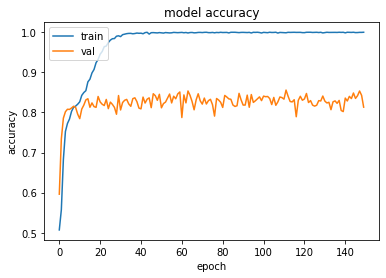

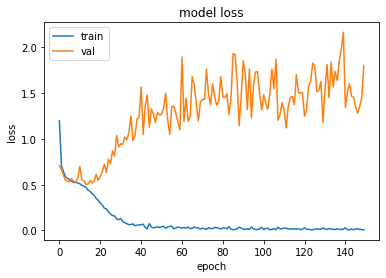

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.7081063985824585 , AUC = 0.811086893081665 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8395080406730084
test 0.8495754195558236

-----------------------------------------------------------------


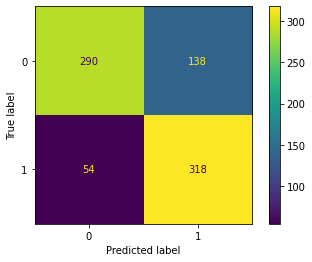

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.5812395152017794


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.5911986247851226
118/118 - 19s - loss: 1.0260 - auc: 0.5168 - val_loss: 0.6899 - val_auc: 0.5833 - 19s/epoch - 164ms/step
Epoch 2/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7246024415835737


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7284700734489764
118/118 - 18s - loss: 0.7100 - auc: 0.5550 - val_loss: 0.6783 - val_auc: 0.7245 - 18s/epoch - 149ms/step
Epoch 3/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.799219648276252


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7929676511954993
118/118 - 18s - loss: 0.6559 - auc: 0.6573 - val_loss: 0.5738 - val_auc: 0.7989 - 18s/epoch - 149ms/step
Epoch 4/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.788415986529194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8013189560868885
118/118 - 18s - loss: 0.5868 - auc: 0.7523 - val_loss: 0.5530 - val_auc: 0.7889 - 18s/epoch - 152ms/step
Epoch 5/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8001244038979887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8084919518674792
118/118 - 18s - loss: 0.5642 - auc: 0.7782 - val_loss: 0.5433 - val_auc: 0.8000 - 18s/epoch - 150ms/step
Epoch 6/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7961912301534944


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8089451476793249
118/118 - 18s - loss: 0.5529 - auc: 0.7888 - val_loss: 0.5482 - val_auc: 0.7962 - 18s/epoch - 148ms/step
Epoch 7/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7984405531575344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8042256602594156
118/118 - 18s - loss: 0.5415 - auc: 0.7991 - val_loss: 0.6058 - val_auc: 0.7983 - 18s/epoch - 149ms/step
Epoch 8/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8069917503879769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8179215502422252
118/118 - 18s - loss: 0.5351 - auc: 0.8051 - val_loss: 0.5309 - val_auc: 0.8068 - 18s/epoch - 149ms/step
Epoch 9/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8085562236505632


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8124832005000782
118/118 - 17s - loss: 0.5141 - auc: 0.8228 - val_loss: 0.5335 - val_auc: 0.8087 - 17s/epoch - 148ms/step
Epoch 10/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7979881753466659


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8152648851383029
118/118 - 17s - loss: 0.5098 - auc: 0.8279 - val_loss: 0.5491 - val_auc: 0.7981 - 17s/epoch - 147ms/step
Epoch 11/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8179179311254782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8199281137677762
118/118 - 17s - loss: 0.4833 - auc: 0.8464 - val_loss: 0.5424 - val_auc: 0.8178 - 17s/epoch - 147ms/step
Epoch 12/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.79834630778027


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8120706360368808
118/118 - 17s - loss: 0.4782 - auc: 0.8503 - val_loss: 0.5527 - val_auc: 0.7982 - 17s/epoch - 147ms/step
Epoch 13/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8219265011717842


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.811132989529614
118/118 - 17s - loss: 0.4688 - auc: 0.8560 - val_loss: 0.5387 - val_auc: 0.8218 - 17s/epoch - 147ms/step
Epoch 14/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8103280367431311


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8122269104547585
118/118 - 17s - loss: 0.4494 - auc: 0.8698 - val_loss: 0.5570 - val_auc: 0.8104 - 17s/epoch - 147ms/step
Epoch 15/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7971588160267405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7910548523206752
118/118 - 17s - loss: 0.4267 - auc: 0.8825 - val_loss: 0.5775 - val_auc: 0.7972 - 17s/epoch - 146ms/step
Epoch 16/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.813199379237115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8181215814971089
118/118 - 18s - loss: 0.4153 - auc: 0.8903 - val_loss: 0.5341 - val_auc: 0.8131 - 18s/epoch - 157ms/step
Epoch 17/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8137460024252476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8023191123613064
118/118 - 18s - loss: 0.3975 - auc: 0.9005 - val_loss: 0.5653 - val_auc: 0.8135 - 18s/epoch - 149ms/step
Epoch 18/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7608869118303081


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7583059853102048
118/118 - 18s - loss: 0.3782 - auc: 0.9093 - val_loss: 0.6275 - val_auc: 0.7608 - 18s/epoch - 148ms/step
Epoch 19/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8170885718055528


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8101578371620566
118/118 - 18s - loss: 0.3587 - auc: 0.9198 - val_loss: 0.5579 - val_auc: 0.8169 - 18s/epoch - 151ms/step
Epoch 20/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8192876306083854


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.800725113298953
118/118 - 17s - loss: 0.3299 - auc: 0.9320 - val_loss: 0.5625 - val_auc: 0.8193 - 17s/epoch - 147ms/step
Epoch 21/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8215935008387839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7922175339896859
118/118 - 18s - loss: 0.3088 - auc: 0.9408 - val_loss: 0.6682 - val_auc: 0.8212 - 18s/epoch - 150ms/step
Epoch 22/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7887018641735624


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7889545241443976
118/118 - 18s - loss: 0.2812 - auc: 0.9510 - val_loss: 0.6505 - val_auc: 0.7886 - 18s/epoch - 149ms/step
Epoch 23/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8286242059826965


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8207469917174558
118/118 - 18s - loss: 0.2720 - auc: 0.9543 - val_loss: 0.7313 - val_auc: 0.8282 - 18s/epoch - 150ms/step
Epoch 24/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7809486111372903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7688576340053134
118/118 - 18s - loss: 0.2359 - auc: 0.9658 - val_loss: 0.8490 - val_auc: 0.7806 - 18s/epoch - 150ms/step
Epoch 25/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8239559182955409


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8090451633067666
118/118 - 18s - loss: 0.2120 - auc: 0.9722 - val_loss: 0.6362 - val_auc: 0.8245 - 18s/epoch - 149ms/step
Epoch 26/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7903166016373565


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7790967338646663
118/118 - 18s - loss: 0.1956 - auc: 0.9765 - val_loss: 0.8861 - val_auc: 0.7890 - 18s/epoch - 148ms/step
Epoch 27/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.834077871813721


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8085388341928427
118/118 - 18s - loss: 0.1858 - auc: 0.9786 - val_loss: 0.8310 - val_auc: 0.8285 - 18s/epoch - 149ms/step
Epoch 28/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8015569336324053


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8126582278481013
118/118 - 18s - loss: 0.1492 - auc: 0.9861 - val_loss: 1.0970 - val_auc: 0.7946 - 18s/epoch - 149ms/step
Epoch 29/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8170006094534397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8047944991404907
118/118 - 17s - loss: 0.1641 - auc: 0.9835 - val_loss: 0.8215 - val_auc: 0.8180 - 17s/epoch - 147ms/step
Epoch 30/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8222469354544826


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8136990154711674
118/118 - 17s - loss: 0.1214 - auc: 0.9909 - val_loss: 0.9429 - val_auc: 0.8169 - 17s/epoch - 147ms/step
Epoch 31/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8246219189615416


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8116736990154712
118/118 - 17s - loss: 0.1330 - auc: 0.9891 - val_loss: 1.0251 - val_auc: 0.8195 - 17s/epoch - 148ms/step
Epoch 32/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8017925470755659


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7830160962650414
118/118 - 19s - loss: 0.1051 - auc: 0.9929 - val_loss: 1.1616 - val_auc: 0.7969 - 19s/epoch - 157ms/step
Epoch 33/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8153481738387399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8012501953430224
118/118 - 19s - loss: 0.1126 - auc: 0.9919 - val_loss: 0.8863 - val_auc: 0.8097 - 19s/epoch - 157ms/step
Epoch 34/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8211285569776136


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8017940303172371
118/118 - 19s - loss: 0.1016 - auc: 0.9930 - val_loss: 0.9611 - val_auc: 0.8160 - 19s/epoch - 157ms/step
Epoch 35/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8106798861515843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8091139240506329
118/118 - 18s - loss: 0.0766 - auc: 0.9964 - val_loss: 1.1865 - val_auc: 0.8024 - 18s/epoch - 150ms/step
Epoch 36/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8230134645228985


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8042350367244882
118/118 - 18s - loss: 0.0896 - auc: 0.9944 - val_loss: 1.2582 - val_auc: 0.8170 - 18s/epoch - 154ms/step
Epoch 37/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8174592702894589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8049632755117987
118/118 - 18s - loss: 0.0870 - auc: 0.9946 - val_loss: 1.0404 - val_auc: 0.8081 - 18s/epoch - 150ms/step
Epoch 38/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8174404212140061


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8040412564463196
118/118 - 18s - loss: 0.0716 - auc: 0.9962 - val_loss: 0.9754 - val_auc: 0.8134 - 18s/epoch - 149ms/step
Epoch 39/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8264691283559208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8001218940459447
118/118 - 18s - loss: 0.0583 - auc: 0.9972 - val_loss: 1.1320 - val_auc: 0.8193 - 18s/epoch - 151ms/step
Epoch 40/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8228124077180681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8242787935614939
118/118 - 17s - loss: 0.0700 - auc: 0.9967 - val_loss: 1.2024 - val_auc: 0.8061 - 17s/epoch - 148ms/step
Epoch 41/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8294033011014144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8092576965150805
118/118 - 17s - loss: 0.0809 - auc: 0.9957 - val_loss: 1.0619 - val_auc: 0.8185 - 17s/epoch - 148ms/step
Epoch 42/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8365031195219875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8085888420065634
118/118 - 17s - loss: 0.0561 - auc: 0.9977 - val_loss: 1.1120 - val_auc: 0.8221 - 17s/epoch - 147ms/step
Epoch 43/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8143146162014088


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8124081887794968
118/118 - 17s - loss: 0.0377 - auc: 0.9986 - val_loss: 1.3948 - val_auc: 0.8032 - 17s/epoch - 148ms/step
Epoch 44/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8236857482140499


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8129864041256446
118/118 - 17s - loss: 0.0506 - auc: 0.9985 - val_loss: 1.2913 - val_auc: 0.8155 - 17s/epoch - 147ms/step
Epoch 45/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7955503615880974


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7961118924832006
118/118 - 17s - loss: 0.0532 - auc: 0.9973 - val_loss: 1.3600 - val_auc: 0.7853 - 17s/epoch - 147ms/step
Epoch 46/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8279770543921486


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8182684794499139
118/118 - 18s - loss: 0.0564 - auc: 0.9973 - val_loss: 1.3608 - val_auc: 0.8137 - 18s/epoch - 149ms/step
Epoch 47/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8005485080956779


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8070260978277854
118/118 - 17s - loss: 0.0386 - auc: 0.9984 - val_loss: 1.3982 - val_auc: 0.7903 - 17s/epoch - 148ms/step
Epoch 48/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7955817767138522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.775474292858259
118/118 - 18s - loss: 0.0566 - auc: 0.9972 - val_loss: 1.2231 - val_auc: 0.7885 - 18s/epoch - 154ms/step
Epoch 49/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.804412568563512


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7987185497734021
118/118 - 18s - loss: 0.0407 - auc: 0.9988 - val_loss: 1.4309 - val_auc: 0.7861 - 18s/epoch - 150ms/step
Epoch 50/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8190614417029511


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8114861697140179
118/118 - 18s - loss: 0.0445 - auc: 0.9978 - val_loss: 1.2467 - val_auc: 0.8119 - 18s/epoch - 148ms/step
Epoch 51/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8187504319579791


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8094671042350366
118/118 - 18s - loss: 0.0524 - auc: 0.9980 - val_loss: 1.5693 - val_auc: 0.7976 - 18s/epoch - 154ms/step
Epoch 52/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8437160323952776


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8162369120175027
118/118 - 18s - loss: 0.0492 - auc: 0.9980 - val_loss: 1.1287 - val_auc: 0.8367 - 18s/epoch - 149ms/step
Epoch 53/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.838246659001376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8093608376308798
118/118 - 18s - loss: 0.0282 - auc: 0.9995 - val_loss: 1.2418 - val_auc: 0.8309 - 18s/epoch - 150ms/step
Epoch 54/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8102243668281405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7945772776996406
118/118 - 17s - loss: 0.0421 - auc: 0.9986 - val_loss: 1.5525 - val_auc: 0.7930 - 17s/epoch - 148ms/step
Epoch 55/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8307007457950853


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8095139865604001
118/118 - 18s - loss: 0.0265 - auc: 0.9996 - val_loss: 1.4072 - val_auc: 0.8114 - 18s/epoch - 150ms/step
Epoch 56/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8212950571441138


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8006219721831536
118/118 - 18s - loss: 0.0401 - auc: 0.9980 - val_loss: 1.4348 - val_auc: 0.7957 - 18s/epoch - 155ms/step
Epoch 57/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8151596830842114


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8006313486482264
118/118 - 18s - loss: 0.0320 - auc: 0.9991 - val_loss: 1.6791 - val_auc: 0.7950 - 18s/epoch - 149ms/step
Epoch 58/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8118202552164817


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7996937021409595
118/118 - 18s - loss: 0.0306 - auc: 0.9989 - val_loss: 1.5765 - val_auc: 0.7937 - 18s/epoch - 148ms/step
Epoch 59/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8405368216688972


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8237255821222065
118/118 - 18s - loss: 0.0424 - auc: 0.9982 - val_loss: 1.3446 - val_auc: 0.8231 - 18s/epoch - 149ms/step
Epoch 60/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8409295107408314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.822344116268167
118/118 - 18s - loss: 0.0264 - auc: 0.9987 - val_loss: 1.3346 - val_auc: 0.8227 - 18s/epoch - 148ms/step
Epoch 61/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8201546880792163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7951742459759337
118/118 - 18s - loss: 0.0329 - auc: 0.9989 - val_loss: 1.5736 - val_auc: 0.8030 - 18s/epoch - 150ms/step
Epoch 62/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8115752172355946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8021065791529927
118/118 - 18s - loss: 0.0509 - auc: 0.9977 - val_loss: 1.4717 - val_auc: 0.7987 - 18s/epoch - 149ms/step
Epoch 63/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8276723276723277


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7953774027191749
118/118 - 18s - loss: 0.0279 - auc: 0.9992 - val_loss: 1.3632 - val_auc: 0.8134 - 18s/epoch - 151ms/step
Epoch 64/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8286084984198192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8121081418971715
118/118 - 19s - loss: 0.0134 - auc: 0.9996 - val_loss: 1.4927 - val_auc: 0.8061 - 19s/epoch - 163ms/step
Epoch 65/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8133627378910399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8136583841225191
118/118 - 18s - loss: 0.0373 - auc: 0.9987 - val_loss: 1.5681 - val_auc: 0.7916 - 18s/epoch - 151ms/step
Epoch 66/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8249015135807589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8218096577590246
118/118 - 18s - loss: 0.0358 - auc: 0.9988 - val_loss: 1.4829 - val_auc: 0.8068 - 18s/epoch - 150ms/step
Epoch 67/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8164571277778825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206032192530083
118/118 - 18s - loss: 0.0474 - auc: 0.9979 - val_loss: 1.4164 - val_auc: 0.8032 - 18s/epoch - 152ms/step
Epoch 68/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8217757085681614


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8142459759337397
118/118 - 18s - loss: 0.0275 - auc: 0.9995 - val_loss: 1.5541 - val_auc: 0.8071 - 18s/epoch - 152ms/step
Epoch 69/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.842355757450097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8311079856227536
118/118 - 18s - loss: 0.0401 - auc: 0.9977 - val_loss: 1.1944 - val_auc: 0.8305 - 18s/epoch - 153ms/step
Epoch 70/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8321050019163225


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8201875293014533
118/118 - 18s - loss: 0.0144 - auc: 0.9996 - val_loss: 1.4788 - val_auc: 0.8108 - 18s/epoch - 154ms/step
Epoch 71/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8342066738293153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8166369745272698
118/118 - 18s - loss: 0.0105 - auc: 0.9997 - val_loss: 1.6684 - val_auc: 0.8031 - 18s/epoch - 156ms/step
Epoch 72/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8367481575028747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.810379746835443
118/118 - 18s - loss: 0.0369 - auc: 0.9987 - val_loss: 1.3147 - val_auc: 0.8161 - 18s/epoch - 153ms/step
Epoch 73/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8231077099001627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8182247226129082
118/118 - 18s - loss: 0.0451 - auc: 0.9986 - val_loss: 1.2768 - val_auc: 0.8090 - 18s/epoch - 151ms/step
Epoch 74/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8304934059651039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8212220659478044
118/118 - 18s - loss: 0.0175 - auc: 0.9998 - val_loss: 1.4438 - val_auc: 0.8119 - 18s/epoch - 152ms/step
Epoch 75/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.840530538643746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8301609626504141
118/118 - 18s - loss: 0.0157 - auc: 0.9993 - val_loss: 1.4870 - val_auc: 0.8190 - 18s/epoch - 149ms/step
Epoch 76/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8257779955893164


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8151179871854977
118/118 - 18s - loss: 0.0147 - auc: 0.9999 - val_loss: 1.6116 - val_auc: 0.8034 - 18s/epoch - 152ms/step
Epoch 77/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8002217907878285


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8000031254883576
118/118 - 18s - loss: 0.0245 - auc: 0.9992 - val_loss: 2.2544 - val_auc: 0.7597 - 18s/epoch - 149ms/step
Epoch 78/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8071865241676563


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.811701828410689
118/118 - 18s - loss: 0.0599 - auc: 0.9971 - val_loss: 1.2988 - val_auc: 0.7941 - 18s/epoch - 150ms/step
Epoch 79/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8472219604295076


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.829873417721519
118/118 - 18s - loss: 0.0256 - auc: 0.9991 - val_loss: 1.2948 - val_auc: 0.8277 - 18s/epoch - 150ms/step
Epoch 80/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8360476001985435


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8292170651664321
118/118 - 18s - loss: 0.0250 - auc: 0.9988 - val_loss: 1.3972 - val_auc: 0.8079 - 18s/epoch - 155ms/step
Epoch 81/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8222375109167562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8272792623847477
118/118 - 18s - loss: 0.0200 - auc: 0.9992 - val_loss: 1.5607 - val_auc: 0.8062 - 18s/epoch - 154ms/step
Epoch 82/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8389943389943391


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8243944366307236
118/118 - 18s - loss: 0.0249 - auc: 0.9986 - val_loss: 1.1943 - val_auc: 0.8251 - 18s/epoch - 151ms/step
Epoch 83/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8245339566094283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8317205813408345
118/118 - 18s - loss: 0.0136 - auc: 0.9996 - val_loss: 1.6732 - val_auc: 0.8029 - 18s/epoch - 151ms/step
Epoch 84/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8170822887804019


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8177090170339115
118/118 - 18s - loss: 0.0231 - auc: 0.9995 - val_loss: 1.8142 - val_auc: 0.7914 - 18s/epoch - 151ms/step
Epoch 85/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8269749118805723


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.813652133145804
118/118 - 18s - loss: 0.0384 - auc: 0.9986 - val_loss: 1.3512 - val_auc: 0.8137 - 18s/epoch - 150ms/step
Epoch 86/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8366696196884876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8212970776683859
118/118 - 18s - loss: 0.0262 - auc: 0.9995 - val_loss: 1.3628 - val_auc: 0.8106 - 18s/epoch - 151ms/step
Epoch 87/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.837062308760422


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8248507579309268
118/118 - 18s - loss: 0.0212 - auc: 0.9992 - val_loss: 1.5442 - val_auc: 0.8098 - 18s/epoch - 157ms/step
Epoch 88/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8126998787376146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8115299265510235
118/118 - 18s - loss: 0.0352 - auc: 0.9985 - val_loss: 1.3634 - val_auc: 0.7964 - 18s/epoch - 150ms/step
Epoch 89/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8327992761955025


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8238474761681512
118/118 - 17s - loss: 0.0196 - auc: 0.9995 - val_loss: 1.3481 - val_auc: 0.8165 - 17s/epoch - 148ms/step
Epoch 90/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8095395170866869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8147991873730269
118/118 - 18s - loss: 0.0212 - auc: 0.9995 - val_loss: 1.7528 - val_auc: 0.7921 - 18s/epoch - 149ms/step
Epoch 91/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8244836924082207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8231473667760588
118/118 - 17s - loss: 0.0361 - auc: 0.9983 - val_loss: 1.1966 - val_auc: 0.8123 - 17s/epoch - 148ms/step
Epoch 92/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8324222946864457


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8106641662759807
118/118 - 17s - loss: 0.0164 - auc: 0.9998 - val_loss: 1.6447 - val_auc: 0.8126 - 17s/epoch - 147ms/step
Epoch 93/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8057225793074849


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8094233473980309
118/118 - 17s - loss: 0.0229 - auc: 0.9992 - val_loss: 1.7025 - val_auc: 0.7818 - 17s/epoch - 148ms/step
Epoch 94/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8257654295390144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206719799968745
118/118 - 18s - loss: 0.0225 - auc: 0.9994 - val_loss: 1.5833 - val_auc: 0.8073 - 18s/epoch - 148ms/step
Epoch 95/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8374487148072054


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8273011408032505
118/118 - 17s - loss: 0.0261 - auc: 0.9986 - val_loss: 1.2985 - val_auc: 0.8186 - 17s/epoch - 148ms/step
Epoch 96/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8189452057376586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8109110798562276
118/118 - 18s - loss: 0.0282 - auc: 0.9995 - val_loss: 1.4477 - val_auc: 0.7985 - 18s/epoch - 151ms/step
Epoch 97/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.813337605790436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8159212376933896
118/118 - 18s - loss: 0.0159 - auc: 0.9996 - val_loss: 1.6929 - val_auc: 0.7961 - 18s/epoch - 150ms/step
Epoch 98/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8444322972624859


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8308892014377246
118/118 - 17s - loss: 0.0130 - auc: 0.9994 - val_loss: 1.6418 - val_auc: 0.8209 - 17s/epoch - 148ms/step
Epoch 99/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8224794073850678


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8182278481012658
118/118 - 18s - loss: 0.0249 - auc: 0.9987 - val_loss: 1.6716 - val_auc: 0.8034 - 18s/epoch - 149ms/step
Epoch 100/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8031873786590769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7968026254102203
118/118 - 18s - loss: 0.0311 - auc: 0.9989 - val_loss: 1.4762 - val_auc: 0.7911 - 18s/epoch - 150ms/step
Epoch 101/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8290671592558385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8090201593999062
118/118 - 17s - loss: 0.0302 - auc: 0.9985 - val_loss: 1.5280 - val_auc: 0.8109 - 17s/epoch - 148ms/step
Epoch 102/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8207170188302264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8143897483981872
118/118 - 18s - loss: 0.0201 - auc: 0.9993 - val_loss: 1.4950 - val_auc: 0.8018 - 18s/epoch - 153ms/step
Epoch 103/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8111008488366979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7991873730270356
118/118 - 18s - loss: 0.0313 - auc: 0.9987 - val_loss: 1.5038 - val_auc: 0.7966 - 18s/epoch - 150ms/step
Epoch 104/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8255423821461557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8181934677293327
118/118 - 18s - loss: 0.0127 - auc: 0.9999 - val_loss: 1.6245 - val_auc: 0.8052 - 18s/epoch - 152ms/step
Epoch 105/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8154015795525229


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8156743241131426
118/118 - 18s - loss: 0.0253 - auc: 0.9988 - val_loss: 1.5604 - val_auc: 0.7963 - 18s/epoch - 151ms/step
Epoch 106/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.820952632273387


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7992655102359744
118/118 - 18s - loss: 0.0194 - auc: 0.9995 - val_loss: 1.5021 - val_auc: 0.8029 - 18s/epoch - 150ms/step
Epoch 107/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8303269057986039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8237662134708548
118/118 - 17s - loss: 0.0199 - auc: 0.9992 - val_loss: 1.6201 - val_auc: 0.8047 - 17s/epoch - 147ms/step
Epoch 108/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.837128280524507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8260790748554462
118/118 - 17s - loss: 0.0107 - auc: 0.9999 - val_loss: 1.7449 - val_auc: 0.8105 - 17s/epoch - 147ms/step
Epoch 109/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8371848277508654


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8089982809814034
118/118 - 17s - loss: 0.0202 - auc: 0.9992 - val_loss: 1.4396 - val_auc: 0.8108 - 17s/epoch - 148ms/step
Epoch 110/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8334998334998334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8320800125019534
118/118 - 17s - loss: 0.0173 - auc: 0.9995 - val_loss: 1.5571 - val_auc: 0.8133 - 17s/epoch - 147ms/step
Epoch 111/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.824134984512343


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8300859509298328
118/118 - 18s - loss: 0.0094 - auc: 0.9997 - val_loss: 1.7855 - val_auc: 0.7958 - 18s/epoch - 153ms/step
Epoch 112/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.831266218058671


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8170120331301766
118/118 - 18s - loss: 0.0071 - auc: 0.9997 - val_loss: 1.7853 - val_auc: 0.8074 - 18s/epoch - 153ms/step
Epoch 113/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7891479589592798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7859040475074229
118/118 - 18s - loss: 0.0184 - auc: 0.9992 - val_loss: 2.0142 - val_auc: 0.7711 - 18s/epoch - 156ms/step
Epoch 114/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.826007326007326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8167401156430691
118/118 - 19s - loss: 0.0242 - auc: 0.9992 - val_loss: 1.6298 - val_auc: 0.8075 - 19s/epoch - 157ms/step
Epoch 115/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8176100628930818


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.810598531020472
118/118 - 18s - loss: 0.0263 - auc: 0.9995 - val_loss: 1.5907 - val_auc: 0.7970 - 18s/epoch - 150ms/step
Epoch 116/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8403546139395196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8226847944991406
118/118 - 18s - loss: 0.0197 - auc: 0.9993 - val_loss: 1.5169 - val_auc: 0.8134 - 18s/epoch - 151ms/step
Epoch 117/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8312505104957936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8099140490701672
118/118 - 18s - loss: 0.0150 - auc: 0.9996 - val_loss: 1.6258 - val_auc: 0.8034 - 18s/epoch - 151ms/step
Epoch 118/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8312976331844257


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.809867166744804
118/118 - 18s - loss: 0.0297 - auc: 0.9984 - val_loss: 1.3862 - val_auc: 0.8163 - 18s/epoch - 152ms/step
Epoch 119/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8264157226421376


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8311361150179716
118/118 - 18s - loss: 0.0158 - auc: 0.9998 - val_loss: 1.5698 - val_auc: 0.8133 - 18s/epoch - 153ms/step
Epoch 120/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8409986240174918


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8339428035630567
118/118 - 18s - loss: 0.0205 - auc: 0.9990 - val_loss: 1.6709 - val_auc: 0.8213 - 18s/epoch - 151ms/step
Epoch 121/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8255737972719105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8116674480387561
118/118 - 19s - loss: 0.0216 - auc: 0.9987 - val_loss: 1.5680 - val_auc: 0.8090 - 19s/epoch - 159ms/step
Epoch 122/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8168246847492131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8031723706829192
118/118 - 18s - loss: 0.0169 - auc: 0.9994 - val_loss: 1.7263 - val_auc: 0.7930 - 18s/epoch - 152ms/step
Epoch 123/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8207452924434057


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.815277387091733
118/118 - 18s - loss: 0.0139 - auc: 0.9996 - val_loss: 1.8091 - val_auc: 0.7903 - 18s/epoch - 149ms/step
Epoch 124/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8254732688694952


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.820190654789811
118/118 - 18s - loss: 0.0149 - auc: 0.9996 - val_loss: 1.8684 - val_auc: 0.7943 - 18s/epoch - 150ms/step
Epoch 125/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8307290194082647


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8208907641819034
118/118 - 18s - loss: 0.0226 - auc: 0.9997 - val_loss: 1.6828 - val_auc: 0.8094 - 18s/epoch - 150ms/step
Epoch 126/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8424311537519082


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8288013752148774
118/118 - 18s - loss: 0.0116 - auc: 0.9999 - val_loss: 1.8015 - val_auc: 0.8158 - 18s/epoch - 150ms/step
Epoch 127/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8321301340169265


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8258040318799813
118/118 - 19s - loss: 0.0179 - auc: 0.9996 - val_loss: 1.5645 - val_auc: 0.8066 - 19s/epoch - 163ms/step
Epoch 128/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8391294240350843


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8250570401625252
118/118 - 19s - loss: 0.0163 - auc: 0.9995 - val_loss: 1.8542 - val_auc: 0.8029 - 19s/epoch - 162ms/step
Epoch 129/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8177608554967045


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8101578371620566
118/118 - 18s - loss: 0.0506 - auc: 0.9966 - val_loss: 1.3429 - val_auc: 0.8009 - 18s/epoch - 153ms/step
Epoch 130/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.827125704484195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8206876074386623
118/118 - 18s - loss: 0.0182 - auc: 0.9995 - val_loss: 1.5067 - val_auc: 0.8077 - 18s/epoch - 154ms/step
Epoch 131/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8219233596592087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.814124081887795
118/118 - 18s - loss: 0.0047 - auc: 1.0000 - val_loss: 1.9818 - val_auc: 0.7884 - 18s/epoch - 155ms/step
Epoch 132/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8259979014695995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8212720737615251
118/118 - 19s - loss: 0.0102 - auc: 0.9999 - val_loss: 1.9979 - val_auc: 0.7981 - 19s/epoch - 159ms/step
Epoch 133/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8101018478376969


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8059696827629316
118/118 - 18s - loss: 0.0162 - auc: 0.9993 - val_loss: 1.9443 - val_auc: 0.7895 - 18s/epoch - 149ms/step
Epoch 134/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8378602529545925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8303734958587279
118/118 - 18s - loss: 0.0228 - auc: 0.9997 - val_loss: 1.4632 - val_auc: 0.8256 - 18s/epoch - 153ms/step
Epoch 135/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8258125522276466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8279981247069854
118/118 - 18s - loss: 0.0187 - auc: 0.9998 - val_loss: 1.5872 - val_auc: 0.8117 - 18s/epoch - 151ms/step
Epoch 136/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8241821072009751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8193186435380528
118/118 - 18s - loss: 0.0166 - auc: 0.9996 - val_loss: 1.5328 - val_auc: 0.8012 - 18s/epoch - 153ms/step
Epoch 137/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8349417877719765


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.831379903109861
118/118 - 19s - loss: 0.0103 - auc: 0.9999 - val_loss: 1.6128 - val_auc: 0.8077 - 19s/epoch - 161ms/step
Epoch 138/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8326264930038515


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8217190185966557
118/118 - 19s - loss: 0.0083 - auc: 0.9999 - val_loss: 1.6120 - val_auc: 0.8049 - 19s/epoch - 159ms/step
Epoch 139/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8281561206089507


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8167244882012814
118/118 - 18s - loss: 0.0066 - auc: 0.9997 - val_loss: 2.0587 - val_auc: 0.7948 - 18s/epoch - 151ms/step
Epoch 140/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8254041555928349


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8043788091889357
118/118 - 18s - loss: 0.0134 - auc: 0.9996 - val_loss: 1.9427 - val_auc: 0.7981 - 18s/epoch - 149ms/step
Epoch 141/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8364968364968364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8175089857790279
118/118 - 18s - loss: 0.0134 - auc: 0.9999 - val_loss: 1.6818 - val_auc: 0.8062 - 18s/epoch - 151ms/step
Epoch 142/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8167555714725525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.811132989529614
118/118 - 18s - loss: 0.0069 - auc: 1.0000 - val_loss: 2.1401 - val_auc: 0.7814 - 18s/epoch - 149ms/step
Epoch 143/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8248575324047022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8232348804500703
118/118 - 18s - loss: 0.0218 - auc: 0.9990 - val_loss: 1.5893 - val_auc: 0.8009 - 18s/epoch - 154ms/step
Epoch 144/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8084871103739028


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8229723394280357
118/118 - 18s - loss: 0.0099 - auc: 0.9999 - val_loss: 2.0391 - val_auc: 0.7791 - 18s/epoch - 155ms/step
Epoch 145/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8156214854328062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8090951711204876
118/118 - 18s - loss: 0.0073 - auc: 0.9997 - val_loss: 2.1088 - val_auc: 0.7862 - 18s/epoch - 149ms/step
Epoch 146/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8289069421144893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8197062040943897
118/118 - 18s - loss: 0.0166 - auc: 0.9996 - val_loss: 1.8876 - val_auc: 0.7943 - 18s/epoch - 149ms/step
Epoch 147/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8269089401164873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8234286607282387
118/118 - 17s - loss: 0.0284 - auc: 0.9990 - val_loss: 1.3690 - val_auc: 0.8073 - 17s/epoch - 148ms/step
Epoch 148/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8258345428156749


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8224316299421786
118/118 - 17s - loss: 0.0169 - auc: 0.9996 - val_loss: 1.7457 - val_auc: 0.7979 - 17s/epoch - 148ms/step
Epoch 149/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8351868257528635


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8220940771995625
118/118 - 18s - loss: 0.0159 - auc: 0.9998 - val_loss: 1.6193 - val_auc: 0.8148 - 18s/epoch - 149ms/step
Epoch 150/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8359376472584021


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8183341147054228
118/118 - 17s - loss: 0.0197 - auc: 0.9995 - val_loss: 1.5211 - val_auc: 0.8132 - 17s/epoch - 148ms/step
dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


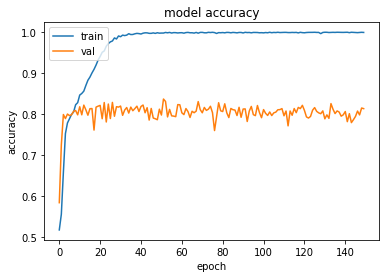

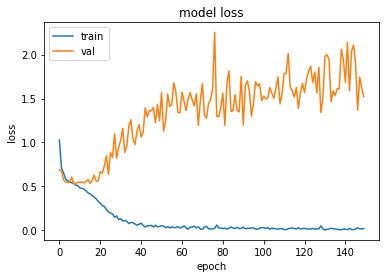

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 1.704727292060852 , AUC = 0.8109830617904663 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8359376472584021
test 0.8183341147054228

-----------------------------------------------------------------


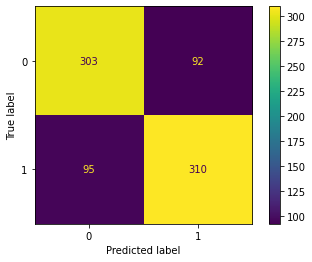

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn
# Create directory to save models
rt_sv_dir = '/content/models/150'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])


  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  history =  MERGM.fit_generator(
                  imgs_em,
                  epochs=150,
                  validation_data=VAL,
                  verbose=2,
                  callbacks=[evaluator, checkpointer])
  print(history.history.keys())
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('accuracy.png')

  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig('loss.png')

  plt.show()

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

0
Num_samples: 800
acc:  0.7325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5128196477890015 , AUC = 0.8341865539550781 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8277634315370164
test 0.8341678387248008

-----------------------------------------------------------------


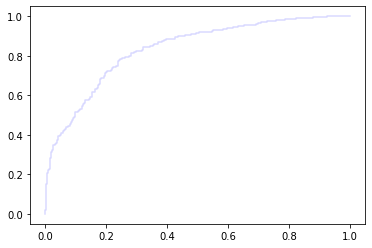

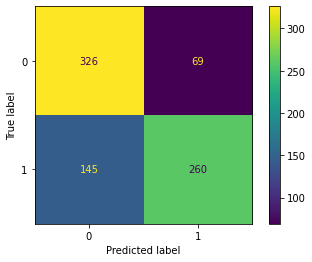

1
Num_samples: 800
acc:  0.7925


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.44445502758026123 , AUC = 0.8806688785552979 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8716063810403433
test 0.8806188466947961

-----------------------------------------------------------------


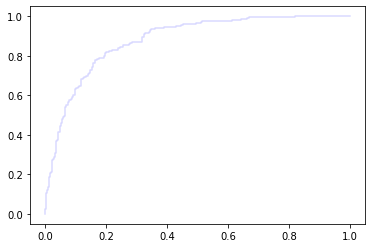

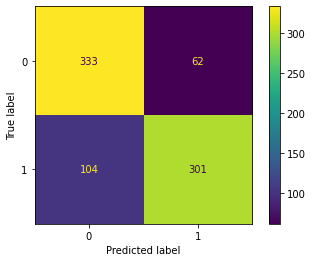

2
Num_samples: 800
acc:  0.755


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5085784792900085 , AUC = 0.833327054977417 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8295226785792823
test 0.8334364744491326

-----------------------------------------------------------------


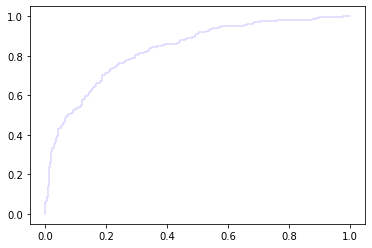

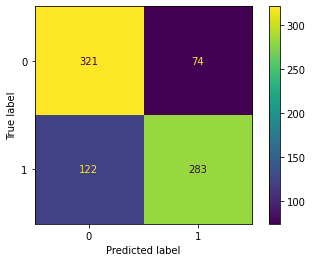

3
Num_samples: 800
acc:  0.7875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.45526930689811707 , AUC = 0.8778089880943298 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8708147198713236
test 0.8777183934989843

-----------------------------------------------------------------


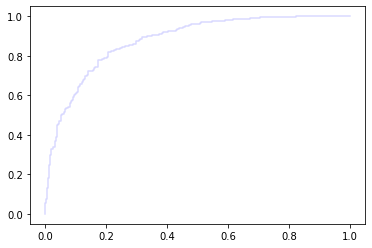

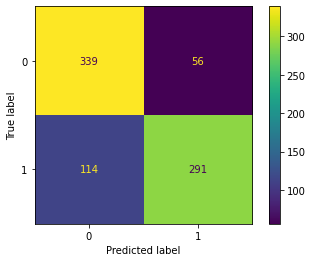

4
Num_samples: 800
acc:  0.7525


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5270452499389648 , AUC = 0.8179152607917786 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8069917503879769
test 0.8179215502422252

-----------------------------------------------------------------


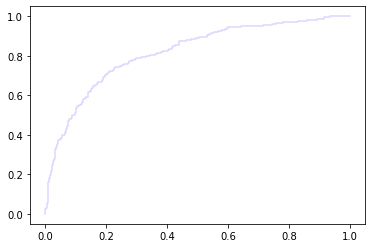

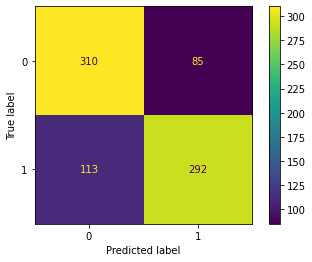

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


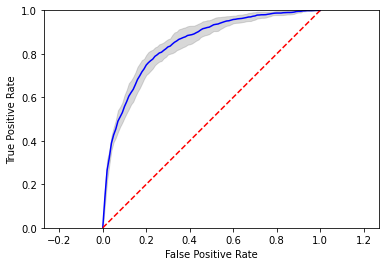

In [ ]:

# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/007--0.536--0.538.hdf5',
          1: '/content/models/1/017--0.506--0.440.hdf5',
          2: '/content/models/2/008--0.525--0.528.hdf5',
          3: '/content/models/3/014--0.503--0.473.hdf5',
          4: '/content/models/4/008--0.531--0.535.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]


  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  
  MERGM_Record1 = model.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = model.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = model.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

  


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [ ]:
#!cp -r "/content/models/150" "/content/gdrive/MyDrive/150"
